In [ ]:
#importing all the necessary libraries
import matplotlib
matplotlib.use('Agg')
import os
import time
import progressbar
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend import set_session
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 
from nltk.tokenize import word_tokenize
warnings.filterwarnings("ignore")



In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json


In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#downloading the dataset to colab
! kaggle datasets download -d adityajn105/flickr8k

 98% 1.02G/1.04G [00:05<00:00, 221MB/s]
100% 1.04G/1.04G [00:05<00:00, 198MB/s]


In [ ]:
#unzipping the file
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [ ]:
#location of the image file
dir_Flickr_jpg = "/content/Images"
#location of the caption file
dir_Flickr_text = "/content/Flickr8k.token.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))


The number of jpg flies in Flicker8k: 8091


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

##**PRE-PROCESSING**

Load the text data and save it into a panda dataframe df_txt.

1.filename : jpg file name





2.index : unique ID for each caption for the same image

3.caption : string of caption, all in lower case

In [ ]:
## read in the Flickr caption data
from collections import Counter
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()


datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

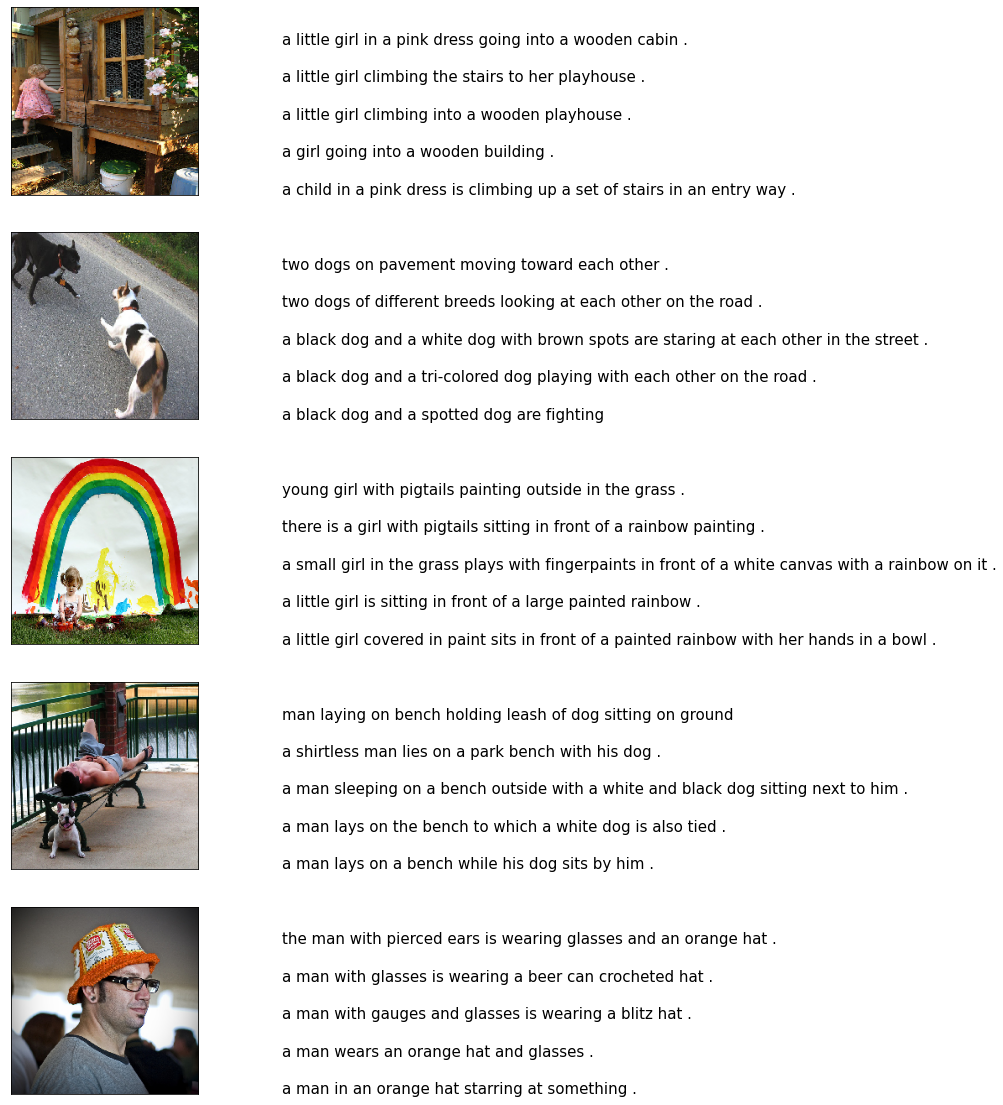

In [ ]:
#visualizing images and their corresponding captions
from tensorflow.keras.utils import img_to_array,load_img

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = dir_Flickr_jpg + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=15)
    count += 1
plt.show()


##**DATA PREPARATION**

1.TEXT PREPARATION

In [ ]:
# creating a new dataframe dfword to visualize distribution of the words
def df_word(df_txt):
    vocabulary = []
    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        vocabulary.extend(temp.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8918


word  count
0    a  62989
1    .  36581
2   in  18975

 from the above output we can see that the most common words are articles such as "a", or "the", or punctuations.

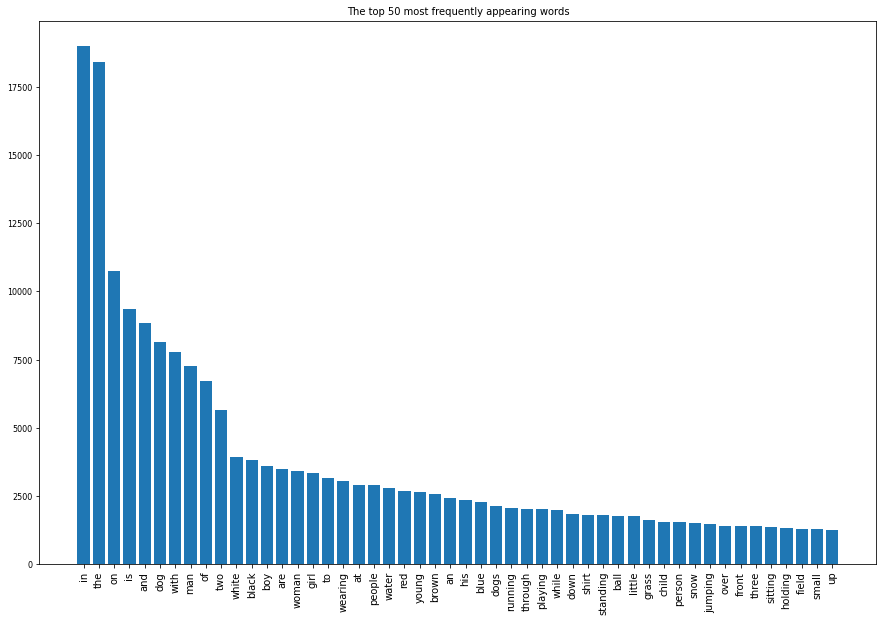

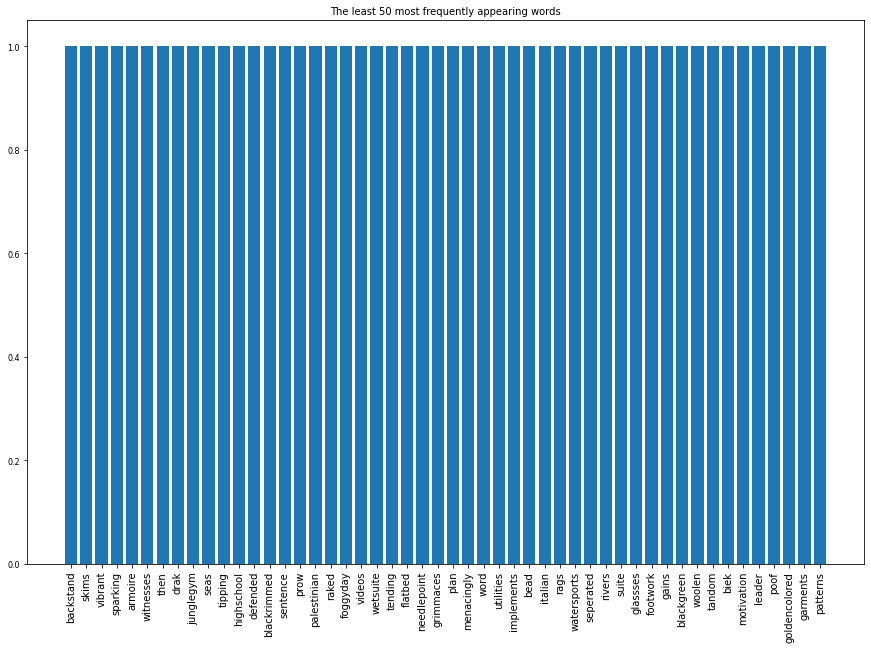

In [ ]:
#visulaising most and least frequently appearing words
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(15,10))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=8)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=10)
    plt.title(title,fontsize=10)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
#cleaning the captions by removing the punctuations,single characters and numeric characters. 
import string
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('','',string.punctuation))
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [ ]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

Vocabulary Size: 8763


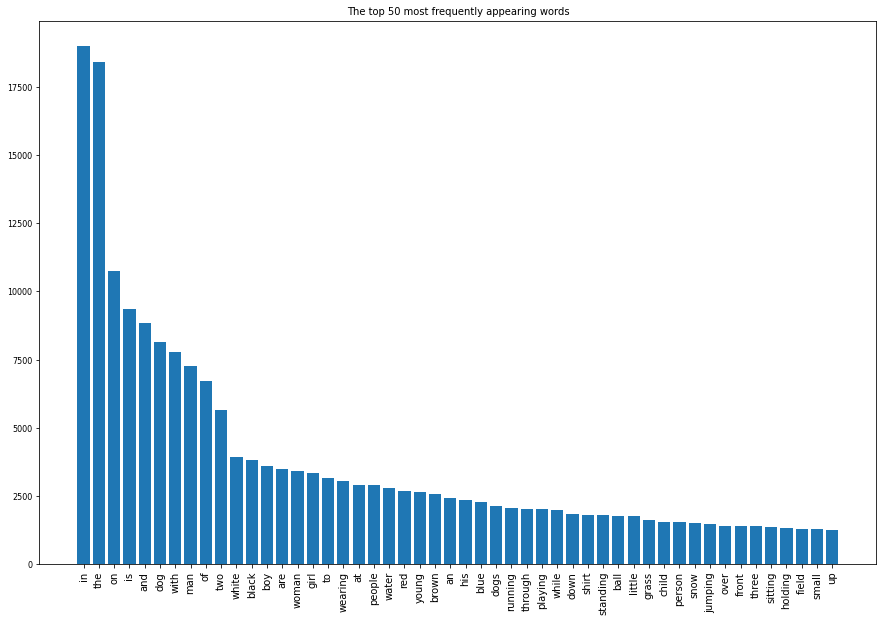

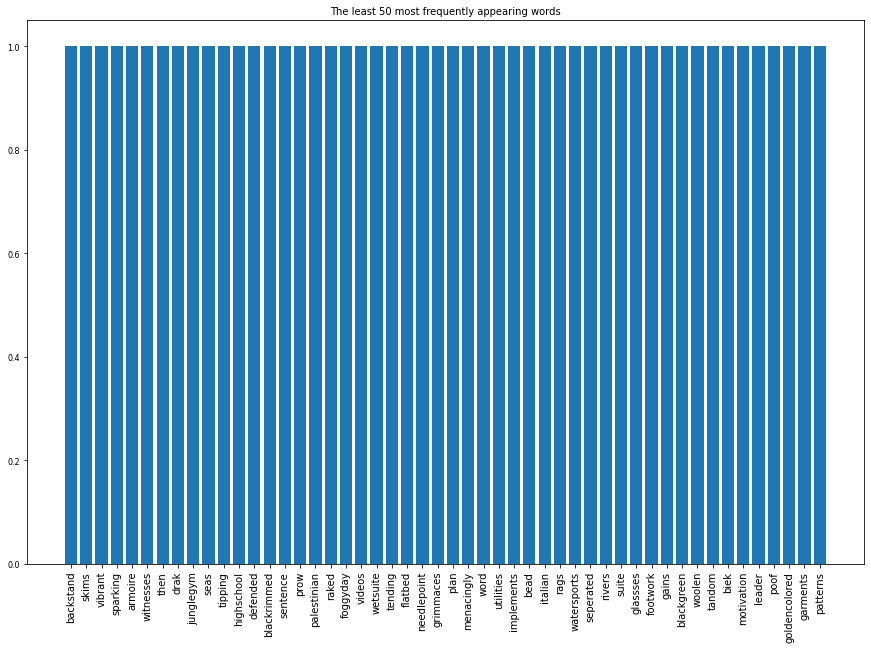

In [ ]:

#visualising most and least frequent words
dfword = df_word(df_txt)
plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

In [ ]:
#adding start and end tokens to understand the beginning and the end of a sentence clearly
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt

2.IMAGE PREPARATION

creating features for each image using VGG16

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [ ]:
#load vgg16 model
model = VGG16()
# Restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
#transforming images to features
from tensorflow.keras.utils import img_to_array,load_img
from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict

images = OrderedDict()
npix = 224
target_size = (npix,npix,3)
with progressbar.ProgressBar(max_value=len(jpgs)) as bar:
    for i,name in enumerate(jpgs):
        # load an image from file
        filename = dir_Flickr_jpg + '/' + name
        image = load_img(filename, target_size=target_size)
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        nimage = preprocess_input(image)
        y_pred = model.predict(nimage.reshape( (1,) + nimage.shape[:3]))
        images[name] = y_pred.flatten()
        bar.update(i)
    #print(i,filename)

1/1 [==============================] - 8s 8s/step


N/A% (0 of 8091) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--

1/1 [==============================] - 0s 18ms/step


  0% (2 of 8091) |                       | Elapsed Time: 0:00:00 ETA:   0:08:59

1/1 [==============================] - 0s 18ms/step


  0% (4 of 8091) |                       | Elapsed Time: 0:00:00 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


  0% (6 of 8091) |                       | Elapsed Time: 0:00:00 ETA:   0:07:47

1/1 [==============================] - 0s 17ms/step


  0% (8 of 8091) |                       | Elapsed Time: 0:00:00 ETA:   0:07:36

1/1 [==============================] - 0s 16ms/step


  0% (10 of 8091) |                      | Elapsed Time: 0:00:00 ETA:   0:07:39

1/1 [==============================] - 0s 16ms/step


  0% (12 of 8091) |                      | Elapsed Time: 0:00:00 ETA:   0:07:46

1/1 [==============================] - 0s 15ms/step


  0% (14 of 8091) |                      | Elapsed Time: 0:00:00 ETA:   0:07:43

1/1 [==============================] - 0s 23ms/step


  0% (16 of 8091) |                      | Elapsed Time: 0:00:00 ETA:   0:08:03

1/1 [==============================] - 0s 15ms/step


  0% (18 of 8091) |                      | Elapsed Time: 0:00:01 ETA:   0:08:03

1/1 [==============================] - 0s 16ms/step


  0% (20 of 8091) |                      | Elapsed Time: 0:00:01 ETA:   0:07:59

1/1 [==============================] - 0s 16ms/step


  0% (22 of 8091) |                      | Elapsed Time: 0:00:01 ETA:   0:07:57

1/1 [==============================] - 0s 15ms/step


  0% (24 of 8091) |                      | Elapsed Time: 0:00:01 ETA:   0:07:56

1/1 [==============================] - 0s 15ms/step


  0% (26 of 8091) |                      | Elapsed Time: 0:00:01 ETA:   0:07:53

1/1 [==============================] - 0s 17ms/step


  0% (28 of 8091) |                      | Elapsed Time: 0:00:01 ETA:   0:07:53

1/1 [==============================] - 0s 18ms/step


  0% (30 of 8091) |                      | Elapsed Time: 0:00:01 ETA:   0:07:52

1/1 [==============================] - 0s 19ms/step


  0% (32 of 8091) |                      | Elapsed Time: 0:00:01 ETA:   0:07:57

1/1 [==============================] - 0s 17ms/step


  0% (34 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:07:57

1/1 [==============================] - 0s 16ms/step


  0% (36 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:07:54

1/1 [==============================] - 0s 15ms/step


  0% (38 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:07:59

1/1 [==============================] - 0s 15ms/step


  0% (40 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:08:01

1/1 [==============================] - 0s 17ms/step


  0% (42 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:08:06

1/1 [==============================] - 0s 18ms/step


  0% (44 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:08:11

1/1 [==============================] - 0s 17ms/step


  0% (46 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:08:11

1/1 [==============================] - 0s 17ms/step


  0% (48 of 8091) |                      | Elapsed Time: 0:00:02 ETA:   0:08:15

1/1 [==============================] - 0s 16ms/step


  0% (50 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:08:08

1/1 [==============================] - 0s 19ms/step


  0% (52 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:08:10

1/1 [==============================] - 0s 17ms/step


  0% (54 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:08:15

1/1 [==============================] - 0s 21ms/step


  0% (56 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:08:18

1/1 [==============================] - 0s 16ms/step


  0% (58 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:08:25

1/1 [==============================] - 0s 17ms/step


  0% (60 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:08:27

1/1 [==============================] - 0s 17ms/step


  0% (62 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:08:29

1/1 [==============================] - 0s 16ms/step


  0% (64 of 8091) |                      | Elapsed Time: 0:00:03 ETA:   0:08:30

1/1 [==============================] - 0s 16ms/step


  0% (66 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:08:31

1/1 [==============================] - 0s 18ms/step


  0% (68 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:08:32

1/1 [==============================] - 0s 16ms/step


  0% (70 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:08:30

1/1 [==============================] - 0s 16ms/step


  0% (72 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:08:32

1/1 [==============================] - 0s 17ms/step


  0% (74 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:08:32

1/1 [==============================] - 0s 18ms/step


  0% (76 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:08:26

1/1 [==============================] - 0s 17ms/step


  0% (78 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:08:26

1/1 [==============================] - 0s 18ms/step


  0% (80 of 8091) |                      | Elapsed Time: 0:00:04 ETA:   0:08:25

1/1 [==============================] - 0s 15ms/step


  1% (82 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:08:25

1/1 [==============================] - 0s 17ms/step


  1% (84 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:08:27

1/1 [==============================] - 0s 15ms/step


  1% (86 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:08:24

1/1 [==============================] - 0s 16ms/step


  1% (88 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:08:23

1/1 [==============================] - 0s 18ms/step


  1% (90 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:08:20

1/1 [==============================] - 0s 18ms/step


  1% (92 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:08:21

1/1 [==============================] - 0s 15ms/step


  1% (94 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:08:23

1/1 [==============================] - 0s 17ms/step


  1% (96 of 8091) |                      | Elapsed Time: 0:00:05 ETA:   0:08:22

1/1 [==============================] - 0s 18ms/step


  1% (98 of 8091) |                      | Elapsed Time: 0:00:06 ETA:   0:08:17

1/1 [==============================] - 0s 24ms/step


  1% (100 of 8091) |                     | Elapsed Time: 0:00:06 ETA:   0:08:19

1/1 [==============================] - 0s 15ms/step


  1% (102 of 8091) |                     | Elapsed Time: 0:00:06 ETA:   0:08:17

1/1 [==============================] - 0s 15ms/step


  1% (103 of 8091) |                     | Elapsed Time: 0:00:06 ETA:   0:08:17

1/1 [==============================] - 0s 15ms/step


  1% (105 of 8091) |                     | Elapsed Time: 0:00:06 ETA:   0:08:18

1/1 [==============================] - 0s 16ms/step


  1% (106 of 8091) |                     | Elapsed Time: 0:00:06 ETA:   0:09:12

1/1 [==============================] - 0s 16ms/step


  1% (108 of 8091) |                     | Elapsed Time: 0:00:06 ETA:   0:09:12

1/1 [==============================] - 0s 20ms/step


  1% (110 of 8091) |                     | Elapsed Time: 0:00:06 ETA:   0:09:11

1/1 [==============================] - 0s 16ms/step


  1% (112 of 8091) |                     | Elapsed Time: 0:00:07 ETA:   0:09:12

1/1 [==============================] - 0s 20ms/step


  1% (114 of 8091) |                     | Elapsed Time: 0:00:07 ETA:   0:09:11

1/1 [==============================] - 0s 16ms/step


  1% (116 of 8091) |                     | Elapsed Time: 0:00:07 ETA:   0:09:13

1/1 [==============================] - 0s 17ms/step


  1% (118 of 8091) |                     | Elapsed Time: 0:00:07 ETA:   0:09:14

1/1 [==============================] - 0s 15ms/step


  1% (120 of 8091) |                     | Elapsed Time: 0:00:07 ETA:   0:09:13

1/1 [==============================] - 0s 19ms/step


  1% (122 of 8091) |                     | Elapsed Time: 0:00:07 ETA:   0:09:14

1/1 [==============================] - 0s 18ms/step


  1% (124 of 8091) |                     | Elapsed Time: 0:00:07 ETA:   0:09:13

1/1 [==============================] - 0s 19ms/step


  1% (126 of 8091) |                     | Elapsed Time: 0:00:08 ETA:   0:09:18

1/1 [==============================] - 0s 20ms/step


  1% (128 of 8091) |                     | Elapsed Time: 0:00:08 ETA:   0:09:20

1/1 [==============================] - 0s 15ms/step


  1% (130 of 8091) |                     | Elapsed Time: 0:00:08 ETA:   0:09:20

1/1 [==============================] - 0s 15ms/step


  1% (132 of 8091) |                     | Elapsed Time: 0:00:08 ETA:   0:09:21

1/1 [==============================] - 0s 18ms/step


  1% (134 of 8091) |                     | Elapsed Time: 0:00:08 ETA:   0:09:26

1/1 [==============================] - 0s 19ms/step


  1% (136 of 8091) |                     | Elapsed Time: 0:00:08 ETA:   0:09:26

1/1 [==============================] - 0s 22ms/step


  1% (138 of 8091) |                     | Elapsed Time: 0:00:08 ETA:   0:08:37

1/1 [==============================] - 0s 15ms/step


  1% (140 of 8091) |                     | Elapsed Time: 0:00:08 ETA:   0:08:35

1/1 [==============================] - 0s 18ms/step


  1% (142 of 8091) |                     | Elapsed Time: 0:00:09 ETA:   0:08:36

1/1 [==============================] - 0s 19ms/step


  1% (144 of 8091) |                     | Elapsed Time: 0:00:09 ETA:   0:08:34

1/1 [==============================] - 0s 17ms/step


  1% (146 of 8091) |                     | Elapsed Time: 0:00:09 ETA:   0:08:35

1/1 [==============================] - 0s 16ms/step


  1% (148 of 8091) |                     | Elapsed Time: 0:00:09 ETA:   0:08:33

1/1 [==============================] - 0s 16ms/step


  1% (150 of 8091) |                     | Elapsed Time: 0:00:09 ETA:   0:08:35

1/1 [==============================] - 0s 15ms/step


  1% (152 of 8091) |                     | Elapsed Time: 0:00:09 ETA:   0:08:35

1/1 [==============================] - 0s 16ms/step


  1% (154 of 8091) |                     | Elapsed Time: 0:00:09 ETA:   0:08:34

1/1 [==============================] - 0s 16ms/step


  1% (156 of 8091) |                     | Elapsed Time: 0:00:09 ETA:   0:08:33

1/1 [==============================] - 0s 16ms/step


  1% (158 of 8091) |                     | Elapsed Time: 0:00:10 ETA:   0:08:29

1/1 [==============================] - 0s 15ms/step


  1% (160 of 8091) |                     | Elapsed Time: 0:00:10 ETA:   0:08:27

1/1 [==============================] - 0s 21ms/step


  2% (162 of 8091) |                     | Elapsed Time: 0:00:10 ETA:   0:08:28

1/1 [==============================] - 0s 17ms/step


  2% (164 of 8091) |                     | Elapsed Time: 0:00:10 ETA:   0:08:28

1/1 [==============================] - 0s 15ms/step


  2% (166 of 8091) |                     | Elapsed Time: 0:00:10 ETA:   0:08:27

1/1 [==============================] - 0s 15ms/step


  2% (168 of 8091) |                     | Elapsed Time: 0:00:10 ETA:   0:08:22

1/1 [==============================] - 0s 16ms/step


  2% (170 of 8091) |                     | Elapsed Time: 0:00:10 ETA:   0:08:22

1/1 [==============================] - 0s 23ms/step


  2% (172 of 8091) |                     | Elapsed Time: 0:00:10 ETA:   0:08:25

1/1 [==============================] - 0s 16ms/step


  2% (174 of 8091) |                     | Elapsed Time: 0:00:11 ETA:   0:08:25

1/1 [==============================] - 0s 15ms/step


  2% (176 of 8091) |                     | Elapsed Time: 0:00:11 ETA:   0:08:27

1/1 [==============================] - 0s 16ms/step


  2% (178 of 8091) |                     | Elapsed Time: 0:00:11 ETA:   0:08:25

1/1 [==============================] - 0s 18ms/step


  2% (180 of 8091) |                     | Elapsed Time: 0:00:11 ETA:   0:08:26

1/1 [==============================] - 0s 17ms/step


  2% (182 of 8091) |                     | Elapsed Time: 0:00:11 ETA:   0:08:25

1/1 [==============================] - 0s 19ms/step


  2% (184 of 8091) |                     | Elapsed Time: 0:00:11 ETA:   0:08:25

1/1 [==============================] - 0s 20ms/step


  2% (186 of 8091) |                     | Elapsed Time: 0:00:11 ETA:   0:08:28

1/1 [==============================] - 0s 15ms/step


  2% (188 of 8091) |                     | Elapsed Time: 0:00:12 ETA:   0:08:28

1/1 [==============================] - 0s 18ms/step


  2% (190 of 8091) |                     | Elapsed Time: 0:00:12 ETA:   0:08:26

1/1 [==============================] - 0s 15ms/step


  2% (192 of 8091) |                     | Elapsed Time: 0:00:12 ETA:   0:08:26

1/1 [==============================] - 0s 16ms/step


  2% (194 of 8091) |                     | Elapsed Time: 0:00:12 ETA:   0:08:25

1/1 [==============================] - 0s 17ms/step


  2% (196 of 8091) |                     | Elapsed Time: 0:00:12 ETA:   0:08:26

1/1 [==============================] - 0s 16ms/step


  2% (198 of 8091) |                     | Elapsed Time: 0:00:12 ETA:   0:08:25

1/1 [==============================] - 0s 18ms/step


  2% (200 of 8091) |                     | Elapsed Time: 0:00:12 ETA:   0:08:25

1/1 [==============================] - 0s 16ms/step


  2% (202 of 8091) |                     | Elapsed Time: 0:00:12 ETA:   0:08:25

1/1 [==============================] - 0s 16ms/step


  2% (204 of 8091) |                     | Elapsed Time: 0:00:13 ETA:   0:08:22

1/1 [==============================] - 0s 17ms/step


  2% (205 of 8091) |                     | Elapsed Time: 0:00:13 ETA:   0:08:22

1/1 [==============================] - 0s 17ms/step


  2% (207 of 8091) |                     | Elapsed Time: 0:00:13 ETA:   0:08:25

1/1 [==============================] - 0s 16ms/step


  2% (209 of 8091) |                     | Elapsed Time: 0:00:13 ETA:   0:08:25

1/1 [==============================] - 0s 16ms/step


  2% (211 of 8091) |                     | Elapsed Time: 0:00:13 ETA:   0:08:22

1/1 [==============================] - 0s 17ms/step


  2% (213 of 8091) |                     | Elapsed Time: 0:00:13 ETA:   0:08:21

1/1 [==============================] - 0s 16ms/step


  2% (215 of 8091) |                     | Elapsed Time: 0:00:13 ETA:   0:08:22

1/1 [==============================] - 0s 16ms/step


  2% (217 of 8091) |                     | Elapsed Time: 0:00:13 ETA:   0:08:24

1/1 [==============================] - 0s 17ms/step


  2% (219 of 8091) |                     | Elapsed Time: 0:00:13 ETA:   0:08:21

1/1 [==============================] - 0s 19ms/step


  2% (221 of 8091) |                     | Elapsed Time: 0:00:14 ETA:   0:08:21

1/1 [==============================] - 0s 16ms/step


  2% (223 of 8091) |                     | Elapsed Time: 0:00:14 ETA:   0:08:22

1/1 [==============================] - 0s 16ms/step


  2% (225 of 8091) |                     | Elapsed Time: 0:00:14 ETA:   0:08:23

1/1 [==============================] - 0s 18ms/step


  2% (227 of 8091) |                     | Elapsed Time: 0:00:14 ETA:   0:08:22

1/1 [==============================] - 0s 19ms/step


  2% (229 of 8091) |                     | Elapsed Time: 0:00:14 ETA:   0:08:24

1/1 [==============================] - 0s 18ms/step


  2% (230 of 8091) |                     | Elapsed Time: 0:00:14 ETA:   0:08:33

1/1 [==============================] - 0s 19ms/step


  2% (232 of 8091) |                     | Elapsed Time: 0:00:14 ETA:   0:08:35

1/1 [==============================] - 0s 16ms/step


  2% (234 of 8091) |                     | Elapsed Time: 0:00:14 ETA:   0:08:33

1/1 [==============================] - 0s 19ms/step


  2% (236 of 8091) |                     | Elapsed Time: 0:00:15 ETA:   0:08:33

1/1 [==============================] - 0s 17ms/step


  2% (238 of 8091) |                     | Elapsed Time: 0:00:15 ETA:   0:08:32

1/1 [==============================] - 0s 16ms/step


  2% (240 of 8091) |                     | Elapsed Time: 0:00:15 ETA:   0:08:33

1/1 [==============================] - 0s 16ms/step


  2% (242 of 8091) |                     | Elapsed Time: 0:00:15 ETA:   0:08:34

1/1 [==============================] - 0s 16ms/step


  3% (244 of 8091) |                     | Elapsed Time: 0:00:15 ETA:   0:08:34

1/1 [==============================] - 0s 17ms/step


  3% (246 of 8091) |                     | Elapsed Time: 0:00:15 ETA:   0:08:32

1/1 [==============================] - 0s 17ms/step


  3% (248 of 8091) |                     | Elapsed Time: 0:00:15 ETA:   0:08:32

1/1 [==============================] - 0s 15ms/step


  3% (250 of 8091) |                     | Elapsed Time: 0:00:16 ETA:   0:08:32

1/1 [==============================] - 0s 17ms/step


  3% (252 of 8091) |                     | Elapsed Time: 0:00:16 ETA:   0:08:30

1/1 [==============================] - 0s 17ms/step


  3% (254 of 8091) |                     | Elapsed Time: 0:00:16 ETA:   0:08:29

1/1 [==============================] - 0s 20ms/step


  3% (256 of 8091) |                     | Elapsed Time: 0:00:16 ETA:   0:08:33

1/1 [==============================] - 0s 21ms/step


  3% (258 of 8091) |                     | Elapsed Time: 0:00:16 ETA:   0:08:34

1/1 [==============================] - 0s 16ms/step


  3% (260 of 8091) |                     | Elapsed Time: 0:00:16 ETA:   0:08:33

1/1 [==============================] - 0s 17ms/step


  3% (262 of 8091) |                     | Elapsed Time: 0:00:16 ETA:   0:08:22

1/1 [==============================] - 0s 18ms/step


  3% (264 of 8091) |                     | Elapsed Time: 0:00:16 ETA:   0:08:23

1/1 [==============================] - 0s 16ms/step


  3% (266 of 8091) |                     | Elapsed Time: 0:00:17 ETA:   0:08:25

1/1 [==============================] - 0s 17ms/step


  3% (268 of 8091) |                     | Elapsed Time: 0:00:17 ETA:   0:08:25

1/1 [==============================] - 0s 18ms/step


  3% (270 of 8091) |                     | Elapsed Time: 0:00:17 ETA:   0:08:25

1/1 [==============================] - 0s 18ms/step


  3% (272 of 8091) |                     | Elapsed Time: 0:00:17 ETA:   0:08:25

1/1 [==============================] - 0s 16ms/step


  3% (274 of 8091) |                     | Elapsed Time: 0:00:17 ETA:   0:08:26

1/1 [==============================] - 0s 19ms/step


  3% (276 of 8091) |                     | Elapsed Time: 0:00:17 ETA:   0:08:24

1/1 [==============================] - 0s 15ms/step


  3% (278 of 8091) |                     | Elapsed Time: 0:00:17 ETA:   0:08:24

1/1 [==============================] - 0s 16ms/step


  3% (280 of 8091) |                     | Elapsed Time: 0:00:17 ETA:   0:08:25

1/1 [==============================] - 0s 19ms/step


  3% (282 of 8091) |                     | Elapsed Time: 0:00:18 ETA:   0:08:24

1/1 [==============================] - 0s 17ms/step


  3% (284 of 8091) |                     | Elapsed Time: 0:00:18 ETA:   0:08:25

1/1 [==============================] - 0s 19ms/step


  3% (286 of 8091) |                     | Elapsed Time: 0:00:18 ETA:   0:08:25

1/1 [==============================] - 0s 17ms/step


  3% (288 of 8091) |                     | Elapsed Time: 0:00:18 ETA:   0:08:22

1/1 [==============================] - 0s 16ms/step


  3% (290 of 8091) |                     | Elapsed Time: 0:00:18 ETA:   0:08:21

1/1 [==============================] - 0s 17ms/step


  3% (292 of 8091) |                     | Elapsed Time: 0:00:18 ETA:   0:08:18

1/1 [==============================] - 0s 18ms/step


  3% (294 of 8091) |                     | Elapsed Time: 0:00:18 ETA:   0:08:18

1/1 [==============================] - 0s 15ms/step


  3% (296 of 8091) |                     | Elapsed Time: 0:00:18 ETA:   0:08:16

1/1 [==============================] - 0s 17ms/step


  3% (298 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:08:17

1/1 [==============================] - 0s 16ms/step


  3% (300 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:08:16

1/1 [==============================] - 0s 16ms/step


  3% (302 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:08:17

1/1 [==============================] - 0s 22ms/step


  3% (303 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:08:28

1/1 [==============================] - 0s 15ms/step


  3% (305 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:08:27

1/1 [==============================] - 0s 18ms/step


  3% (307 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:08:31

1/1 [==============================] - 0s 17ms/step


  3% (308 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:08:31

1/1 [==============================] - 0s 19ms/step


  3% (310 of 8091) |                     | Elapsed Time: 0:00:19 ETA:   0:08:33

1/1 [==============================] - 0s 15ms/step


  3% (312 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:08:30

1/1 [==============================] - 0s 15ms/step


  3% (314 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:08:29

1/1 [==============================] - 0s 15ms/step


  3% (316 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:08:29

1/1 [==============================] - 0s 16ms/step


  3% (318 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:08:28

1/1 [==============================] - 0s 20ms/step


  3% (319 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:08:41

1/1 [==============================] - 0s 15ms/step


  3% (321 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:08:40

1/1 [==============================] - 0s 16ms/step


  3% (323 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:08:40

1/1 [==============================] - 0s 20ms/step


  4% (325 of 8091) |                     | Elapsed Time: 0:00:20 ETA:   0:08:40

1/1 [==============================] - 0s 15ms/step


  4% (327 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:08:38

1/1 [==============================] - 0s 16ms/step


  4% (329 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:08:37

1/1 [==============================] - 0s 17ms/step


  4% (331 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:08:37

1/1 [==============================] - 0s 16ms/step


  4% (333 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:08:35

1/1 [==============================] - 0s 20ms/step


  4% (335 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:08:24

1/1 [==============================] - 0s 18ms/step


  4% (337 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:08:26

1/1 [==============================] - 0s 17ms/step


  4% (339 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:08:23

1/1 [==============================] - 0s 18ms/step


  4% (341 of 8091) |                     | Elapsed Time: 0:00:21 ETA:   0:08:25

1/1 [==============================] - 0s 15ms/step


  4% (343 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:08:24

1/1 [==============================] - 0s 19ms/step


  4% (345 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:08:24

1/1 [==============================] - 0s 16ms/step


  4% (347 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:08:25

1/1 [==============================] - 0s 18ms/step


  4% (349 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:08:25

1/1 [==============================] - 0s 16ms/step


  4% (351 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:08:14

1/1 [==============================] - 0s 16ms/step


  4% (353 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:08:17

1/1 [==============================] - 0s 16ms/step


  4% (355 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:08:20

1/1 [==============================] - 0s 15ms/step


  4% (357 of 8091) |                     | Elapsed Time: 0:00:22 ETA:   0:08:21

1/1 [==============================] - 0s 20ms/step


  4% (358 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:08:33

1/1 [==============================] - 0s 15ms/step


  4% (360 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:08:35

1/1 [==============================] - 0s 16ms/step


  4% (362 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:08:35

1/1 [==============================] - 0s 18ms/step


  4% (364 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:08:32

1/1 [==============================] - 0s 20ms/step


  4% (366 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:08:34

1/1 [==============================] - 0s 20ms/step


  4% (368 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:08:31

1/1 [==============================] - 0s 15ms/step


  4% (370 of 8091) |                     | Elapsed Time: 0:00:23 ETA:   0:08:31

1/1 [==============================] - 0s 17ms/step


  4% (372 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:08:30

1/1 [==============================] - 0s 19ms/step


  4% (374 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:08:31

1/1 [==============================] - 0s 17ms/step


  4% (376 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:08:32

1/1 [==============================] - 0s 16ms/step


  4% (378 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:08:33

1/1 [==============================] - 0s 15ms/step


  4% (380 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:08:32

1/1 [==============================] - 0s 17ms/step


  4% (382 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:08:30

1/1 [==============================] - 0s 16ms/step


  4% (384 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:08:30

1/1 [==============================] - 0s 23ms/step


  4% (385 of 8091) |                     | Elapsed Time: 0:00:24 ETA:   0:08:40

1/1 [==============================] - 0s 17ms/step


  4% (387 of 8091) |#                    | Elapsed Time: 0:00:25 ETA:   0:08:43

1/1 [==============================] - 0s 20ms/step


  4% (389 of 8091) |#                    | Elapsed Time: 0:00:25 ETA:   0:08:31

1/1 [==============================] - 0s 17ms/step


  4% (391 of 8091) |#                    | Elapsed Time: 0:00:25 ETA:   0:08:29

1/1 [==============================] - 0s 18ms/step


  4% (393 of 8091) |#                    | Elapsed Time: 0:00:25 ETA:   0:08:29

1/1 [==============================] - 0s 19ms/step


  4% (395 of 8091) |#                    | Elapsed Time: 0:00:25 ETA:   0:08:30

1/1 [==============================] - 0s 16ms/step


  4% (397 of 8091) |#                    | Elapsed Time: 0:00:25 ETA:   0:08:29

1/1 [==============================] - 0s 19ms/step


  4% (399 of 8091) |#                    | Elapsed Time: 0:00:25 ETA:   0:08:32

1/1 [==============================] - 0s 15ms/step


  4% (401 of 8091) |#                    | Elapsed Time: 0:00:25 ETA:   0:08:32

1/1 [==============================] - 0s 20ms/step


  4% (403 of 8091) |#                    | Elapsed Time: 0:00:26 ETA:   0:08:32

1/1 [==============================] - 0s 17ms/step


  5% (405 of 8091) |#                    | Elapsed Time: 0:00:26 ETA:   0:08:32

1/1 [==============================] - 0s 17ms/step


  5% (407 of 8091) |#                    | Elapsed Time: 0:00:26 ETA:   0:08:31

1/1 [==============================] - 0s 16ms/step


  5% (409 of 8091) |#                    | Elapsed Time: 0:00:26 ETA:   0:08:29

1/1 [==============================] - 0s 16ms/step


  5% (410 of 8091) |#                    | Elapsed Time: 0:00:26 ETA:   0:08:29

1/1 [==============================] - 0s 18ms/step


  5% (412 of 8091) |#                    | Elapsed Time: 0:00:26 ETA:   0:08:32

1/1 [==============================] - 0s 19ms/step


  5% (414 of 8091) |#                    | Elapsed Time: 0:00:26 ETA:   0:08:32

1/1 [==============================] - 0s 16ms/step


  5% (416 of 8091) |#                    | Elapsed Time: 0:00:26 ETA:   0:08:18

1/1 [==============================] - 0s 19ms/step


  5% (418 of 8091) |#                    | Elapsed Time: 0:00:27 ETA:   0:08:15

1/1 [==============================] - 0s 19ms/step


  5% (420 of 8091) |#                    | Elapsed Time: 0:00:27 ETA:   0:08:15

1/1 [==============================] - 0s 17ms/step


  5% (422 of 8091) |#                    | Elapsed Time: 0:00:27 ETA:   0:08:14

1/1 [==============================] - 0s 21ms/step


  5% (424 of 8091) |#                    | Elapsed Time: 0:00:27 ETA:   0:08:17

1/1 [==============================] - 0s 21ms/step


  5% (426 of 8091) |#                    | Elapsed Time: 0:00:27 ETA:   0:08:17

1/1 [==============================] - 0s 16ms/step


  5% (428 of 8091) |#                    | Elapsed Time: 0:00:27 ETA:   0:08:17

1/1 [==============================] - 0s 16ms/step


  5% (430 of 8091) |#                    | Elapsed Time: 0:00:27 ETA:   0:08:15

1/1 [==============================] - 0s 15ms/step


  5% (432 of 8091) |#                    | Elapsed Time: 0:00:27 ETA:   0:08:13

1/1 [==============================] - 0s 16ms/step


  5% (434 of 8091) |#                    | Elapsed Time: 0:00:28 ETA:   0:08:12

1/1 [==============================] - 0s 16ms/step


  5% (436 of 8091) |#                    | Elapsed Time: 0:00:28 ETA:   0:08:11

1/1 [==============================] - 0s 16ms/step


  5% (438 of 8091) |#                    | Elapsed Time: 0:00:28 ETA:   0:08:12

1/1 [==============================] - 0s 15ms/step


  5% (440 of 8091) |#                    | Elapsed Time: 0:00:28 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


  5% (442 of 8091) |#                    | Elapsed Time: 0:00:28 ETA:   0:08:12

1/1 [==============================] - 0s 21ms/step


  5% (444 of 8091) |#                    | Elapsed Time: 0:00:28 ETA:   0:08:15

1/1 [==============================] - 0s 17ms/step


  5% (446 of 8091) |#                    | Elapsed Time: 0:00:28 ETA:   0:08:16

1/1 [==============================] - 0s 15ms/step


  5% (448 of 8091) |#                    | Elapsed Time: 0:00:28 ETA:   0:08:17

1/1 [==============================] - 0s 18ms/step


  5% (450 of 8091) |#                    | Elapsed Time: 0:00:29 ETA:   0:08:18

1/1 [==============================] - 0s 16ms/step


  5% (452 of 8091) |#                    | Elapsed Time: 0:00:29 ETA:   0:08:15

1/1 [==============================] - 0s 15ms/step


  5% (454 of 8091) |#                    | Elapsed Time: 0:00:29 ETA:   0:08:12

1/1 [==============================] - 0s 15ms/step


  5% (456 of 8091) |#                    | Elapsed Time: 0:00:29 ETA:   0:08:11

1/1 [==============================] - 0s 16ms/step


  5% (458 of 8091) |#                    | Elapsed Time: 0:00:29 ETA:   0:08:10

1/1 [==============================] - 0s 19ms/step


  5% (460 of 8091) |#                    | Elapsed Time: 0:00:29 ETA:   0:08:13

1/1 [==============================] - 0s 15ms/step


  5% (462 of 8091) |#                    | Elapsed Time: 0:00:29 ETA:   0:08:14

1/1 [==============================] - 0s 17ms/step


  5% (464 of 8091) |#                    | Elapsed Time: 0:00:30 ETA:   0:08:19

1/1 [==============================] - 0s 18ms/step


  5% (466 of 8091) |#                    | Elapsed Time: 0:00:30 ETA:   0:08:23

1/1 [==============================] - 0s 16ms/step


  5% (468 of 8091) |#                    | Elapsed Time: 0:00:30 ETA:   0:08:21

1/1 [==============================] - 0s 18ms/step


  5% (470 of 8091) |#                    | Elapsed Time: 0:00:30 ETA:   0:08:18

1/1 [==============================] - 0s 15ms/step


  5% (472 of 8091) |#                    | Elapsed Time: 0:00:30 ETA:   0:08:20

1/1 [==============================] - 0s 16ms/step


  5% (474 of 8091) |#                    | Elapsed Time: 0:00:30 ETA:   0:08:20

1/1 [==============================] - 0s 16ms/step


  5% (476 of 8091) |#                    | Elapsed Time: 0:00:30 ETA:   0:08:20

1/1 [==============================] - 0s 18ms/step


  5% (478 of 8091) |#                    | Elapsed Time: 0:00:30 ETA:   0:08:19

1/1 [==============================] - 0s 17ms/step


  5% (480 of 8091) |#                    | Elapsed Time: 0:00:31 ETA:   0:08:18

1/1 [==============================] - 0s 16ms/step


  5% (482 of 8091) |#                    | Elapsed Time: 0:00:31 ETA:   0:08:18

1/1 [==============================] - 0s 15ms/step


  5% (484 of 8091) |#                    | Elapsed Time: 0:00:31 ETA:   0:08:21

1/1 [==============================] - 0s 17ms/step


  6% (486 of 8091) |#                    | Elapsed Time: 0:00:31 ETA:   0:08:23

1/1 [==============================] - 0s 19ms/step


  6% (488 of 8091) |#                    | Elapsed Time: 0:00:31 ETA:   0:08:26

1/1 [==============================] - 0s 20ms/step


  6% (490 of 8091) |#                    | Elapsed Time: 0:00:31 ETA:   0:08:25

1/1 [==============================] - 0s 18ms/step


  6% (492 of 8091) |#                    | Elapsed Time: 0:00:31 ETA:   0:08:24

1/1 [==============================] - 0s 16ms/step


  6% (494 of 8091) |#                    | Elapsed Time: 0:00:32 ETA:   0:08:24

1/1 [==============================] - 0s 19ms/step


  6% (496 of 8091) |#                    | Elapsed Time: 0:00:32 ETA:   0:08:29

1/1 [==============================] - 0s 15ms/step


  6% (498 of 8091) |#                    | Elapsed Time: 0:00:32 ETA:   0:08:29

1/1 [==============================] - 0s 16ms/step


  6% (500 of 8091) |#                    | Elapsed Time: 0:00:32 ETA:   0:08:29

1/1 [==============================] - 0s 17ms/step


  6% (502 of 8091) |#                    | Elapsed Time: 0:00:32 ETA:   0:08:29

1/1 [==============================] - 0s 18ms/step


  6% (504 of 8091) |#                    | Elapsed Time: 0:00:32 ETA:   0:08:40

1/1 [==============================] - 0s 16ms/step


  6% (506 of 8091) |#                    | Elapsed Time: 0:00:32 ETA:   0:08:40

1/1 [==============================] - 0s 19ms/step


  6% (508 of 8091) |#                    | Elapsed Time: 0:00:33 ETA:   0:08:42

1/1 [==============================] - 0s 21ms/step


  6% (510 of 8091) |#                    | Elapsed Time: 0:00:33 ETA:   0:08:42

1/1 [==============================] - 0s 17ms/step


  6% (512 of 8091) |#                    | Elapsed Time: 0:00:33 ETA:   0:08:43

1/1 [==============================] - 0s 18ms/step


  6% (513 of 8091) |#                    | Elapsed Time: 0:00:33 ETA:   0:08:43

1/1 [==============================] - 0s 42ms/step


  6% (515 of 8091) |#                    | Elapsed Time: 0:00:33 ETA:   0:08:54

1/1 [==============================] - 0s 28ms/step


  6% (516 of 8091) |#                    | Elapsed Time: 0:00:33 ETA:   0:09:07

1/1 [==============================] - 0s 24ms/step


  6% (517 of 8091) |#                    | Elapsed Time: 0:00:33 ETA:   0:09:27

1/1 [==============================] - 0s 32ms/step


  6% (519 of 8091) |#                    | Elapsed Time: 0:00:33 ETA:   0:09:37

1/1 [==============================] - 0s 22ms/step


  6% (521 of 8091) |#                    | Elapsed Time: 0:00:34 ETA:   0:09:49

1/1 [==============================] - 0s 21ms/step


  6% (523 of 8091) |#                    | Elapsed Time: 0:00:34 ETA:   0:09:47

1/1 [==============================] - 0s 24ms/step


  6% (525 of 8091) |#                    | Elapsed Time: 0:00:34 ETA:   0:10:09

1/1 [==============================] - 0s 23ms/step


  6% (527 of 8091) |#                    | Elapsed Time: 0:00:34 ETA:   0:10:24

1/1 [==============================] - 0s 23ms/step


  6% (529 of 8091) |#                    | Elapsed Time: 0:00:34 ETA:   0:10:23

1/1 [==============================] - 0s 23ms/step


  6% (531 of 8091) |#                    | Elapsed Time: 0:00:34 ETA:   0:10:32

1/1 [==============================] - 0s 30ms/step


  6% (533 of 8091) |#                    | Elapsed Time: 0:00:35 ETA:   0:10:39

1/1 [==============================] - 0s 28ms/step


  6% (534 of 8091) |#                    | Elapsed Time: 0:00:35 ETA:   0:11:05

1/1 [==============================] - 0s 21ms/step


  6% (536 of 8091) |#                    | Elapsed Time: 0:00:35 ETA:   0:11:14

1/1 [==============================] - 0s 24ms/step


  6% (538 of 8091) |#                    | Elapsed Time: 0:00:35 ETA:   0:11:23

1/1 [==============================] - 0s 27ms/step


  6% (540 of 8091) |#                    | Elapsed Time: 0:00:35 ETA:   0:11:04

1/1 [==============================] - 0s 23ms/step


  6% (542 of 8091) |#                    | Elapsed Time: 0:00:35 ETA:   0:11:06

1/1 [==============================] - 0s 30ms/step


  6% (544 of 8091) |#                    | Elapsed Time: 0:00:36 ETA:   0:11:06

1/1 [==============================] - 0s 23ms/step


  6% (546 of 8091) |#                    | Elapsed Time: 0:00:36 ETA:   0:11:06

1/1 [==============================] - 0s 23ms/step


  6% (548 of 8091) |#                    | Elapsed Time: 0:00:36 ETA:   0:11:12

1/1 [==============================] - 0s 24ms/step


  6% (550 of 8091) |#                    | Elapsed Time: 0:00:36 ETA:   0:11:06

1/1 [==============================] - 0s 32ms/step


  6% (551 of 8091) |#                    | Elapsed Time: 0:00:36 ETA:   0:11:10

1/1 [==============================] - 0s 48ms/step


  6% (553 of 8091) |#                    | Elapsed Time: 0:00:36 ETA:   0:11:20

1/1 [==============================] - 0s 27ms/step


  6% (554 of 8091) |#                    | Elapsed Time: 0:00:37 ETA:   0:11:25

1/1 [==============================] - 0s 25ms/step


  6% (556 of 8091) |#                    | Elapsed Time: 0:00:37 ETA:   0:11:38

1/1 [==============================] - 0s 24ms/step


  6% (558 of 8091) |#                    | Elapsed Time: 0:00:37 ETA:   0:11:46

1/1 [==============================] - 0s 16ms/step


  6% (560 of 8091) |#                    | Elapsed Time: 0:00:37 ETA:   0:11:32

1/1 [==============================] - 0s 19ms/step


  6% (562 of 8091) |#                    | Elapsed Time: 0:00:37 ETA:   0:11:16

1/1 [==============================] - 0s 18ms/step


  6% (564 of 8091) |#                    | Elapsed Time: 0:00:37 ETA:   0:10:58

1/1 [==============================] - 0s 19ms/step


  6% (566 of 8091) |#                    | Elapsed Time: 0:00:38 ETA:   0:10:48

1/1 [==============================] - 0s 16ms/step


  7% (568 of 8091) |#                    | Elapsed Time: 0:00:38 ETA:   0:10:34

1/1 [==============================] - 0s 15ms/step


  7% (570 of 8091) |#                    | Elapsed Time: 0:00:38 ETA:   0:10:23

1/1 [==============================] - 0s 17ms/step


  7% (572 of 8091) |#                    | Elapsed Time: 0:00:38 ETA:   0:10:10

1/1 [==============================] - 0s 18ms/step


  7% (574 of 8091) |#                    | Elapsed Time: 0:00:38 ETA:   0:09:56

1/1 [==============================] - 0s 20ms/step


  7% (576 of 8091) |#                    | Elapsed Time: 0:00:38 ETA:   0:09:46

1/1 [==============================] - 0s 18ms/step


  7% (578 of 8091) |#                    | Elapsed Time: 0:00:38 ETA:   0:09:37

1/1 [==============================] - 0s 21ms/step


  7% (579 of 8091) |#                    | Elapsed Time: 0:00:38 ETA:   0:09:47

1/1 [==============================] - 0s 18ms/step


  7% (581 of 8091) |#                    | Elapsed Time: 0:00:39 ETA:   0:09:21

1/1 [==============================] - 0s 16ms/step


  7% (583 of 8091) |#                    | Elapsed Time: 0:00:39 ETA:   0:09:15

1/1 [==============================] - 0s 20ms/step


  7% (585 of 8091) |#                    | Elapsed Time: 0:00:39 ETA:   0:08:45

1/1 [==============================] - 0s 17ms/step


  7% (587 of 8091) |#                    | Elapsed Time: 0:00:39 ETA:   0:08:42

1/1 [==============================] - 0s 18ms/step


  7% (589 of 8091) |#                    | Elapsed Time: 0:00:39 ETA:   0:08:30

1/1 [==============================] - 0s 19ms/step


  7% (591 of 8091) |#                    | Elapsed Time: 0:00:39 ETA:   0:08:30

1/1 [==============================] - 0s 17ms/step


  7% (593 of 8091) |#                    | Elapsed Time: 0:00:39 ETA:   0:08:29

1/1 [==============================] - 0s 19ms/step


  7% (595 of 8091) |#                    | Elapsed Time: 0:00:39 ETA:   0:08:29

1/1 [==============================] - 0s 17ms/step


  7% (597 of 8091) |#                    | Elapsed Time: 0:00:40 ETA:   0:08:24

1/1 [==============================] - 0s 21ms/step


  7% (599 of 8091) |#                    | Elapsed Time: 0:00:40 ETA:   0:08:24

1/1 [==============================] - 0s 15ms/step


  7% (601 of 8091) |#                    | Elapsed Time: 0:00:40 ETA:   0:08:23

1/1 [==============================] - 0s 17ms/step


  7% (603 of 8091) |#                    | Elapsed Time: 0:00:40 ETA:   0:08:24

1/1 [==============================] - 0s 15ms/step


  7% (605 of 8091) |#                    | Elapsed Time: 0:00:40 ETA:   0:08:30

1/1 [==============================] - 0s 17ms/step


  7% (607 of 8091) |#                    | Elapsed Time: 0:00:40 ETA:   0:08:29

1/1 [==============================] - 0s 18ms/step


  7% (609 of 8091) |#                    | Elapsed Time: 0:00:40 ETA:   0:08:24

1/1 [==============================] - 0s 19ms/step


  7% (611 of 8091) |#                    | Elapsed Time: 0:00:41 ETA:   0:08:14

1/1 [==============================] - 0s 17ms/step


  7% (612 of 8091) |#                    | Elapsed Time: 0:00:41 ETA:   0:08:25

1/1 [==============================] - 0s 20ms/step


  7% (614 of 8091) |#                    | Elapsed Time: 0:00:41 ETA:   0:08:39

1/1 [==============================] - 0s 18ms/step


  7% (615 of 8091) |#                    | Elapsed Time: 0:00:41 ETA:   0:08:39

1/1 [==============================] - 0s 16ms/step


  7% (617 of 8091) |#                    | Elapsed Time: 0:00:41 ETA:   0:08:39

1/1 [==============================] - 0s 15ms/step


  7% (619 of 8091) |#                    | Elapsed Time: 0:00:41 ETA:   0:08:37

1/1 [==============================] - 0s 18ms/step


  7% (621 of 8091) |#                    | Elapsed Time: 0:00:41 ETA:   0:08:39

1/1 [==============================] - 0s 18ms/step


  7% (623 of 8091) |#                    | Elapsed Time: 0:00:41 ETA:   0:08:41

1/1 [==============================] - 0s 19ms/step


  7% (625 of 8091) |#                    | Elapsed Time: 0:00:42 ETA:   0:08:43

1/1 [==============================] - 0s 15ms/step


  7% (627 of 8091) |#                    | Elapsed Time: 0:00:42 ETA:   0:08:42

1/1 [==============================] - 0s 16ms/step


  7% (629 of 8091) |#                    | Elapsed Time: 0:00:42 ETA:   0:08:41

1/1 [==============================] - 0s 19ms/step


  7% (631 of 8091) |#                    | Elapsed Time: 0:00:42 ETA:   0:08:56

1/1 [==============================] - 0s 18ms/step


  7% (633 of 8091) |#                    | Elapsed Time: 0:00:42 ETA:   0:08:53

1/1 [==============================] - 0s 17ms/step


  7% (635 of 8091) |#                    | Elapsed Time: 0:00:42 ETA:   0:08:54

1/1 [==============================] - 0s 16ms/step


  7% (637 of 8091) |#                    | Elapsed Time: 0:00:42 ETA:   0:08:53

1/1 [==============================] - 0s 19ms/step


  7% (639 of 8091) |#                    | Elapsed Time: 0:00:43 ETA:   0:09:01

1/1 [==============================] - 0s 18ms/step


  7% (641 of 8091) |#                    | Elapsed Time: 0:00:43 ETA:   0:08:52

1/1 [==============================] - 0s 17ms/step


  7% (643 of 8091) |#                    | Elapsed Time: 0:00:43 ETA:   0:08:41

1/1 [==============================] - 0s 19ms/step


  7% (645 of 8091) |#                    | Elapsed Time: 0:00:43 ETA:   0:08:39

1/1 [==============================] - 0s 19ms/step


  7% (647 of 8091) |#                    | Elapsed Time: 0:00:43 ETA:   0:08:41

1/1 [==============================] - 0s 18ms/step


  8% (649 of 8091) |#                    | Elapsed Time: 0:00:43 ETA:   0:08:43

1/1 [==============================] - 0s 21ms/step


  8% (651 of 8091) |#                    | Elapsed Time: 0:00:43 ETA:   0:08:42

1/1 [==============================] - 0s 18ms/step


  8% (653 of 8091) |#                    | Elapsed Time: 0:00:44 ETA:   0:08:39

1/1 [==============================] - 0s 16ms/step


  8% (655 of 8091) |#                    | Elapsed Time: 0:00:44 ETA:   0:08:39

1/1 [==============================] - 0s 17ms/step


  8% (657 of 8091) |#                    | Elapsed Time: 0:00:44 ETA:   0:08:37

1/1 [==============================] - 0s 15ms/step


  8% (659 of 8091) |#                    | Elapsed Time: 0:00:44 ETA:   0:08:36

1/1 [==============================] - 0s 18ms/step


  8% (661 of 8091) |#                    | Elapsed Time: 0:00:44 ETA:   0:08:27

1/1 [==============================] - 0s 16ms/step


  8% (663 of 8091) |#                    | Elapsed Time: 0:00:44 ETA:   0:08:26

1/1 [==============================] - 0s 16ms/step


  8% (665 of 8091) |#                    | Elapsed Time: 0:00:44 ETA:   0:08:20

1/1 [==============================] - 0s 15ms/step


  8% (667 of 8091) |#                    | Elapsed Time: 0:00:44 ETA:   0:08:20

1/1 [==============================] - 0s 15ms/step


  8% (669 of 8091) |#                    | Elapsed Time: 0:00:45 ETA:   0:08:18

1/1 [==============================] - 0s 18ms/step


  8% (671 of 8091) |#                    | Elapsed Time: 0:00:45 ETA:   0:08:13

1/1 [==============================] - 0s 23ms/step


  8% (673 of 8091) |#                    | Elapsed Time: 0:00:45 ETA:   0:08:07

1/1 [==============================] - 0s 17ms/step


  8% (675 of 8091) |#                    | Elapsed Time: 0:00:45 ETA:   0:08:07

1/1 [==============================] - 0s 17ms/step


  8% (677 of 8091) |#                    | Elapsed Time: 0:00:45 ETA:   0:08:05

1/1 [==============================] - 0s 20ms/step


  8% (679 of 8091) |#                    | Elapsed Time: 0:00:45 ETA:   0:08:06

1/1 [==============================] - 0s 15ms/step


  8% (681 of 8091) |#                    | Elapsed Time: 0:00:45 ETA:   0:08:05

1/1 [==============================] - 0s 15ms/step


  8% (683 of 8091) |#                    | Elapsed Time: 0:00:46 ETA:   0:08:02

1/1 [==============================] - 0s 19ms/step


  8% (685 of 8091) |#                    | Elapsed Time: 0:00:46 ETA:   0:08:04

1/1 [==============================] - 0s 16ms/step


  8% (687 of 8091) |#                    | Elapsed Time: 0:00:46 ETA:   0:08:03

1/1 [==============================] - 0s 21ms/step


  8% (689 of 8091) |#                    | Elapsed Time: 0:00:46 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


  8% (691 of 8091) |#                    | Elapsed Time: 0:00:46 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


  8% (693 of 8091) |#                    | Elapsed Time: 0:00:46 ETA:   0:08:05

1/1 [==============================] - 0s 16ms/step


  8% (695 of 8091) |#                    | Elapsed Time: 0:00:46 ETA:   0:08:07

1/1 [==============================] - 0s 21ms/step


  8% (697 of 8091) |#                    | Elapsed Time: 0:00:46 ETA:   0:08:08

1/1 [==============================] - 0s 16ms/step


  8% (699 of 8091) |#                    | Elapsed Time: 0:00:47 ETA:   0:08:09

1/1 [==============================] - 0s 17ms/step


  8% (701 of 8091) |#                    | Elapsed Time: 0:00:47 ETA:   0:08:16

1/1 [==============================] - 0s 17ms/step


  8% (703 of 8091) |#                    | Elapsed Time: 0:00:47 ETA:   0:08:18

1/1 [==============================] - 0s 18ms/step


  8% (705 of 8091) |#                    | Elapsed Time: 0:00:47 ETA:   0:08:18

1/1 [==============================] - 0s 17ms/step


  8% (707 of 8091) |#                    | Elapsed Time: 0:00:47 ETA:   0:08:20

1/1 [==============================] - 0s 18ms/step


  8% (709 of 8091) |#                    | Elapsed Time: 0:00:47 ETA:   0:08:18

1/1 [==============================] - 0s 18ms/step


  8% (711 of 8091) |#                    | Elapsed Time: 0:00:47 ETA:   0:08:20

1/1 [==============================] - 0s 16ms/step


  8% (713 of 8091) |#                    | Elapsed Time: 0:00:48 ETA:   0:08:20

1/1 [==============================] - 0s 22ms/step


  8% (715 of 8091) |#                    | Elapsed Time: 0:00:48 ETA:   0:08:23

1/1 [==============================] - 0s 19ms/step


  8% (717 of 8091) |#                    | Elapsed Time: 0:00:48 ETA:   0:08:24

1/1 [==============================] - 0s 17ms/step


  8% (719 of 8091) |#                    | Elapsed Time: 0:00:48 ETA:   0:08:22

1/1 [==============================] - 0s 15ms/step


  8% (721 of 8091) |#                    | Elapsed Time: 0:00:48 ETA:   0:08:21

1/1 [==============================] - 0s 17ms/step


  8% (723 of 8091) |#                    | Elapsed Time: 0:00:48 ETA:   0:08:21

1/1 [==============================] - 0s 19ms/step


  8% (725 of 8091) |#                    | Elapsed Time: 0:00:48 ETA:   0:08:20

1/1 [==============================] - 0s 16ms/step


  8% (727 of 8091) |#                    | Elapsed Time: 0:00:48 ETA:   0:08:20

1/1 [==============================] - 0s 19ms/step


  9% (729 of 8091) |#                    | Elapsed Time: 0:00:49 ETA:   0:08:24

1/1 [==============================] - 0s 19ms/step


  9% (731 of 8091) |#                    | Elapsed Time: 0:00:49 ETA:   0:08:11

1/1 [==============================] - 0s 16ms/step


  9% (733 of 8091) |#                    | Elapsed Time: 0:00:49 ETA:   0:08:12

1/1 [==============================] - 0s 16ms/step


  9% (735 of 8091) |#                    | Elapsed Time: 0:00:49 ETA:   0:08:09

1/1 [==============================] - 0s 16ms/step


  9% (737 of 8091) |#                    | Elapsed Time: 0:00:49 ETA:   0:08:10

1/1 [==============================] - 0s 18ms/step


  9% (739 of 8091) |#                    | Elapsed Time: 0:00:49 ETA:   0:08:09

1/1 [==============================] - 0s 15ms/step


  9% (741 of 8091) |#                    | Elapsed Time: 0:00:49 ETA:   0:08:08

1/1 [==============================] - 0s 16ms/step


  9% (743 of 8091) |#                    | Elapsed Time: 0:00:50 ETA:   0:08:05

1/1 [==============================] - 0s 16ms/step


  9% (745 of 8091) |#                    | Elapsed Time: 0:00:50 ETA:   0:08:07

1/1 [==============================] - 0s 17ms/step


  9% (747 of 8091) |#                    | Elapsed Time: 0:00:50 ETA:   0:08:02

1/1 [==============================] - 0s 17ms/step


  9% (749 of 8091) |#                    | Elapsed Time: 0:00:50 ETA:   0:08:03

1/1 [==============================] - 0s 16ms/step


  9% (751 of 8091) |#                    | Elapsed Time: 0:00:50 ETA:   0:08:03

1/1 [==============================] - 0s 15ms/step


  9% (753 of 8091) |#                    | Elapsed Time: 0:00:50 ETA:   0:08:03

1/1 [==============================] - 0s 20ms/step


  9% (755 of 8091) |#                    | Elapsed Time: 0:00:50 ETA:   0:08:04

1/1 [==============================] - 0s 15ms/step


  9% (757 of 8091) |#                    | Elapsed Time: 0:00:50 ETA:   0:08:03

1/1 [==============================] - 0s 16ms/step


  9% (759 of 8091) |#                    | Elapsed Time: 0:00:51 ETA:   0:08:04

1/1 [==============================] - 0s 17ms/step


  9% (760 of 8091) |#                    | Elapsed Time: 0:00:51 ETA:   0:08:13

1/1 [==============================] - 0s 102ms/step


  9% (761 of 8091) |#                    | Elapsed Time: 0:00:51 ETA:   0:09:29

1/1 [==============================] - 0s 68ms/step


  9% (762 of 8091) |#                    | Elapsed Time: 0:00:51 ETA:   0:10:16

1/1 [==============================] - 0s 17ms/step


  9% (764 of 8091) |#                    | Elapsed Time: 0:00:51 ETA:   0:10:41

1/1 [==============================] - 0s 16ms/step


  9% (766 of 8091) |#                    | Elapsed Time: 0:00:52 ETA:   0:10:43

1/1 [==============================] - 0s 17ms/step


  9% (768 of 8091) |#                    | Elapsed Time: 0:00:52 ETA:   0:10:42

1/1 [==============================] - 0s 70ms/step


  9% (770 of 8091) |#                    | Elapsed Time: 0:00:52 ETA:   0:11:19

1/1 [==============================] - 0s 73ms/step


  9% (771 of 8091) |##                   | Elapsed Time: 0:00:52 ETA:   0:12:24

1/1 [==============================] - 0s 81ms/step


  9% (772 of 8091) |##                   | Elapsed Time: 0:00:52 ETA:   0:14:25

1/1 [==============================] - 0s 45ms/step


  9% (773 of 8091) |##                   | Elapsed Time: 0:00:52 ETA:   0:15:29

1/1 [==============================] - 0s 21ms/step


  9% (774 of 8091) |##                   | Elapsed Time: 0:00:53 ETA:   0:16:18

1/1 [==============================] - 0s 16ms/step


  9% (776 of 8091) |##                   | Elapsed Time: 0:00:53 ETA:   0:15:25

1/1 [==============================] - 0s 19ms/step


  9% (778 of 8091) |##                   | Elapsed Time: 0:00:53 ETA:   0:14:38

1/1 [==============================] - 0s 44ms/step


  9% (780 of 8091) |##                   | Elapsed Time: 0:00:53 ETA:   0:12:59

1/1 [==============================] - 0s 80ms/step


  9% (781 of 8091) |##                   | Elapsed Time: 0:00:53 ETA:   0:13:06

1/1 [==============================] - 0s 71ms/step


  9% (782 of 8091) |##                   | Elapsed Time: 0:00:53 ETA:   0:13:49

1/1 [==============================] - 0s 40ms/step


  9% (783 of 8091) |##                   | Elapsed Time: 0:00:54 ETA:   0:14:53

1/1 [==============================] - 0s 18ms/step


  9% (785 of 8091) |##                   | Elapsed Time: 0:00:54 ETA:   0:15:04

1/1 [==============================] - 0s 18ms/step


  9% (787 of 8091) |##                   | Elapsed Time: 0:00:54 ETA:   0:14:19

1/1 [==============================] - 0s 15ms/step


  9% (789 of 8091) |##                   | Elapsed Time: 0:00:54 ETA:   0:13:41

1/1 [==============================] - 0s 16ms/step


  9% (791 of 8091) |##                   | Elapsed Time: 0:00:54 ETA:   0:12:45

1/1 [==============================] - 0s 17ms/step


  9% (793 of 8091) |##                   | Elapsed Time: 0:00:54 ETA:   0:12:19

1/1 [==============================] - 0s 19ms/step


  9% (795 of 8091) |##                   | Elapsed Time: 0:00:54 ETA:   0:11:17

1/1 [==============================] - 0s 16ms/step


  9% (797 of 8091) |##                   | Elapsed Time: 0:00:55 ETA:   0:10:37

1/1 [==============================] - 0s 15ms/step


  9% (799 of 8091) |##                   | Elapsed Time: 0:00:55 ETA:   0:10:24

1/1 [==============================] - 0s 17ms/step


  9% (801 of 8091) |##                   | Elapsed Time: 0:00:55 ETA:   0:10:19

1/1 [==============================] - 0s 23ms/step


  9% (803 of 8091) |##                   | Elapsed Time: 0:00:55 ETA:   0:10:19

1/1 [==============================] - 0s 18ms/step


  9% (805 of 8091) |##                   | Elapsed Time: 0:00:55 ETA:   0:10:05

1/1 [==============================] - 0s 16ms/step


  9% (807 of 8091) |##                   | Elapsed Time: 0:00:55 ETA:   0:10:00

1/1 [==============================] - 0s 17ms/step


  9% (809 of 8091) |##                   | Elapsed Time: 0:00:55 ETA:   0:09:12

1/1 [==============================] - 0s 17ms/step


 10% (811 of 8091) |##                   | Elapsed Time: 0:00:56 ETA:   0:08:44

1/1 [==============================] - 0s 18ms/step


 10% (813 of 8091) |##                   | Elapsed Time: 0:00:56 ETA:   0:08:17

1/1 [==============================] - 0s 22ms/step


 10% (815 of 8091) |##                   | Elapsed Time: 0:00:56 ETA:   0:08:09

1/1 [==============================] - 0s 18ms/step


 10% (817 of 8091) |##                   | Elapsed Time: 0:00:56 ETA:   0:08:10

1/1 [==============================] - 0s 19ms/step


 10% (819 of 8091) |##                   | Elapsed Time: 0:00:56 ETA:   0:08:09

1/1 [==============================] - 0s 16ms/step


 10% (820 of 8091) |##                   | Elapsed Time: 0:00:56 ETA:   0:08:09

1/1 [==============================] - 0s 16ms/step


 10% (822 of 8091) |##                   | Elapsed Time: 0:00:56 ETA:   0:08:10

1/1 [==============================] - 0s 18ms/step


 10% (824 of 8091) |##                   | Elapsed Time: 0:00:56 ETA:   0:08:09

1/1 [==============================] - 0s 17ms/step


 10% (826 of 8091) |##                   | Elapsed Time: 0:00:57 ETA:   0:08:07

1/1 [==============================] - 0s 17ms/step


 10% (828 of 8091) |##                   | Elapsed Time: 0:00:57 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


 10% (830 of 8091) |##                   | Elapsed Time: 0:00:57 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


 10% (832 of 8091) |##                   | Elapsed Time: 0:00:57 ETA:   0:08:06

1/1 [==============================] - 0s 25ms/step


 10% (833 of 8091) |##                   | Elapsed Time: 0:00:57 ETA:   0:08:17

1/1 [==============================] - 0s 17ms/step


 10% (835 of 8091) |##                   | Elapsed Time: 0:00:57 ETA:   0:08:18

1/1 [==============================] - 0s 17ms/step


 10% (837 of 8091) |##                   | Elapsed Time: 0:00:57 ETA:   0:08:19

1/1 [==============================] - 0s 16ms/step


 10% (839 of 8091) |##                   | Elapsed Time: 0:00:57 ETA:   0:08:19

1/1 [==============================] - 0s 16ms/step


 10% (841 of 8091) |##                   | Elapsed Time: 0:00:58 ETA:   0:08:18

1/1 [==============================] - 0s 16ms/step


 10% (843 of 8091) |##                   | Elapsed Time: 0:00:58 ETA:   0:08:21

1/1 [==============================] - 0s 15ms/step


 10% (845 of 8091) |##                   | Elapsed Time: 0:00:58 ETA:   0:08:20

1/1 [==============================] - 0s 18ms/step


 10% (847 of 8091) |##                   | Elapsed Time: 0:00:58 ETA:   0:08:20

1/1 [==============================] - 0s 16ms/step


 10% (849 of 8091) |##                   | Elapsed Time: 0:00:58 ETA:   0:08:23

1/1 [==============================] - 0s 18ms/step


 10% (851 of 8091) |##                   | Elapsed Time: 0:00:58 ETA:   0:08:25

1/1 [==============================] - 0s 23ms/step


 10% (853 of 8091) |##                   | Elapsed Time: 0:00:58 ETA:   0:08:26

1/1 [==============================] - 0s 20ms/step


 10% (855 of 8091) |##                   | Elapsed Time: 0:00:59 ETA:   0:08:26

1/1 [==============================] - 0s 18ms/step


 10% (857 of 8091) |##                   | Elapsed Time: 0:00:59 ETA:   0:08:27

1/1 [==============================] - 0s 16ms/step


 10% (859 of 8091) |##                   | Elapsed Time: 0:00:59 ETA:   0:08:26

1/1 [==============================] - 0s 17ms/step


 10% (861 of 8091) |##                   | Elapsed Time: 0:00:59 ETA:   0:08:27

1/1 [==============================] - 0s 17ms/step


 10% (863 of 8091) |##                   | Elapsed Time: 0:00:59 ETA:   0:08:14

1/1 [==============================] - 0s 17ms/step


 10% (865 of 8091) |##                   | Elapsed Time: 0:00:59 ETA:   0:08:17

1/1 [==============================] - 0s 18ms/step


 10% (866 of 8091) |##                   | Elapsed Time: 0:00:59 ETA:   0:08:23

1/1 [==============================] - 0s 16ms/step


 10% (868 of 8091) |##                   | Elapsed Time: 0:01:00 ETA:   0:08:25

1/1 [==============================] - 0s 18ms/step


 10% (870 of 8091) |##                   | Elapsed Time: 0:01:00 ETA:   0:08:26

1/1 [==============================] - 0s 17ms/step


 10% (872 of 8091) |##                   | Elapsed Time: 0:01:00 ETA:   0:08:34

1/1 [==============================] - 0s 18ms/step


 10% (874 of 8091) |##                   | Elapsed Time: 0:01:00 ETA:   0:08:33

1/1 [==============================] - 0s 18ms/step


 10% (876 of 8091) |##                   | Elapsed Time: 0:01:00 ETA:   0:08:33

1/1 [==============================] - 0s 24ms/step


 10% (878 of 8091) |##                   | Elapsed Time: 0:01:00 ETA:   0:08:34

1/1 [==============================] - 0s 16ms/step


 10% (880 of 8091) |##                   | Elapsed Time: 0:01:00 ETA:   0:08:33

1/1 [==============================] - 0s 17ms/step


 10% (882 of 8091) |##                   | Elapsed Time: 0:01:01 ETA:   0:08:33

1/1 [==============================] - 0s 20ms/step


 10% (883 of 8091) |##                   | Elapsed Time: 0:01:01 ETA:   0:08:46

1/1 [==============================] - 0s 16ms/step


 10% (885 of 8091) |##                   | Elapsed Time: 0:01:01 ETA:   0:08:43

1/1 [==============================] - 0s 17ms/step


 10% (887 of 8091) |##                   | Elapsed Time: 0:01:01 ETA:   0:08:44

1/1 [==============================] - 0s 16ms/step


 10% (889 of 8091) |##                   | Elapsed Time: 0:01:01 ETA:   0:08:45

1/1 [==============================] - 0s 30ms/step


 11% (891 of 8091) |##                   | Elapsed Time: 0:01:01 ETA:   0:09:00

1/1 [==============================] - 0s 18ms/step


 11% (893 of 8091) |##                   | Elapsed Time: 0:01:01 ETA:   0:09:00

1/1 [==============================] - 0s 16ms/step


 11% (895 of 8091) |##                   | Elapsed Time: 0:01:01 ETA:   0:08:46

1/1 [==============================] - 0s 20ms/step


 11% (897 of 8091) |##                   | Elapsed Time: 0:01:02 ETA:   0:08:45

1/1 [==============================] - 0s 15ms/step


 11% (899 of 8091) |##                   | Elapsed Time: 0:01:02 ETA:   0:08:44

1/1 [==============================] - 0s 18ms/step


 11% (901 of 8091) |##                   | Elapsed Time: 0:01:02 ETA:   0:08:35

1/1 [==============================] - 0s 16ms/step


 11% (903 of 8091) |##                   | Elapsed Time: 0:01:02 ETA:   0:08:37

1/1 [==============================] - 0s 23ms/step


 11% (905 of 8091) |##                   | Elapsed Time: 0:01:02 ETA:   0:08:41

1/1 [==============================] - 0s 18ms/step


 11% (907 of 8091) |##                   | Elapsed Time: 0:01:02 ETA:   0:08:38

1/1 [==============================] - 0s 27ms/step


 11% (909 of 8091) |##                   | Elapsed Time: 0:01:02 ETA:   0:08:41

1/1 [==============================] - 0s 24ms/step


 11% (911 of 8091) |##                   | Elapsed Time: 0:01:03 ETA:   0:08:33

1/1 [==============================] - 0s 18ms/step


 11% (913 of 8091) |##                   | Elapsed Time: 0:01:03 ETA:   0:08:36

1/1 [==============================] - 0s 16ms/step


 11% (915 of 8091) |##                   | Elapsed Time: 0:01:03 ETA:   0:08:38

1/1 [==============================] - 0s 19ms/step


 11% (917 of 8091) |##                   | Elapsed Time: 0:01:03 ETA:   0:08:38

1/1 [==============================] - 0s 23ms/step


 11% (918 of 8091) |##                   | Elapsed Time: 0:01:03 ETA:   0:08:48

1/1 [==============================] - 0s 18ms/step


 11% (920 of 8091) |##                   | Elapsed Time: 0:01:03 ETA:   0:08:35

1/1 [==============================] - 0s 20ms/step


 11% (921 of 8091) |##                   | Elapsed Time: 0:01:03 ETA:   0:08:47

1/1 [==============================] - 0s 20ms/step


 11% (922 of 8091) |##                   | Elapsed Time: 0:01:04 ETA:   0:08:47

1/1 [==============================] - 0s 19ms/step


 11% (924 of 8091) |##                   | Elapsed Time: 0:01:04 ETA:   0:08:53

1/1 [==============================] - 0s 18ms/step


 11% (926 of 8091) |##                   | Elapsed Time: 0:01:04 ETA:   0:08:54

1/1 [==============================] - 0s 18ms/step


 11% (928 of 8091) |##                   | Elapsed Time: 0:01:04 ETA:   0:08:54

1/1 [==============================] - 0s 19ms/step


 11% (930 of 8091) |##                   | Elapsed Time: 0:01:04 ETA:   0:08:57

1/1 [==============================] - 0s 17ms/step


 11% (932 of 8091) |##                   | Elapsed Time: 0:01:04 ETA:   0:08:52

1/1 [==============================] - 0s 16ms/step


 11% (934 of 8091) |##                   | Elapsed Time: 0:01:04 ETA:   0:09:03

1/1 [==============================] - 0s 23ms/step


 11% (936 of 8091) |##                   | Elapsed Time: 0:01:05 ETA:   0:08:59

1/1 [==============================] - 0s 17ms/step


 11% (938 of 8091) |##                   | Elapsed Time: 0:01:05 ETA:   0:08:58

1/1 [==============================] - 0s 16ms/step


 11% (940 of 8091) |##                   | Elapsed Time: 0:01:05 ETA:   0:08:56

1/1 [==============================] - 0s 16ms/step


 11% (942 of 8091) |##                   | Elapsed Time: 0:01:05 ETA:   0:08:55

1/1 [==============================] - 0s 23ms/step


 11% (944 of 8091) |##                   | Elapsed Time: 0:01:05 ETA:   0:08:54

1/1 [==============================] - 0s 18ms/step


 11% (946 of 8091) |##                   | Elapsed Time: 0:01:05 ETA:   0:08:43

1/1 [==============================] - 0s 16ms/step


 11% (948 of 8091) |##                   | Elapsed Time: 0:01:05 ETA:   0:08:45

1/1 [==============================] - 0s 18ms/step


 11% (950 of 8091) |##                   | Elapsed Time: 0:01:06 ETA:   0:08:34

1/1 [==============================] - 0s 19ms/step


 11% (952 of 8091) |##                   | Elapsed Time: 0:01:06 ETA:   0:08:30

1/1 [==============================] - 0s 18ms/step


 11% (954 of 8091) |##                   | Elapsed Time: 0:01:06 ETA:   0:08:26

1/1 [==============================] - 0s 18ms/step


 11% (956 of 8091) |##                   | Elapsed Time: 0:01:06 ETA:   0:08:26

1/1 [==============================] - 0s 17ms/step


 11% (958 of 8091) |##                   | Elapsed Time: 0:01:06 ETA:   0:08:26

1/1 [==============================] - 0s 16ms/step


 11% (960 of 8091) |##                   | Elapsed Time: 0:01:06 ETA:   0:08:20

1/1 [==============================] - 0s 17ms/step


 11% (962 of 8091) |##                   | Elapsed Time: 0:01:06 ETA:   0:08:23

1/1 [==============================] - 0s 20ms/step


 11% (964 of 8091) |##                   | Elapsed Time: 0:01:06 ETA:   0:08:12

1/1 [==============================] - 0s 18ms/step


 11% (966 of 8091) |##                   | Elapsed Time: 0:01:07 ETA:   0:08:13

1/1 [==============================] - 0s 18ms/step


 11% (968 of 8091) |##                   | Elapsed Time: 0:01:07 ETA:   0:08:12

1/1 [==============================] - 0s 18ms/step


 11% (970 of 8091) |##                   | Elapsed Time: 0:01:07 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


 12% (972 of 8091) |##                   | Elapsed Time: 0:01:07 ETA:   0:08:12

1/1 [==============================] - 0s 16ms/step


 12% (974 of 8091) |##                   | Elapsed Time: 0:01:07 ETA:   0:08:11

1/1 [==============================] - 0s 17ms/step


 12% (976 of 8091) |##                   | Elapsed Time: 0:01:07 ETA:   0:08:09

1/1 [==============================] - 0s 17ms/step


 12% (978 of 8091) |##                   | Elapsed Time: 0:01:07 ETA:   0:08:05

1/1 [==============================] - 0s 17ms/step


 12% (980 of 8091) |##                   | Elapsed Time: 0:01:08 ETA:   0:08:02

1/1 [==============================] - 0s 16ms/step


 12% (982 of 8091) |##                   | Elapsed Time: 0:01:08 ETA:   0:08:15

1/1 [==============================] - 0s 15ms/step


 12% (984 of 8091) |##                   | Elapsed Time: 0:01:08 ETA:   0:08:15

1/1 [==============================] - 0s 17ms/step


 12% (986 of 8091) |##                   | Elapsed Time: 0:01:08 ETA:   0:08:14

1/1 [==============================] - 0s 18ms/step


 12% (988 of 8091) |##                   | Elapsed Time: 0:01:08 ETA:   0:08:15

1/1 [==============================] - 0s 18ms/step


 12% (990 of 8091) |##                   | Elapsed Time: 0:01:08 ETA:   0:08:20

1/1 [==============================] - 0s 19ms/step


 12% (992 of 8091) |##                   | Elapsed Time: 0:01:08 ETA:   0:08:21

1/1 [==============================] - 0s 19ms/step


 12% (994 of 8091) |##                   | Elapsed Time: 0:01:09 ETA:   0:08:24

1/1 [==============================] - 0s 17ms/step


 12% (996 of 8091) |##                   | Elapsed Time: 0:01:09 ETA:   0:08:22

1/1 [==============================] - 0s 18ms/step


 12% (998 of 8091) |##                   | Elapsed Time: 0:01:09 ETA:   0:08:22

1/1 [==============================] - 0s 19ms/step


 12% (1000 of 8091) |##                  | Elapsed Time: 0:01:09 ETA:   0:08:23

1/1 [==============================] - 0s 17ms/step


 12% (1002 of 8091) |##                  | Elapsed Time: 0:01:09 ETA:   0:08:28

1/1 [==============================] - 0s 16ms/step


 12% (1004 of 8091) |##                  | Elapsed Time: 0:01:09 ETA:   0:08:28

1/1 [==============================] - 0s 21ms/step


 12% (1006 of 8091) |##                  | Elapsed Time: 0:01:09 ETA:   0:08:31

1/1 [==============================] - 0s 19ms/step


 12% (1008 of 8091) |##                  | Elapsed Time: 0:01:10 ETA:   0:08:32

1/1 [==============================] - 0s 18ms/step


 12% (1010 of 8091) |##                  | Elapsed Time: 0:01:10 ETA:   0:08:33

1/1 [==============================] - 0s 17ms/step


 12% (1012 of 8091) |##                  | Elapsed Time: 0:01:10 ETA:   0:08:26

1/1 [==============================] - 0s 21ms/step


 12% (1014 of 8091) |##                  | Elapsed Time: 0:01:10 ETA:   0:08:28

1/1 [==============================] - 0s 18ms/step


 12% (1016 of 8091) |##                  | Elapsed Time: 0:01:10 ETA:   0:08:27

1/1 [==============================] - 0s 17ms/step


 12% (1018 of 8091) |##                  | Elapsed Time: 0:01:10 ETA:   0:08:26

1/1 [==============================] - 0s 17ms/step


 12% (1020 of 8091) |##                  | Elapsed Time: 0:01:10 ETA:   0:08:27

1/1 [==============================] - 0s 21ms/step


 12% (1022 of 8091) |##                  | Elapsed Time: 0:01:11 ETA:   0:08:24

1/1 [==============================] - 0s 16ms/step


 12% (1024 of 8091) |##                  | Elapsed Time: 0:01:11 ETA:   0:08:23

1/1 [==============================] - 0s 17ms/step


 12% (1025 of 8091) |##                  | Elapsed Time: 0:01:11 ETA:   0:08:23

1/1 [==============================] - 0s 19ms/step


 12% (1027 of 8091) |##                  | Elapsed Time: 0:01:11 ETA:   0:08:24

1/1 [==============================] - 0s 18ms/step


 12% (1029 of 8091) |##                  | Elapsed Time: 0:01:11 ETA:   0:08:23

1/1 [==============================] - 0s 18ms/step


 12% (1031 of 8091) |##                  | Elapsed Time: 0:01:11 ETA:   0:08:23

1/1 [==============================] - 0s 16ms/step


 12% (1033 of 8091) |##                  | Elapsed Time: 0:01:11 ETA:   0:08:24

1/1 [==============================] - 0s 16ms/step


 12% (1035 of 8091) |##                  | Elapsed Time: 0:01:12 ETA:   0:08:22

1/1 [==============================] - 0s 23ms/step


 12% (1037 of 8091) |##                  | Elapsed Time: 0:01:12 ETA:   0:08:20

1/1 [==============================] - 0s 16ms/step


 12% (1039 of 8091) |##                  | Elapsed Time: 0:01:12 ETA:   0:08:18

1/1 [==============================] - 0s 27ms/step


 12% (1041 of 8091) |##                  | Elapsed Time: 0:01:12 ETA:   0:08:18

1/1 [==============================] - 0s 16ms/step


 12% (1043 of 8091) |##                  | Elapsed Time: 0:01:12 ETA:   0:08:19

1/1 [==============================] - 0s 24ms/step


 12% (1045 of 8091) |##                  | Elapsed Time: 0:01:12 ETA:   0:08:20

1/1 [==============================] - 0s 16ms/step


 12% (1047 of 8091) |##                  | Elapsed Time: 0:01:12 ETA:   0:08:20

1/1 [==============================] - 0s 17ms/step


 12% (1049 of 8091) |##                  | Elapsed Time: 0:01:12 ETA:   0:08:18

1/1 [==============================] - 0s 17ms/step


 12% (1051 of 8091) |##                  | Elapsed Time: 0:01:13 ETA:   0:08:17

1/1 [==============================] - 0s 17ms/step


 13% (1053 of 8091) |##                  | Elapsed Time: 0:01:13 ETA:   0:08:16

1/1 [==============================] - 0s 18ms/step


 13% (1055 of 8091) |##                  | Elapsed Time: 0:01:13 ETA:   0:08:16

1/1 [==============================] - 0s 24ms/step


 13% (1057 of 8091) |##                  | Elapsed Time: 0:01:13 ETA:   0:08:16

1/1 [==============================] - 0s 18ms/step


 13% (1059 of 8091) |##                  | Elapsed Time: 0:01:13 ETA:   0:08:16

1/1 [==============================] - 0s 17ms/step


 13% (1061 of 8091) |##                  | Elapsed Time: 0:01:13 ETA:   0:08:15

1/1 [==============================] - 0s 25ms/step


 13% (1063 of 8091) |##                  | Elapsed Time: 0:01:13 ETA:   0:08:14

1/1 [==============================] - 0s 16ms/step


 13% (1065 of 8091) |##                  | Elapsed Time: 0:01:14 ETA:   0:08:14

1/1 [==============================] - 0s 18ms/step


 13% (1067 of 8091) |##                  | Elapsed Time: 0:01:14 ETA:   0:08:17

1/1 [==============================] - 0s 16ms/step


 13% (1069 of 8091) |##                  | Elapsed Time: 0:01:14 ETA:   0:08:14

1/1 [==============================] - 0s 19ms/step


 13% (1071 of 8091) |##                  | Elapsed Time: 0:01:14 ETA:   0:08:14

1/1 [==============================] - 0s 16ms/step


 13% (1073 of 8091) |##                  | Elapsed Time: 0:01:14 ETA:   0:08:13

1/1 [==============================] - 0s 18ms/step


 13% (1075 of 8091) |##                  | Elapsed Time: 0:01:14 ETA:   0:08:11

1/1 [==============================] - 0s 18ms/step


 13% (1077 of 8091) |##                  | Elapsed Time: 0:01:14 ETA:   0:08:09

1/1 [==============================] - 0s 16ms/step


 13% (1079 of 8091) |##                  | Elapsed Time: 0:01:15 ETA:   0:08:21

1/1 [==============================] - 0s 19ms/step


 13% (1081 of 8091) |##                  | Elapsed Time: 0:01:15 ETA:   0:08:21

1/1 [==============================] - 0s 16ms/step


 13% (1083 of 8091) |##                  | Elapsed Time: 0:01:15 ETA:   0:08:22

1/1 [==============================] - 0s 17ms/step


 13% (1085 of 8091) |##                  | Elapsed Time: 0:01:15 ETA:   0:08:19

1/1 [==============================] - 0s 28ms/step


 13% (1087 of 8091) |##                  | Elapsed Time: 0:01:15 ETA:   0:08:18

1/1 [==============================] - 0s 20ms/step


 13% (1089 of 8091) |##                  | Elapsed Time: 0:01:15 ETA:   0:08:17

1/1 [==============================] - 0s 20ms/step


 13% (1091 of 8091) |##                  | Elapsed Time: 0:01:15 ETA:   0:08:17

1/1 [==============================] - 0s 19ms/step


 13% (1093 of 8091) |##                  | Elapsed Time: 0:01:16 ETA:   0:08:19

1/1 [==============================] - 0s 16ms/step


 13% (1095 of 8091) |##                  | Elapsed Time: 0:01:16 ETA:   0:08:19

1/1 [==============================] - 0s 24ms/step


 13% (1097 of 8091) |##                  | Elapsed Time: 0:01:16 ETA:   0:08:20

1/1 [==============================] - 0s 16ms/step


 13% (1099 of 8091) |##                  | Elapsed Time: 0:01:16 ETA:   0:08:19

1/1 [==============================] - 0s 18ms/step


 13% (1101 of 8091) |##                  | Elapsed Time: 0:01:16 ETA:   0:08:17

1/1 [==============================] - 0s 15ms/step


 13% (1103 of 8091) |##                  | Elapsed Time: 0:01:16 ETA:   0:08:16

1/1 [==============================] - 0s 17ms/step


 13% (1105 of 8091) |##                  | Elapsed Time: 0:01:16 ETA:   0:08:21

1/1 [==============================] - 0s 17ms/step


 13% (1107 of 8091) |##                  | Elapsed Time: 0:01:17 ETA:   0:08:22

1/1 [==============================] - 0s 16ms/step


 13% (1109 of 8091) |##                  | Elapsed Time: 0:01:17 ETA:   0:08:21

1/1 [==============================] - 0s 16ms/step


 13% (1111 of 8091) |##                  | Elapsed Time: 0:01:17 ETA:   0:08:19

1/1 [==============================] - 0s 15ms/step


 13% (1113 of 8091) |##                  | Elapsed Time: 0:01:17 ETA:   0:08:19

1/1 [==============================] - 0s 20ms/step


 13% (1115 of 8091) |##                  | Elapsed Time: 0:01:17 ETA:   0:08:19

1/1 [==============================] - 0s 17ms/step


 13% (1116 of 8091) |##                  | Elapsed Time: 0:01:17 ETA:   0:08:30

1/1 [==============================] - 0s 16ms/step


 13% (1118 of 8091) |##                  | Elapsed Time: 0:01:17 ETA:   0:08:31

1/1 [==============================] - 0s 17ms/step


 13% (1120 of 8091) |##                  | Elapsed Time: 0:01:18 ETA:   0:08:32

1/1 [==============================] - 0s 15ms/step


 13% (1122 of 8091) |##                  | Elapsed Time: 0:01:18 ETA:   0:08:30

1/1 [==============================] - 0s 17ms/step


 13% (1124 of 8091) |##                  | Elapsed Time: 0:01:18 ETA:   0:08:28

1/1 [==============================] - 0s 16ms/step


 13% (1126 of 8091) |##                  | Elapsed Time: 0:01:18 ETA:   0:08:30

1/1 [==============================] - 0s 16ms/step


 13% (1127 of 8091) |##                  | Elapsed Time: 0:01:18 ETA:   0:08:30

1/1 [==============================] - 0s 16ms/step


 13% (1129 of 8091) |##                  | Elapsed Time: 0:01:18 ETA:   0:08:32

1/1 [==============================] - 0s 27ms/step


 13% (1131 of 8091) |##                  | Elapsed Time: 0:01:18 ETA:   0:08:33

1/1 [==============================] - 0s 17ms/step


 14% (1133 of 8091) |##                  | Elapsed Time: 0:01:19 ETA:   0:08:29

1/1 [==============================] - 0s 19ms/step


 14% (1135 of 8091) |##                  | Elapsed Time: 0:01:19 ETA:   0:08:31

1/1 [==============================] - 0s 18ms/step


 14% (1137 of 8091) |##                  | Elapsed Time: 0:01:19 ETA:   0:08:25

1/1 [==============================] - 0s 24ms/step


 14% (1139 of 8091) |##                  | Elapsed Time: 0:01:19 ETA:   0:08:25

1/1 [==============================] - 0s 18ms/step


 14% (1141 of 8091) |##                  | Elapsed Time: 0:01:19 ETA:   0:08:28

1/1 [==============================] - 0s 18ms/step


 14% (1143 of 8091) |##                  | Elapsed Time: 0:01:19 ETA:   0:08:28

1/1 [==============================] - 0s 16ms/step


 14% (1145 of 8091) |##                  | Elapsed Time: 0:01:19 ETA:   0:08:14

1/1 [==============================] - 0s 18ms/step


 14% (1147 of 8091) |##                  | Elapsed Time: 0:01:20 ETA:   0:08:13

1/1 [==============================] - 0s 19ms/step


 14% (1149 of 8091) |##                  | Elapsed Time: 0:01:20 ETA:   0:08:14

1/1 [==============================] - 0s 17ms/step


 14% (1151 of 8091) |##                  | Elapsed Time: 0:01:20 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


 14% (1153 of 8091) |##                  | Elapsed Time: 0:01:20 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


 14% (1155 of 8091) |##                  | Elapsed Time: 0:01:20 ETA:   0:08:11

1/1 [==============================] - 0s 19ms/step


 14% (1157 of 8091) |##                  | Elapsed Time: 0:01:20 ETA:   0:08:12

1/1 [==============================] - 0s 20ms/step


 14% (1158 of 8091) |##                  | Elapsed Time: 0:01:21 ETA:   0:09:24

1/1 [==============================] - 0s 18ms/step


 14% (1160 of 8091) |##                  | Elapsed Time: 0:01:21 ETA:   0:09:24

1/1 [==============================] - 0s 20ms/step


 14% (1162 of 8091) |##                  | Elapsed Time: 0:01:21 ETA:   0:09:21

1/1 [==============================] - 0s 17ms/step


 14% (1164 of 8091) |##                  | Elapsed Time: 0:01:21 ETA:   0:09:21

1/1 [==============================] - 0s 16ms/step


 14% (1166 of 8091) |##                  | Elapsed Time: 0:01:21 ETA:   0:09:18

1/1 [==============================] - 0s 20ms/step


 14% (1168 of 8091) |##                  | Elapsed Time: 0:01:21 ETA:   0:09:32

1/1 [==============================] - 0s 16ms/step


 14% (1170 of 8091) |##                  | Elapsed Time: 0:01:21 ETA:   0:09:34

1/1 [==============================] - 0s 16ms/step


 14% (1172 of 8091) |##                  | Elapsed Time: 0:01:22 ETA:   0:09:32

1/1 [==============================] - 0s 19ms/step


 14% (1174 of 8091) |##                  | Elapsed Time: 0:01:22 ETA:   0:09:31

1/1 [==============================] - 0s 16ms/step


 14% (1176 of 8091) |##                  | Elapsed Time: 0:01:22 ETA:   0:09:31

1/1 [==============================] - 0s 19ms/step


 14% (1178 of 8091) |##                  | Elapsed Time: 0:01:22 ETA:   0:09:32

1/1 [==============================] - 0s 17ms/step


 14% (1180 of 8091) |##                  | Elapsed Time: 0:01:22 ETA:   0:09:33

1/1 [==============================] - 0s 25ms/step


 14% (1182 of 8091) |##                  | Elapsed Time: 0:01:22 ETA:   0:09:36

1/1 [==============================] - 0s 25ms/step


 14% (1184 of 8091) |##                  | Elapsed Time: 0:01:22 ETA:   0:09:31

1/1 [==============================] - 0s 21ms/step


 14% (1186 of 8091) |##                  | Elapsed Time: 0:01:23 ETA:   0:08:34

1/1 [==============================] - 0s 17ms/step


 14% (1188 of 8091) |##                  | Elapsed Time: 0:01:23 ETA:   0:08:32

1/1 [==============================] - 0s 16ms/step


 14% (1190 of 8091) |##                  | Elapsed Time: 0:01:23 ETA:   0:08:32

1/1 [==============================] - 0s 18ms/step


 14% (1192 of 8091) |##                  | Elapsed Time: 0:01:23 ETA:   0:08:31

1/1 [==============================] - 0s 20ms/step


 14% (1194 of 8091) |##                  | Elapsed Time: 0:01:23 ETA:   0:08:33

1/1 [==============================] - 0s 16ms/step


 14% (1196 of 8091) |##                  | Elapsed Time: 0:01:23 ETA:   0:08:23

1/1 [==============================] - 0s 17ms/step


 14% (1198 of 8091) |##                  | Elapsed Time: 0:01:24 ETA:   0:08:24

1/1 [==============================] - 0s 16ms/step


 14% (1200 of 8091) |##                  | Elapsed Time: 0:01:24 ETA:   0:08:24

1/1 [==============================] - 0s 19ms/step


 14% (1202 of 8091) |##                  | Elapsed Time: 0:01:24 ETA:   0:08:26

1/1 [==============================] - 0s 25ms/step


 14% (1204 of 8091) |##                  | Elapsed Time: 0:01:24 ETA:   0:08:27

1/1 [==============================] - 0s 18ms/step


 14% (1205 of 8091) |##                  | Elapsed Time: 0:01:24 ETA:   0:08:39

1/1 [==============================] - 0s 17ms/step


 14% (1207 of 8091) |##                  | Elapsed Time: 0:01:24 ETA:   0:08:39

1/1 [==============================] - 0s 17ms/step


 14% (1209 of 8091) |##                  | Elapsed Time: 0:01:24 ETA:   0:08:37

1/1 [==============================] - 0s 20ms/step


 14% (1211 of 8091) |##                  | Elapsed Time: 0:01:24 ETA:   0:08:40

1/1 [==============================] - 0s 18ms/step


 14% (1213 of 8091) |##                  | Elapsed Time: 0:01:25 ETA:   0:08:31

1/1 [==============================] - 0s 18ms/step


 15% (1215 of 8091) |###                 | Elapsed Time: 0:01:25 ETA:   0:08:29

1/1 [==============================] - 0s 16ms/step


 15% (1217 of 8091) |###                 | Elapsed Time: 0:01:25 ETA:   0:08:32

1/1 [==============================] - 0s 18ms/step


 15% (1219 of 8091) |###                 | Elapsed Time: 0:01:25 ETA:   0:08:35

1/1 [==============================] - 0s 17ms/step


 15% (1221 of 8091) |###                 | Elapsed Time: 0:01:25 ETA:   0:08:34

1/1 [==============================] - 0s 23ms/step


 15% (1223 of 8091) |###                 | Elapsed Time: 0:01:25 ETA:   0:08:33

1/1 [==============================] - 0s 19ms/step


 15% (1225 of 8091) |###                 | Elapsed Time: 0:01:26 ETA:   0:08:30

1/1 [==============================] - 0s 19ms/step


 15% (1227 of 8091) |###                 | Elapsed Time: 0:01:26 ETA:   0:08:32

1/1 [==============================] - 0s 23ms/step


 15% (1229 of 8091) |###                 | Elapsed Time: 0:01:26 ETA:   0:08:34

1/1 [==============================] - 0s 23ms/step


 15% (1230 of 8091) |###                 | Elapsed Time: 0:01:26 ETA:   0:08:34

1/1 [==============================] - 0s 18ms/step


 15% (1232 of 8091) |###                 | Elapsed Time: 0:01:26 ETA:   0:08:32

1/1 [==============================] - 0s 19ms/step


 15% (1234 of 8091) |###                 | Elapsed Time: 0:01:26 ETA:   0:08:22

1/1 [==============================] - 0s 20ms/step


 15% (1236 of 8091) |###                 | Elapsed Time: 0:01:26 ETA:   0:08:22

1/1 [==============================] - 0s 18ms/step


 15% (1238 of 8091) |###                 | Elapsed Time: 0:01:26 ETA:   0:08:23

1/1 [==============================] - 0s 18ms/step


 15% (1240 of 8091) |###                 | Elapsed Time: 0:01:27 ETA:   0:08:18

1/1 [==============================] - 0s 19ms/step


 15% (1242 of 8091) |###                 | Elapsed Time: 0:01:27 ETA:   0:08:18

1/1 [==============================] - 0s 17ms/step


 15% (1244 of 8091) |###                 | Elapsed Time: 0:01:27 ETA:   0:08:18

1/1 [==============================] - 0s 18ms/step


 15% (1246 of 8091) |###                 | Elapsed Time: 0:01:27 ETA:   0:08:16

1/1 [==============================] - 0s 19ms/step


 15% (1248 of 8091) |###                 | Elapsed Time: 0:01:27 ETA:   0:08:13

1/1 [==============================] - 0s 18ms/step


 15% (1250 of 8091) |###                 | Elapsed Time: 0:01:27 ETA:   0:08:13

1/1 [==============================] - 0s 18ms/step


 15% (1252 of 8091) |###                 | Elapsed Time: 0:01:27 ETA:   0:08:14

1/1 [==============================] - 0s 17ms/step


 15% (1254 of 8091) |###                 | Elapsed Time: 0:01:28 ETA:   0:08:13

1/1 [==============================] - 0s 18ms/step


 15% (1256 of 8091) |###                 | Elapsed Time: 0:01:28 ETA:   0:08:15

1/1 [==============================] - 0s 18ms/step


 15% (1258 of 8091) |###                 | Elapsed Time: 0:01:28 ETA:   0:08:12

1/1 [==============================] - 0s 18ms/step


 15% (1260 of 8091) |###                 | Elapsed Time: 0:01:28 ETA:   0:08:13

1/1 [==============================] - 0s 18ms/step


 15% (1262 of 8091) |###                 | Elapsed Time: 0:01:28 ETA:   0:08:12

1/1 [==============================] - 0s 20ms/step


 15% (1264 of 8091) |###                 | Elapsed Time: 0:01:28 ETA:   0:08:13

1/1 [==============================] - 0s 20ms/step


 15% (1266 of 8091) |###                 | Elapsed Time: 0:01:28 ETA:   0:08:10

1/1 [==============================] - 0s 16ms/step


 15% (1268 of 8091) |###                 | Elapsed Time: 0:01:29 ETA:   0:08:10

1/1 [==============================] - 0s 18ms/step


 15% (1270 of 8091) |###                 | Elapsed Time: 0:01:29 ETA:   0:08:10

1/1 [==============================] - 0s 18ms/step


 15% (1272 of 8091) |###                 | Elapsed Time: 0:01:29 ETA:   0:08:12

1/1 [==============================] - 0s 18ms/step


 15% (1274 of 8091) |###                 | Elapsed Time: 0:01:29 ETA:   0:08:21

1/1 [==============================] - 0s 19ms/step


 15% (1276 of 8091) |###                 | Elapsed Time: 0:01:29 ETA:   0:08:26

1/1 [==============================] - 0s 16ms/step


 15% (1278 of 8091) |###                 | Elapsed Time: 0:01:29 ETA:   0:08:24

1/1 [==============================] - 0s 19ms/step


 15% (1279 of 8091) |###                 | Elapsed Time: 0:01:30 ETA:   0:08:34

1/1 [==============================] - 0s 16ms/step


 15% (1281 of 8091) |###                 | Elapsed Time: 0:01:30 ETA:   0:08:39

1/1 [==============================] - 0s 17ms/step


 15% (1283 of 8091) |###                 | Elapsed Time: 0:01:30 ETA:   0:08:37

1/1 [==============================] - 0s 16ms/step


 15% (1285 of 8091) |###                 | Elapsed Time: 0:01:30 ETA:   0:08:37

1/1 [==============================] - 0s 20ms/step


 15% (1287 of 8091) |###                 | Elapsed Time: 0:01:30 ETA:   0:08:46

1/1 [==============================] - 0s 18ms/step


 15% (1289 of 8091) |###                 | Elapsed Time: 0:01:30 ETA:   0:08:46

1/1 [==============================] - 0s 19ms/step


 15% (1291 of 8091) |###                 | Elapsed Time: 0:01:30 ETA:   0:08:45

1/1 [==============================] - 0s 21ms/step


 15% (1293 of 8091) |###                 | Elapsed Time: 0:01:31 ETA:   0:08:45

1/1 [==============================] - 0s 20ms/step


 16% (1295 of 8091) |###                 | Elapsed Time: 0:01:31 ETA:   0:08:56

1/1 [==============================] - 0s 17ms/step


 16% (1297 of 8091) |###                 | Elapsed Time: 0:01:31 ETA:   0:08:56

1/1 [==============================] - 0s 17ms/step


 16% (1299 of 8091) |###                 | Elapsed Time: 0:01:31 ETA:   0:08:55

1/1 [==============================] - 0s 16ms/step


 16% (1301 of 8091) |###                 | Elapsed Time: 0:01:31 ETA:   0:08:46

1/1 [==============================] - 0s 17ms/step


 16% (1303 of 8091) |###                 | Elapsed Time: 0:01:31 ETA:   0:08:42

1/1 [==============================] - 0s 19ms/step


 16% (1305 of 8091) |###                 | Elapsed Time: 0:01:31 ETA:   0:08:44

1/1 [==============================] - 0s 17ms/step


 16% (1307 of 8091) |###                 | Elapsed Time: 0:01:32 ETA:   0:08:33

1/1 [==============================] - 0s 19ms/step


 16% (1309 of 8091) |###                 | Elapsed Time: 0:01:32 ETA:   0:08:29

1/1 [==============================] - 0s 18ms/step


 16% (1311 of 8091) |###                 | Elapsed Time: 0:01:32 ETA:   0:08:30

1/1 [==============================] - 0s 26ms/step


 16% (1313 of 8091) |###                 | Elapsed Time: 0:01:32 ETA:   0:08:30

1/1 [==============================] - 0s 19ms/step


 16% (1315 of 8091) |###                 | Elapsed Time: 0:01:32 ETA:   0:08:24

1/1 [==============================] - 0s 16ms/step


 16% (1317 of 8091) |###                 | Elapsed Time: 0:01:32 ETA:   0:08:24

1/1 [==============================] - 0s 17ms/step


 16% (1319 of 8091) |###                 | Elapsed Time: 0:01:33 ETA:   0:08:23

1/1 [==============================] - 0s 17ms/step


 16% (1320 of 8091) |###                 | Elapsed Time: 0:01:33 ETA:   0:08:36

1/1 [==============================] - 0s 17ms/step


 16% (1322 of 8091) |###                 | Elapsed Time: 0:01:33 ETA:   0:08:38

1/1 [==============================] - 0s 26ms/step


 16% (1324 of 8091) |###                 | Elapsed Time: 0:01:33 ETA:   0:08:37

1/1 [==============================] - 0s 17ms/step


 16% (1326 of 8091) |###                 | Elapsed Time: 0:01:33 ETA:   0:08:36

1/1 [==============================] - 0s 21ms/step


 16% (1328 of 8091) |###                 | Elapsed Time: 0:01:33 ETA:   0:08:35

1/1 [==============================] - 0s 16ms/step


 16% (1330 of 8091) |###                 | Elapsed Time: 0:01:33 ETA:   0:08:36

1/1 [==============================] - 0s 18ms/step


 16% (1332 of 8091) |###                 | Elapsed Time: 0:01:34 ETA:   0:08:37

1/1 [==============================] - 0s 18ms/step


 16% (1334 of 8091) |###                 | Elapsed Time: 0:01:34 ETA:   0:08:35

1/1 [==============================] - 0s 16ms/step


 16% (1336 of 8091) |###                 | Elapsed Time: 0:01:34 ETA:   0:08:35

1/1 [==============================] - 0s 18ms/step


 16% (1338 of 8091) |###                 | Elapsed Time: 0:01:34 ETA:   0:08:35

1/1 [==============================] - 0s 18ms/step


 16% (1340 of 8091) |###                 | Elapsed Time: 0:01:34 ETA:   0:08:34

1/1 [==============================] - 0s 17ms/step


 16% (1342 of 8091) |###                 | Elapsed Time: 0:01:34 ETA:   0:08:32

1/1 [==============================] - 0s 19ms/step


 16% (1344 of 8091) |###                 | Elapsed Time: 0:01:34 ETA:   0:08:32

1/1 [==============================] - 0s 19ms/step


 16% (1346 of 8091) |###                 | Elapsed Time: 0:01:35 ETA:   0:08:31

1/1 [==============================] - 0s 17ms/step


 16% (1348 of 8091) |###                 | Elapsed Time: 0:01:35 ETA:   0:08:19

1/1 [==============================] - 0s 17ms/step


 16% (1350 of 8091) |###                 | Elapsed Time: 0:01:35 ETA:   0:08:06

1/1 [==============================] - 0s 20ms/step


 16% (1352 of 8091) |###                 | Elapsed Time: 0:01:35 ETA:   0:08:09

1/1 [==============================] - 0s 18ms/step


 16% (1354 of 8091) |###                 | Elapsed Time: 0:01:35 ETA:   0:08:09

1/1 [==============================] - 0s 19ms/step


 16% (1356 of 8091) |###                 | Elapsed Time: 0:01:35 ETA:   0:08:10

1/1 [==============================] - 0s 17ms/step


 16% (1358 of 8091) |###                 | Elapsed Time: 0:01:35 ETA:   0:08:09

1/1 [==============================] - 0s 17ms/step


 16% (1360 of 8091) |###                 | Elapsed Time: 0:01:36 ETA:   0:08:10

1/1 [==============================] - 0s 23ms/step


 16% (1362 of 8091) |###                 | Elapsed Time: 0:01:36 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


 16% (1364 of 8091) |###                 | Elapsed Time: 0:01:36 ETA:   0:08:12

1/1 [==============================] - 0s 20ms/step


 16% (1366 of 8091) |###                 | Elapsed Time: 0:01:36 ETA:   0:08:11

1/1 [==============================] - 0s 21ms/step


 16% (1368 of 8091) |###                 | Elapsed Time: 0:01:36 ETA:   0:08:12

1/1 [==============================] - 0s 18ms/step


 16% (1370 of 8091) |###                 | Elapsed Time: 0:01:36 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


 16% (1372 of 8091) |###                 | Elapsed Time: 0:01:36 ETA:   0:08:12

1/1 [==============================] - 0s 16ms/step


 16% (1374 of 8091) |###                 | Elapsed Time: 0:01:37 ETA:   0:08:15

1/1 [==============================] - 0s 19ms/step


 17% (1376 of 8091) |###                 | Elapsed Time: 0:01:37 ETA:   0:08:14

1/1 [==============================] - 0s 21ms/step


 17% (1378 of 8091) |###                 | Elapsed Time: 0:01:37 ETA:   0:08:14

1/1 [==============================] - 0s 16ms/step


 17% (1380 of 8091) |###                 | Elapsed Time: 0:01:37 ETA:   0:08:12

1/1 [==============================] - 0s 18ms/step


 17% (1382 of 8091) |###                 | Elapsed Time: 0:01:37 ETA:   0:08:11

1/1 [==============================] - 0s 18ms/step


 17% (1384 of 8091) |###                 | Elapsed Time: 0:01:37 ETA:   0:08:11

1/1 [==============================] - 0s 18ms/step


 17% (1386 of 8091) |###                 | Elapsed Time: 0:01:37 ETA:   0:08:11

1/1 [==============================] - 0s 18ms/step


 17% (1388 of 8091) |###                 | Elapsed Time: 0:01:38 ETA:   0:08:10

1/1 [==============================] - 0s 18ms/step


 17% (1390 of 8091) |###                 | Elapsed Time: 0:01:38 ETA:   0:08:07

1/1 [==============================] - 0s 17ms/step


 17% (1392 of 8091) |###                 | Elapsed Time: 0:01:38 ETA:   0:08:05

1/1 [==============================] - 0s 18ms/step


 17% (1394 of 8091) |###                 | Elapsed Time: 0:01:38 ETA:   0:08:08

1/1 [==============================] - 0s 17ms/step


 17% (1396 of 8091) |###                 | Elapsed Time: 0:01:38 ETA:   0:08:07

1/1 [==============================] - 0s 17ms/step


 17% (1398 of 8091) |###                 | Elapsed Time: 0:01:38 ETA:   0:08:08

1/1 [==============================] - 0s 17ms/step


 17% (1400 of 8091) |###                 | Elapsed Time: 0:01:39 ETA:   0:08:10

1/1 [==============================] - 0s 20ms/step


 17% (1402 of 8091) |###                 | Elapsed Time: 0:01:39 ETA:   0:08:10

1/1 [==============================] - 0s 17ms/step


 17% (1404 of 8091) |###                 | Elapsed Time: 0:01:39 ETA:   0:08:12

1/1 [==============================] - 0s 19ms/step


 17% (1406 of 8091) |###                 | Elapsed Time: 0:01:39 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


 17% (1408 of 8091) |###                 | Elapsed Time: 0:01:39 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


 17% (1410 of 8091) |###                 | Elapsed Time: 0:01:39 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


 17% (1412 of 8091) |###                 | Elapsed Time: 0:01:39 ETA:   0:08:20

1/1 [==============================] - 0s 17ms/step


 17% (1414 of 8091) |###                 | Elapsed Time: 0:01:40 ETA:   0:08:22

1/1 [==============================] - 0s 16ms/step


 17% (1416 of 8091) |###                 | Elapsed Time: 0:01:40 ETA:   0:08:18

1/1 [==============================] - 0s 16ms/step


 17% (1418 of 8091) |###                 | Elapsed Time: 0:01:40 ETA:   0:08:33

1/1 [==============================] - 0s 18ms/step


 17% (1420 of 8091) |###                 | Elapsed Time: 0:01:40 ETA:   0:08:31

1/1 [==============================] - 0s 19ms/step


 17% (1422 of 8091) |###                 | Elapsed Time: 0:01:40 ETA:   0:08:34

1/1 [==============================] - 0s 18ms/step


 17% (1424 of 8091) |###                 | Elapsed Time: 0:01:40 ETA:   0:08:34

1/1 [==============================] - 0s 18ms/step


 17% (1425 of 8091) |###                 | Elapsed Time: 0:01:40 ETA:   0:08:43

1/1 [==============================] - 0s 18ms/step


 17% (1427 of 8091) |###                 | Elapsed Time: 0:01:41 ETA:   0:08:40

1/1 [==============================] - 0s 18ms/step


 17% (1429 of 8091) |###                 | Elapsed Time: 0:01:41 ETA:   0:08:37

1/1 [==============================] - 0s 19ms/step


 17% (1431 of 8091) |###                 | Elapsed Time: 0:01:41 ETA:   0:08:36

1/1 [==============================] - 0s 18ms/step


 17% (1433 of 8091) |###                 | Elapsed Time: 0:01:41 ETA:   0:08:35

1/1 [==============================] - 0s 16ms/step


 17% (1434 of 8091) |###                 | Elapsed Time: 0:01:41 ETA:   0:08:35

1/1 [==============================] - 0s 16ms/step


 17% (1436 of 8091) |###                 | Elapsed Time: 0:01:41 ETA:   0:08:49

1/1 [==============================] - 0s 16ms/step


 17% (1438 of 8091) |###                 | Elapsed Time: 0:01:41 ETA:   0:08:39

1/1 [==============================] - 0s 17ms/step


 17% (1440 of 8091) |###                 | Elapsed Time: 0:01:42 ETA:   0:08:37

1/1 [==============================] - 0s 16ms/step


 17% (1442 of 8091) |###                 | Elapsed Time: 0:01:42 ETA:   0:08:37

1/1 [==============================] - 0s 17ms/step


 17% (1444 of 8091) |###                 | Elapsed Time: 0:01:42 ETA:   0:08:36

1/1 [==============================] - 0s 17ms/step


 17% (1446 of 8091) |###                 | Elapsed Time: 0:01:42 ETA:   0:08:28

1/1 [==============================] - 0s 23ms/step


 17% (1448 of 8091) |###                 | Elapsed Time: 0:01:42 ETA:   0:08:28

1/1 [==============================] - 0s 21ms/step


 17% (1450 of 8091) |###                 | Elapsed Time: 0:01:42 ETA:   0:08:26

1/1 [==============================] - 0s 17ms/step


 17% (1452 of 8091) |###                 | Elapsed Time: 0:01:43 ETA:   0:08:15

1/1 [==============================] - 0s 23ms/step


 17% (1454 of 8091) |###                 | Elapsed Time: 0:01:43 ETA:   0:08:20

1/1 [==============================] - 0s 33ms/step


 17% (1456 of 8091) |###                 | Elapsed Time: 0:01:43 ETA:   0:08:28

1/1 [==============================] - 0s 29ms/step


 18% (1457 of 8091) |###                 | Elapsed Time: 0:01:43 ETA:   0:08:45

1/1 [==============================] - 0s 25ms/step


 18% (1459 of 8091) |###                 | Elapsed Time: 0:01:43 ETA:   0:09:00

1/1 [==============================] - 0s 34ms/step


 18% (1461 of 8091) |###                 | Elapsed Time: 0:01:43 ETA:   0:08:58

1/1 [==============================] - 0s 24ms/step


 18% (1463 of 8091) |###                 | Elapsed Time: 0:01:44 ETA:   0:09:10

1/1 [==============================] - 0s 30ms/step


 18% (1464 of 8091) |###                 | Elapsed Time: 0:01:44 ETA:   0:09:24

1/1 [==============================] - 0s 28ms/step


 18% (1465 of 8091) |###                 | Elapsed Time: 0:01:44 ETA:   0:09:37

1/1 [==============================] - 0s 25ms/step


 18% (1466 of 8091) |###                 | Elapsed Time: 0:01:44 ETA:   0:09:45

1/1 [==============================] - 0s 28ms/step


 18% (1467 of 8091) |###                 | Elapsed Time: 0:01:44 ETA:   0:09:56

1/1 [==============================] - 0s 24ms/step


 18% (1469 of 8091) |###                 | Elapsed Time: 0:01:44 ETA:   0:10:05

1/1 [==============================] - 0s 42ms/step


 18% (1471 of 8091) |###                 | Elapsed Time: 0:01:44 ETA:   0:10:32

1/1 [==============================] - 0s 36ms/step


 18% (1472 of 8091) |###                 | Elapsed Time: 0:01:45 ETA:   0:11:08

1/1 [==============================] - 0s 27ms/step


 18% (1474 of 8091) |###                 | Elapsed Time: 0:01:45 ETA:   0:11:20

1/1 [==============================] - 0s 30ms/step


 18% (1475 of 8091) |###                 | Elapsed Time: 0:01:45 ETA:   0:11:20

1/1 [==============================] - 0s 25ms/step


 18% (1476 of 8091) |###                 | Elapsed Time: 0:01:45 ETA:   0:11:31

1/1 [==============================] - 0s 23ms/step


 18% (1478 of 8091) |###                 | Elapsed Time: 0:01:45 ETA:   0:11:21

1/1 [==============================] - 0s 24ms/step


 18% (1479 of 8091) |###                 | Elapsed Time: 0:01:45 ETA:   0:11:24

1/1 [==============================] - 0s 36ms/step


 18% (1481 of 8091) |###                 | Elapsed Time: 0:01:45 ETA:   0:11:26

1/1 [==============================] - 0s 23ms/step


 18% (1483 of 8091) |###                 | Elapsed Time: 0:01:46 ETA:   0:11:26

1/1 [==============================] - 0s 27ms/step


 18% (1485 of 8091) |###                 | Elapsed Time: 0:01:46 ETA:   0:11:19

1/1 [==============================] - 0s 25ms/step


 18% (1486 of 8091) |###                 | Elapsed Time: 0:01:46 ETA:   0:11:16

1/1 [==============================] - 0s 23ms/step


 18% (1488 of 8091) |###                 | Elapsed Time: 0:01:46 ETA:   0:11:10

1/1 [==============================] - 0s 35ms/step


 18% (1490 of 8091) |###                 | Elapsed Time: 0:01:46 ETA:   0:11:14

1/1 [==============================] - 0s 42ms/step


 18% (1491 of 8091) |###                 | Elapsed Time: 0:01:46 ETA:   0:11:16

1/1 [==============================] - 0s 27ms/step


 18% (1492 of 8091) |###                 | Elapsed Time: 0:01:47 ETA:   0:11:13

1/1 [==============================] - 0s 28ms/step


 18% (1493 of 8091) |###                 | Elapsed Time: 0:01:47 ETA:   0:11:23

1/1 [==============================] - 0s 27ms/step


 18% (1494 of 8091) |###                 | Elapsed Time: 0:01:47 ETA:   0:11:29

1/1 [==============================] - 0s 32ms/step


 18% (1496 of 8091) |###                 | Elapsed Time: 0:01:47 ETA:   0:11:23

1/1 [==============================] - 0s 27ms/step


 18% (1497 of 8091) |###                 | Elapsed Time: 0:01:47 ETA:   0:11:26

1/1 [==============================] - 0s 27ms/step


 18% (1498 of 8091) |###                 | Elapsed Time: 0:01:47 ETA:   0:11:24

1/1 [==============================] - 0s 35ms/step


 18% (1499 of 8091) |###                 | Elapsed Time: 0:01:47 ETA:   0:11:33

1/1 [==============================] - 0s 16ms/step


 18% (1501 of 8091) |###                 | Elapsed Time: 0:01:47 ETA:   0:11:16

1/1 [==============================] - 0s 17ms/step


 18% (1503 of 8091) |###                 | Elapsed Time: 0:01:48 ETA:   0:11:04

1/1 [==============================] - 0s 18ms/step


 18% (1505 of 8091) |###                 | Elapsed Time: 0:01:48 ETA:   0:10:47

1/1 [==============================] - 0s 19ms/step


 18% (1507 of 8091) |###                 | Elapsed Time: 0:01:48 ETA:   0:10:32

1/1 [==============================] - 0s 17ms/step


 18% (1509 of 8091) |###                 | Elapsed Time: 0:01:48 ETA:   0:10:19

1/1 [==============================] - 0s 21ms/step


 18% (1511 of 8091) |###                 | Elapsed Time: 0:01:48 ETA:   0:10:10

1/1 [==============================] - 0s 17ms/step


 18% (1513 of 8091) |###                 | Elapsed Time: 0:01:48 ETA:   0:09:52

1/1 [==============================] - 0s 17ms/step


 18% (1515 of 8091) |###                 | Elapsed Time: 0:01:49 ETA:   0:09:36

1/1 [==============================] - 0s 17ms/step


 18% (1517 of 8091) |###                 | Elapsed Time: 0:01:49 ETA:   0:09:16

1/1 [==============================] - 0s 17ms/step


 18% (1519 of 8091) |###                 | Elapsed Time: 0:01:49 ETA:   0:08:51

1/1 [==============================] - 0s 16ms/step


 18% (1521 of 8091) |###                 | Elapsed Time: 0:01:49 ETA:   0:08:48

1/1 [==============================] - 0s 18ms/step


 18% (1523 of 8091) |###                 | Elapsed Time: 0:01:49 ETA:   0:08:29

1/1 [==============================] - 0s 18ms/step


 18% (1525 of 8091) |###                 | Elapsed Time: 0:01:49 ETA:   0:08:21

1/1 [==============================] - 0s 15ms/step


 18% (1527 of 8091) |###                 | Elapsed Time: 0:01:49 ETA:   0:08:04

1/1 [==============================] - 0s 22ms/step


 18% (1529 of 8091) |###                 | Elapsed Time: 0:01:50 ETA:   0:08:07

1/1 [==============================] - 0s 16ms/step


 18% (1531 of 8091) |###                 | Elapsed Time: 0:01:50 ETA:   0:08:06

1/1 [==============================] - 0s 16ms/step


 18% (1533 of 8091) |###                 | Elapsed Time: 0:01:50 ETA:   0:08:04

1/1 [==============================] - 0s 16ms/step


 18% (1535 of 8091) |###                 | Elapsed Time: 0:01:50 ETA:   0:08:02

1/1 [==============================] - 0s 18ms/step


 18% (1537 of 8091) |###                 | Elapsed Time: 0:01:50 ETA:   0:07:59

1/1 [==============================] - 0s 18ms/step


 19% (1539 of 8091) |###                 | Elapsed Time: 0:01:50 ETA:   0:07:59

1/1 [==============================] - 0s 16ms/step


 19% (1541 of 8091) |###                 | Elapsed Time: 0:01:50 ETA:   0:08:02

1/1 [==============================] - 0s 19ms/step


 19% (1543 of 8091) |###                 | Elapsed Time: 0:01:51 ETA:   0:08:01

1/1 [==============================] - 0s 18ms/step


 19% (1545 of 8091) |###                 | Elapsed Time: 0:01:51 ETA:   0:07:58

1/1 [==============================] - 0s 20ms/step


 19% (1547 of 8091) |###                 | Elapsed Time: 0:01:51 ETA:   0:07:59

1/1 [==============================] - 0s 17ms/step


 19% (1549 of 8091) |###                 | Elapsed Time: 0:01:51 ETA:   0:08:00

1/1 [==============================] - 0s 16ms/step


 19% (1551 of 8091) |###                 | Elapsed Time: 0:01:51 ETA:   0:07:59

1/1 [==============================] - 0s 20ms/step


 19% (1553 of 8091) |###                 | Elapsed Time: 0:01:51 ETA:   0:08:09

1/1 [==============================] - 0s 19ms/step


 19% (1555 of 8091) |###                 | Elapsed Time: 0:01:52 ETA:   0:08:10

1/1 [==============================] - 0s 25ms/step


 19% (1557 of 8091) |###                 | Elapsed Time: 0:01:52 ETA:   0:08:09

1/1 [==============================] - 0s 18ms/step


 19% (1559 of 8091) |###                 | Elapsed Time: 0:01:52 ETA:   0:08:09

1/1 [==============================] - 0s 20ms/step


 19% (1561 of 8091) |###                 | Elapsed Time: 0:01:52 ETA:   0:08:12

1/1 [==============================] - 0s 19ms/step


 19% (1563 of 8091) |###                 | Elapsed Time: 0:01:52 ETA:   0:08:29

1/1 [==============================] - 0s 16ms/step


 19% (1565 of 8091) |###                 | Elapsed Time: 0:01:52 ETA:   0:08:27

1/1 [==============================] - 0s 16ms/step


 19% (1567 of 8091) |###                 | Elapsed Time: 0:01:52 ETA:   0:08:24

1/1 [==============================] - 0s 17ms/step


 19% (1569 of 8091) |###                 | Elapsed Time: 0:01:53 ETA:   0:08:26

1/1 [==============================] - 0s 17ms/step


 19% (1571 of 8091) |###                 | Elapsed Time: 0:01:53 ETA:   0:08:28

1/1 [==============================] - 0s 16ms/step


 19% (1573 of 8091) |###                 | Elapsed Time: 0:01:53 ETA:   0:08:25

1/1 [==============================] - 0s 18ms/step


 19% (1575 of 8091) |###                 | Elapsed Time: 0:01:53 ETA:   0:08:22

1/1 [==============================] - 0s 17ms/step


 19% (1577 of 8091) |###                 | Elapsed Time: 0:01:53 ETA:   0:08:23

1/1 [==============================] - 0s 18ms/step


 19% (1579 of 8091) |###                 | Elapsed Time: 0:01:53 ETA:   0:08:24

1/1 [==============================] - 0s 16ms/step


 19% (1581 of 8091) |###                 | Elapsed Time: 0:01:54 ETA:   0:08:16

1/1 [==============================] - 0s 22ms/step


 19% (1583 of 8091) |###                 | Elapsed Time: 0:01:54 ETA:   0:08:18

1/1 [==============================] - 0s 18ms/step


 19% (1585 of 8091) |###                 | Elapsed Time: 0:01:54 ETA:   0:08:21

1/1 [==============================] - 0s 17ms/step


 19% (1587 of 8091) |###                 | Elapsed Time: 0:01:54 ETA:   0:08:17

1/1 [==============================] - 0s 16ms/step


 19% (1589 of 8091) |###                 | Elapsed Time: 0:01:54 ETA:   0:08:14

1/1 [==============================] - 0s 25ms/step


 19% (1591 of 8091) |###                 | Elapsed Time: 0:01:54 ETA:   0:08:07

1/1 [==============================] - 0s 19ms/step


 19% (1593 of 8091) |###                 | Elapsed Time: 0:01:54 ETA:   0:08:08

1/1 [==============================] - 0s 20ms/step


 19% (1595 of 8091) |###                 | Elapsed Time: 0:01:55 ETA:   0:08:10

1/1 [==============================] - 0s 16ms/step


 19% (1597 of 8091) |###                 | Elapsed Time: 0:01:55 ETA:   0:08:11

1/1 [==============================] - 0s 15ms/step


 19% (1599 of 8091) |###                 | Elapsed Time: 0:01:55 ETA:   0:08:07

1/1 [==============================] - 0s 19ms/step


 19% (1601 of 8091) |###                 | Elapsed Time: 0:01:55 ETA:   0:08:07

1/1 [==============================] - 0s 17ms/step


 19% (1603 of 8091) |###                 | Elapsed Time: 0:01:55 ETA:   0:08:19

1/1 [==============================] - 0s 20ms/step


 19% (1605 of 8091) |###                 | Elapsed Time: 0:01:55 ETA:   0:08:16

1/1 [==============================] - 0s 18ms/step


 19% (1607 of 8091) |###                 | Elapsed Time: 0:01:55 ETA:   0:08:11

1/1 [==============================] - 0s 17ms/step


 19% (1609 of 8091) |###                 | Elapsed Time: 0:01:56 ETA:   0:08:09

1/1 [==============================] - 0s 24ms/step


 19% (1611 of 8091) |###                 | Elapsed Time: 0:01:56 ETA:   0:08:07

1/1 [==============================] - 0s 16ms/step


 19% (1613 of 8091) |###                 | Elapsed Time: 0:01:56 ETA:   0:08:06

1/1 [==============================] - 0s 18ms/step


 19% (1615 of 8091) |###                 | Elapsed Time: 0:01:56 ETA:   0:08:08

1/1 [==============================] - 0s 16ms/step


 19% (1617 of 8091) |###                 | Elapsed Time: 0:01:56 ETA:   0:08:09

1/1 [==============================] - 0s 18ms/step


 20% (1619 of 8091) |####                | Elapsed Time: 0:01:56 ETA:   0:08:05

1/1 [==============================] - 0s 16ms/step


 20% (1621 of 8091) |####                | Elapsed Time: 0:01:57 ETA:   0:08:07

1/1 [==============================] - 0s 17ms/step


 20% (1623 of 8091) |####                | Elapsed Time: 0:01:57 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


 20% (1625 of 8091) |####                | Elapsed Time: 0:01:57 ETA:   0:08:08

1/1 [==============================] - 0s 18ms/step


 20% (1627 of 8091) |####                | Elapsed Time: 0:01:57 ETA:   0:08:09

1/1 [==============================] - 0s 16ms/step


 20% (1629 of 8091) |####                | Elapsed Time: 0:01:57 ETA:   0:08:07

1/1 [==============================] - 0s 20ms/step


 20% (1631 of 8091) |####                | Elapsed Time: 0:01:57 ETA:   0:07:59

1/1 [==============================] - 0s 17ms/step


 20% (1633 of 8091) |####                | Elapsed Time: 0:01:57 ETA:   0:07:58

1/1 [==============================] - 0s 16ms/step


 20% (1635 of 8091) |####                | Elapsed Time: 0:01:58 ETA:   0:08:00

1/1 [==============================] - 0s 18ms/step


 20% (1637 of 8091) |####                | Elapsed Time: 0:01:58 ETA:   0:07:59

1/1 [==============================] - 0s 16ms/step


 20% (1638 of 8091) |####                | Elapsed Time: 0:01:58 ETA:   0:08:08

1/1 [==============================] - 0s 18ms/step


 20% (1639 of 8091) |####                | Elapsed Time: 0:01:58 ETA:   0:08:08

1/1 [==============================] - 0s 19ms/step


 20% (1641 of 8091) |####                | Elapsed Time: 0:01:58 ETA:   0:08:06

1/1 [==============================] - 0s 19ms/step


 20% (1643 of 8091) |####                | Elapsed Time: 0:01:58 ETA:   0:08:07

1/1 [==============================] - 0s 17ms/step


 20% (1645 of 8091) |####                | Elapsed Time: 0:01:58 ETA:   0:08:08

1/1 [==============================] - 0s 16ms/step


 20% (1647 of 8091) |####                | Elapsed Time: 0:01:58 ETA:   0:08:07

1/1 [==============================] - 0s 20ms/step


 20% (1649 of 8091) |####                | Elapsed Time: 0:01:59 ETA:   0:08:04

1/1 [==============================] - 0s 16ms/step


 20% (1651 of 8091) |####                | Elapsed Time: 0:01:59 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


 20% (1653 of 8091) |####                | Elapsed Time: 0:01:59 ETA:   0:08:05

1/1 [==============================] - 0s 23ms/step


 20% (1655 of 8091) |####                | Elapsed Time: 0:01:59 ETA:   0:08:03

1/1 [==============================] - 0s 17ms/step


 20% (1657 of 8091) |####                | Elapsed Time: 0:01:59 ETA:   0:08:07

1/1 [==============================] - 0s 27ms/step


 20% (1659 of 8091) |####                | Elapsed Time: 0:01:59 ETA:   0:08:09

1/1 [==============================] - 0s 18ms/step


 20% (1661 of 8091) |####                | Elapsed Time: 0:02:00 ETA:   0:08:10

1/1 [==============================] - 0s 16ms/step


 20% (1663 of 8091) |####                | Elapsed Time: 0:02:00 ETA:   0:08:12

1/1 [==============================] - 0s 17ms/step


 20% (1665 of 8091) |####                | Elapsed Time: 0:02:00 ETA:   0:08:02

1/1 [==============================] - 0s 18ms/step


 20% (1667 of 8091) |####                | Elapsed Time: 0:02:00 ETA:   0:08:02

1/1 [==============================] - 0s 15ms/step


 20% (1669 of 8091) |####                | Elapsed Time: 0:02:00 ETA:   0:08:01

1/1 [==============================] - 0s 18ms/step


 20% (1671 of 8091) |####                | Elapsed Time: 0:02:00 ETA:   0:07:58

1/1 [==============================] - 0s 16ms/step


 20% (1673 of 8091) |####                | Elapsed Time: 0:02:00 ETA:   0:08:00

1/1 [==============================] - 0s 23ms/step


 20% (1675 of 8091) |####                | Elapsed Time: 0:02:01 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


 20% (1677 of 8091) |####                | Elapsed Time: 0:02:01 ETA:   0:08:07

1/1 [==============================] - 0s 26ms/step


 20% (1679 of 8091) |####                | Elapsed Time: 0:02:01 ETA:   0:08:03

1/1 [==============================] - 0s 17ms/step


 20% (1681 of 8091) |####                | Elapsed Time: 0:02:01 ETA:   0:08:02

1/1 [==============================] - 0s 17ms/step


 20% (1683 of 8091) |####                | Elapsed Time: 0:02:01 ETA:   0:08:03

1/1 [==============================] - 0s 16ms/step


 20% (1685 of 8091) |####                | Elapsed Time: 0:02:01 ETA:   0:08:02

1/1 [==============================] - 0s 18ms/step


 20% (1687 of 8091) |####                | Elapsed Time: 0:02:01 ETA:   0:07:57

1/1 [==============================] - 0s 17ms/step


 20% (1689 of 8091) |####                | Elapsed Time: 0:02:02 ETA:   0:08:00

1/1 [==============================] - 0s 17ms/step


 20% (1691 of 8091) |####                | Elapsed Time: 0:02:02 ETA:   0:07:56

1/1 [==============================] - 0s 17ms/step


 20% (1693 of 8091) |####                | Elapsed Time: 0:02:02 ETA:   0:08:01

1/1 [==============================] - 0s 18ms/step


 20% (1695 of 8091) |####                | Elapsed Time: 0:02:02 ETA:   0:07:58

1/1 [==============================] - 0s 19ms/step


 20% (1697 of 8091) |####                | Elapsed Time: 0:02:02 ETA:   0:08:02

1/1 [==============================] - 0s 16ms/step


 20% (1699 of 8091) |####                | Elapsed Time: 0:02:02 ETA:   0:08:02

1/1 [==============================] - 0s 18ms/step


 21% (1701 of 8091) |####                | Elapsed Time: 0:02:03 ETA:   0:08:00

1/1 [==============================] - 0s 18ms/step


 21% (1702 of 8091) |####                | Elapsed Time: 0:02:03 ETA:   0:08:05

1/1 [==============================] - 0s 18ms/step


 21% (1704 of 8091) |####                | Elapsed Time: 0:02:03 ETA:   0:08:04

1/1 [==============================] - 0s 22ms/step


 21% (1706 of 8091) |####                | Elapsed Time: 0:02:03 ETA:   0:08:04

1/1 [==============================] - 0s 18ms/step


 21% (1708 of 8091) |####                | Elapsed Time: 0:02:03 ETA:   0:08:03

1/1 [==============================] - 0s 17ms/step


 21% (1710 of 8091) |####                | Elapsed Time: 0:02:03 ETA:   0:08:05

1/1 [==============================] - 0s 17ms/step


 21% (1712 of 8091) |####                | Elapsed Time: 0:02:03 ETA:   0:08:07

1/1 [==============================] - 0s 19ms/step


 21% (1714 of 8091) |####                | Elapsed Time: 0:02:04 ETA:   0:08:10

1/1 [==============================] - 0s 18ms/step


 21% (1716 of 8091) |####                | Elapsed Time: 0:02:04 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


 21% (1718 of 8091) |####                | Elapsed Time: 0:02:04 ETA:   0:08:08

1/1 [==============================] - 0s 19ms/step


 21% (1720 of 8091) |####                | Elapsed Time: 0:02:04 ETA:   0:08:07

1/1 [==============================] - 0s 16ms/step


 21% (1722 of 8091) |####                | Elapsed Time: 0:02:04 ETA:   0:08:18

1/1 [==============================] - 0s 20ms/step


 21% (1723 of 8091) |####                | Elapsed Time: 0:02:04 ETA:   0:08:30

1/1 [==============================] - 0s 17ms/step


 21% (1725 of 8091) |####                | Elapsed Time: 0:02:04 ETA:   0:08:31

1/1 [==============================] - 0s 20ms/step


 21% (1727 of 8091) |####                | Elapsed Time: 0:02:05 ETA:   0:08:29

1/1 [==============================] - 0s 17ms/step


 21% (1729 of 8091) |####                | Elapsed Time: 0:02:05 ETA:   0:08:16

1/1 [==============================] - 0s 18ms/step


 21% (1731 of 8091) |####                | Elapsed Time: 0:02:05 ETA:   0:08:14

1/1 [==============================] - 0s 17ms/step


 21% (1733 of 8091) |####                | Elapsed Time: 0:02:05 ETA:   0:08:18

1/1 [==============================] - 0s 19ms/step


 21% (1735 of 8091) |####                | Elapsed Time: 0:02:05 ETA:   0:08:17

1/1 [==============================] - 0s 23ms/step


 21% (1737 of 8091) |####                | Elapsed Time: 0:02:05 ETA:   0:08:20

1/1 [==============================] - 0s 20ms/step


 21% (1739 of 8091) |####                | Elapsed Time: 0:02:06 ETA:   0:08:20

1/1 [==============================] - 0s 18ms/step


 21% (1741 of 8091) |####                | Elapsed Time: 0:02:06 ETA:   0:08:22

1/1 [==============================] - 0s 18ms/step


 21% (1742 of 8091) |####                | Elapsed Time: 0:02:06 ETA:   0:08:22

1/1 [==============================] - 0s 17ms/step


 21% (1744 of 8091) |####                | Elapsed Time: 0:02:06 ETA:   0:08:28

1/1 [==============================] - 0s 16ms/step


 21% (1746 of 8091) |####                | Elapsed Time: 0:02:06 ETA:   0:08:25

1/1 [==============================] - 0s 16ms/step


 21% (1748 of 8091) |####                | Elapsed Time: 0:02:06 ETA:   0:08:13

1/1 [==============================] - 0s 16ms/step


 21% (1750 of 8091) |####                | Elapsed Time: 0:02:06 ETA:   0:08:02

1/1 [==============================] - 0s 16ms/step


 21% (1752 of 8091) |####                | Elapsed Time: 0:02:07 ETA:   0:08:02

1/1 [==============================] - 0s 16ms/step


 21% (1754 of 8091) |####                | Elapsed Time: 0:02:07 ETA:   0:08:03

1/1 [==============================] - 0s 18ms/step


 21% (1756 of 8091) |####                | Elapsed Time: 0:02:07 ETA:   0:08:01

1/1 [==============================] - 0s 17ms/step


 21% (1758 of 8091) |####                | Elapsed Time: 0:02:07 ETA:   0:08:03

1/1 [==============================] - 0s 18ms/step


 21% (1760 of 8091) |####                | Elapsed Time: 0:02:07 ETA:   0:08:01

1/1 [==============================] - 0s 22ms/step


 21% (1761 of 8091) |####                | Elapsed Time: 0:02:07 ETA:   0:08:13

1/1 [==============================] - 0s 18ms/step


 21% (1763 of 8091) |####                | Elapsed Time: 0:02:07 ETA:   0:08:10

1/1 [==============================] - 0s 19ms/step


 21% (1765 of 8091) |####                | Elapsed Time: 0:02:08 ETA:   0:08:07

1/1 [==============================] - 0s 16ms/step


 21% (1767 of 8091) |####                | Elapsed Time: 0:02:08 ETA:   0:08:04

1/1 [==============================] - 0s 19ms/step


 21% (1769 of 8091) |####                | Elapsed Time: 0:02:08 ETA:   0:07:59

1/1 [==============================] - 0s 17ms/step


 21% (1771 of 8091) |####                | Elapsed Time: 0:02:08 ETA:   0:07:56

1/1 [==============================] - 0s 21ms/step


 21% (1773 of 8091) |####                | Elapsed Time: 0:02:08 ETA:   0:07:55

1/1 [==============================] - 0s 20ms/step


 21% (1775 of 8091) |####                | Elapsed Time: 0:02:08 ETA:   0:07:57

1/1 [==============================] - 0s 18ms/step


 21% (1777 of 8091) |####                | Elapsed Time: 0:02:08 ETA:   0:07:54

1/1 [==============================] - 0s 19ms/step


 21% (1779 of 8091) |####                | Elapsed Time: 0:02:09 ETA:   0:07:55

1/1 [==============================] - 0s 17ms/step


 22% (1781 of 8091) |####                | Elapsed Time: 0:02:09 ETA:   0:07:55

1/1 [==============================] - 0s 17ms/step


 22% (1783 of 8091) |####                | Elapsed Time: 0:02:09 ETA:   0:07:59

1/1 [==============================] - 0s 34ms/step


 22% (1785 of 8091) |####                | Elapsed Time: 0:02:09 ETA:   0:08:06

1/1 [==============================] - 0s 17ms/step


 22% (1787 of 8091) |####                | Elapsed Time: 0:02:09 ETA:   0:08:05

1/1 [==============================] - 0s 17ms/step


 22% (1789 of 8091) |####                | Elapsed Time: 0:02:09 ETA:   0:07:55

1/1 [==============================] - 0s 18ms/step


 22% (1791 of 8091) |####                | Elapsed Time: 0:02:10 ETA:   0:07:58

1/1 [==============================] - 0s 20ms/step


 22% (1793 of 8091) |####                | Elapsed Time: 0:02:10 ETA:   0:07:55

1/1 [==============================] - 0s 17ms/step


 22% (1795 of 8091) |####                | Elapsed Time: 0:02:10 ETA:   0:07:57

1/1 [==============================] - 0s 17ms/step


 22% (1797 of 8091) |####                | Elapsed Time: 0:02:10 ETA:   0:07:58

1/1 [==============================] - 0s 17ms/step


 22% (1799 of 8091) |####                | Elapsed Time: 0:02:10 ETA:   0:07:55

1/1 [==============================] - 0s 23ms/step


 22% (1801 of 8091) |####                | Elapsed Time: 0:02:10 ETA:   0:07:55

1/1 [==============================] - 0s 17ms/step


 22% (1803 of 8091) |####                | Elapsed Time: 0:02:10 ETA:   0:07:55

1/1 [==============================] - 0s 16ms/step


 22% (1805 of 8091) |####                | Elapsed Time: 0:02:11 ETA:   0:07:54

1/1 [==============================] - 0s 20ms/step


 22% (1807 of 8091) |####                | Elapsed Time: 0:02:11 ETA:   0:07:58

1/1 [==============================] - 0s 17ms/step


 22% (1809 of 8091) |####                | Elapsed Time: 0:02:11 ETA:   0:07:57

1/1 [==============================] - 0s 17ms/step


 22% (1811 of 8091) |####                | Elapsed Time: 0:02:11 ETA:   0:08:04

1/1 [==============================] - 0s 19ms/step


 22% (1813 of 8091) |####                | Elapsed Time: 0:02:11 ETA:   0:07:56

1/1 [==============================] - 0s 16ms/step


 22% (1815 of 8091) |####                | Elapsed Time: 0:02:11 ETA:   0:07:55

1/1 [==============================] - 0s 27ms/step


 22% (1817 of 8091) |####                | Elapsed Time: 0:02:11 ETA:   0:07:56

1/1 [==============================] - 0s 20ms/step


 22% (1819 of 8091) |####                | Elapsed Time: 0:02:12 ETA:   0:07:54

1/1 [==============================] - 0s 16ms/step


 22% (1821 of 8091) |####                | Elapsed Time: 0:02:12 ETA:   0:07:53

1/1 [==============================] - 0s 16ms/step


 22% (1823 of 8091) |####                | Elapsed Time: 0:02:12 ETA:   0:07:53

1/1 [==============================] - 0s 16ms/step


 22% (1825 of 8091) |####                | Elapsed Time: 0:02:12 ETA:   0:07:53

1/1 [==============================] - 0s 17ms/step


 22% (1827 of 8091) |####                | Elapsed Time: 0:02:12 ETA:   0:07:59

1/1 [==============================] - 0s 17ms/step


 22% (1829 of 8091) |####                | Elapsed Time: 0:02:12 ETA:   0:08:02

1/1 [==============================] - 0s 22ms/step


 22% (1831 of 8091) |####                | Elapsed Time: 0:02:13 ETA:   0:08:04

1/1 [==============================] - 0s 19ms/step


 22% (1833 of 8091) |####                | Elapsed Time: 0:02:13 ETA:   0:08:01

1/1 [==============================] - 0s 17ms/step


 22% (1835 of 8091) |####                | Elapsed Time: 0:02:13 ETA:   0:08:01

1/1 [==============================] - 0s 18ms/step


 22% (1837 of 8091) |####                | Elapsed Time: 0:02:13 ETA:   0:08:00

1/1 [==============================] - 0s 16ms/step


 22% (1839 of 8091) |####                | Elapsed Time: 0:02:13 ETA:   0:07:51

1/1 [==============================] - 0s 17ms/step


 22% (1841 of 8091) |####                | Elapsed Time: 0:02:13 ETA:   0:07:57

1/1 [==============================] - 0s 17ms/step


 22% (1843 of 8091) |####                | Elapsed Time: 0:02:13 ETA:   0:07:55

1/1 [==============================] - 0s 18ms/step


 22% (1844 of 8091) |####                | Elapsed Time: 0:02:14 ETA:   0:07:55

1/1 [==============================] - 0s 16ms/step


 22% (1846 of 8091) |####                | Elapsed Time: 0:02:14 ETA:   0:07:55

1/1 [==============================] - 0s 16ms/step


 22% (1848 of 8091) |####                | Elapsed Time: 0:02:14 ETA:   0:07:59

1/1 [==============================] - 0s 17ms/step


 22% (1850 of 8091) |####                | Elapsed Time: 0:02:14 ETA:   0:07:59

1/1 [==============================] - 0s 19ms/step


 22% (1852 of 8091) |####                | Elapsed Time: 0:02:14 ETA:   0:07:59

1/1 [==============================] - 0s 18ms/step


 22% (1854 of 8091) |####                | Elapsed Time: 0:02:14 ETA:   0:07:57

1/1 [==============================] - 0s 16ms/step


 22% (1856 of 8091) |####                | Elapsed Time: 0:02:14 ETA:   0:07:54

1/1 [==============================] - 0s 18ms/step


 22% (1858 of 8091) |####                | Elapsed Time: 0:02:15 ETA:   0:07:55

1/1 [==============================] - 0s 16ms/step


 22% (1860 of 8091) |####                | Elapsed Time: 0:02:15 ETA:   0:07:54

1/1 [==============================] - 0s 18ms/step


 23% (1862 of 8091) |####                | Elapsed Time: 0:02:15 ETA:   0:07:53

1/1 [==============================] - 0s 16ms/step


 23% (1864 of 8091) |####                | Elapsed Time: 0:02:15 ETA:   0:07:53

1/1 [==============================] - 0s 16ms/step


 23% (1866 of 8091) |####                | Elapsed Time: 0:02:15 ETA:   0:07:52

1/1 [==============================] - 0s 16ms/step


 23% (1868 of 8091) |####                | Elapsed Time: 0:02:15 ETA:   0:07:50

1/1 [==============================] - 0s 17ms/step


 23% (1870 of 8091) |####                | Elapsed Time: 0:02:16 ETA:   0:07:53

1/1 [==============================] - 0s 20ms/step


 23% (1872 of 8091) |####                | Elapsed Time: 0:02:16 ETA:   0:07:53

1/1 [==============================] - 0s 16ms/step


 23% (1874 of 8091) |####                | Elapsed Time: 0:02:16 ETA:   0:07:53

1/1 [==============================] - 0s 18ms/step


 23% (1876 of 8091) |####                | Elapsed Time: 0:02:16 ETA:   0:07:49

1/1 [==============================] - 0s 16ms/step


 23% (1878 of 8091) |####                | Elapsed Time: 0:02:16 ETA:   0:07:49

1/1 [==============================] - 0s 17ms/step


 23% (1880 of 8091) |####                | Elapsed Time: 0:02:16 ETA:   0:07:50

1/1 [==============================] - 0s 17ms/step


 23% (1882 of 8091) |####                | Elapsed Time: 0:02:16 ETA:   0:07:50

1/1 [==============================] - 0s 23ms/step


 23% (1884 of 8091) |####                | Elapsed Time: 0:02:17 ETA:   0:07:52

1/1 [==============================] - 0s 18ms/step


 23% (1886 of 8091) |####                | Elapsed Time: 0:02:17 ETA:   0:07:51

1/1 [==============================] - 0s 17ms/step


 23% (1888 of 8091) |####                | Elapsed Time: 0:02:17 ETA:   0:07:51

1/1 [==============================] - 0s 29ms/step


 23% (1890 of 8091) |####                | Elapsed Time: 0:02:17 ETA:   0:07:52

1/1 [==============================] - 0s 16ms/step


 23% (1892 of 8091) |####                | Elapsed Time: 0:02:17 ETA:   0:07:50

1/1 [==============================] - 0s 17ms/step


 23% (1894 of 8091) |####                | Elapsed Time: 0:02:17 ETA:   0:07:52

1/1 [==============================] - 0s 21ms/step


 23% (1896 of 8091) |####                | Elapsed Time: 0:02:17 ETA:   0:07:48

1/1 [==============================] - 0s 16ms/step


 23% (1898 of 8091) |####                | Elapsed Time: 0:02:18 ETA:   0:07:47

1/1 [==============================] - 0s 17ms/step


 23% (1900 of 8091) |####                | Elapsed Time: 0:02:18 ETA:   0:07:45

1/1 [==============================] - 0s 17ms/step


 23% (1902 of 8091) |####                | Elapsed Time: 0:02:18 ETA:   0:07:43

1/1 [==============================] - 0s 16ms/step


 23% (1904 of 8091) |####                | Elapsed Time: 0:02:18 ETA:   0:07:44

1/1 [==============================] - 0s 17ms/step


 23% (1906 of 8091) |####                | Elapsed Time: 0:02:18 ETA:   0:07:44

1/1 [==============================] - 0s 26ms/step


 23% (1908 of 8091) |####                | Elapsed Time: 0:02:18 ETA:   0:07:46

1/1 [==============================] - 0s 17ms/step


 23% (1910 of 8091) |####                | Elapsed Time: 0:02:19 ETA:   0:07:47

1/1 [==============================] - 0s 19ms/step


 23% (1912 of 8091) |####                | Elapsed Time: 0:02:19 ETA:   0:07:46

1/1 [==============================] - 0s 16ms/step


 23% (1914 of 8091) |####                | Elapsed Time: 0:02:19 ETA:   0:07:47

1/1 [==============================] - 0s 17ms/step


 23% (1916 of 8091) |####                | Elapsed Time: 0:02:19 ETA:   0:07:46

1/1 [==============================] - 0s 24ms/step


 23% (1918 of 8091) |####                | Elapsed Time: 0:02:19 ETA:   0:07:44

1/1 [==============================] - 0s 16ms/step


 23% (1920 of 8091) |####                | Elapsed Time: 0:02:19 ETA:   0:07:48

1/1 [==============================] - 0s 20ms/step


 23% (1921 of 8091) |####                | Elapsed Time: 0:02:19 ETA:   0:07:58

1/1 [==============================] - 0s 18ms/step


 23% (1923 of 8091) |####                | Elapsed Time: 0:02:20 ETA:   0:07:57

1/1 [==============================] - 0s 17ms/step


 23% (1925 of 8091) |####                | Elapsed Time: 0:02:20 ETA:   0:07:58

1/1 [==============================] - 0s 16ms/step


 23% (1927 of 8091) |####                | Elapsed Time: 0:02:20 ETA:   0:07:59

1/1 [==============================] - 0s 16ms/step


 23% (1929 of 8091) |####                | Elapsed Time: 0:02:20 ETA:   0:07:59

1/1 [==============================] - 0s 17ms/step


 23% (1931 of 8091) |####                | Elapsed Time: 0:02:20 ETA:   0:07:59

1/1 [==============================] - 0s 16ms/step


 23% (1933 of 8091) |####                | Elapsed Time: 0:02:20 ETA:   0:07:58

1/1 [==============================] - 0s 24ms/step


 23% (1935 of 8091) |####                | Elapsed Time: 0:02:21 ETA:   0:08:06

1/1 [==============================] - 0s 19ms/step


 23% (1937 of 8091) |####                | Elapsed Time: 0:02:21 ETA:   0:08:03

1/1 [==============================] - 0s 18ms/step


 23% (1939 of 8091) |####                | Elapsed Time: 0:02:21 ETA:   0:08:01

1/1 [==============================] - 0s 18ms/step


 23% (1941 of 8091) |####                | Elapsed Time: 0:02:21 ETA:   0:08:01

1/1 [==============================] - 0s 17ms/step


 24% (1943 of 8091) |####                | Elapsed Time: 0:02:21 ETA:   0:08:02

1/1 [==============================] - 0s 20ms/step


 24% (1945 of 8091) |####                | Elapsed Time: 0:02:21 ETA:   0:08:04

1/1 [==============================] - 0s 23ms/step


 24% (1946 of 8091) |####                | Elapsed Time: 0:02:21 ETA:   0:08:04

1/1 [==============================] - 0s 18ms/step


 24% (1948 of 8091) |####                | Elapsed Time: 0:02:21 ETA:   0:07:53

1/1 [==============================] - 0s 21ms/step


 24% (1950 of 8091) |####                | Elapsed Time: 0:02:22 ETA:   0:07:56

1/1 [==============================] - 0s 18ms/step


 24% (1952 of 8091) |####                | Elapsed Time: 0:02:22 ETA:   0:07:54

1/1 [==============================] - 0s 18ms/step


 24% (1954 of 8091) |####                | Elapsed Time: 0:02:22 ETA:   0:07:53

1/1 [==============================] - 0s 17ms/step


 24% (1956 of 8091) |####                | Elapsed Time: 0:02:22 ETA:   0:07:54

1/1 [==============================] - 0s 18ms/step


 24% (1958 of 8091) |####                | Elapsed Time: 0:02:22 ETA:   0:07:54

1/1 [==============================] - 0s 17ms/step


 24% (1960 of 8091) |####                | Elapsed Time: 0:02:22 ETA:   0:07:56

1/1 [==============================] - 0s 24ms/step


 24% (1962 of 8091) |####                | Elapsed Time: 0:02:23 ETA:   0:07:48

1/1 [==============================] - 0s 17ms/step


 24% (1964 of 8091) |####                | Elapsed Time: 0:02:23 ETA:   0:07:49

1/1 [==============================] - 0s 19ms/step


 24% (1966 of 8091) |####                | Elapsed Time: 0:02:23 ETA:   0:07:52

1/1 [==============================] - 0s 16ms/step


 24% (1968 of 8091) |####                | Elapsed Time: 0:02:23 ETA:   0:07:51

1/1 [==============================] - 0s 16ms/step


 24% (1970 of 8091) |####                | Elapsed Time: 0:02:23 ETA:   0:07:49

1/1 [==============================] - 0s 19ms/step


 24% (1971 of 8091) |####                | Elapsed Time: 0:02:23 ETA:   0:08:01

1/1 [==============================] - 0s 17ms/step


 24% (1973 of 8091) |####                | Elapsed Time: 0:02:23 ETA:   0:07:58

1/1 [==============================] - 0s 17ms/step


 24% (1975 of 8091) |####                | Elapsed Time: 0:02:24 ETA:   0:08:00

1/1 [==============================] - 0s 20ms/step


 24% (1977 of 8091) |####                | Elapsed Time: 0:02:24 ETA:   0:08:01

1/1 [==============================] - 0s 16ms/step


 24% (1979 of 8091) |####                | Elapsed Time: 0:02:24 ETA:   0:08:01

1/1 [==============================] - 0s 19ms/step


 24% (1981 of 8091) |####                | Elapsed Time: 0:02:24 ETA:   0:08:05

1/1 [==============================] - 0s 16ms/step


 24% (1983 of 8091) |####                | Elapsed Time: 0:02:24 ETA:   0:08:04

1/1 [==============================] - 0s 21ms/step


 24% (1985 of 8091) |####                | Elapsed Time: 0:02:24 ETA:   0:08:05

1/1 [==============================] - 0s 25ms/step


 24% (1987 of 8091) |####                | Elapsed Time: 0:02:25 ETA:   0:08:05

1/1 [==============================] - 0s 17ms/step


 24% (1989 of 8091) |####                | Elapsed Time: 0:02:25 ETA:   0:08:02

1/1 [==============================] - 0s 18ms/step


 24% (1991 of 8091) |####                | Elapsed Time: 0:02:25 ETA:   0:08:02

1/1 [==============================] - 0s 22ms/step


 24% (1993 of 8091) |####                | Elapsed Time: 0:02:25 ETA:   0:08:00

1/1 [==============================] - 0s 17ms/step


 24% (1995 of 8091) |####                | Elapsed Time: 0:02:25 ETA:   0:07:59

1/1 [==============================] - 0s 17ms/step


 24% (1996 of 8091) |####                | Elapsed Time: 0:02:25 ETA:   0:08:13

1/1 [==============================] - 0s 23ms/step


 24% (1998 of 8091) |####                | Elapsed Time: 0:02:25 ETA:   0:08:00

1/1 [==============================] - 0s 17ms/step


 24% (2000 of 8091) |####                | Elapsed Time: 0:02:26 ETA:   0:08:03

1/1 [==============================] - 0s 17ms/step


 24% (2002 of 8091) |####                | Elapsed Time: 0:02:26 ETA:   0:08:01

1/1 [==============================] - 0s 17ms/step


 24% (2004 of 8091) |####                | Elapsed Time: 0:02:26 ETA:   0:08:00

1/1 [==============================] - 0s 19ms/step


 24% (2006 of 8091) |####                | Elapsed Time: 0:02:26 ETA:   0:08:00

1/1 [==============================] - 0s 17ms/step


 24% (2008 of 8091) |####                | Elapsed Time: 0:02:26 ETA:   0:07:55

1/1 [==============================] - 0s 17ms/step


 24% (2010 of 8091) |####                | Elapsed Time: 0:02:26 ETA:   0:07:55

1/1 [==============================] - 0s 16ms/step


 24% (2012 of 8091) |####                | Elapsed Time: 0:02:27 ETA:   0:07:54

1/1 [==============================] - 0s 24ms/step


 24% (2014 of 8091) |####                | Elapsed Time: 0:02:27 ETA:   0:07:54

1/1 [==============================] - 0s 16ms/step


 24% (2016 of 8091) |####                | Elapsed Time: 0:02:27 ETA:   0:07:53

1/1 [==============================] - 0s 19ms/step


 24% (2018 of 8091) |####                | Elapsed Time: 0:02:27 ETA:   0:07:51

1/1 [==============================] - 0s 16ms/step


 24% (2020 of 8091) |####                | Elapsed Time: 0:02:27 ETA:   0:07:52

1/1 [==============================] - 0s 20ms/step


 24% (2022 of 8091) |####                | Elapsed Time: 0:02:27 ETA:   0:07:47

1/1 [==============================] - 0s 16ms/step


 25% (2024 of 8091) |#####               | Elapsed Time: 0:02:27 ETA:   0:07:45

1/1 [==============================] - 0s 16ms/step


 25% (2026 of 8091) |#####               | Elapsed Time: 0:02:28 ETA:   0:07:44

1/1 [==============================] - 0s 17ms/step


 25% (2028 of 8091) |#####               | Elapsed Time: 0:02:28 ETA:   0:07:45

1/1 [==============================] - 0s 18ms/step


 25% (2030 of 8091) |#####               | Elapsed Time: 0:02:28 ETA:   0:07:42

1/1 [==============================] - 0s 16ms/step


 25% (2032 of 8091) |#####               | Elapsed Time: 0:02:28 ETA:   0:07:42

1/1 [==============================] - 0s 16ms/step


 25% (2034 of 8091) |#####               | Elapsed Time: 0:02:28 ETA:   0:07:41

1/1 [==============================] - 0s 19ms/step


 25% (2036 of 8091) |#####               | Elapsed Time: 0:02:28 ETA:   0:07:40

1/1 [==============================] - 0s 16ms/step


 25% (2038 of 8091) |#####               | Elapsed Time: 0:02:28 ETA:   0:07:41

1/1 [==============================] - 0s 22ms/step


 25% (2040 of 8091) |#####               | Elapsed Time: 0:02:29 ETA:   0:07:41

1/1 [==============================] - 0s 20ms/step


 25% (2042 of 8091) |#####               | Elapsed Time: 0:02:29 ETA:   0:07:40

1/1 [==============================] - 0s 17ms/step


 25% (2044 of 8091) |#####               | Elapsed Time: 0:02:29 ETA:   0:07:46

1/1 [==============================] - 0s 17ms/step


 25% (2046 of 8091) |#####               | Elapsed Time: 0:02:29 ETA:   0:07:45

1/1 [==============================] - 0s 18ms/step


 25% (2048 of 8091) |#####               | Elapsed Time: 0:02:29 ETA:   0:07:45

1/1 [==============================] - 0s 17ms/step


 25% (2049 of 8091) |#####               | Elapsed Time: 0:02:29 ETA:   0:07:45

1/1 [==============================] - 0s 18ms/step


 25% (2051 of 8091) |#####               | Elapsed Time: 0:02:30 ETA:   0:07:45

1/1 [==============================] - 0s 20ms/step


 25% (2053 of 8091) |#####               | Elapsed Time: 0:02:30 ETA:   0:07:49

1/1 [==============================] - 0s 16ms/step


 25% (2055 of 8091) |#####               | Elapsed Time: 0:02:30 ETA:   0:07:48

1/1 [==============================] - 0s 16ms/step


 25% (2057 of 8091) |#####               | Elapsed Time: 0:02:30 ETA:   0:07:49

1/1 [==============================] - 0s 16ms/step


 25% (2059 of 8091) |#####               | Elapsed Time: 0:02:30 ETA:   0:07:48

1/1 [==============================] - 0s 25ms/step


 25% (2061 of 8091) |#####               | Elapsed Time: 0:02:30 ETA:   0:07:49

1/1 [==============================] - 0s 17ms/step


 25% (2063 of 8091) |#####               | Elapsed Time: 0:02:30 ETA:   0:07:53

1/1 [==============================] - 0s 18ms/step


 25% (2065 of 8091) |#####               | Elapsed Time: 0:02:31 ETA:   0:07:52

1/1 [==============================] - 0s 16ms/step


 25% (2067 of 8091) |#####               | Elapsed Time: 0:02:31 ETA:   0:07:56

1/1 [==============================] - 0s 18ms/step


 25% (2069 of 8091) |#####               | Elapsed Time: 0:02:31 ETA:   0:07:54

1/1 [==============================] - 0s 18ms/step


 25% (2071 of 8091) |#####               | Elapsed Time: 0:02:31 ETA:   0:07:48

1/1 [==============================] - 0s 17ms/step


 25% (2073 of 8091) |#####               | Elapsed Time: 0:02:31 ETA:   0:07:50

1/1 [==============================] - 0s 17ms/step


 25% (2075 of 8091) |#####               | Elapsed Time: 0:02:31 ETA:   0:07:49

1/1 [==============================] - 0s 19ms/step


 25% (2077 of 8091) |#####               | Elapsed Time: 0:02:32 ETA:   0:07:49

1/1 [==============================] - 0s 20ms/step


 25% (2079 of 8091) |#####               | Elapsed Time: 0:02:32 ETA:   0:07:47

1/1 [==============================] - 0s 18ms/step


 25% (2081 of 8091) |#####               | Elapsed Time: 0:02:32 ETA:   0:07:46

1/1 [==============================] - 0s 22ms/step


 25% (2082 of 8091) |#####               | Elapsed Time: 0:02:32 ETA:   0:07:56

1/1 [==============================] - 0s 18ms/step


 25% (2084 of 8091) |#####               | Elapsed Time: 0:02:32 ETA:   0:07:55

1/1 [==============================] - 0s 22ms/step


 25% (2086 of 8091) |#####               | Elapsed Time: 0:02:32 ETA:   0:08:07

1/1 [==============================] - 0s 18ms/step


 25% (2088 of 8091) |#####               | Elapsed Time: 0:02:32 ETA:   0:08:03

1/1 [==============================] - 0s 17ms/step


 25% (2090 of 8091) |#####               | Elapsed Time: 0:02:33 ETA:   0:08:02

1/1 [==============================] - 0s 16ms/step


 25% (2092 of 8091) |#####               | Elapsed Time: 0:02:33 ETA:   0:08:00

1/1 [==============================] - 0s 18ms/step


 25% (2094 of 8091) |#####               | Elapsed Time: 0:02:33 ETA:   0:08:12

1/1 [==============================] - 0s 20ms/step


 25% (2096 of 8091) |#####               | Elapsed Time: 0:02:33 ETA:   0:08:13

1/1 [==============================] - 0s 18ms/step


 25% (2098 of 8091) |#####               | Elapsed Time: 0:02:33 ETA:   0:08:10

1/1 [==============================] - 0s 18ms/step


 25% (2100 of 8091) |#####               | Elapsed Time: 0:02:33 ETA:   0:08:09

1/1 [==============================] - 0s 16ms/step


 25% (2102 of 8091) |#####               | Elapsed Time: 0:02:34 ETA:   0:08:08

1/1 [==============================] - 0s 16ms/step


 26% (2104 of 8091) |#####               | Elapsed Time: 0:02:34 ETA:   0:08:07

1/1 [==============================] - 0s 16ms/step


 26% (2106 of 8091) |#####               | Elapsed Time: 0:02:34 ETA:   0:08:06

1/1 [==============================] - 0s 23ms/step


 26% (2108 of 8091) |#####               | Elapsed Time: 0:02:34 ETA:   0:08:03

1/1 [==============================] - 0s 17ms/step


 26% (2110 of 8091) |#####               | Elapsed Time: 0:02:34 ETA:   0:08:01

1/1 [==============================] - 0s 16ms/step


 26% (2112 of 8091) |#####               | Elapsed Time: 0:02:34 ETA:   0:07:51

1/1 [==============================] - 0s 17ms/step


 26% (2114 of 8091) |#####               | Elapsed Time: 0:02:35 ETA:   0:07:57

1/1 [==============================] - 0s 17ms/step


 26% (2116 of 8091) |#####               | Elapsed Time: 0:02:35 ETA:   0:07:58

1/1 [==============================] - 0s 16ms/step


 26% (2118 of 8091) |#####               | Elapsed Time: 0:02:35 ETA:   0:07:58

1/1 [==============================] - 0s 16ms/step


 26% (2120 of 8091) |#####               | Elapsed Time: 0:02:35 ETA:   0:07:46

1/1 [==============================] - 0s 19ms/step


 26% (2122 of 8091) |#####               | Elapsed Time: 0:02:35 ETA:   0:07:46

1/1 [==============================] - 0s 17ms/step


 26% (2124 of 8091) |#####               | Elapsed Time: 0:02:35 ETA:   0:07:44

1/1 [==============================] - 0s 20ms/step


 26% (2126 of 8091) |#####               | Elapsed Time: 0:02:35 ETA:   0:07:48

1/1 [==============================] - 0s 19ms/step


 26% (2128 of 8091) |#####               | Elapsed Time: 0:02:36 ETA:   0:07:48

1/1 [==============================] - 0s 16ms/step


 26% (2130 of 8091) |#####               | Elapsed Time: 0:02:36 ETA:   0:07:58

1/1 [==============================] - 0s 18ms/step


 26% (2132 of 8091) |#####               | Elapsed Time: 0:02:36 ETA:   0:07:59

1/1 [==============================] - 0s 18ms/step


 26% (2134 of 8091) |#####               | Elapsed Time: 0:02:36 ETA:   0:07:52

1/1 [==============================] - 0s 19ms/step


 26% (2136 of 8091) |#####               | Elapsed Time: 0:02:36 ETA:   0:07:55

1/1 [==============================] - 0s 21ms/step


 26% (2138 of 8091) |#####               | Elapsed Time: 0:02:36 ETA:   0:07:58

1/1 [==============================] - 0s 19ms/step


 26% (2140 of 8091) |#####               | Elapsed Time: 0:02:37 ETA:   0:07:57

1/1 [==============================] - 0s 21ms/step


 26% (2142 of 8091) |#####               | Elapsed Time: 0:02:37 ETA:   0:08:00

1/1 [==============================] - 0s 18ms/step


 26% (2144 of 8091) |#####               | Elapsed Time: 0:02:37 ETA:   0:08:02

1/1 [==============================] - 0s 16ms/step


 26% (2146 of 8091) |#####               | Elapsed Time: 0:02:37 ETA:   0:08:05

1/1 [==============================] - 0s 16ms/step


 26% (2148 of 8091) |#####               | Elapsed Time: 0:02:37 ETA:   0:08:06

1/1 [==============================] - 0s 21ms/step


 26% (2150 of 8091) |#####               | Elapsed Time: 0:02:37 ETA:   0:08:06

1/1 [==============================] - 0s 23ms/step


 26% (2151 of 8091) |#####               | Elapsed Time: 0:02:38 ETA:   0:08:06

1/1 [==============================] - 0s 16ms/step


 26% (2153 of 8091) |#####               | Elapsed Time: 0:02:38 ETA:   0:08:07

1/1 [==============================] - 0s 18ms/step


 26% (2155 of 8091) |#####               | Elapsed Time: 0:02:38 ETA:   0:07:55

1/1 [==============================] - 0s 16ms/step


 26% (2157 of 8091) |#####               | Elapsed Time: 0:02:38 ETA:   0:07:55

1/1 [==============================] - 0s 17ms/step


 26% (2159 of 8091) |#####               | Elapsed Time: 0:02:38 ETA:   0:07:53

1/1 [==============================] - 0s 18ms/step


 26% (2161 of 8091) |#####               | Elapsed Time: 0:02:38 ETA:   0:07:51

1/1 [==============================] - 0s 16ms/step


 26% (2163 of 8091) |#####               | Elapsed Time: 0:02:38 ETA:   0:07:48

1/1 [==============================] - 0s 17ms/step


 26% (2165 of 8091) |#####               | Elapsed Time: 0:02:39 ETA:   0:07:44

1/1 [==============================] - 0s 16ms/step


 26% (2167 of 8091) |#####               | Elapsed Time: 0:02:39 ETA:   0:07:46

1/1 [==============================] - 0s 16ms/step


 26% (2169 of 8091) |#####               | Elapsed Time: 0:02:39 ETA:   0:07:42

1/1 [==============================] - 0s 16ms/step


 26% (2171 of 8091) |#####               | Elapsed Time: 0:02:39 ETA:   0:07:38

1/1 [==============================] - 0s 17ms/step


 26% (2173 of 8091) |#####               | Elapsed Time: 0:02:39 ETA:   0:07:34

1/1 [==============================] - 0s 16ms/step


 26% (2175 of 8091) |#####               | Elapsed Time: 0:02:39 ETA:   0:07:34

1/1 [==============================] - 0s 17ms/step


 26% (2177 of 8091) |#####               | Elapsed Time: 0:02:40 ETA:   0:07:37

1/1 [==============================] - 0s 17ms/step


 26% (2179 of 8091) |#####               | Elapsed Time: 0:02:40 ETA:   0:07:36

1/1 [==============================] - 0s 16ms/step


 26% (2181 of 8091) |#####               | Elapsed Time: 0:02:40 ETA:   0:07:36

1/1 [==============================] - 0s 18ms/step


 26% (2183 of 8091) |#####               | Elapsed Time: 0:02:40 ETA:   0:07:35

1/1 [==============================] - 0s 20ms/step


 27% (2185 of 8091) |#####               | Elapsed Time: 0:02:40 ETA:   0:07:37

1/1 [==============================] - 0s 19ms/step


 27% (2187 of 8091) |#####               | Elapsed Time: 0:02:40 ETA:   0:07:42

1/1 [==============================] - 0s 16ms/step


 27% (2189 of 8091) |#####               | Elapsed Time: 0:02:40 ETA:   0:07:41

1/1 [==============================] - 0s 16ms/step


 27% (2191 of 8091) |#####               | Elapsed Time: 0:02:41 ETA:   0:07:43

1/1 [==============================] - 0s 16ms/step


 27% (2193 of 8091) |#####               | Elapsed Time: 0:02:41 ETA:   0:07:38

1/1 [==============================] - 0s 18ms/step


 27% (2195 of 8091) |#####               | Elapsed Time: 0:02:41 ETA:   0:07:47

1/1 [==============================] - 0s 17ms/step


 27% (2197 of 8091) |#####               | Elapsed Time: 0:02:41 ETA:   0:07:47

1/1 [==============================] - 0s 17ms/step


 27% (2199 of 8091) |#####               | Elapsed Time: 0:02:41 ETA:   0:07:49

1/1 [==============================] - 0s 18ms/step


 27% (2201 of 8091) |#####               | Elapsed Time: 0:02:41 ETA:   0:07:48

1/1 [==============================] - 0s 17ms/step


 27% (2203 of 8091) |#####               | Elapsed Time: 0:02:42 ETA:   0:07:44

1/1 [==============================] - 0s 17ms/step


 27% (2205 of 8091) |#####               | Elapsed Time: 0:02:42 ETA:   0:07:42

1/1 [==============================] - 0s 16ms/step


 27% (2207 of 8091) |#####               | Elapsed Time: 0:02:42 ETA:   0:07:42

1/1 [==============================] - 0s 18ms/step


 27% (2209 of 8091) |#####               | Elapsed Time: 0:02:42 ETA:   0:07:43

1/1 [==============================] - 0s 19ms/step


 27% (2211 of 8091) |#####               | Elapsed Time: 0:02:42 ETA:   0:07:46

1/1 [==============================] - 0s 16ms/step


 27% (2213 of 8091) |#####               | Elapsed Time: 0:02:42 ETA:   0:07:42

1/1 [==============================] - 0s 18ms/step


 27% (2215 of 8091) |#####               | Elapsed Time: 0:02:43 ETA:   0:07:44

1/1 [==============================] - 0s 19ms/step


 27% (2217 of 8091) |#####               | Elapsed Time: 0:02:43 ETA:   0:07:43

1/1 [==============================] - 0s 17ms/step


 27% (2219 of 8091) |#####               | Elapsed Time: 0:02:43 ETA:   0:07:45

1/1 [==============================] - 0s 16ms/step


 27% (2221 of 8091) |#####               | Elapsed Time: 0:02:43 ETA:   0:07:35

1/1 [==============================] - 0s 18ms/step


 27% (2223 of 8091) |#####               | Elapsed Time: 0:02:43 ETA:   0:07:45

1/1 [==============================] - 0s 17ms/step


 27% (2225 of 8091) |#####               | Elapsed Time: 0:02:43 ETA:   0:07:45

1/1 [==============================] - 0s 17ms/step


 27% (2227 of 8091) |#####               | Elapsed Time: 0:02:43 ETA:   0:07:44

1/1 [==============================] - 0s 17ms/step


 27% (2229 of 8091) |#####               | Elapsed Time: 0:02:44 ETA:   0:09:03

1/1 [==============================] - 0s 16ms/step


 27% (2231 of 8091) |#####               | Elapsed Time: 0:02:44 ETA:   0:08:59

1/1 [==============================] - 0s 21ms/step


 27% (2233 of 8091) |#####               | Elapsed Time: 0:02:44 ETA:   0:08:58

1/1 [==============================] - 0s 18ms/step


 27% (2235 of 8091) |#####               | Elapsed Time: 0:02:44 ETA:   0:08:58

1/1 [==============================] - 0s 18ms/step


 27% (2237 of 8091) |#####               | Elapsed Time: 0:02:45 ETA:   0:08:55

1/1 [==============================] - 0s 18ms/step


 27% (2239 of 8091) |#####               | Elapsed Time: 0:02:45 ETA:   0:08:57

1/1 [==============================] - 0s 16ms/step


 27% (2241 of 8091) |#####               | Elapsed Time: 0:02:45 ETA:   0:08:55

1/1 [==============================] - 0s 16ms/step


 27% (2243 of 8091) |#####               | Elapsed Time: 0:02:45 ETA:   0:08:57

1/1 [==============================] - 0s 19ms/step


 27% (2245 of 8091) |#####               | Elapsed Time: 0:02:45 ETA:   0:08:52

1/1 [==============================] - 0s 21ms/step


 27% (2247 of 8091) |#####               | Elapsed Time: 0:02:45 ETA:   0:08:41

1/1 [==============================] - 0s 16ms/step


 27% (2249 of 8091) |#####               | Elapsed Time: 0:02:45 ETA:   0:08:42

1/1 [==============================] - 0s 18ms/step


 27% (2251 of 8091) |#####               | Elapsed Time: 0:02:46 ETA:   0:08:45

1/1 [==============================] - 0s 18ms/step


 27% (2253 of 8091) |#####               | Elapsed Time: 0:02:46 ETA:   0:08:38

1/1 [==============================] - 0s 18ms/step


 27% (2254 of 8091) |#####               | Elapsed Time: 0:02:46 ETA:   0:07:47

1/1 [==============================] - 0s 17ms/step


 27% (2256 of 8091) |#####               | Elapsed Time: 0:02:46 ETA:   0:07:44

1/1 [==============================] - 0s 20ms/step


 27% (2258 of 8091) |#####               | Elapsed Time: 0:02:46 ETA:   0:07:44

1/1 [==============================] - 0s 18ms/step


 27% (2260 of 8091) |#####               | Elapsed Time: 0:02:46 ETA:   0:07:42

1/1 [==============================] - 0s 16ms/step


 27% (2261 of 8091) |#####               | Elapsed Time: 0:02:46 ETA:   0:07:51

1/1 [==============================] - 0s 23ms/step


 27% (2263 of 8091) |#####               | Elapsed Time: 0:02:47 ETA:   0:07:51

1/1 [==============================] - 0s 16ms/step


 27% (2265 of 8091) |#####               | Elapsed Time: 0:02:47 ETA:   0:07:49

1/1 [==============================] - 0s 19ms/step


 28% (2267 of 8091) |#####               | Elapsed Time: 0:02:47 ETA:   0:07:50

1/1 [==============================] - 0s 16ms/step


 28% (2269 of 8091) |#####               | Elapsed Time: 0:02:47 ETA:   0:07:50

1/1 [==============================] - 0s 18ms/step


 28% (2271 of 8091) |#####               | Elapsed Time: 0:02:47 ETA:   0:07:49

1/1 [==============================] - 0s 20ms/step


 28% (2272 of 8091) |#####               | Elapsed Time: 0:02:47 ETA:   0:08:00

1/1 [==============================] - 0s 17ms/step


 28% (2274 of 8091) |#####               | Elapsed Time: 0:02:48 ETA:   0:08:00

1/1 [==============================] - 0s 19ms/step


 28% (2276 of 8091) |#####               | Elapsed Time: 0:02:48 ETA:   0:07:57

1/1 [==============================] - 0s 17ms/step


 28% (2278 of 8091) |#####               | Elapsed Time: 0:02:48 ETA:   0:08:00

1/1 [==============================] - 0s 19ms/step


 28% (2280 of 8091) |#####               | Elapsed Time: 0:02:48 ETA:   0:07:51

1/1 [==============================] - 0s 19ms/step


 28% (2282 of 8091) |#####               | Elapsed Time: 0:02:48 ETA:   0:07:53

1/1 [==============================] - 0s 21ms/step


 28% (2284 of 8091) |#####               | Elapsed Time: 0:02:48 ETA:   0:07:54

1/1 [==============================] - 0s 16ms/step


 28% (2286 of 8091) |#####               | Elapsed Time: 0:02:48 ETA:   0:07:52

1/1 [==============================] - 0s 21ms/step


 28% (2288 of 8091) |#####               | Elapsed Time: 0:02:49 ETA:   0:07:46

1/1 [==============================] - 0s 17ms/step


 28% (2290 of 8091) |#####               | Elapsed Time: 0:02:49 ETA:   0:07:58

1/1 [==============================] - 0s 16ms/step


 28% (2292 of 8091) |#####               | Elapsed Time: 0:02:49 ETA:   0:07:56

1/1 [==============================] - 0s 17ms/step


 28% (2294 of 8091) |#####               | Elapsed Time: 0:02:49 ETA:   0:07:54

1/1 [==============================] - 0s 18ms/step


 28% (2296 of 8091) |#####               | Elapsed Time: 0:02:49 ETA:   0:07:56

1/1 [==============================] - 0s 16ms/step


 28% (2298 of 8091) |#####               | Elapsed Time: 0:02:49 ETA:   0:07:44

1/1 [==============================] - 0s 19ms/step


 28% (2300 of 8091) |#####               | Elapsed Time: 0:02:50 ETA:   0:07:45

1/1 [==============================] - 0s 16ms/step


 28% (2302 of 8091) |#####               | Elapsed Time: 0:02:50 ETA:   0:07:47

1/1 [==============================] - 0s 22ms/step


 28% (2304 of 8091) |#####               | Elapsed Time: 0:02:50 ETA:   0:07:43

1/1 [==============================] - 0s 18ms/step


 28% (2306 of 8091) |#####               | Elapsed Time: 0:02:50 ETA:   0:07:41

1/1 [==============================] - 0s 17ms/step


 28% (2308 of 8091) |#####               | Elapsed Time: 0:02:50 ETA:   0:07:38

1/1 [==============================] - 0s 22ms/step


 28% (2310 of 8091) |#####               | Elapsed Time: 0:02:50 ETA:   0:07:40

1/1 [==============================] - 0s 17ms/step


 28% (2312 of 8091) |#####               | Elapsed Time: 0:02:51 ETA:   0:07:41

1/1 [==============================] - 0s 18ms/step


 28% (2314 of 8091) |#####               | Elapsed Time: 0:02:51 ETA:   0:07:42

1/1 [==============================] - 0s 18ms/step


 28% (2316 of 8091) |#####               | Elapsed Time: 0:02:51 ETA:   0:07:38

1/1 [==============================] - 0s 18ms/step


 28% (2318 of 8091) |#####               | Elapsed Time: 0:02:51 ETA:   0:07:37

1/1 [==============================] - 0s 18ms/step


 28% (2320 of 8091) |#####               | Elapsed Time: 0:02:51 ETA:   0:07:38

1/1 [==============================] - 0s 18ms/step


 28% (2322 of 8091) |#####               | Elapsed Time: 0:02:51 ETA:   0:07:41

1/1 [==============================] - 0s 16ms/step


 28% (2324 of 8091) |#####               | Elapsed Time: 0:02:52 ETA:   0:07:40

1/1 [==============================] - 0s 18ms/step


 28% (2326 of 8091) |#####               | Elapsed Time: 0:02:52 ETA:   0:07:39

1/1 [==============================] - 0s 18ms/step


 28% (2328 of 8091) |#####               | Elapsed Time: 0:02:52 ETA:   0:07:36

1/1 [==============================] - 0s 18ms/step


 28% (2330 of 8091) |#####               | Elapsed Time: 0:02:52 ETA:   0:07:39

1/1 [==============================] - 0s 17ms/step


 28% (2332 of 8091) |#####               | Elapsed Time: 0:02:52 ETA:   0:07:39

1/1 [==============================] - 0s 17ms/step


 28% (2334 of 8091) |#####               | Elapsed Time: 0:02:52 ETA:   0:07:42

1/1 [==============================] - 0s 16ms/step


 28% (2336 of 8091) |#####               | Elapsed Time: 0:02:52 ETA:   0:07:42

1/1 [==============================] - 0s 21ms/step


 28% (2338 of 8091) |#####               | Elapsed Time: 0:02:53 ETA:   0:07:42

1/1 [==============================] - 0s 19ms/step


 28% (2340 of 8091) |#####               | Elapsed Time: 0:02:53 ETA:   0:07:40

1/1 [==============================] - 0s 19ms/step


 28% (2342 of 8091) |#####               | Elapsed Time: 0:02:53 ETA:   0:07:32

1/1 [==============================] - 0s 22ms/step


 28% (2343 of 8091) |#####               | Elapsed Time: 0:02:53 ETA:   0:07:46

1/1 [==============================] - 0s 17ms/step


 28% (2345 of 8091) |#####               | Elapsed Time: 0:02:53 ETA:   0:07:45

1/1 [==============================] - 0s 16ms/step


 29% (2347 of 8091) |#####               | Elapsed Time: 0:02:53 ETA:   0:07:40

1/1 [==============================] - 0s 19ms/step


 29% (2349 of 8091) |#####               | Elapsed Time: 0:02:54 ETA:   0:07:42

1/1 [==============================] - 0s 21ms/step


 29% (2351 of 8091) |#####               | Elapsed Time: 0:02:54 ETA:   0:07:46

1/1 [==============================] - 0s 16ms/step


 29% (2353 of 8091) |#####               | Elapsed Time: 0:02:54 ETA:   0:07:47

1/1 [==============================] - 0s 19ms/step


 29% (2355 of 8091) |#####               | Elapsed Time: 0:02:54 ETA:   0:07:44

1/1 [==============================] - 0s 34ms/step


 29% (2356 of 8091) |#####               | Elapsed Time: 0:02:54 ETA:   0:07:52

1/1 [==============================] - 0s 27ms/step


 29% (2357 of 8091) |#####               | Elapsed Time: 0:02:54 ETA:   0:07:59

1/1 [==============================] - 0s 30ms/step


 29% (2359 of 8091) |#####               | Elapsed Time: 0:02:54 ETA:   0:08:14

1/1 [==============================] - 0s 42ms/step


 29% (2361 of 8091) |#####               | Elapsed Time: 0:02:55 ETA:   0:08:35

1/1 [==============================] - 0s 30ms/step


 29% (2362 of 8091) |#####               | Elapsed Time: 0:02:55 ETA:   0:08:54

1/1 [==============================] - 0s 53ms/step


 29% (2363 of 8091) |#####               | Elapsed Time: 0:02:55 ETA:   0:09:10

1/1 [==============================] - 0s 33ms/step


 29% (2365 of 8091) |#####               | Elapsed Time: 0:02:55 ETA:   0:09:03

1/1 [==============================] - 0s 51ms/step


 29% (2366 of 8091) |#####               | Elapsed Time: 0:02:55 ETA:   0:09:32

1/1 [==============================] - 0s 25ms/step


 29% (2367 of 8091) |#####               | Elapsed Time: 0:02:55 ETA:   0:09:47

1/1 [==============================] - 0s 35ms/step


 29% (2368 of 8091) |#####               | Elapsed Time: 0:02:56 ETA:   0:09:48

1/1 [==============================] - 0s 33ms/step


 29% (2369 of 8091) |#####               | Elapsed Time: 0:02:56 ETA:   0:10:01

1/1 [==============================] - 0s 38ms/step


 29% (2371 of 8091) |#####               | Elapsed Time: 0:02:56 ETA:   0:10:07

1/1 [==============================] - 0s 35ms/step


 29% (2372 of 8091) |#####               | Elapsed Time: 0:02:56 ETA:   0:10:24

1/1 [==============================] - 0s 27ms/step


 29% (2373 of 8091) |#####               | Elapsed Time: 0:02:56 ETA:   0:10:46

1/1 [==============================] - 0s 30ms/step


 29% (2374 of 8091) |#####               | Elapsed Time: 0:02:56 ETA:   0:10:41

1/1 [==============================] - 0s 46ms/step


 29% (2375 of 8091) |#####               | Elapsed Time: 0:02:56 ETA:   0:10:47

1/1 [==============================] - 0s 25ms/step


 29% (2376 of 8091) |#####               | Elapsed Time: 0:02:56 ETA:   0:10:44

1/1 [==============================] - 0s 53ms/step


 29% (2377 of 8091) |#####               | Elapsed Time: 0:02:57 ETA:   0:10:50

1/1 [==============================] - 0s 45ms/step


 29% (2378 of 8091) |#####               | Elapsed Time: 0:02:57 ETA:   0:11:00

1/1 [==============================] - 0s 35ms/step


 29% (2379 of 8091) |#####               | Elapsed Time: 0:02:57 ETA:   0:10:56

1/1 [==============================] - 0s 35ms/step


 29% (2380 of 8091) |#####               | Elapsed Time: 0:02:57 ETA:   0:10:47

1/1 [==============================] - 0s 25ms/step


 29% (2382 of 8091) |#####               | Elapsed Time: 0:02:57 ETA:   0:10:35

1/1 [==============================] - 0s 46ms/step


 29% (2383 of 8091) |#####               | Elapsed Time: 0:02:57 ETA:   0:10:46

1/1 [==============================] - 0s 49ms/step


 29% (2385 of 8091) |#####               | Elapsed Time: 0:02:57 ETA:   0:10:34

1/1 [==============================] - 0s 55ms/step


 29% (2386 of 8091) |#####               | Elapsed Time: 0:02:58 ETA:   0:10:43

1/1 [==============================] - 0s 30ms/step


 29% (2387 of 8091) |#####               | Elapsed Time: 0:02:58 ETA:   0:11:00

1/1 [==============================] - 0s 27ms/step


 29% (2388 of 8091) |#####               | Elapsed Time: 0:02:58 ETA:   0:11:17

1/1 [==============================] - 0s 39ms/step


 29% (2389 of 8091) |#####               | Elapsed Time: 0:02:58 ETA:   0:11:19

1/1 [==============================] - 0s 29ms/step


 29% (2390 of 8091) |#####               | Elapsed Time: 0:02:58 ETA:   0:11:23

1/1 [==============================] - 0s 31ms/step


 29% (2391 of 8091) |#####               | Elapsed Time: 0:02:58 ETA:   0:11:22

1/1 [==============================] - 0s 52ms/step


 29% (2392 of 8091) |#####               | Elapsed Time: 0:02:58 ETA:   0:11:31

1/1 [==============================] - 0s 35ms/step


 29% (2393 of 8091) |#####               | Elapsed Time: 0:02:58 ETA:   0:11:35

1/1 [==============================] - 0s 39ms/step


 29% (2394 of 8091) |#####               | Elapsed Time: 0:02:59 ETA:   0:11:27

1/1 [==============================] - 0s 43ms/step


 29% (2395 of 8091) |#####               | Elapsed Time: 0:02:59 ETA:   0:11:18

1/1 [==============================] - 0s 30ms/step


 29% (2396 of 8091) |#####               | Elapsed Time: 0:02:59 ETA:   0:11:28

1/1 [==============================] - 0s 26ms/step


 29% (2398 of 8091) |#####               | Elapsed Time: 0:02:59 ETA:   0:11:11

1/1 [==============================] - 0s 23ms/step


 29% (2400 of 8091) |#####               | Elapsed Time: 0:02:59 ETA:   0:11:00

1/1 [==============================] - 0s 19ms/step


 29% (2402 of 8091) |#####               | Elapsed Time: 0:02:59 ETA:   0:10:36

1/1 [==============================] - 0s 16ms/step


 29% (2404 of 8091) |#####               | Elapsed Time: 0:03:00 ETA:   0:10:13

1/1 [==============================] - 0s 16ms/step


 29% (2406 of 8091) |#####               | Elapsed Time: 0:03:00 ETA:   0:09:48

1/1 [==============================] - 0s 19ms/step


 29% (2408 of 8091) |#####               | Elapsed Time: 0:03:00 ETA:   0:09:21

1/1 [==============================] - 0s 21ms/step


 29% (2410 of 8091) |#####               | Elapsed Time: 0:03:00 ETA:   0:09:06

1/1 [==============================] - 0s 18ms/step


 29% (2412 of 8091) |#####               | Elapsed Time: 0:03:00 ETA:   0:08:47

1/1 [==============================] - 0s 16ms/step


 29% (2414 of 8091) |#####               | Elapsed Time: 0:03:00 ETA:   0:08:38

1/1 [==============================] - 0s 21ms/step


 29% (2415 of 8091) |#####               | Elapsed Time: 0:03:00 ETA:   0:08:31

1/1 [==============================] - 0s 18ms/step


 29% (2417 of 8091) |#####               | Elapsed Time: 0:03:01 ETA:   0:08:17

1/1 [==============================] - 0s 23ms/step


 29% (2419 of 8091) |#####               | Elapsed Time: 0:03:01 ETA:   0:08:05

1/1 [==============================] - 0s 16ms/step


 29% (2421 of 8091) |#####               | Elapsed Time: 0:03:01 ETA:   0:07:49

1/1 [==============================] - 0s 20ms/step


 29% (2423 of 8091) |#####               | Elapsed Time: 0:03:01 ETA:   0:07:47

1/1 [==============================] - 0s 17ms/step


 29% (2425 of 8091) |#####               | Elapsed Time: 0:03:01 ETA:   0:07:44

1/1 [==============================] - 0s 17ms/step


 29% (2427 of 8091) |#####               | Elapsed Time: 0:03:01 ETA:   0:07:45

1/1 [==============================] - 0s 27ms/step


 30% (2428 of 8091) |######              | Elapsed Time: 0:03:02 ETA:   0:07:56

1/1 [==============================] - 0s 18ms/step


 30% (2430 of 8091) |######              | Elapsed Time: 0:03:02 ETA:   0:08:04

1/1 [==============================] - 0s 28ms/step


 30% (2431 of 8091) |######              | Elapsed Time: 0:03:02 ETA:   0:08:14

1/1 [==============================] - 0s 20ms/step


 30% (2433 of 8091) |######              | Elapsed Time: 0:03:02 ETA:   0:08:07

1/1 [==============================] - 0s 22ms/step


 30% (2435 of 8091) |######              | Elapsed Time: 0:03:02 ETA:   0:08:01

1/1 [==============================] - 0s 19ms/step


 30% (2437 of 8091) |######              | Elapsed Time: 0:03:02 ETA:   0:08:06

1/1 [==============================] - 0s 20ms/step


 30% (2439 of 8091) |######              | Elapsed Time: 0:03:02 ETA:   0:07:57

1/1 [==============================] - 0s 17ms/step


 30% (2441 of 8091) |######              | Elapsed Time: 0:03:03 ETA:   0:07:57

1/1 [==============================] - 0s 22ms/step


 30% (2443 of 8091) |######              | Elapsed Time: 0:03:03 ETA:   0:07:53

1/1 [==============================] - 0s 17ms/step


 30% (2445 of 8091) |######              | Elapsed Time: 0:03:03 ETA:   0:07:59

1/1 [==============================] - 0s 20ms/step


 30% (2447 of 8091) |######              | Elapsed Time: 0:03:03 ETA:   0:07:58

1/1 [==============================] - 0s 18ms/step


 30% (2449 of 8091) |######              | Elapsed Time: 0:03:03 ETA:   0:07:59

1/1 [==============================] - 0s 19ms/step


 30% (2451 of 8091) |######              | Elapsed Time: 0:03:03 ETA:   0:07:55

1/1 [==============================] - 0s 18ms/step


 30% (2453 of 8091) |######              | Elapsed Time: 0:03:04 ETA:   0:07:43

1/1 [==============================] - 0s 20ms/step


 30% (2455 of 8091) |######              | Elapsed Time: 0:03:04 ETA:   0:07:37

1/1 [==============================] - 0s 17ms/step


 30% (2457 of 8091) |######              | Elapsed Time: 0:03:04 ETA:   0:07:31

1/1 [==============================] - 0s 18ms/step


 30% (2459 of 8091) |######              | Elapsed Time: 0:03:04 ETA:   0:07:33

1/1 [==============================] - 0s 16ms/step


 30% (2460 of 8091) |######              | Elapsed Time: 0:03:04 ETA:   0:07:42

1/1 [==============================] - 0s 16ms/step


 30% (2462 of 8091) |######              | Elapsed Time: 0:03:04 ETA:   0:07:39

1/1 [==============================] - 0s 16ms/step


 30% (2464 of 8091) |######              | Elapsed Time: 0:03:05 ETA:   0:07:39

1/1 [==============================] - 0s 18ms/step


 30% (2466 of 8091) |######              | Elapsed Time: 0:03:05 ETA:   0:07:40

1/1 [==============================] - 0s 16ms/step


 30% (2468 of 8091) |######              | Elapsed Time: 0:03:05 ETA:   0:07:37

1/1 [==============================] - 0s 19ms/step


 30% (2470 of 8091) |######              | Elapsed Time: 0:03:05 ETA:   0:07:34

1/1 [==============================] - 0s 16ms/step


 30% (2472 of 8091) |######              | Elapsed Time: 0:03:05 ETA:   0:07:33

1/1 [==============================] - 0s 18ms/step


 30% (2474 of 8091) |######              | Elapsed Time: 0:03:05 ETA:   0:07:30

1/1 [==============================] - 0s 18ms/step


 30% (2476 of 8091) |######              | Elapsed Time: 0:03:05 ETA:   0:07:34

1/1 [==============================] - 0s 19ms/step


 30% (2478 of 8091) |######              | Elapsed Time: 0:03:06 ETA:   0:07:33

1/1 [==============================] - 0s 17ms/step


 30% (2480 of 8091) |######              | Elapsed Time: 0:03:06 ETA:   0:07:30

1/1 [==============================] - 0s 17ms/step


 30% (2482 of 8091) |######              | Elapsed Time: 0:03:06 ETA:   0:07:29

1/1 [==============================] - 0s 16ms/step


 30% (2484 of 8091) |######              | Elapsed Time: 0:03:06 ETA:   0:07:27

1/1 [==============================] - 0s 23ms/step


 30% (2486 of 8091) |######              | Elapsed Time: 0:03:06 ETA:   0:07:21

1/1 [==============================] - 0s 19ms/step


 30% (2488 of 8091) |######              | Elapsed Time: 0:03:06 ETA:   0:07:21

1/1 [==============================] - 0s 17ms/step


 30% (2490 of 8091) |######              | Elapsed Time: 0:03:07 ETA:   0:07:21

1/1 [==============================] - 0s 20ms/step


 30% (2492 of 8091) |######              | Elapsed Time: 0:03:07 ETA:   0:07:20

1/1 [==============================] - 0s 18ms/step


 30% (2494 of 8091) |######              | Elapsed Time: 0:03:07 ETA:   0:07:22

1/1 [==============================] - 0s 24ms/step


 30% (2496 of 8091) |######              | Elapsed Time: 0:03:07 ETA:   0:07:35

1/1 [==============================] - 0s 17ms/step


 30% (2498 of 8091) |######              | Elapsed Time: 0:03:07 ETA:   0:07:33

1/1 [==============================] - 0s 17ms/step


 30% (2500 of 8091) |######              | Elapsed Time: 0:03:07 ETA:   0:07:35

1/1 [==============================] - 0s 17ms/step


 30% (2502 of 8091) |######              | Elapsed Time: 0:03:08 ETA:   0:07:32

1/1 [==============================] - 0s 16ms/step


 30% (2504 of 8091) |######              | Elapsed Time: 0:03:08 ETA:   0:07:33

1/1 [==============================] - 0s 17ms/step


 30% (2506 of 8091) |######              | Elapsed Time: 0:03:08 ETA:   0:07:34

1/1 [==============================] - 0s 20ms/step


 30% (2508 of 8091) |######              | Elapsed Time: 0:03:08 ETA:   0:07:34

1/1 [==============================] - 0s 25ms/step


 31% (2509 of 8091) |######              | Elapsed Time: 0:03:08 ETA:   0:07:45

1/1 [==============================] - 0s 17ms/step


 31% (2511 of 8091) |######              | Elapsed Time: 0:03:08 ETA:   0:07:42

1/1 [==============================] - 0s 20ms/step


 31% (2513 of 8091) |######              | Elapsed Time: 0:03:08 ETA:   0:07:42

1/1 [==============================] - 0s 17ms/step


 31% (2515 of 8091) |######              | Elapsed Time: 0:03:09 ETA:   0:07:43

1/1 [==============================] - 0s 22ms/step


 31% (2516 of 8091) |######              | Elapsed Time: 0:03:09 ETA:   0:07:58

1/1 [==============================] - 0s 17ms/step


 31% (2518 of 8091) |######              | Elapsed Time: 0:03:09 ETA:   0:07:54

1/1 [==============================] - 0s 31ms/step


 31% (2520 of 8091) |######              | Elapsed Time: 0:03:09 ETA:   0:07:44

1/1 [==============================] - 0s 18ms/step


 31% (2522 of 8091) |######              | Elapsed Time: 0:03:09 ETA:   0:07:47

1/1 [==============================] - 0s 17ms/step


 31% (2524 of 8091) |######              | Elapsed Time: 0:03:09 ETA:   0:07:45

1/1 [==============================] - 0s 20ms/step


 31% (2526 of 8091) |######              | Elapsed Time: 0:03:10 ETA:   0:07:48

1/1 [==============================] - 0s 22ms/step


 31% (2528 of 8091) |######              | Elapsed Time: 0:03:10 ETA:   0:07:51

1/1 [==============================] - 0s 17ms/step


 31% (2530 of 8091) |######              | Elapsed Time: 0:03:10 ETA:   0:07:53

1/1 [==============================] - 0s 16ms/step


 31% (2532 of 8091) |######              | Elapsed Time: 0:03:10 ETA:   0:07:52

1/1 [==============================] - 0s 17ms/step


 31% (2534 of 8091) |######              | Elapsed Time: 0:03:10 ETA:   0:07:43

1/1 [==============================] - 0s 16ms/step


 31% (2536 of 8091) |######              | Elapsed Time: 0:03:10 ETA:   0:07:44

1/1 [==============================] - 0s 19ms/step


 31% (2538 of 8091) |######              | Elapsed Time: 0:03:11 ETA:   0:07:45

1/1 [==============================] - 0s 18ms/step


 31% (2540 of 8091) |######              | Elapsed Time: 0:03:11 ETA:   0:07:43

1/1 [==============================] - 0s 20ms/step


 31% (2542 of 8091) |######              | Elapsed Time: 0:03:11 ETA:   0:07:31

1/1 [==============================] - 0s 16ms/step


 31% (2544 of 8091) |######              | Elapsed Time: 0:03:11 ETA:   0:07:32

1/1 [==============================] - 0s 17ms/step


 31% (2546 of 8091) |######              | Elapsed Time: 0:03:11 ETA:   0:07:29

1/1 [==============================] - 0s 17ms/step


 31% (2548 of 8091) |######              | Elapsed Time: 0:03:11 ETA:   0:07:31

1/1 [==============================] - 0s 19ms/step


 31% (2550 of 8091) |######              | Elapsed Time: 0:03:12 ETA:   0:07:30

1/1 [==============================] - 0s 16ms/step


 31% (2552 of 8091) |######              | Elapsed Time: 0:03:12 ETA:   0:07:28

1/1 [==============================] - 0s 16ms/step


 31% (2554 of 8091) |######              | Elapsed Time: 0:03:12 ETA:   0:07:26

1/1 [==============================] - 0s 18ms/step


 31% (2556 of 8091) |######              | Elapsed Time: 0:03:12 ETA:   0:07:22

1/1 [==============================] - 0s 23ms/step


 31% (2558 of 8091) |######              | Elapsed Time: 0:03:12 ETA:   0:07:28

1/1 [==============================] - 0s 17ms/step


 31% (2560 of 8091) |######              | Elapsed Time: 0:03:12 ETA:   0:07:27

1/1 [==============================] - 0s 19ms/step


 31% (2561 of 8091) |######              | Elapsed Time: 0:03:12 ETA:   0:07:26

1/1 [==============================] - 0s 19ms/step


 31% (2563 of 8091) |######              | Elapsed Time: 0:03:13 ETA:   0:07:26

1/1 [==============================] - 0s 19ms/step


 31% (2565 of 8091) |######              | Elapsed Time: 0:03:13 ETA:   0:07:28

1/1 [==============================] - 0s 19ms/step


 31% (2567 of 8091) |######              | Elapsed Time: 0:03:13 ETA:   0:07:36

1/1 [==============================] - 0s 19ms/step


 31% (2569 of 8091) |######              | Elapsed Time: 0:03:13 ETA:   0:07:35

1/1 [==============================] - 0s 19ms/step


 31% (2571 of 8091) |######              | Elapsed Time: 0:03:13 ETA:   0:07:33

1/1 [==============================] - 0s 17ms/step


 31% (2573 of 8091) |######              | Elapsed Time: 0:03:13 ETA:   0:07:30

1/1 [==============================] - 0s 17ms/step


 31% (2575 of 8091) |######              | Elapsed Time: 0:03:14 ETA:   0:07:33

1/1 [==============================] - 0s 15ms/step


 31% (2577 of 8091) |######              | Elapsed Time: 0:03:14 ETA:   0:07:31

1/1 [==============================] - 0s 19ms/step


 31% (2579 of 8091) |######              | Elapsed Time: 0:03:14 ETA:   0:07:33

1/1 [==============================] - 0s 29ms/step


 31% (2581 of 8091) |######              | Elapsed Time: 0:03:14 ETA:   0:07:35

1/1 [==============================] - 0s 17ms/step


 31% (2583 of 8091) |######              | Elapsed Time: 0:03:14 ETA:   0:07:30

1/1 [==============================] - 0s 17ms/step


 31% (2585 of 8091) |######              | Elapsed Time: 0:03:14 ETA:   0:07:30

1/1 [==============================] - 0s 17ms/step


 31% (2587 of 8091) |######              | Elapsed Time: 0:03:15 ETA:   0:07:30

1/1 [==============================] - 0s 17ms/step


 31% (2589 of 8091) |######              | Elapsed Time: 0:03:15 ETA:   0:07:31

1/1 [==============================] - 0s 17ms/step


 32% (2591 of 8091) |######              | Elapsed Time: 0:03:15 ETA:   0:07:28

1/1 [==============================] - 0s 17ms/step


 32% (2593 of 8091) |######              | Elapsed Time: 0:03:15 ETA:   0:07:18

1/1 [==============================] - 0s 17ms/step


 32% (2595 of 8091) |######              | Elapsed Time: 0:03:15 ETA:   0:07:21

1/1 [==============================] - 0s 16ms/step


 32% (2597 of 8091) |######              | Elapsed Time: 0:03:15 ETA:   0:07:22

1/1 [==============================] - 0s 18ms/step


 32% (2599 of 8091) |######              | Elapsed Time: 0:03:16 ETA:   0:07:23

1/1 [==============================] - 0s 24ms/step


 32% (2601 of 8091) |######              | Elapsed Time: 0:03:16 ETA:   0:07:21

1/1 [==============================] - 0s 17ms/step


 32% (2603 of 8091) |######              | Elapsed Time: 0:03:16 ETA:   0:07:24

1/1 [==============================] - 0s 20ms/step


 32% (2605 of 8091) |######              | Elapsed Time: 0:03:16 ETA:   0:07:23

1/1 [==============================] - 0s 16ms/step


 32% (2607 of 8091) |######              | Elapsed Time: 0:03:16 ETA:   0:07:20

1/1 [==============================] - 0s 19ms/step


 32% (2609 of 8091) |######              | Elapsed Time: 0:03:16 ETA:   0:07:21

1/1 [==============================] - 0s 29ms/step


 32% (2610 of 8091) |######              | Elapsed Time: 0:03:16 ETA:   0:07:31

1/1 [==============================] - 0s 19ms/step


 32% (2612 of 8091) |######              | Elapsed Time: 0:03:17 ETA:   0:07:26

1/1 [==============================] - 0s 25ms/step


 32% (2613 of 8091) |######              | Elapsed Time: 0:03:17 ETA:   0:07:37

1/1 [==============================] - 0s 17ms/step


 32% (2615 of 8091) |######              | Elapsed Time: 0:03:17 ETA:   0:07:32

1/1 [==============================] - 0s 16ms/step


 32% (2617 of 8091) |######              | Elapsed Time: 0:03:17 ETA:   0:07:32

1/1 [==============================] - 0s 19ms/step


 32% (2619 of 8091) |######              | Elapsed Time: 0:03:17 ETA:   0:07:32

1/1 [==============================] - 0s 20ms/step


 32% (2621 of 8091) |######              | Elapsed Time: 0:03:17 ETA:   0:07:31

1/1 [==============================] - 0s 16ms/step


 32% (2623 of 8091) |######              | Elapsed Time: 0:03:17 ETA:   0:07:28

1/1 [==============================] - 0s 23ms/step


 32% (2625 of 8091) |######              | Elapsed Time: 0:03:18 ETA:   0:07:30

1/1 [==============================] - 0s 16ms/step


 32% (2627 of 8091) |######              | Elapsed Time: 0:03:18 ETA:   0:07:30

1/1 [==============================] - 0s 19ms/step


 32% (2628 of 8091) |######              | Elapsed Time: 0:03:18 ETA:   0:07:39

1/1 [==============================] - 0s 17ms/step


 32% (2630 of 8091) |######              | Elapsed Time: 0:03:18 ETA:   0:07:38

1/1 [==============================] - 0s 17ms/step


 32% (2632 of 8091) |######              | Elapsed Time: 0:03:18 ETA:   0:07:40

1/1 [==============================] - 0s 19ms/step


 32% (2634 of 8091) |######              | Elapsed Time: 0:03:18 ETA:   0:07:42

1/1 [==============================] - 0s 20ms/step


 32% (2636 of 8091) |######              | Elapsed Time: 0:03:19 ETA:   0:07:38

1/1 [==============================] - 0s 17ms/step


 32% (2638 of 8091) |######              | Elapsed Time: 0:03:19 ETA:   0:07:27

1/1 [==============================] - 0s 17ms/step


 32% (2640 of 8091) |######              | Elapsed Time: 0:03:19 ETA:   0:07:30

1/1 [==============================] - 0s 20ms/step


 32% (2641 of 8091) |######              | Elapsed Time: 0:03:19 ETA:   0:07:41

1/1 [==============================] - 0s 17ms/step


 32% (2643 of 8091) |######              | Elapsed Time: 0:03:19 ETA:   0:07:39

1/1 [==============================] - 0s 20ms/step


 32% (2645 of 8091) |######              | Elapsed Time: 0:03:19 ETA:   0:07:41

1/1 [==============================] - 0s 18ms/step


 32% (2647 of 8091) |######              | Elapsed Time: 0:03:20 ETA:   0:07:43

1/1 [==============================] - 0s 18ms/step


 32% (2649 of 8091) |######              | Elapsed Time: 0:03:20 ETA:   0:07:41

1/1 [==============================] - 0s 19ms/step


 32% (2650 of 8091) |######              | Elapsed Time: 0:03:20 ETA:   0:07:56

1/1 [==============================] - 0s 25ms/step


 32% (2652 of 8091) |######              | Elapsed Time: 0:03:20 ETA:   0:07:42

1/1 [==============================] - 0s 23ms/step


 32% (2654 of 8091) |######              | Elapsed Time: 0:03:20 ETA:   0:07:52

1/1 [==============================] - 0s 16ms/step


 32% (2656 of 8091) |######              | Elapsed Time: 0:03:20 ETA:   0:07:56

1/1 [==============================] - 0s 16ms/step


 32% (2658 of 8091) |######              | Elapsed Time: 0:03:21 ETA:   0:07:50

1/1 [==============================] - 0s 19ms/step


 32% (2660 of 8091) |######              | Elapsed Time: 0:03:21 ETA:   0:07:50

1/1 [==============================] - 0s 18ms/step


 32% (2662 of 8091) |######              | Elapsed Time: 0:03:21 ETA:   0:07:49

1/1 [==============================] - 0s 26ms/step


 32% (2663 of 8091) |######              | Elapsed Time: 0:03:21 ETA:   0:07:49

1/1 [==============================] - 0s 19ms/step


 32% (2665 of 8091) |######              | Elapsed Time: 0:03:21 ETA:   0:07:39

1/1 [==============================] - 0s 17ms/step


 32% (2667 of 8091) |######              | Elapsed Time: 0:03:21 ETA:   0:07:41

1/1 [==============================] - 0s 24ms/step


 32% (2668 of 8091) |######              | Elapsed Time: 0:03:21 ETA:   0:07:49

1/1 [==============================] - 0s 18ms/step


 32% (2670 of 8091) |######              | Elapsed Time: 0:03:22 ETA:   0:07:46

1/1 [==============================] - 0s 18ms/step


 33% (2672 of 8091) |######              | Elapsed Time: 0:03:22 ETA:   0:07:44

1/1 [==============================] - 0s 16ms/step


 33% (2674 of 8091) |######              | Elapsed Time: 0:03:22 ETA:   0:07:41

1/1 [==============================] - 0s 18ms/step


 33% (2676 of 8091) |######              | Elapsed Time: 0:03:22 ETA:   0:07:27

1/1 [==============================] - 0s 18ms/step


 33% (2678 of 8091) |######              | Elapsed Time: 0:03:22 ETA:   0:07:29

1/1 [==============================] - 0s 16ms/step


 33% (2680 of 8091) |######              | Elapsed Time: 0:03:22 ETA:   0:07:21

1/1 [==============================] - 0s 25ms/step


 33% (2682 of 8091) |######              | Elapsed Time: 0:03:22 ETA:   0:07:18

1/1 [==============================] - 0s 18ms/step


 33% (2684 of 8091) |######              | Elapsed Time: 0:03:23 ETA:   0:07:20

1/1 [==============================] - 0s 16ms/step


 33% (2686 of 8091) |######              | Elapsed Time: 0:03:23 ETA:   0:07:16

1/1 [==============================] - 0s 17ms/step


 33% (2688 of 8091) |######              | Elapsed Time: 0:03:23 ETA:   0:07:16

1/1 [==============================] - 0s 17ms/step


 33% (2690 of 8091) |######              | Elapsed Time: 0:03:23 ETA:   0:07:15

1/1 [==============================] - 0s 17ms/step


 33% (2692 of 8091) |######              | Elapsed Time: 0:03:23 ETA:   0:07:17

1/1 [==============================] - 0s 16ms/step


 33% (2694 of 8091) |######              | Elapsed Time: 0:03:23 ETA:   0:07:08

1/1 [==============================] - 0s 17ms/step


 33% (2696 of 8091) |######              | Elapsed Time: 0:03:24 ETA:   0:07:09

1/1 [==============================] - 0s 18ms/step


 33% (2698 of 8091) |######              | Elapsed Time: 0:03:24 ETA:   0:07:10

1/1 [==============================] - 0s 24ms/step


 33% (2699 of 8091) |######              | Elapsed Time: 0:03:24 ETA:   0:07:21

1/1 [==============================] - 0s 16ms/step


 33% (2701 of 8091) |######              | Elapsed Time: 0:03:24 ETA:   0:07:20

1/1 [==============================] - 0s 19ms/step


 33% (2703 of 8091) |######              | Elapsed Time: 0:03:24 ETA:   0:07:21

1/1 [==============================] - 0s 18ms/step


 33% (2705 of 8091) |######              | Elapsed Time: 0:03:24 ETA:   0:07:23

1/1 [==============================] - 0s 32ms/step


 33% (2707 of 8091) |######              | Elapsed Time: 0:03:25 ETA:   0:07:24

1/1 [==============================] - 0s 16ms/step


 33% (2709 of 8091) |######              | Elapsed Time: 0:03:25 ETA:   0:07:25

1/1 [==============================] - 0s 25ms/step


 33% (2710 of 8091) |######              | Elapsed Time: 0:03:25 ETA:   0:07:36

1/1 [==============================] - 0s 18ms/step


 33% (2712 of 8091) |######              | Elapsed Time: 0:03:25 ETA:   0:07:37

1/1 [==============================] - 0s 18ms/step


 33% (2714 of 8091) |######              | Elapsed Time: 0:03:25 ETA:   0:07:37

1/1 [==============================] - 0s 19ms/step


 33% (2716 of 8091) |######              | Elapsed Time: 0:03:25 ETA:   0:07:35

1/1 [==============================] - 0s 17ms/step


 33% (2718 of 8091) |######              | Elapsed Time: 0:03:25 ETA:   0:07:36

1/1 [==============================] - 0s 17ms/step


 33% (2720 of 8091) |######              | Elapsed Time: 0:03:26 ETA:   0:07:36

1/1 [==============================] - 0s 19ms/step


 33% (2722 of 8091) |######              | Elapsed Time: 0:03:26 ETA:   0:07:38

1/1 [==============================] - 0s 17ms/step


 33% (2724 of 8091) |######              | Elapsed Time: 0:03:26 ETA:   0:07:26

1/1 [==============================] - 0s 17ms/step


 33% (2726 of 8091) |######              | Elapsed Time: 0:03:26 ETA:   0:07:28

1/1 [==============================] - 0s 20ms/step


 33% (2728 of 8091) |######              | Elapsed Time: 0:03:26 ETA:   0:07:27

1/1 [==============================] - 0s 19ms/step


 33% (2730 of 8091) |######              | Elapsed Time: 0:03:26 ETA:   0:07:24

1/1 [==============================] - 0s 16ms/step


 33% (2732 of 8091) |######              | Elapsed Time: 0:03:27 ETA:   0:07:22

1/1 [==============================] - 0s 16ms/step


 33% (2734 of 8091) |######              | Elapsed Time: 0:03:27 ETA:   0:07:22

1/1 [==============================] - 0s 17ms/step


 33% (2736 of 8091) |######              | Elapsed Time: 0:03:27 ETA:   0:07:19

1/1 [==============================] - 0s 19ms/step


 33% (2738 of 8091) |######              | Elapsed Time: 0:03:27 ETA:   0:07:16

1/1 [==============================] - 0s 19ms/step


 33% (2739 of 8091) |######              | Elapsed Time: 0:03:27 ETA:   0:07:25

1/1 [==============================] - 0s 16ms/step


 33% (2741 of 8091) |######              | Elapsed Time: 0:03:27 ETA:   0:07:23

1/1 [==============================] - 0s 17ms/step


 33% (2743 of 8091) |######              | Elapsed Time: 0:03:28 ETA:   0:07:24

1/1 [==============================] - 0s 16ms/step


 33% (2745 of 8091) |######              | Elapsed Time: 0:03:28 ETA:   0:07:24

1/1 [==============================] - 0s 16ms/step


 33% (2747 of 8091) |######              | Elapsed Time: 0:03:28 ETA:   0:07:20

1/1 [==============================] - 0s 19ms/step


 33% (2749 of 8091) |######              | Elapsed Time: 0:03:28 ETA:   0:07:24

1/1 [==============================] - 0s 27ms/step


 34% (2751 of 8091) |######              | Elapsed Time: 0:03:28 ETA:   0:07:22

1/1 [==============================] - 0s 17ms/step


 34% (2753 of 8091) |######              | Elapsed Time: 0:03:28 ETA:   0:07:20

1/1 [==============================] - 0s 17ms/step


 34% (2755 of 8091) |######              | Elapsed Time: 0:03:29 ETA:   0:07:22

1/1 [==============================] - 0s 17ms/step


 34% (2757 of 8091) |######              | Elapsed Time: 0:03:29 ETA:   0:07:23

1/1 [==============================] - 0s 17ms/step


 34% (2759 of 8091) |######              | Elapsed Time: 0:03:29 ETA:   0:07:23

1/1 [==============================] - 0s 17ms/step


 34% (2761 of 8091) |######              | Elapsed Time: 0:03:29 ETA:   0:07:16

1/1 [==============================] - 0s 18ms/step


 34% (2763 of 8091) |######              | Elapsed Time: 0:03:29 ETA:   0:07:20

1/1 [==============================] - 0s 19ms/step


 34% (2765 of 8091) |######              | Elapsed Time: 0:03:29 ETA:   0:07:14

1/1 [==============================] - 0s 23ms/step


 34% (2766 of 8091) |######              | Elapsed Time: 0:03:29 ETA:   0:07:14

1/1 [==============================] - 0s 19ms/step


 34% (2768 of 8091) |######              | Elapsed Time: 0:03:30 ETA:   0:07:17

1/1 [==============================] - 0s 17ms/step


 34% (2770 of 8091) |######              | Elapsed Time: 0:03:30 ETA:   0:07:17

1/1 [==============================] - 0s 16ms/step


 34% (2772 of 8091) |######              | Elapsed Time: 0:03:30 ETA:   0:07:19

1/1 [==============================] - 0s 19ms/step


 34% (2774 of 8091) |######              | Elapsed Time: 0:03:30 ETA:   0:07:18

1/1 [==============================] - 0s 18ms/step


 34% (2776 of 8091) |######              | Elapsed Time: 0:03:30 ETA:   0:07:19

1/1 [==============================] - 0s 17ms/step


 34% (2778 of 8091) |######              | Elapsed Time: 0:03:30 ETA:   0:07:19

1/1 [==============================] - 0s 19ms/step


 34% (2780 of 8091) |######              | Elapsed Time: 0:03:31 ETA:   0:07:17

1/1 [==============================] - 0s 34ms/step


 34% (2781 of 8091) |######              | Elapsed Time: 0:03:31 ETA:   0:07:22

1/1 [==============================] - 0s 22ms/step


 34% (2783 of 8091) |######              | Elapsed Time: 0:03:31 ETA:   0:07:19

1/1 [==============================] - 0s 17ms/step


 34% (2785 of 8091) |######              | Elapsed Time: 0:03:31 ETA:   0:07:23

1/1 [==============================] - 0s 19ms/step


 34% (2787 of 8091) |######              | Elapsed Time: 0:03:31 ETA:   0:07:20

1/1 [==============================] - 0s 19ms/step


 34% (2789 of 8091) |######              | Elapsed Time: 0:03:31 ETA:   0:07:19

1/1 [==============================] - 0s 20ms/step


 34% (2791 of 8091) |######              | Elapsed Time: 0:03:31 ETA:   0:07:18

1/1 [==============================] - 0s 17ms/step


 34% (2793 of 8091) |######              | Elapsed Time: 0:03:32 ETA:   0:07:15

1/1 [==============================] - 0s 18ms/step


 34% (2795 of 8091) |######              | Elapsed Time: 0:03:32 ETA:   0:07:15

1/1 [==============================] - 0s 17ms/step


 34% (2797 of 8091) |######              | Elapsed Time: 0:03:32 ETA:   0:07:16

1/1 [==============================] - 0s 16ms/step


 34% (2799 of 8091) |######              | Elapsed Time: 0:03:32 ETA:   0:07:14

1/1 [==============================] - 0s 17ms/step


 34% (2801 of 8091) |######              | Elapsed Time: 0:03:32 ETA:   0:07:14

1/1 [==============================] - 0s 25ms/step


 34% (2802 of 8091) |######              | Elapsed Time: 0:03:32 ETA:   0:07:18

1/1 [==============================] - 0s 17ms/step


 34% (2804 of 8091) |######              | Elapsed Time: 0:03:33 ETA:   0:07:17

1/1 [==============================] - 0s 18ms/step


 34% (2806 of 8091) |######              | Elapsed Time: 0:03:33 ETA:   0:07:14

1/1 [==============================] - 0s 16ms/step


 34% (2808 of 8091) |######              | Elapsed Time: 0:03:33 ETA:   0:07:13

1/1 [==============================] - 0s 16ms/step


 34% (2810 of 8091) |######              | Elapsed Time: 0:03:33 ETA:   0:07:09

1/1 [==============================] - 0s 19ms/step


 34% (2812 of 8091) |######              | Elapsed Time: 0:03:33 ETA:   0:07:10

1/1 [==============================] - 0s 17ms/step


 34% (2814 of 8091) |######              | Elapsed Time: 0:03:33 ETA:   0:07:10

1/1 [==============================] - 0s 16ms/step


 34% (2816 of 8091) |######              | Elapsed Time: 0:03:34 ETA:   0:07:09

1/1 [==============================] - 0s 16ms/step


 34% (2818 of 8091) |######              | Elapsed Time: 0:03:34 ETA:   0:07:11

1/1 [==============================] - 0s 19ms/step


 34% (2820 of 8091) |######              | Elapsed Time: 0:03:34 ETA:   0:07:12

1/1 [==============================] - 0s 24ms/step


 34% (2821 of 8091) |######              | Elapsed Time: 0:03:34 ETA:   0:07:20

1/1 [==============================] - 0s 20ms/step


 34% (2823 of 8091) |######              | Elapsed Time: 0:03:34 ETA:   0:07:19

1/1 [==============================] - 0s 17ms/step


 34% (2825 of 8091) |######              | Elapsed Time: 0:03:34 ETA:   0:07:22

1/1 [==============================] - 0s 16ms/step


 34% (2827 of 8091) |######              | Elapsed Time: 0:03:34 ETA:   0:07:16

1/1 [==============================] - 0s 16ms/step


 34% (2829 of 8091) |######              | Elapsed Time: 0:03:35 ETA:   0:07:14

1/1 [==============================] - 0s 26ms/step


 34% (2830 of 8091) |######              | Elapsed Time: 0:03:35 ETA:   0:07:24

1/1 [==============================] - 0s 17ms/step


 35% (2832 of 8091) |#######             | Elapsed Time: 0:03:35 ETA:   0:07:21

1/1 [==============================] - 0s 16ms/step


 35% (2834 of 8091) |#######             | Elapsed Time: 0:03:35 ETA:   0:07:24

1/1 [==============================] - 0s 16ms/step


 35% (2836 of 8091) |#######             | Elapsed Time: 0:03:35 ETA:   0:07:24

1/1 [==============================] - 0s 18ms/step


 35% (2838 of 8091) |#######             | Elapsed Time: 0:03:35 ETA:   0:07:24

1/1 [==============================] - 0s 18ms/step


 35% (2840 of 8091) |#######             | Elapsed Time: 0:03:36 ETA:   0:07:23

1/1 [==============================] - 0s 18ms/step


 35% (2842 of 8091) |#######             | Elapsed Time: 0:03:36 ETA:   0:07:23

1/1 [==============================] - 0s 24ms/step


 35% (2844 of 8091) |#######             | Elapsed Time: 0:03:36 ETA:   0:07:20

1/1 [==============================] - 0s 17ms/step


 35% (2846 of 8091) |#######             | Elapsed Time: 0:03:36 ETA:   0:07:11

1/1 [==============================] - 0s 24ms/step


 35% (2848 of 8091) |#######             | Elapsed Time: 0:03:36 ETA:   0:07:12

1/1 [==============================] - 0s 17ms/step


 35% (2850 of 8091) |#######             | Elapsed Time: 0:03:36 ETA:   0:07:13

1/1 [==============================] - 0s 26ms/step


 35% (2852 of 8091) |#######             | Elapsed Time: 0:03:37 ETA:   0:07:13

1/1 [==============================] - 0s 16ms/step


 35% (2854 of 8091) |#######             | Elapsed Time: 0:03:37 ETA:   0:07:14

1/1 [==============================] - 0s 23ms/step


 35% (2856 of 8091) |#######             | Elapsed Time: 0:03:37 ETA:   0:07:05

1/1 [==============================] - 0s 19ms/step


 35% (2858 of 8091) |#######             | Elapsed Time: 0:03:37 ETA:   0:07:05

1/1 [==============================] - 0s 28ms/step


 35% (2859 of 8091) |#######             | Elapsed Time: 0:03:37 ETA:   0:07:14

1/1 [==============================] - 0s 16ms/step


 35% (2861 of 8091) |#######             | Elapsed Time: 0:03:37 ETA:   0:07:12

1/1 [==============================] - 0s 21ms/step


 35% (2862 of 8091) |#######             | Elapsed Time: 0:03:37 ETA:   0:07:21

1/1 [==============================] - 0s 19ms/step


 35% (2863 of 8091) |#######             | Elapsed Time: 0:03:38 ETA:   0:07:27

1/1 [==============================] - 0s 18ms/step


 35% (2865 of 8091) |#######             | Elapsed Time: 0:03:38 ETA:   0:07:25

1/1 [==============================] - 0s 21ms/step


 35% (2867 of 8091) |#######             | Elapsed Time: 0:03:38 ETA:   0:07:25

1/1 [==============================] - 0s 26ms/step


 35% (2868 of 8091) |#######             | Elapsed Time: 0:03:38 ETA:   0:07:25

1/1 [==============================] - 0s 21ms/step


 35% (2870 of 8091) |#######             | Elapsed Time: 0:03:38 ETA:   0:07:27

1/1 [==============================] - 0s 19ms/step


 35% (2872 of 8091) |#######             | Elapsed Time: 0:03:38 ETA:   0:07:27

1/1 [==============================] - 0s 20ms/step


 35% (2874 of 8091) |#######             | Elapsed Time: 0:03:38 ETA:   0:07:24

1/1 [==============================] - 0s 19ms/step


 35% (2876 of 8091) |#######             | Elapsed Time: 0:03:39 ETA:   0:07:26

1/1 [==============================] - 0s 22ms/step


 35% (2877 of 8091) |#######             | Elapsed Time: 0:03:39 ETA:   0:07:29

1/1 [==============================] - 0s 17ms/step


 35% (2879 of 8091) |#######             | Elapsed Time: 0:03:39 ETA:   0:07:33

1/1 [==============================] - 0s 16ms/step


 35% (2881 of 8091) |#######             | Elapsed Time: 0:03:39 ETA:   0:07:37

1/1 [==============================] - 0s 18ms/step


 35% (2883 of 8091) |#######             | Elapsed Time: 0:03:39 ETA:   0:07:25

1/1 [==============================] - 0s 17ms/step


 35% (2885 of 8091) |#######             | Elapsed Time: 0:03:39 ETA:   0:07:27

1/1 [==============================] - 0s 19ms/step


 35% (2887 of 8091) |#######             | Elapsed Time: 0:03:40 ETA:   0:07:13

1/1 [==============================] - 0s 21ms/step


 35% (2889 of 8091) |#######             | Elapsed Time: 0:03:40 ETA:   0:07:16

1/1 [==============================] - 0s 16ms/step


 35% (2891 of 8091) |#######             | Elapsed Time: 0:03:40 ETA:   0:07:14

1/1 [==============================] - 0s 17ms/step


 35% (2893 of 8091) |#######             | Elapsed Time: 0:03:40 ETA:   0:07:23

1/1 [==============================] - 0s 20ms/step


 35% (2895 of 8091) |#######             | Elapsed Time: 0:03:40 ETA:   0:07:24

1/1 [==============================] - 0s 16ms/step


 35% (2897 of 8091) |#######             | Elapsed Time: 0:03:40 ETA:   0:07:25

1/1 [==============================] - 0s 23ms/step


 35% (2899 of 8091) |#######             | Elapsed Time: 0:03:41 ETA:   0:07:26

1/1 [==============================] - 0s 16ms/step


 35% (2901 of 8091) |#######             | Elapsed Time: 0:03:41 ETA:   0:07:23

1/1 [==============================] - 0s 17ms/step


 35% (2903 of 8091) |#######             | Elapsed Time: 0:03:41 ETA:   0:07:20

1/1 [==============================] - 0s 15ms/step


 35% (2905 of 8091) |#######             | Elapsed Time: 0:03:41 ETA:   0:07:18

1/1 [==============================] - 0s 16ms/step


 35% (2907 of 8091) |#######             | Elapsed Time: 0:03:41 ETA:   0:07:18

1/1 [==============================] - 0s 28ms/step


 35% (2909 of 8091) |#######             | Elapsed Time: 0:03:41 ETA:   0:07:23

1/1 [==============================] - 0s 20ms/step


 35% (2911 of 8091) |#######             | Elapsed Time: 0:03:42 ETA:   0:07:22

1/1 [==============================] - 0s 18ms/step


 36% (2913 of 8091) |#######             | Elapsed Time: 0:03:42 ETA:   0:07:19

1/1 [==============================] - 0s 29ms/step


 36% (2914 of 8091) |#######             | Elapsed Time: 0:03:42 ETA:   0:07:31

1/1 [==============================] - 0s 22ms/step


 36% (2916 of 8091) |#######             | Elapsed Time: 0:03:42 ETA:   0:07:28

1/1 [==============================] - 0s 17ms/step


 36% (2918 of 8091) |#######             | Elapsed Time: 0:03:42 ETA:   0:07:18

1/1 [==============================] - 0s 22ms/step


 36% (2920 of 8091) |#######             | Elapsed Time: 0:03:42 ETA:   0:07:15

1/1 [==============================] - 0s 17ms/step


 36% (2922 of 8091) |#######             | Elapsed Time: 0:03:43 ETA:   0:07:14

1/1 [==============================] - 0s 19ms/step


 36% (2924 of 8091) |#######             | Elapsed Time: 0:03:43 ETA:   0:07:15

1/1 [==============================] - 0s 17ms/step


 36% (2926 of 8091) |#######             | Elapsed Time: 0:03:43 ETA:   0:07:14

1/1 [==============================] - 0s 16ms/step


 36% (2928 of 8091) |#######             | Elapsed Time: 0:03:43 ETA:   0:07:13

1/1 [==============================] - 0s 20ms/step


 36% (2930 of 8091) |#######             | Elapsed Time: 0:03:43 ETA:   0:07:13

1/1 [==============================] - 0s 19ms/step


 36% (2932 of 8091) |#######             | Elapsed Time: 0:03:43 ETA:   0:07:12

1/1 [==============================] - 0s 19ms/step


 36% (2934 of 8091) |#######             | Elapsed Time: 0:03:43 ETA:   0:07:06

1/1 [==============================] - 0s 16ms/step


 36% (2936 of 8091) |#######             | Elapsed Time: 0:03:44 ETA:   0:07:04

1/1 [==============================] - 0s 17ms/step


 36% (2938 of 8091) |#######             | Elapsed Time: 0:03:44 ETA:   0:07:05

1/1 [==============================] - 0s 18ms/step


 36% (2940 of 8091) |#######             | Elapsed Time: 0:03:44 ETA:   0:06:55

1/1 [==============================] - 0s 20ms/step


 36% (2942 of 8091) |#######             | Elapsed Time: 0:03:44 ETA:   0:06:57

1/1 [==============================] - 0s 21ms/step


 36% (2944 of 8091) |#######             | Elapsed Time: 0:03:44 ETA:   0:06:56

1/1 [==============================] - 0s 19ms/step


 36% (2946 of 8091) |#######             | Elapsed Time: 0:03:44 ETA:   0:06:56

1/1 [==============================] - 0s 26ms/step


 36% (2947 of 8091) |#######             | Elapsed Time: 0:03:45 ETA:   0:07:05

1/1 [==============================] - 0s 21ms/step


 36% (2949 of 8091) |#######             | Elapsed Time: 0:03:45 ETA:   0:07:03

1/1 [==============================] - 0s 17ms/step


 36% (2951 of 8091) |#######             | Elapsed Time: 0:03:45 ETA:   0:07:02

1/1 [==============================] - 0s 17ms/step


 36% (2953 of 8091) |#######             | Elapsed Time: 0:03:45 ETA:   0:07:03

1/1 [==============================] - 0s 21ms/step


 36% (2955 of 8091) |#######             | Elapsed Time: 0:03:45 ETA:   0:07:05

1/1 [==============================] - 0s 18ms/step


 36% (2957 of 8091) |#######             | Elapsed Time: 0:03:45 ETA:   0:07:06

1/1 [==============================] - 0s 26ms/step


 36% (2958 of 8091) |#######             | Elapsed Time: 0:03:46 ETA:   0:07:17

1/1 [==============================] - 0s 17ms/step


 36% (2960 of 8091) |#######             | Elapsed Time: 0:03:46 ETA:   0:07:16

1/1 [==============================] - 0s 18ms/step


 36% (2962 of 8091) |#######             | Elapsed Time: 0:03:46 ETA:   0:07:15

1/1 [==============================] - 0s 23ms/step


 36% (2964 of 8091) |#######             | Elapsed Time: 0:03:46 ETA:   0:07:15

1/1 [==============================] - 0s 17ms/step


 36% (2966 of 8091) |#######             | Elapsed Time: 0:03:46 ETA:   0:07:14

1/1 [==============================] - 0s 20ms/step


 36% (2968 of 8091) |#######             | Elapsed Time: 0:03:46 ETA:   0:07:15

1/1 [==============================] - 0s 20ms/step


 36% (2970 of 8091) |#######             | Elapsed Time: 0:03:47 ETA:   0:07:18

1/1 [==============================] - 0s 27ms/step


 36% (2971 of 8091) |#######             | Elapsed Time: 0:03:47 ETA:   0:07:17

1/1 [==============================] - 0s 17ms/step


 36% (2973 of 8091) |#######             | Elapsed Time: 0:03:47 ETA:   0:07:13

1/1 [==============================] - 0s 18ms/step


 36% (2975 of 8091) |#######             | Elapsed Time: 0:03:47 ETA:   0:07:13

1/1 [==============================] - 0s 26ms/step


 36% (2976 of 8091) |#######             | Elapsed Time: 0:03:47 ETA:   0:07:21

1/1 [==============================] - 0s 17ms/step


 36% (2977 of 8091) |#######             | Elapsed Time: 0:03:47 ETA:   0:07:29

1/1 [==============================] - 0s 17ms/step


 36% (2979 of 8091) |#######             | Elapsed Time: 0:03:47 ETA:   0:07:32

1/1 [==============================] - 0s 16ms/step


 36% (2981 of 8091) |#######             | Elapsed Time: 0:03:48 ETA:   0:07:31

1/1 [==============================] - 0s 18ms/step


 36% (2983 of 8091) |#######             | Elapsed Time: 0:03:48 ETA:   0:07:33

1/1 [==============================] - 0s 18ms/step


 36% (2985 of 8091) |#######             | Elapsed Time: 0:03:48 ETA:   0:07:31

1/1 [==============================] - 0s 19ms/step


 36% (2987 of 8091) |#######             | Elapsed Time: 0:03:48 ETA:   0:07:29

1/1 [==============================] - 0s 21ms/step


 36% (2989 of 8091) |#######             | Elapsed Time: 0:03:48 ETA:   0:07:27

1/1 [==============================] - 0s 16ms/step


 36% (2991 of 8091) |#######             | Elapsed Time: 0:03:48 ETA:   0:07:28

1/1 [==============================] - 0s 20ms/step


 36% (2993 of 8091) |#######             | Elapsed Time: 0:03:49 ETA:   0:07:25

1/1 [==============================] - 0s 18ms/step


 37% (2995 of 8091) |#######             | Elapsed Time: 0:03:49 ETA:   0:07:24

1/1 [==============================] - 0s 23ms/step


 37% (2997 of 8091) |#######             | Elapsed Time: 0:03:49 ETA:   0:07:20

1/1 [==============================] - 0s 15ms/step


 37% (2999 of 8091) |#######             | Elapsed Time: 0:03:49 ETA:   0:07:19

1/1 [==============================] - 0s 29ms/step


 37% (3000 of 8091) |#######             | Elapsed Time: 0:03:49 ETA:   0:07:23

1/1 [==============================] - 0s 17ms/step


 37% (3002 of 8091) |#######             | Elapsed Time: 0:03:49 ETA:   0:07:15

1/1 [==============================] - 0s 16ms/step


 37% (3004 of 8091) |#######             | Elapsed Time: 0:03:49 ETA:   0:07:09

1/1 [==============================] - 0s 17ms/step


 37% (3006 of 8091) |#######             | Elapsed Time: 0:03:50 ETA:   0:07:17

1/1 [==============================] - 0s 19ms/step


 37% (3008 of 8091) |#######             | Elapsed Time: 0:03:50 ETA:   0:07:08

1/1 [==============================] - 0s 22ms/step


 37% (3010 of 8091) |#######             | Elapsed Time: 0:03:50 ETA:   0:07:11

1/1 [==============================] - 0s 17ms/step


 37% (3012 of 8091) |#######             | Elapsed Time: 0:03:50 ETA:   0:07:14

1/1 [==============================] - 0s 34ms/step


 37% (3013 of 8091) |#######             | Elapsed Time: 0:03:50 ETA:   0:07:20

1/1 [==============================] - 0s 23ms/step


 37% (3015 of 8091) |#######             | Elapsed Time: 0:03:50 ETA:   0:07:18

1/1 [==============================] - 0s 17ms/step


 37% (3017 of 8091) |#######             | Elapsed Time: 0:03:51 ETA:   0:07:18

1/1 [==============================] - 0s 16ms/step


 37% (3019 of 8091) |#######             | Elapsed Time: 0:03:51 ETA:   0:07:16

1/1 [==============================] - 0s 18ms/step


 37% (3021 of 8091) |#######             | Elapsed Time: 0:03:51 ETA:   0:07:17

1/1 [==============================] - 0s 19ms/step


 37% (3023 of 8091) |#######             | Elapsed Time: 0:03:51 ETA:   0:07:18

1/1 [==============================] - 0s 17ms/step


 37% (3025 of 8091) |#######             | Elapsed Time: 0:03:51 ETA:   0:07:06

1/1 [==============================] - 0s 18ms/step


 37% (3027 of 8091) |#######             | Elapsed Time: 0:03:51 ETA:   0:07:09

1/1 [==============================] - 0s 23ms/step


 37% (3029 of 8091) |#######             | Elapsed Time: 0:03:52 ETA:   0:07:09

1/1 [==============================] - 0s 17ms/step


 37% (3031 of 8091) |#######             | Elapsed Time: 0:03:52 ETA:   0:07:02

1/1 [==============================] - 0s 17ms/step


 37% (3033 of 8091) |#######             | Elapsed Time: 0:03:52 ETA:   0:07:01

1/1 [==============================] - 0s 33ms/step


 37% (3034 of 8091) |#######             | Elapsed Time: 0:03:52 ETA:   0:07:12

1/1 [==============================] - 0s 28ms/step


 37% (3035 of 8091) |#######             | Elapsed Time: 0:03:52 ETA:   0:07:20

1/1 [==============================] - 0s 24ms/step


 37% (3037 of 8091) |#######             | Elapsed Time: 0:03:52 ETA:   0:07:17

1/1 [==============================] - 0s 22ms/step


 37% (3039 of 8091) |#######             | Elapsed Time: 0:03:53 ETA:   0:07:17

1/1 [==============================] - 0s 23ms/step


 37% (3041 of 8091) |#######             | Elapsed Time: 0:03:53 ETA:   0:07:20

1/1 [==============================] - 0s 17ms/step


 37% (3043 of 8091) |#######             | Elapsed Time: 0:03:53 ETA:   0:07:18

1/1 [==============================] - 0s 19ms/step


 37% (3045 of 8091) |#######             | Elapsed Time: 0:03:53 ETA:   0:07:18

1/1 [==============================] - 0s 18ms/step


 37% (3047 of 8091) |#######             | Elapsed Time: 0:03:53 ETA:   0:07:17

1/1 [==============================] - 0s 18ms/step


 37% (3049 of 8091) |#######             | Elapsed Time: 0:03:53 ETA:   0:07:14

1/1 [==============================] - 0s 22ms/step


 37% (3050 of 8091) |#######             | Elapsed Time: 0:03:53 ETA:   0:07:17

1/1 [==============================] - 0s 17ms/step


 37% (3052 of 8091) |#######             | Elapsed Time: 0:03:54 ETA:   0:07:13

1/1 [==============================] - 0s 22ms/step


 37% (3053 of 8091) |#######             | Elapsed Time: 0:03:54 ETA:   0:07:25

1/1 [==============================] - 0s 18ms/step


 37% (3055 of 8091) |#######             | Elapsed Time: 0:03:54 ETA:   0:07:21

1/1 [==============================] - 0s 17ms/step


 37% (3057 of 8091) |#######             | Elapsed Time: 0:03:54 ETA:   0:07:20

1/1 [==============================] - 0s 17ms/step


 37% (3059 of 8091) |#######             | Elapsed Time: 0:03:54 ETA:   0:07:00

1/1 [==============================] - 0s 24ms/step


 37% (3061 of 8091) |#######             | Elapsed Time: 0:03:54 ETA:   0:06:59

1/1 [==============================] - 0s 32ms/step


 37% (3062 of 8091) |#######             | Elapsed Time: 0:03:54 ETA:   0:07:02

1/1 [==============================] - 0s 17ms/step


 37% (3064 of 8091) |#######             | Elapsed Time: 0:03:55 ETA:   0:07:04

1/1 [==============================] - 0s 18ms/step


 37% (3066 of 8091) |#######             | Elapsed Time: 0:03:55 ETA:   0:07:02

1/1 [==============================] - 0s 17ms/step


 37% (3068 of 8091) |#######             | Elapsed Time: 0:03:55 ETA:   0:07:02

1/1 [==============================] - 0s 15ms/step


 37% (3070 of 8091) |#######             | Elapsed Time: 0:03:55 ETA:   0:07:00

1/1 [==============================] - 0s 18ms/step


 37% (3072 of 8091) |#######             | Elapsed Time: 0:03:55 ETA:   0:07:03

1/1 [==============================] - 0s 20ms/step


 37% (3073 of 8091) |#######             | Elapsed Time: 0:03:55 ETA:   0:07:03

1/1 [==============================] - 0s 23ms/step


 38% (3075 of 8091) |#######             | Elapsed Time: 0:03:56 ETA:   0:07:06

1/1 [==============================] - 0s 16ms/step


 38% (3077 of 8091) |#######             | Elapsed Time: 0:03:56 ETA:   0:07:06

1/1 [==============================] - 0s 19ms/step


 38% (3079 of 8091) |#######             | Elapsed Time: 0:03:56 ETA:   0:07:00

1/1 [==============================] - 0s 26ms/step


 38% (3080 of 8091) |#######             | Elapsed Time: 0:03:56 ETA:   0:07:08

1/1 [==============================] - 0s 16ms/step


 38% (3082 of 8091) |#######             | Elapsed Time: 0:03:56 ETA:   0:07:07

1/1 [==============================] - 0s 27ms/step


 38% (3083 of 8091) |#######             | Elapsed Time: 0:03:56 ETA:   0:07:17

1/1 [==============================] - 0s 19ms/step


 38% (3085 of 8091) |#######             | Elapsed Time: 0:03:56 ETA:   0:07:15

1/1 [==============================] - 0s 22ms/step


 38% (3087 of 8091) |#######             | Elapsed Time: 0:03:57 ETA:   0:07:17

1/1 [==============================] - 0s 20ms/step


 38% (3089 of 8091) |#######             | Elapsed Time: 0:03:57 ETA:   0:07:13

1/1 [==============================] - 0s 16ms/step


 38% (3091 of 8091) |#######             | Elapsed Time: 0:03:57 ETA:   0:07:11

1/1 [==============================] - 0s 17ms/step


 38% (3093 of 8091) |#######             | Elapsed Time: 0:03:57 ETA:   0:07:16

1/1 [==============================] - 0s 20ms/step


 38% (3095 of 8091) |#######             | Elapsed Time: 0:03:57 ETA:   0:07:15

1/1 [==============================] - 0s 18ms/step


 38% (3097 of 8091) |#######             | Elapsed Time: 0:03:57 ETA:   0:07:13

1/1 [==============================] - 0s 23ms/step


 38% (3099 of 8091) |#######             | Elapsed Time: 0:03:58 ETA:   0:07:08

1/1 [==============================] - 0s 17ms/step


 38% (3101 of 8091) |#######             | Elapsed Time: 0:03:58 ETA:   0:07:08

1/1 [==============================] - 0s 17ms/step


 38% (3103 of 8091) |#######             | Elapsed Time: 0:03:58 ETA:   0:07:11

1/1 [==============================] - 0s 22ms/step


 38% (3105 of 8091) |#######             | Elapsed Time: 0:03:58 ETA:   0:07:03

1/1 [==============================] - 0s 16ms/step


 38% (3107 of 8091) |#######             | Elapsed Time: 0:03:58 ETA:   0:06:56

1/1 [==============================] - 0s 19ms/step


 38% (3109 of 8091) |#######             | Elapsed Time: 0:03:58 ETA:   0:06:58

1/1 [==============================] - 0s 27ms/step


 38% (3110 of 8091) |#######             | Elapsed Time: 0:03:59 ETA:   0:07:06

1/1 [==============================] - 0s 19ms/step


 38% (3112 of 8091) |#######             | Elapsed Time: 0:03:59 ETA:   0:06:55

1/1 [==============================] - 0s 17ms/step


 38% (3114 of 8091) |#######             | Elapsed Time: 0:03:59 ETA:   0:06:57

1/1 [==============================] - 0s 19ms/step


 38% (3116 of 8091) |#######             | Elapsed Time: 0:03:59 ETA:   0:06:57

1/1 [==============================] - 0s 19ms/step


 38% (3118 of 8091) |#######             | Elapsed Time: 0:03:59 ETA:   0:06:54

1/1 [==============================] - 0s 26ms/step


 38% (3119 of 8091) |#######             | Elapsed Time: 0:03:59 ETA:   0:07:02

1/1 [==============================] - 0s 16ms/step


 38% (3121 of 8091) |#######             | Elapsed Time: 0:03:59 ETA:   0:07:00

1/1 [==============================] - 0s 21ms/step


 38% (3123 of 8091) |#######             | Elapsed Time: 0:04:00 ETA:   0:07:02

1/1 [==============================] - 0s 24ms/step


 38% (3124 of 8091) |#######             | Elapsed Time: 0:04:00 ETA:   0:07:12

1/1 [==============================] - 0s 21ms/step


 38% (3126 of 8091) |#######             | Elapsed Time: 0:04:00 ETA:   0:07:07

1/1 [==============================] - 0s 23ms/step


 38% (3128 of 8091) |#######             | Elapsed Time: 0:04:00 ETA:   0:07:02

1/1 [==============================] - 0s 18ms/step


 38% (3130 of 8091) |#######             | Elapsed Time: 0:04:00 ETA:   0:07:01

1/1 [==============================] - 0s 17ms/step


 38% (3132 of 8091) |#######             | Elapsed Time: 0:04:00 ETA:   0:07:00

1/1 [==============================] - 0s 22ms/step


 38% (3133 of 8091) |#######             | Elapsed Time: 0:04:01 ETA:   0:07:12

1/1 [==============================] - 0s 21ms/step


 38% (3135 of 8091) |#######             | Elapsed Time: 0:04:01 ETA:   0:07:02

1/1 [==============================] - 0s 28ms/step


 38% (3136 of 8091) |#######             | Elapsed Time: 0:04:01 ETA:   0:07:10

1/1 [==============================] - 0s 23ms/step


 38% (3138 of 8091) |#######             | Elapsed Time: 0:04:01 ETA:   0:07:20

1/1 [==============================] - 0s 26ms/step


 38% (3140 of 8091) |#######             | Elapsed Time: 0:04:01 ETA:   0:07:18

1/1 [==============================] - 0s 20ms/step


 38% (3142 of 8091) |#######             | Elapsed Time: 0:04:01 ETA:   0:07:13

1/1 [==============================] - 0s 18ms/step


 38% (3144 of 8091) |#######             | Elapsed Time: 0:04:02 ETA:   0:07:16

1/1 [==============================] - 0s 29ms/step


 38% (3146 of 8091) |#######             | Elapsed Time: 0:04:02 ETA:   0:07:17

1/1 [==============================] - 0s 26ms/step


 38% (3147 of 8091) |#######             | Elapsed Time: 0:04:02 ETA:   0:07:17

1/1 [==============================] - 0s 19ms/step


 38% (3149 of 8091) |#######             | Elapsed Time: 0:04:02 ETA:   0:07:18

1/1 [==============================] - 0s 28ms/step


 38% (3150 of 8091) |#######             | Elapsed Time: 0:04:02 ETA:   0:07:30

1/1 [==============================] - 0s 22ms/step


 38% (3152 of 8091) |#######             | Elapsed Time: 0:04:02 ETA:   0:07:24

1/1 [==============================] - 0s 24ms/step


 38% (3153 of 8091) |#######             | Elapsed Time: 0:04:02 ETA:   0:07:37

1/1 [==============================] - 0s 18ms/step


 38% (3155 of 8091) |#######             | Elapsed Time: 0:04:03 ETA:   0:07:30

1/1 [==============================] - 0s 18ms/step


 39% (3157 of 8091) |#######             | Elapsed Time: 0:04:03 ETA:   0:07:33

1/1 [==============================] - 0s 30ms/step


 39% (3159 of 8091) |#######             | Elapsed Time: 0:04:03 ETA:   0:07:29

1/1 [==============================] - 0s 17ms/step


 39% (3161 of 8091) |#######             | Elapsed Time: 0:04:03 ETA:   0:07:19

1/1 [==============================] - 0s 25ms/step


 39% (3163 of 8091) |#######             | Elapsed Time: 0:04:03 ETA:   0:07:22

1/1 [==============================] - 0s 22ms/step


 39% (3165 of 8091) |#######             | Elapsed Time: 0:04:03 ETA:   0:07:22

1/1 [==============================] - 0s 17ms/step


 39% (3167 of 8091) |#######             | Elapsed Time: 0:04:04 ETA:   0:07:22

1/1 [==============================] - 0s 19ms/step


 39% (3169 of 8091) |#######             | Elapsed Time: 0:04:04 ETA:   0:07:22

1/1 [==============================] - 0s 17ms/step


 39% (3171 of 8091) |#######             | Elapsed Time: 0:04:04 ETA:   0:07:11

1/1 [==============================] - 0s 16ms/step


 39% (3173 of 8091) |#######             | Elapsed Time: 0:04:04 ETA:   0:07:12

1/1 [==============================] - 0s 18ms/step


 39% (3175 of 8091) |#######             | Elapsed Time: 0:04:04 ETA:   0:07:14

1/1 [==============================] - 0s 17ms/step


 39% (3177 of 8091) |#######             | Elapsed Time: 0:04:04 ETA:   0:07:02

1/1 [==============================] - 0s 18ms/step


 39% (3179 of 8091) |#######             | Elapsed Time: 0:04:05 ETA:   0:07:01

1/1 [==============================] - 0s 18ms/step


 39% (3181 of 8091) |#######             | Elapsed Time: 0:04:05 ETA:   0:06:58

1/1 [==============================] - 0s 29ms/step


 39% (3182 of 8091) |#######             | Elapsed Time: 0:04:05 ETA:   0:07:05

1/1 [==============================] - 0s 18ms/step


 39% (3184 of 8091) |#######             | Elapsed Time: 0:04:05 ETA:   0:06:59

1/1 [==============================] - 0s 20ms/step


 39% (3186 of 8091) |#######             | Elapsed Time: 0:04:05 ETA:   0:06:58

1/1 [==============================] - 0s 31ms/step


 39% (3187 of 8091) |#######             | Elapsed Time: 0:04:05 ETA:   0:07:07

1/1 [==============================] - 0s 20ms/step


 39% (3189 of 8091) |#######             | Elapsed Time: 0:04:06 ETA:   0:07:13

1/1 [==============================] - 0s 17ms/step


 39% (3191 of 8091) |#######             | Elapsed Time: 0:04:06 ETA:   0:07:10

1/1 [==============================] - 0s 33ms/step


 39% (3192 of 8091) |#######             | Elapsed Time: 0:04:06 ETA:   0:07:12

1/1 [==============================] - 0s 36ms/step


 39% (3194 of 8091) |#######             | Elapsed Time: 0:04:06 ETA:   0:07:27

1/1 [==============================] - 0s 34ms/step


 39% (3195 of 8091) |#######             | Elapsed Time: 0:04:06 ETA:   0:07:29

1/1 [==============================] - 0s 25ms/step


 39% (3196 of 8091) |#######             | Elapsed Time: 0:04:06 ETA:   0:07:33

1/1 [==============================] - 0s 34ms/step


 39% (3197 of 8091) |#######             | Elapsed Time: 0:04:06 ETA:   0:07:49

1/1 [==============================] - 0s 25ms/step


 39% (3198 of 8091) |#######             | Elapsed Time: 0:04:06 ETA:   0:07:58

1/1 [==============================] - 0s 50ms/step


 39% (3199 of 8091) |#######             | Elapsed Time: 0:04:07 ETA:   0:08:17

1/1 [==============================] - 0s 35ms/step


 39% (3200 of 8091) |#######             | Elapsed Time: 0:04:07 ETA:   0:08:19

1/1 [==============================] - 0s 50ms/step


 39% (3201 of 8091) |#######             | Elapsed Time: 0:04:07 ETA:   0:08:35

1/1 [==============================] - 0s 30ms/step


 39% (3202 of 8091) |#######             | Elapsed Time: 0:04:07 ETA:   0:08:32

1/1 [==============================] - 0s 48ms/step


 39% (3203 of 8091) |#######             | Elapsed Time: 0:04:07 ETA:   0:08:52

1/1 [==============================] - 0s 48ms/step


 39% (3205 of 8091) |#######             | Elapsed Time: 0:04:07 ETA:   0:09:06

1/1 [==============================] - 0s 36ms/step


 39% (3206 of 8091) |#######             | Elapsed Time: 0:04:07 ETA:   0:09:16

1/1 [==============================] - 0s 41ms/step


 39% (3207 of 8091) |#######             | Elapsed Time: 0:04:08 ETA:   0:09:25

1/1 [==============================] - 0s 37ms/step


 39% (3208 of 8091) |#######             | Elapsed Time: 0:04:08 ETA:   0:09:46

1/1 [==============================] - 0s 41ms/step


 39% (3209 of 8091) |#######             | Elapsed Time: 0:04:08 ETA:   0:09:49

1/1 [==============================] - 0s 34ms/step


 39% (3210 of 8091) |#######             | Elapsed Time: 0:04:08 ETA:   0:09:56

1/1 [==============================] - 0s 38ms/step


 39% (3211 of 8091) |#######             | Elapsed Time: 0:04:08 ETA:   0:09:56

1/1 [==============================] - 0s 56ms/step


 39% (3212 of 8091) |#######             | Elapsed Time: 0:04:08 ETA:   0:10:03

1/1 [==============================] - 0s 55ms/step


 39% (3213 of 8091) |#######             | Elapsed Time: 0:04:08 ETA:   0:10:04

1/1 [==============================] - 0s 25ms/step


 39% (3214 of 8091) |#######             | Elapsed Time: 0:04:08 ETA:   0:09:55

1/1 [==============================] - 0s 23ms/step


 39% (3216 of 8091) |#######             | Elapsed Time: 0:04:09 ETA:   0:09:38

1/1 [==============================] - 0s 31ms/step


 39% (3217 of 8091) |#######             | Elapsed Time: 0:04:09 ETA:   0:09:34

1/1 [==============================] - 0s 36ms/step


 39% (3218 of 8091) |#######             | Elapsed Time: 0:04:09 ETA:   0:09:31

1/1 [==============================] - 0s 41ms/step


 39% (3219 of 8091) |#######             | Elapsed Time: 0:04:09 ETA:   0:09:42

1/1 [==============================] - 0s 32ms/step


 39% (3221 of 8091) |#######             | Elapsed Time: 0:04:09 ETA:   0:09:33

1/1 [==============================] - 0s 34ms/step


 39% (3222 of 8091) |#######             | Elapsed Time: 0:04:09 ETA:   0:09:35

1/1 [==============================] - 0s 31ms/step


 39% (3224 of 8091) |#######             | Elapsed Time: 0:04:10 ETA:   0:09:19

1/1 [==============================] - 0s 41ms/step


 39% (3225 of 8091) |#######             | Elapsed Time: 0:04:10 ETA:   0:09:20

1/1 [==============================] - 0s 40ms/step


 39% (3226 of 8091) |#######             | Elapsed Time: 0:04:10 ETA:   0:09:20

1/1 [==============================] - 0s 31ms/step


 39% (3228 of 8091) |#######             | Elapsed Time: 0:04:10 ETA:   0:09:12

1/1 [==============================] - 0s 29ms/step


 39% (3230 of 8091) |#######             | Elapsed Time: 0:04:10 ETA:   0:09:00

1/1 [==============================] - 0s 59ms/step


 39% (3231 of 8091) |#######             | Elapsed Time: 0:04:10 ETA:   0:09:07

1/1 [==============================] - 0s 34ms/step


 39% (3232 of 8091) |#######             | Elapsed Time: 0:04:10 ETA:   0:09:07

1/1 [==============================] - 0s 43ms/step


 39% (3233 of 8091) |#######             | Elapsed Time: 0:04:11 ETA:   0:09:11

1/1 [==============================] - 0s 34ms/step


 39% (3234 of 8091) |#######             | Elapsed Time: 0:04:11 ETA:   0:09:23

1/1 [==============================] - 0s 25ms/step


 39% (3236 of 8091) |#######             | Elapsed Time: 0:04:11 ETA:   0:09:06

1/1 [==============================] - 0s 24ms/step


 40% (3238 of 8091) |########            | Elapsed Time: 0:04:11 ETA:   0:08:45

1/1 [==============================] - 0s 23ms/step


 40% (3240 of 8091) |########            | Elapsed Time: 0:04:11 ETA:   0:08:31

1/1 [==============================] - 0s 31ms/step


 40% (3242 of 8091) |########            | Elapsed Time: 0:04:11 ETA:   0:08:25

1/1 [==============================] - 0s 30ms/step


 40% (3244 of 8091) |########            | Elapsed Time: 0:04:12 ETA:   0:08:14

1/1 [==============================] - 0s 24ms/step


 40% (3246 of 8091) |########            | Elapsed Time: 0:04:12 ETA:   0:08:04

1/1 [==============================] - 0s 27ms/step


 40% (3248 of 8091) |########            | Elapsed Time: 0:04:12 ETA:   0:08:05

1/1 [==============================] - 0s 25ms/step


 40% (3250 of 8091) |########            | Elapsed Time: 0:04:12 ETA:   0:07:53

1/1 [==============================] - 0s 24ms/step


 40% (3252 of 8091) |########            | Elapsed Time: 0:04:12 ETA:   0:07:49

1/1 [==============================] - 0s 24ms/step


 40% (3254 of 8091) |########            | Elapsed Time: 0:04:13 ETA:   0:07:25

1/1 [==============================] - 0s 25ms/step


 40% (3255 of 8091) |########            | Elapsed Time: 0:04:13 ETA:   0:07:24

1/1 [==============================] - 0s 28ms/step


 40% (3256 of 8091) |########            | Elapsed Time: 0:04:13 ETA:   0:07:30

1/1 [==============================] - 0s 34ms/step


 40% (3258 of 8091) |########            | Elapsed Time: 0:04:13 ETA:   0:07:35

1/1 [==============================] - 0s 25ms/step


 40% (3260 of 8091) |########            | Elapsed Time: 0:04:13 ETA:   0:07:30

1/1 [==============================] - 0s 23ms/step


 40% (3262 of 8091) |########            | Elapsed Time: 0:04:13 ETA:   0:07:29

1/1 [==============================] - 0s 24ms/step


 40% (3264 of 8091) |########            | Elapsed Time: 0:04:13 ETA:   0:07:26

1/1 [==============================] - 0s 33ms/step


 40% (3266 of 8091) |########            | Elapsed Time: 0:04:14 ETA:   0:07:25

1/1 [==============================] - 0s 23ms/step


 40% (3268 of 8091) |########            | Elapsed Time: 0:04:14 ETA:   0:07:32

1/1 [==============================] - 0s 25ms/step


 40% (3270 of 8091) |########            | Elapsed Time: 0:04:14 ETA:   0:07:20

1/1 [==============================] - 0s 28ms/step


 40% (3272 of 8091) |########            | Elapsed Time: 0:04:14 ETA:   0:07:19

1/1 [==============================] - 0s 28ms/step


 40% (3274 of 8091) |########            | Elapsed Time: 0:04:14 ETA:   0:07:20

1/1 [==============================] - 0s 24ms/step


 40% (3276 of 8091) |########            | Elapsed Time: 0:04:15 ETA:   0:07:23

1/1 [==============================] - 0s 26ms/step


 40% (3277 of 8091) |########            | Elapsed Time: 0:04:15 ETA:   0:07:23

1/1 [==============================] - 0s 18ms/step


 40% (3278 of 8091) |########            | Elapsed Time: 0:04:15 ETA:   0:07:21

1/1 [==============================] - 0s 19ms/step


 40% (3280 of 8091) |########            | Elapsed Time: 0:04:15 ETA:   0:07:14

1/1 [==============================] - 0s 24ms/step


 40% (3281 of 8091) |########            | Elapsed Time: 0:04:15 ETA:   0:07:21

1/1 [==============================] - 0s 20ms/step


 40% (3283 of 8091) |########            | Elapsed Time: 0:04:15 ETA:   0:07:22

1/1 [==============================] - 0s 16ms/step


 40% (3285 of 8091) |########            | Elapsed Time: 0:04:15 ETA:   0:07:22

1/1 [==============================] - 0s 16ms/step


 40% (3287 of 8091) |########            | Elapsed Time: 0:04:16 ETA:   0:07:20

1/1 [==============================] - 0s 22ms/step


 40% (3289 of 8091) |########            | Elapsed Time: 0:04:16 ETA:   0:07:18

1/1 [==============================] - 0s 31ms/step


 40% (3290 of 8091) |########            | Elapsed Time: 0:04:16 ETA:   0:07:20

1/1 [==============================] - 0s 17ms/step


 40% (3291 of 8091) |########            | Elapsed Time: 0:04:16 ETA:   0:07:27

1/1 [==============================] - 0s 17ms/step


 40% (3293 of 8091) |########            | Elapsed Time: 0:04:16 ETA:   0:07:22

1/1 [==============================] - 0s 20ms/step


 40% (3295 of 8091) |########            | Elapsed Time: 0:04:16 ETA:   0:07:32

1/1 [==============================] - 0s 16ms/step


 40% (3297 of 8091) |########            | Elapsed Time: 0:04:17 ETA:   0:07:29

1/1 [==============================] - 0s 17ms/step


 40% (3299 of 8091) |########            | Elapsed Time: 0:04:17 ETA:   0:07:19

1/1 [==============================] - 0s 19ms/step


 40% (3300 of 8091) |########            | Elapsed Time: 0:04:17 ETA:   0:08:22

1/1 [==============================] - 0s 17ms/step


 40% (3302 of 8091) |########            | Elapsed Time: 0:04:17 ETA:   0:08:07

1/1 [==============================] - 0s 25ms/step


 40% (3304 of 8091) |########            | Elapsed Time: 0:04:17 ETA:   0:08:08

1/1 [==============================] - 0s 19ms/step


 40% (3306 of 8091) |########            | Elapsed Time: 0:04:18 ETA:   0:08:07

1/1 [==============================] - 0s 25ms/step


 40% (3307 of 8091) |########            | Elapsed Time: 0:04:18 ETA:   0:08:23

1/1 [==============================] - 0s 17ms/step


 40% (3309 of 8091) |########            | Elapsed Time: 0:04:18 ETA:   0:08:20

1/1 [==============================] - 0s 27ms/step


 40% (3310 of 8091) |########            | Elapsed Time: 0:04:18 ETA:   0:08:19

1/1 [==============================] - 0s 16ms/step


 40% (3312 of 8091) |########            | Elapsed Time: 0:04:18 ETA:   0:08:02

1/1 [==============================] - 0s 28ms/step


 40% (3314 of 8091) |########            | Elapsed Time: 0:04:18 ETA:   0:08:07

1/1 [==============================] - 0s 32ms/step


 40% (3315 of 8091) |########            | Elapsed Time: 0:04:18 ETA:   0:08:10

1/1 [==============================] - 0s 25ms/step


 40% (3317 of 8091) |########            | Elapsed Time: 0:04:19 ETA:   0:08:09

1/1 [==============================] - 0s 20ms/step


 41% (3319 of 8091) |########            | Elapsed Time: 0:04:19 ETA:   0:08:09

1/1 [==============================] - 0s 21ms/step


 41% (3321 of 8091) |########            | Elapsed Time: 0:04:19 ETA:   0:08:00

1/1 [==============================] - 0s 21ms/step


 41% (3323 of 8091) |########            | Elapsed Time: 0:04:19 ETA:   0:07:00

1/1 [==============================] - 0s 28ms/step


 41% (3324 of 8091) |########            | Elapsed Time: 0:04:19 ETA:   0:07:07

1/1 [==============================] - 0s 21ms/step


 41% (3326 of 8091) |########            | Elapsed Time: 0:04:19 ETA:   0:07:05

1/1 [==============================] - 0s 21ms/step


 41% (3328 of 8091) |########            | Elapsed Time: 0:04:20 ETA:   0:07:04

1/1 [==============================] - 0s 18ms/step


 41% (3330 of 8091) |########            | Elapsed Time: 0:04:20 ETA:   0:06:58

1/1 [==============================] - 0s 20ms/step


 41% (3332 of 8091) |########            | Elapsed Time: 0:04:20 ETA:   0:06:59

1/1 [==============================] - 0s 29ms/step


 41% (3333 of 8091) |########            | Elapsed Time: 0:04:20 ETA:   0:06:58

1/1 [==============================] - 0s 16ms/step


 41% (3335 of 8091) |########            | Elapsed Time: 0:04:20 ETA:   0:06:56

1/1 [==============================] - 0s 19ms/step


 41% (3337 of 8091) |########            | Elapsed Time: 0:04:20 ETA:   0:07:03

1/1 [==============================] - 0s 17ms/step


 41% (3339 of 8091) |########            | Elapsed Time: 0:04:20 ETA:   0:06:50

1/1 [==============================] - 0s 24ms/step


 41% (3341 of 8091) |########            | Elapsed Time: 0:04:21 ETA:   0:06:51

1/1 [==============================] - 0s 22ms/step


 41% (3343 of 8091) |########            | Elapsed Time: 0:04:21 ETA:   0:06:47

1/1 [==============================] - 0s 24ms/step


 41% (3345 of 8091) |########            | Elapsed Time: 0:04:21 ETA:   0:06:46

1/1 [==============================] - 0s 17ms/step


 41% (3347 of 8091) |########            | Elapsed Time: 0:04:21 ETA:   0:06:47

1/1 [==============================] - 0s 22ms/step


 41% (3348 of 8091) |########            | Elapsed Time: 0:04:21 ETA:   0:06:47

1/1 [==============================] - 0s 17ms/step


 41% (3350 of 8091) |########            | Elapsed Time: 0:04:21 ETA:   0:06:46

1/1 [==============================] - 0s 22ms/step


 41% (3352 of 8091) |########            | Elapsed Time: 0:04:22 ETA:   0:06:45

1/1 [==============================] - 0s 17ms/step


 41% (3354 of 8091) |########            | Elapsed Time: 0:04:22 ETA:   0:06:43

1/1 [==============================] - 0s 22ms/step


 41% (3356 of 8091) |########            | Elapsed Time: 0:04:22 ETA:   0:06:44

1/1 [==============================] - 0s 22ms/step


 41% (3358 of 8091) |########            | Elapsed Time: 0:04:22 ETA:   0:06:35

1/1 [==============================] - 0s 19ms/step


 41% (3360 of 8091) |########            | Elapsed Time: 0:04:22 ETA:   0:06:40

1/1 [==============================] - 0s 23ms/step


 41% (3362 of 8091) |########            | Elapsed Time: 0:04:22 ETA:   0:06:35

1/1 [==============================] - 0s 22ms/step


 41% (3364 of 8091) |########            | Elapsed Time: 0:04:23 ETA:   0:06:36

1/1 [==============================] - 0s 27ms/step


 41% (3366 of 8091) |########            | Elapsed Time: 0:04:23 ETA:   0:06:38

1/1 [==============================] - 0s 22ms/step


 41% (3368 of 8091) |########            | Elapsed Time: 0:04:23 ETA:   0:06:41

1/1 [==============================] - 0s 27ms/step


 41% (3369 of 8091) |########            | Elapsed Time: 0:04:23 ETA:   0:06:51

1/1 [==============================] - 0s 20ms/step


 41% (3371 of 8091) |########            | Elapsed Time: 0:04:23 ETA:   0:06:48

1/1 [==============================] - 0s 16ms/step


 41% (3373 of 8091) |########            | Elapsed Time: 0:04:23 ETA:   0:06:39

1/1 [==============================] - 0s 18ms/step


 41% (3375 of 8091) |########            | Elapsed Time: 0:04:24 ETA:   0:06:41

1/1 [==============================] - 0s 26ms/step


 41% (3376 of 8091) |########            | Elapsed Time: 0:04:24 ETA:   0:06:51

1/1 [==============================] - 0s 18ms/step


 41% (3378 of 8091) |########            | Elapsed Time: 0:04:24 ETA:   0:06:48

1/1 [==============================] - 0s 17ms/step


 41% (3380 of 8091) |########            | Elapsed Time: 0:04:24 ETA:   0:06:47

1/1 [==============================] - 0s 16ms/step


 41% (3382 of 8091) |########            | Elapsed Time: 0:04:24 ETA:   0:06:47

1/1 [==============================] - 0s 20ms/step


 41% (3384 of 8091) |########            | Elapsed Time: 0:04:24 ETA:   0:06:47

1/1 [==============================] - 0s 36ms/step


 41% (3385 of 8091) |########            | Elapsed Time: 0:04:24 ETA:   0:06:49

1/1 [==============================] - 0s 32ms/step


 41% (3386 of 8091) |########            | Elapsed Time: 0:04:25 ETA:   0:07:00

1/1 [==============================] - 0s 18ms/step


 41% (3388 of 8091) |########            | Elapsed Time: 0:04:25 ETA:   0:06:57

1/1 [==============================] - 0s 18ms/step


 41% (3390 of 8091) |########            | Elapsed Time: 0:04:25 ETA:   0:06:54

1/1 [==============================] - 0s 19ms/step


 41% (3392 of 8091) |########            | Elapsed Time: 0:04:25 ETA:   0:06:53

1/1 [==============================] - 0s 16ms/step


 41% (3394 of 8091) |########            | Elapsed Time: 0:04:25 ETA:   0:06:49

1/1 [==============================] - 0s 17ms/step


 41% (3396 of 8091) |########            | Elapsed Time: 0:04:25 ETA:   0:06:50

1/1 [==============================] - 0s 29ms/step


 41% (3398 of 8091) |########            | Elapsed Time: 0:04:26 ETA:   0:06:52

1/1 [==============================] - 0s 23ms/step


 42% (3400 of 8091) |########            | Elapsed Time: 0:04:26 ETA:   0:06:44

1/1 [==============================] - 0s 26ms/step


 42% (3401 of 8091) |########            | Elapsed Time: 0:04:26 ETA:   0:06:56

1/1 [==============================] - 0s 24ms/step


 42% (3403 of 8091) |########            | Elapsed Time: 0:04:26 ETA:   0:06:53

1/1 [==============================] - 0s 24ms/step


 42% (3404 of 8091) |########            | Elapsed Time: 0:04:26 ETA:   0:07:01

1/1 [==============================] - 0s 19ms/step


 42% (3406 of 8091) |########            | Elapsed Time: 0:04:26 ETA:   0:06:59

1/1 [==============================] - 0s 19ms/step


 42% (3408 of 8091) |########            | Elapsed Time: 0:04:26 ETA:   0:06:56

1/1 [==============================] - 0s 24ms/step


 42% (3410 of 8091) |########            | Elapsed Time: 0:04:27 ETA:   0:06:44

1/1 [==============================] - 0s 21ms/step


 42% (3412 of 8091) |########            | Elapsed Time: 0:04:27 ETA:   0:06:48

1/1 [==============================] - 0s 27ms/step


 42% (3414 of 8091) |########            | Elapsed Time: 0:04:27 ETA:   0:06:50

1/1 [==============================] - 0s 16ms/step


 42% (3416 of 8091) |########            | Elapsed Time: 0:04:27 ETA:   0:06:48

1/1 [==============================] - 0s 23ms/step


 42% (3417 of 8091) |########            | Elapsed Time: 0:04:27 ETA:   0:06:56

1/1 [==============================] - 0s 17ms/step


 42% (3419 of 8091) |########            | Elapsed Time: 0:04:27 ETA:   0:06:52

1/1 [==============================] - 0s 20ms/step


 42% (3421 of 8091) |########            | Elapsed Time: 0:04:28 ETA:   0:06:52

1/1 [==============================] - 0s 21ms/step


 42% (3423 of 8091) |########            | Elapsed Time: 0:04:28 ETA:   0:06:50

1/1 [==============================] - 0s 21ms/step


 42% (3425 of 8091) |########            | Elapsed Time: 0:04:28 ETA:   0:06:39

1/1 [==============================] - 0s 20ms/step


 42% (3427 of 8091) |########            | Elapsed Time: 0:04:28 ETA:   0:06:43

1/1 [==============================] - 0s 28ms/step


 42% (3429 of 8091) |########            | Elapsed Time: 0:04:28 ETA:   0:06:36

1/1 [==============================] - 0s 23ms/step


 42% (3431 of 8091) |########            | Elapsed Time: 0:04:28 ETA:   0:06:48

1/1 [==============================] - 0s 24ms/step


 42% (3433 of 8091) |########            | Elapsed Time: 0:04:29 ETA:   0:06:47

1/1 [==============================] - 0s 23ms/step


 42% (3435 of 8091) |########            | Elapsed Time: 0:04:29 ETA:   0:06:45

1/1 [==============================] - 0s 17ms/step


 42% (3437 of 8091) |########            | Elapsed Time: 0:04:29 ETA:   0:06:45

1/1 [==============================] - 0s 18ms/step


 42% (3439 of 8091) |########            | Elapsed Time: 0:04:29 ETA:   0:06:47

1/1 [==============================] - 0s 23ms/step


 42% (3441 of 8091) |########            | Elapsed Time: 0:04:29 ETA:   0:06:40

1/1 [==============================] - 0s 19ms/step


 42% (3443 of 8091) |########            | Elapsed Time: 0:04:30 ETA:   0:06:46

1/1 [==============================] - 0s 21ms/step


 42% (3445 of 8091) |########            | Elapsed Time: 0:04:30 ETA:   0:06:54

1/1 [==============================] - 0s 17ms/step


 42% (3447 of 8091) |########            | Elapsed Time: 0:04:30 ETA:   0:06:52

1/1 [==============================] - 0s 24ms/step


 42% (3449 of 8091) |########            | Elapsed Time: 0:04:30 ETA:   0:06:52

1/1 [==============================] - 0s 19ms/step


 42% (3451 of 8091) |########            | Elapsed Time: 0:04:30 ETA:   0:06:50

1/1 [==============================] - 0s 24ms/step


 42% (3452 of 8091) |########            | Elapsed Time: 0:04:30 ETA:   0:06:53

1/1 [==============================] - 0s 27ms/step


 42% (3454 of 8091) |########            | Elapsed Time: 0:04:31 ETA:   0:06:50

1/1 [==============================] - 0s 26ms/step


 42% (3456 of 8091) |########            | Elapsed Time: 0:04:31 ETA:   0:06:48

1/1 [==============================] - 0s 21ms/step


 42% (3458 of 8091) |########            | Elapsed Time: 0:04:31 ETA:   0:06:50

1/1 [==============================] - 0s 25ms/step


 42% (3460 of 8091) |########            | Elapsed Time: 0:04:31 ETA:   0:06:48

1/1 [==============================] - 0s 17ms/step


 42% (3462 of 8091) |########            | Elapsed Time: 0:04:31 ETA:   0:06:46

1/1 [==============================] - 0s 23ms/step


 42% (3464 of 8091) |########            | Elapsed Time: 0:04:31 ETA:   0:06:46

1/1 [==============================] - 0s 22ms/step


 42% (3466 of 8091) |########            | Elapsed Time: 0:04:32 ETA:   0:06:42

1/1 [==============================] - 0s 22ms/step


 42% (3468 of 8091) |########            | Elapsed Time: 0:04:32 ETA:   0:06:41

1/1 [==============================] - 0s 21ms/step


 42% (3470 of 8091) |########            | Elapsed Time: 0:04:32 ETA:   0:06:32

1/1 [==============================] - 0s 18ms/step


 42% (3472 of 8091) |########            | Elapsed Time: 0:04:32 ETA:   0:06:34

1/1 [==============================] - 0s 23ms/step


 42% (3474 of 8091) |########            | Elapsed Time: 0:04:32 ETA:   0:06:35

1/1 [==============================] - 0s 22ms/step


 42% (3476 of 8091) |########            | Elapsed Time: 0:04:32 ETA:   0:06:32

1/1 [==============================] - 0s 19ms/step


 42% (3478 of 8091) |########            | Elapsed Time: 0:04:33 ETA:   0:06:25

1/1 [==============================] - 0s 20ms/step


 43% (3480 of 8091) |########            | Elapsed Time: 0:04:33 ETA:   0:06:26

1/1 [==============================] - 0s 22ms/step


 43% (3482 of 8091) |########            | Elapsed Time: 0:04:33 ETA:   0:06:26

1/1 [==============================] - 0s 23ms/step


 43% (3483 of 8091) |########            | Elapsed Time: 0:04:33 ETA:   0:06:26

1/1 [==============================] - 0s 23ms/step


 43% (3485 of 8091) |########            | Elapsed Time: 0:04:33 ETA:   0:06:29

1/1 [==============================] - 0s 24ms/step


 43% (3487 of 8091) |########            | Elapsed Time: 0:04:33 ETA:   0:06:30

1/1 [==============================] - 0s 34ms/step


 43% (3488 of 8091) |########            | Elapsed Time: 0:04:33 ETA:   0:06:37

1/1 [==============================] - 0s 17ms/step


 43% (3490 of 8091) |########            | Elapsed Time: 0:04:34 ETA:   0:06:36

1/1 [==============================] - 0s 24ms/step


 43% (3492 of 8091) |########            | Elapsed Time: 0:04:34 ETA:   0:06:35

1/1 [==============================] - 0s 22ms/step


 43% (3494 of 8091) |########            | Elapsed Time: 0:04:34 ETA:   0:06:34

1/1 [==============================] - 0s 21ms/step


 43% (3496 of 8091) |########            | Elapsed Time: 0:04:34 ETA:   0:06:34

1/1 [==============================] - 0s 30ms/step


 43% (3498 of 8091) |########            | Elapsed Time: 0:04:34 ETA:   0:06:42

1/1 [==============================] - 0s 18ms/step


 43% (3499 of 8091) |########            | Elapsed Time: 0:04:34 ETA:   0:06:50

1/1 [==============================] - 0s 19ms/step


 43% (3501 of 8091) |########            | Elapsed Time: 0:04:35 ETA:   0:06:50

1/1 [==============================] - 0s 20ms/step


 43% (3503 of 8091) |########            | Elapsed Time: 0:04:35 ETA:   0:06:49

1/1 [==============================] - 0s 27ms/step


 43% (3505 of 8091) |########            | Elapsed Time: 0:04:35 ETA:   0:06:49

1/1 [==============================] - 0s 23ms/step


 43% (3507 of 8091) |########            | Elapsed Time: 0:04:35 ETA:   0:06:46

1/1 [==============================] - 0s 27ms/step


 43% (3509 of 8091) |########            | Elapsed Time: 0:04:35 ETA:   0:06:44

1/1 [==============================] - 0s 23ms/step


 43% (3511 of 8091) |########            | Elapsed Time: 0:04:35 ETA:   0:06:39

1/1 [==============================] - 0s 23ms/step


 43% (3513 of 8091) |########            | Elapsed Time: 0:04:36 ETA:   0:06:41

1/1 [==============================] - 0s 20ms/step


 43% (3514 of 8091) |########            | Elapsed Time: 0:04:36 ETA:   0:06:43

1/1 [==============================] - 0s 21ms/step


 43% (3516 of 8091) |########            | Elapsed Time: 0:04:36 ETA:   0:06:45

1/1 [==============================] - 0s 23ms/step


 43% (3518 of 8091) |########            | Elapsed Time: 0:04:36 ETA:   0:06:44

1/1 [==============================] - 0s 31ms/step


 43% (3519 of 8091) |########            | Elapsed Time: 0:04:36 ETA:   0:06:54

1/1 [==============================] - 0s 17ms/step


 43% (3521 of 8091) |########            | Elapsed Time: 0:04:36 ETA:   0:06:46

1/1 [==============================] - 0s 23ms/step


 43% (3523 of 8091) |########            | Elapsed Time: 0:04:37 ETA:   0:06:38

1/1 [==============================] - 0s 24ms/step


 43% (3525 of 8091) |########            | Elapsed Time: 0:04:37 ETA:   0:06:40

1/1 [==============================] - 0s 23ms/step


 43% (3527 of 8091) |########            | Elapsed Time: 0:04:37 ETA:   0:06:41

1/1 [==============================] - 0s 20ms/step


 43% (3529 of 8091) |########            | Elapsed Time: 0:04:37 ETA:   0:06:42

1/1 [==============================] - 0s 24ms/step


 43% (3531 of 8091) |########            | Elapsed Time: 0:04:37 ETA:   0:06:41

1/1 [==============================] - 0s 23ms/step


 43% (3533 of 8091) |########            | Elapsed Time: 0:04:37 ETA:   0:06:43

1/1 [==============================] - 0s 24ms/step


 43% (3535 of 8091) |########            | Elapsed Time: 0:04:38 ETA:   0:06:41

1/1 [==============================] - 0s 22ms/step


 43% (3537 of 8091) |########            | Elapsed Time: 0:04:38 ETA:   0:06:37

1/1 [==============================] - 0s 28ms/step


 43% (3538 of 8091) |########            | Elapsed Time: 0:04:38 ETA:   0:06:44

1/1 [==============================] - 0s 20ms/step


 43% (3540 of 8091) |########            | Elapsed Time: 0:04:38 ETA:   0:06:41

1/1 [==============================] - 0s 29ms/step


 43% (3541 of 8091) |########            | Elapsed Time: 0:04:38 ETA:   0:06:49

1/1 [==============================] - 0s 21ms/step


 43% (3543 of 8091) |########            | Elapsed Time: 0:04:38 ETA:   0:06:38

1/1 [==============================] - 0s 32ms/step


 43% (3544 of 8091) |########            | Elapsed Time: 0:04:38 ETA:   0:06:46

1/1 [==============================] - 0s 16ms/step


 43% (3546 of 8091) |########            | Elapsed Time: 0:04:39 ETA:   0:06:44

1/1 [==============================] - 0s 25ms/step


 43% (3548 of 8091) |########            | Elapsed Time: 0:04:39 ETA:   0:06:42

1/1 [==============================] - 0s 30ms/step


 43% (3549 of 8091) |########            | Elapsed Time: 0:04:39 ETA:   0:06:49

1/1 [==============================] - 0s 18ms/step


 43% (3550 of 8091) |########            | Elapsed Time: 0:04:39 ETA:   0:06:57

1/1 [==============================] - 0s 26ms/step


 43% (3552 of 8091) |########            | Elapsed Time: 0:04:39 ETA:   0:06:54

1/1 [==============================] - 0s 23ms/step


 43% (3554 of 8091) |########            | Elapsed Time: 0:04:39 ETA:   0:06:56

1/1 [==============================] - 0s 23ms/step


 43% (3556 of 8091) |########            | Elapsed Time: 0:04:39 ETA:   0:06:57

1/1 [==============================] - 0s 26ms/step


 43% (3557 of 8091) |########            | Elapsed Time: 0:04:40 ETA:   0:07:07

1/1 [==============================] - 0s 21ms/step


 43% (3559 of 8091) |########            | Elapsed Time: 0:04:40 ETA:   0:07:05

1/1 [==============================] - 0s 20ms/step


 44% (3561 of 8091) |########            | Elapsed Time: 0:04:40 ETA:   0:06:55

1/1 [==============================] - 0s 22ms/step


 44% (3563 of 8091) |########            | Elapsed Time: 0:04:40 ETA:   0:06:55

1/1 [==============================] - 0s 39ms/step


 44% (3565 of 8091) |########            | Elapsed Time: 0:04:40 ETA:   0:06:53

1/1 [==============================] - 0s 21ms/step


 44% (3567 of 8091) |########            | Elapsed Time: 0:04:40 ETA:   0:06:45

1/1 [==============================] - 0s 31ms/step


 44% (3568 of 8091) |########            | Elapsed Time: 0:04:41 ETA:   0:06:58

1/1 [==============================] - 0s 18ms/step


 44% (3570 of 8091) |########            | Elapsed Time: 0:04:41 ETA:   0:06:56

1/1 [==============================] - 0s 25ms/step


 44% (3572 of 8091) |########            | Elapsed Time: 0:04:41 ETA:   0:06:46

1/1 [==============================] - 0s 19ms/step


 44% (3574 of 8091) |########            | Elapsed Time: 0:04:41 ETA:   0:06:43

1/1 [==============================] - 0s 23ms/step


 44% (3576 of 8091) |########            | Elapsed Time: 0:04:41 ETA:   0:06:46

1/1 [==============================] - 0s 20ms/step


 44% (3578 of 8091) |########            | Elapsed Time: 0:04:41 ETA:   0:06:45

1/1 [==============================] - 0s 23ms/step


 44% (3580 of 8091) |########            | Elapsed Time: 0:04:42 ETA:   0:06:36

1/1 [==============================] - 0s 25ms/step


 44% (3582 of 8091) |########            | Elapsed Time: 0:04:42 ETA:   0:06:37

1/1 [==============================] - 0s 23ms/step


 44% (3584 of 8091) |########            | Elapsed Time: 0:04:42 ETA:   0:06:40

1/1 [==============================] - 0s 29ms/step


 44% (3585 of 8091) |########            | Elapsed Time: 0:04:42 ETA:   0:06:49

1/1 [==============================] - 0s 19ms/step


 44% (3587 of 8091) |########            | Elapsed Time: 0:04:42 ETA:   0:06:46

1/1 [==============================] - 0s 27ms/step


 44% (3589 of 8091) |########            | Elapsed Time: 0:04:42 ETA:   0:06:45

1/1 [==============================] - 0s 19ms/step


 44% (3591 of 8091) |########            | Elapsed Time: 0:04:43 ETA:   0:06:34

1/1 [==============================] - 0s 17ms/step


 44% (3593 of 8091) |########            | Elapsed Time: 0:04:43 ETA:   0:06:37

1/1 [==============================] - 0s 23ms/step


 44% (3595 of 8091) |########            | Elapsed Time: 0:04:43 ETA:   0:06:33

1/1 [==============================] - 0s 19ms/step


 44% (3597 of 8091) |########            | Elapsed Time: 0:04:43 ETA:   0:06:30

1/1 [==============================] - 0s 23ms/step


 44% (3599 of 8091) |########            | Elapsed Time: 0:04:43 ETA:   0:06:29

1/1 [==============================] - 0s 29ms/step


 44% (3600 of 8091) |########            | Elapsed Time: 0:04:43 ETA:   0:06:36

1/1 [==============================] - 0s 21ms/step


 44% (3602 of 8091) |########            | Elapsed Time: 0:04:44 ETA:   0:06:33

1/1 [==============================] - 0s 24ms/step


 44% (3604 of 8091) |########            | Elapsed Time: 0:04:44 ETA:   0:06:32

1/1 [==============================] - 0s 20ms/step


 44% (3606 of 8091) |########            | Elapsed Time: 0:04:44 ETA:   0:06:30

1/1 [==============================] - 0s 27ms/step


 44% (3608 of 8091) |########            | Elapsed Time: 0:04:44 ETA:   0:06:28

1/1 [==============================] - 0s 25ms/step


 44% (3610 of 8091) |########            | Elapsed Time: 0:04:44 ETA:   0:06:21

1/1 [==============================] - 0s 25ms/step


 44% (3612 of 8091) |########            | Elapsed Time: 0:04:44 ETA:   0:06:20

1/1 [==============================] - 0s 27ms/step


 44% (3614 of 8091) |########            | Elapsed Time: 0:04:45 ETA:   0:06:21

1/1 [==============================] - 0s 24ms/step


 44% (3616 of 8091) |########            | Elapsed Time: 0:04:45 ETA:   0:06:19

1/1 [==============================] - 0s 24ms/step


 44% (3618 of 8091) |########            | Elapsed Time: 0:04:45 ETA:   0:06:21

1/1 [==============================] - 0s 21ms/step


 44% (3620 of 8091) |########            | Elapsed Time: 0:04:45 ETA:   0:06:23

1/1 [==============================] - 0s 38ms/step


 44% (3621 of 8091) |########            | Elapsed Time: 0:04:45 ETA:   0:06:30

1/1 [==============================] - 0s 23ms/step


 44% (3623 of 8091) |########            | Elapsed Time: 0:04:45 ETA:   0:06:29

1/1 [==============================] - 0s 33ms/step


 44% (3624 of 8091) |########            | Elapsed Time: 0:04:45 ETA:   0:06:29

1/1 [==============================] - 0s 24ms/step


 44% (3626 of 8091) |########            | Elapsed Time: 0:04:46 ETA:   0:06:29

1/1 [==============================] - 0s 18ms/step


 44% (3628 of 8091) |########            | Elapsed Time: 0:04:46 ETA:   0:06:29

1/1 [==============================] - 0s 19ms/step


 44% (3630 of 8091) |########            | Elapsed Time: 0:04:46 ETA:   0:06:32

1/1 [==============================] - 0s 19ms/step


 44% (3632 of 8091) |########            | Elapsed Time: 0:04:46 ETA:   0:06:31

1/1 [==============================] - 0s 23ms/step


 44% (3634 of 8091) |########            | Elapsed Time: 0:04:46 ETA:   0:06:30

1/1 [==============================] - 0s 27ms/step


 44% (3636 of 8091) |########            | Elapsed Time: 0:04:46 ETA:   0:06:30

1/1 [==============================] - 0s 24ms/step


 44% (3638 of 8091) |########            | Elapsed Time: 0:04:47 ETA:   0:06:34

1/1 [==============================] - 0s 23ms/step


 44% (3640 of 8091) |########            | Elapsed Time: 0:04:47 ETA:   0:06:36

1/1 [==============================] - 0s 24ms/step


 45% (3642 of 8091) |#########           | Elapsed Time: 0:04:47 ETA:   0:06:33

1/1 [==============================] - 0s 20ms/step


 45% (3644 of 8091) |#########           | Elapsed Time: 0:04:47 ETA:   0:06:33

1/1 [==============================] - 0s 30ms/step


 45% (3645 of 8091) |#########           | Elapsed Time: 0:04:47 ETA:   0:06:35

1/1 [==============================] - 0s 24ms/step


 45% (3647 of 8091) |#########           | Elapsed Time: 0:04:48 ETA:   0:06:32

1/1 [==============================] - 0s 18ms/step


 45% (3649 of 8091) |#########           | Elapsed Time: 0:04:48 ETA:   0:06:34

1/1 [==============================] - 0s 30ms/step


 45% (3650 of 8091) |#########           | Elapsed Time: 0:04:48 ETA:   0:06:41

1/1 [==============================] - 0s 17ms/step


 45% (3652 of 8091) |#########           | Elapsed Time: 0:04:48 ETA:   0:06:38

1/1 [==============================] - 0s 24ms/step


 45% (3654 of 8091) |#########           | Elapsed Time: 0:04:48 ETA:   0:06:36

1/1 [==============================] - 0s 31ms/step


 45% (3656 of 8091) |#########           | Elapsed Time: 0:04:48 ETA:   0:06:46

1/1 [==============================] - 0s 18ms/step


 45% (3657 of 8091) |#########           | Elapsed Time: 0:04:48 ETA:   0:06:53

1/1 [==============================] - 0s 29ms/step


 45% (3659 of 8091) |#########           | Elapsed Time: 0:04:49 ETA:   0:06:53

1/1 [==============================] - 0s 28ms/step


 45% (3660 of 8091) |#########           | Elapsed Time: 0:04:49 ETA:   0:07:00

1/1 [==============================] - 0s 17ms/step


 45% (3662 of 8091) |#########           | Elapsed Time: 0:04:49 ETA:   0:06:56

1/1 [==============================] - 0s 30ms/step


 45% (3664 of 8091) |#########           | Elapsed Time: 0:04:49 ETA:   0:06:58

1/1 [==============================] - 0s 29ms/step


 45% (3666 of 8091) |#########           | Elapsed Time: 0:04:49 ETA:   0:07:00

1/1 [==============================] - 0s 24ms/step


 45% (3667 of 8091) |#########           | Elapsed Time: 0:04:49 ETA:   0:06:58

1/1 [==============================] - 0s 17ms/step


 45% (3669 of 8091) |#########           | Elapsed Time: 0:04:50 ETA:   0:06:53

1/1 [==============================] - 0s 28ms/step


 45% (3670 of 8091) |#########           | Elapsed Time: 0:04:50 ETA:   0:07:04

1/1 [==============================] - 0s 20ms/step


 45% (3672 of 8091) |#########           | Elapsed Time: 0:04:50 ETA:   0:06:50

1/1 [==============================] - 0s 32ms/step


 45% (3673 of 8091) |#########           | Elapsed Time: 0:04:50 ETA:   0:07:04

1/1 [==============================] - 0s 23ms/step


 45% (3675 of 8091) |#########           | Elapsed Time: 0:04:50 ETA:   0:07:04

1/1 [==============================] - 0s 24ms/step


 45% (3677 of 8091) |#########           | Elapsed Time: 0:04:50 ETA:   0:06:59

1/1 [==============================] - 0s 23ms/step


 45% (3679 of 8091) |#########           | Elapsed Time: 0:04:51 ETA:   0:06:49

1/1 [==============================] - 0s 20ms/step


 45% (3681 of 8091) |#########           | Elapsed Time: 0:04:51 ETA:   0:06:49

1/1 [==============================] - 0s 22ms/step


 45% (3683 of 8091) |#########           | Elapsed Time: 0:04:51 ETA:   0:06:37

1/1 [==============================] - 0s 26ms/step


 45% (3685 of 8091) |#########           | Elapsed Time: 0:04:51 ETA:   0:06:39

1/1 [==============================] - 0s 25ms/step


 45% (3687 of 8091) |#########           | Elapsed Time: 0:04:51 ETA:   0:06:39

1/1 [==============================] - 0s 24ms/step


 45% (3688 of 8091) |#########           | Elapsed Time: 0:04:51 ETA:   0:06:38

1/1 [==============================] - 0s 27ms/step


 45% (3690 of 8091) |#########           | Elapsed Time: 0:04:51 ETA:   0:06:32

1/1 [==============================] - 0s 23ms/step


 45% (3692 of 8091) |#########           | Elapsed Time: 0:04:52 ETA:   0:06:31

1/1 [==============================] - 0s 22ms/step


 45% (3694 of 8091) |#########           | Elapsed Time: 0:04:52 ETA:   0:06:21

1/1 [==============================] - 0s 23ms/step


 45% (3696 of 8091) |#########           | Elapsed Time: 0:04:52 ETA:   0:06:25

1/1 [==============================] - 0s 28ms/step


 45% (3697 of 8091) |#########           | Elapsed Time: 0:04:52 ETA:   0:06:25

1/1 [==============================] - 0s 24ms/step


 45% (3699 of 8091) |#########           | Elapsed Time: 0:04:52 ETA:   0:06:25

1/1 [==============================] - 0s 21ms/step


 45% (3701 of 8091) |#########           | Elapsed Time: 0:04:52 ETA:   0:06:29

1/1 [==============================] - 0s 23ms/step


 45% (3703 of 8091) |#########           | Elapsed Time: 0:04:53 ETA:   0:06:25

1/1 [==============================] - 0s 23ms/step


 45% (3705 of 8091) |#########           | Elapsed Time: 0:04:53 ETA:   0:06:24

1/1 [==============================] - 0s 24ms/step


 45% (3707 of 8091) |#########           | Elapsed Time: 0:04:53 ETA:   0:06:24

1/1 [==============================] - 0s 23ms/step


 45% (3709 of 8091) |#########           | Elapsed Time: 0:04:53 ETA:   0:06:23

1/1 [==============================] - 0s 20ms/step


 45% (3711 of 8091) |#########           | Elapsed Time: 0:04:53 ETA:   0:06:22

1/1 [==============================] - 0s 35ms/step


 45% (3713 of 8091) |#########           | Elapsed Time: 0:04:53 ETA:   0:06:25

1/1 [==============================] - 0s 23ms/step


 45% (3715 of 8091) |#########           | Elapsed Time: 0:04:54 ETA:   0:06:24

1/1 [==============================] - 0s 24ms/step


 45% (3717 of 8091) |#########           | Elapsed Time: 0:04:54 ETA:   0:06:23

1/1 [==============================] - 0s 22ms/step


 45% (3719 of 8091) |#########           | Elapsed Time: 0:04:54 ETA:   0:06:22

1/1 [==============================] - 0s 23ms/step


 45% (3721 of 8091) |#########           | Elapsed Time: 0:04:54 ETA:   0:06:14

1/1 [==============================] - 0s 20ms/step


 46% (3723 of 8091) |#########           | Elapsed Time: 0:04:54 ETA:   0:06:15

1/1 [==============================] - 0s 29ms/step


 46% (3725 of 8091) |#########           | Elapsed Time: 0:04:55 ETA:   0:06:13

1/1 [==============================] - 0s 25ms/step


 46% (3727 of 8091) |#########           | Elapsed Time: 0:04:55 ETA:   0:06:14

1/1 [==============================] - 0s 23ms/step


 46% (3729 of 8091) |#########           | Elapsed Time: 0:04:55 ETA:   0:06:12

1/1 [==============================] - 0s 27ms/step


 46% (3731 of 8091) |#########           | Elapsed Time: 0:04:55 ETA:   0:06:15

1/1 [==============================] - 0s 23ms/step


 46% (3733 of 8091) |#########           | Elapsed Time: 0:04:55 ETA:   0:06:15

1/1 [==============================] - 0s 26ms/step


 46% (3735 of 8091) |#########           | Elapsed Time: 0:04:55 ETA:   0:06:15

1/1 [==============================] - 0s 35ms/step


 46% (3737 of 8091) |#########           | Elapsed Time: 0:04:56 ETA:   0:06:16

1/1 [==============================] - 0s 21ms/step


 46% (3739 of 8091) |#########           | Elapsed Time: 0:04:56 ETA:   0:06:16

1/1 [==============================] - 0s 20ms/step


 46% (3741 of 8091) |#########           | Elapsed Time: 0:04:56 ETA:   0:06:17

1/1 [==============================] - 0s 22ms/step


 46% (3743 of 8091) |#########           | Elapsed Time: 0:04:56 ETA:   0:06:20

1/1 [==============================] - 0s 27ms/step


 46% (3745 of 8091) |#########           | Elapsed Time: 0:04:56 ETA:   0:06:20

1/1 [==============================] - 0s 24ms/step


 46% (3747 of 8091) |#########           | Elapsed Time: 0:04:56 ETA:   0:06:20

1/1 [==============================] - 0s 27ms/step


 46% (3749 of 8091) |#########           | Elapsed Time: 0:04:57 ETA:   0:06:19

1/1 [==============================] - 0s 17ms/step


 46% (3751 of 8091) |#########           | Elapsed Time: 0:04:57 ETA:   0:06:17

1/1 [==============================] - 0s 32ms/step


 46% (3752 of 8091) |#########           | Elapsed Time: 0:04:57 ETA:   0:06:24

1/1 [==============================] - 0s 25ms/step


 46% (3754 of 8091) |#########           | Elapsed Time: 0:04:57 ETA:   0:06:24

1/1 [==============================] - 0s 26ms/step


 46% (3756 of 8091) |#########           | Elapsed Time: 0:04:57 ETA:   0:06:26

1/1 [==============================] - 0s 27ms/step


 46% (3758 of 8091) |#########           | Elapsed Time: 0:04:57 ETA:   0:06:34

1/1 [==============================] - 0s 22ms/step


 46% (3760 of 8091) |#########           | Elapsed Time: 0:04:58 ETA:   0:06:25

1/1 [==============================] - 0s 26ms/step


 46% (3761 of 8091) |#########           | Elapsed Time: 0:04:58 ETA:   0:06:37

1/1 [==============================] - 0s 17ms/step


 46% (3763 of 8091) |#########           | Elapsed Time: 0:04:58 ETA:   0:06:35

1/1 [==============================] - 0s 25ms/step


 46% (3765 of 8091) |#########           | Elapsed Time: 0:04:58 ETA:   0:06:32

1/1 [==============================] - 0s 25ms/step


 46% (3767 of 8091) |#########           | Elapsed Time: 0:04:58 ETA:   0:06:30

1/1 [==============================] - 0s 31ms/step


 46% (3768 of 8091) |#########           | Elapsed Time: 0:04:58 ETA:   0:06:39

1/1 [==============================] - 0s 28ms/step


 46% (3770 of 8091) |#########           | Elapsed Time: 0:04:59 ETA:   0:06:37

1/1 [==============================] - 0s 21ms/step


 46% (3772 of 8091) |#########           | Elapsed Time: 0:04:59 ETA:   0:06:38

1/1 [==============================] - 0s 21ms/step


 46% (3774 of 8091) |#########           | Elapsed Time: 0:04:59 ETA:   0:06:36

1/1 [==============================] - 0s 23ms/step


 46% (3776 of 8091) |#########           | Elapsed Time: 0:04:59 ETA:   0:06:33

1/1 [==============================] - 0s 24ms/step


 46% (3778 of 8091) |#########           | Elapsed Time: 0:04:59 ETA:   0:06:29

1/1 [==============================] - 0s 24ms/step


 46% (3780 of 8091) |#########           | Elapsed Time: 0:04:59 ETA:   0:06:26

1/1 [==============================] - 0s 28ms/step


 46% (3782 of 8091) |#########           | Elapsed Time: 0:05:00 ETA:   0:06:24

1/1 [==============================] - 0s 17ms/step


 46% (3784 of 8091) |#########           | Elapsed Time: 0:05:00 ETA:   0:06:18

1/1 [==============================] - 0s 29ms/step


 46% (3786 of 8091) |#########           | Elapsed Time: 0:05:00 ETA:   0:06:19

1/1 [==============================] - 0s 26ms/step


 46% (3788 of 8091) |#########           | Elapsed Time: 0:05:00 ETA:   0:06:19

1/1 [==============================] - 0s 19ms/step


 46% (3790 of 8091) |#########           | Elapsed Time: 0:05:00 ETA:   0:06:19

1/1 [==============================] - 0s 29ms/step


 46% (3792 of 8091) |#########           | Elapsed Time: 0:05:00 ETA:   0:06:10

1/1 [==============================] - 0s 25ms/step


 46% (3794 of 8091) |#########           | Elapsed Time: 0:05:01 ETA:   0:06:14

1/1 [==============================] - 0s 40ms/step


 46% (3795 of 8091) |#########           | Elapsed Time: 0:05:01 ETA:   0:06:14

1/1 [==============================] - 0s 24ms/step


 46% (3797 of 8091) |#########           | Elapsed Time: 0:05:01 ETA:   0:06:14

1/1 [==============================] - 0s 23ms/step


 46% (3799 of 8091) |#########           | Elapsed Time: 0:05:01 ETA:   0:06:15

1/1 [==============================] - 0s 23ms/step


 46% (3801 of 8091) |#########           | Elapsed Time: 0:05:01 ETA:   0:06:16

1/1 [==============================] - 0s 23ms/step


 47% (3803 of 8091) |#########           | Elapsed Time: 0:05:01 ETA:   0:06:20

1/1 [==============================] - 0s 27ms/step


 47% (3805 of 8091) |#########           | Elapsed Time: 0:05:02 ETA:   0:06:16

1/1 [==============================] - 0s 30ms/step


 47% (3807 of 8091) |#########           | Elapsed Time: 0:05:02 ETA:   0:06:16

1/1 [==============================] - 0s 22ms/step


 47% (3809 of 8091) |#########           | Elapsed Time: 0:05:02 ETA:   0:06:17

1/1 [==============================] - 0s 29ms/step


 47% (3811 of 8091) |#########           | Elapsed Time: 0:05:02 ETA:   0:06:19

1/1 [==============================] - 0s 26ms/step


 47% (3813 of 8091) |#########           | Elapsed Time: 0:05:02 ETA:   0:06:20

1/1 [==============================] - 0s 26ms/step


 47% (3814 of 8091) |#########           | Elapsed Time: 0:05:02 ETA:   0:06:22

1/1 [==============================] - 0s 26ms/step


 47% (3816 of 8091) |#########           | Elapsed Time: 0:05:03 ETA:   0:06:29

1/1 [==============================] - 0s 23ms/step


 47% (3818 of 8091) |#########           | Elapsed Time: 0:05:03 ETA:   0:06:25

1/1 [==============================] - 0s 25ms/step


 47% (3820 of 8091) |#########           | Elapsed Time: 0:05:03 ETA:   0:06:24

1/1 [==============================] - 0s 23ms/step


 47% (3822 of 8091) |#########           | Elapsed Time: 0:05:03 ETA:   0:06:23

1/1 [==============================] - 0s 23ms/step


 47% (3824 of 8091) |#########           | Elapsed Time: 0:05:03 ETA:   0:06:25

1/1 [==============================] - 0s 23ms/step


 47% (3826 of 8091) |#########           | Elapsed Time: 0:05:03 ETA:   0:06:22

1/1 [==============================] - 0s 25ms/step


 47% (3828 of 8091) |#########           | Elapsed Time: 0:05:04 ETA:   0:06:17

1/1 [==============================] - 0s 24ms/step


 47% (3829 of 8091) |#########           | Elapsed Time: 0:05:04 ETA:   0:06:24

1/1 [==============================] - 0s 20ms/step


 47% (3831 of 8091) |#########           | Elapsed Time: 0:05:04 ETA:   0:06:21

1/1 [==============================] - 0s 22ms/step


 47% (3833 of 8091) |#########           | Elapsed Time: 0:05:04 ETA:   0:06:20

1/1 [==============================] - 0s 22ms/step


 47% (3835 of 8091) |#########           | Elapsed Time: 0:05:04 ETA:   0:06:19

1/1 [==============================] - 0s 30ms/step


 47% (3836 of 8091) |#########           | Elapsed Time: 0:05:04 ETA:   0:06:26

1/1 [==============================] - 0s 20ms/step


 47% (3838 of 8091) |#########           | Elapsed Time: 0:05:05 ETA:   0:06:19

1/1 [==============================] - 0s 22ms/step


 47% (3840 of 8091) |#########           | Elapsed Time: 0:05:05 ETA:   0:06:10

1/1 [==============================] - 0s 27ms/step


 47% (3842 of 8091) |#########           | Elapsed Time: 0:05:05 ETA:   0:06:17

1/1 [==============================] - 0s 19ms/step


 47% (3844 of 8091) |#########           | Elapsed Time: 0:05:05 ETA:   0:06:15

1/1 [==============================] - 0s 24ms/step


 47% (3846 of 8091) |#########           | Elapsed Time: 0:05:05 ETA:   0:06:16

1/1 [==============================] - 0s 23ms/step


 47% (3848 of 8091) |#########           | Elapsed Time: 0:05:05 ETA:   0:06:13

1/1 [==============================] - 0s 23ms/step


 47% (3850 of 8091) |#########           | Elapsed Time: 0:05:06 ETA:   0:06:15

1/1 [==============================] - 0s 24ms/step


 47% (3852 of 8091) |#########           | Elapsed Time: 0:05:06 ETA:   0:06:09

1/1 [==============================] - 0s 24ms/step


 47% (3854 of 8091) |#########           | Elapsed Time: 0:05:06 ETA:   0:06:12

1/1 [==============================] - 0s 33ms/step


 47% (3855 of 8091) |#########           | Elapsed Time: 0:05:06 ETA:   0:06:20

1/1 [==============================] - 0s 21ms/step


 47% (3857 of 8091) |#########           | Elapsed Time: 0:05:06 ETA:   0:06:21

1/1 [==============================] - 0s 23ms/step


 47% (3859 of 8091) |#########           | Elapsed Time: 0:05:06 ETA:   0:06:11

1/1 [==============================] - 0s 26ms/step


 47% (3860 of 8091) |#########           | Elapsed Time: 0:05:07 ETA:   0:06:18

1/1 [==============================] - 0s 26ms/step


 47% (3862 of 8091) |#########           | Elapsed Time: 0:05:07 ETA:   0:06:20

1/1 [==============================] - 0s 28ms/step


 47% (3864 of 8091) |#########           | Elapsed Time: 0:05:07 ETA:   0:06:21

1/1 [==============================] - 0s 23ms/step


 47% (3866 of 8091) |#########           | Elapsed Time: 0:05:07 ETA:   0:06:14

1/1 [==============================] - 0s 24ms/step


 47% (3868 of 8091) |#########           | Elapsed Time: 0:05:07 ETA:   0:06:15

1/1 [==============================] - 0s 28ms/step


 47% (3870 of 8091) |#########           | Elapsed Time: 0:05:07 ETA:   0:06:15

1/1 [==============================] - 0s 23ms/step


 47% (3872 of 8091) |#########           | Elapsed Time: 0:05:08 ETA:   0:06:23

1/1 [==============================] - 0s 18ms/step


 47% (3874 of 8091) |#########           | Elapsed Time: 0:05:08 ETA:   0:06:19

1/1 [==============================] - 0s 28ms/step


 47% (3876 of 8091) |#########           | Elapsed Time: 0:05:08 ETA:   0:06:18

1/1 [==============================] - 0s 23ms/step


 47% (3878 of 8091) |#########           | Elapsed Time: 0:05:08 ETA:   0:06:08

1/1 [==============================] - 0s 35ms/step


 47% (3880 of 8091) |#########           | Elapsed Time: 0:05:08 ETA:   0:06:11

1/1 [==============================] - 0s 24ms/step


 47% (3882 of 8091) |#########           | Elapsed Time: 0:05:08 ETA:   0:06:14

1/1 [==============================] - 0s 26ms/step


 47% (3883 of 8091) |#########           | Elapsed Time: 0:05:09 ETA:   0:06:13

1/1 [==============================] - 0s 22ms/step


 48% (3885 of 8091) |#########           | Elapsed Time: 0:05:09 ETA:   0:06:12

1/1 [==============================] - 0s 23ms/step


 48% (3887 of 8091) |#########           | Elapsed Time: 0:05:09 ETA:   0:06:12

1/1 [==============================] - 0s 24ms/step


 48% (3889 of 8091) |#########           | Elapsed Time: 0:05:09 ETA:   0:06:14

1/1 [==============================] - 0s 27ms/step


 48% (3891 of 8091) |#########           | Elapsed Time: 0:05:09 ETA:   0:06:21

1/1 [==============================] - 0s 17ms/step


 48% (3892 of 8091) |#########           | Elapsed Time: 0:05:09 ETA:   0:06:21

1/1 [==============================] - 0s 19ms/step


 48% (3894 of 8091) |#########           | Elapsed Time: 0:05:10 ETA:   0:06:18

1/1 [==============================] - 0s 21ms/step


 48% (3896 of 8091) |#########           | Elapsed Time: 0:05:10 ETA:   0:06:12

1/1 [==============================] - 0s 26ms/step


 48% (3897 of 8091) |#########           | Elapsed Time: 0:05:10 ETA:   0:06:22

1/1 [==============================] - 0s 26ms/step


 48% (3899 of 8091) |#########           | Elapsed Time: 0:05:10 ETA:   0:06:20

1/1 [==============================] - 0s 25ms/step


 48% (3900 of 8091) |#########           | Elapsed Time: 0:05:10 ETA:   0:06:29

1/1 [==============================] - 0s 20ms/step


 48% (3902 of 8091) |#########           | Elapsed Time: 0:05:10 ETA:   0:06:24

1/1 [==============================] - 0s 31ms/step


 48% (3903 of 8091) |#########           | Elapsed Time: 0:05:10 ETA:   0:06:33

1/1 [==============================] - 0s 23ms/step


 48% (3905 of 8091) |#########           | Elapsed Time: 0:05:11 ETA:   0:06:23

1/1 [==============================] - 0s 25ms/step


 48% (3907 of 8091) |#########           | Elapsed Time: 0:05:11 ETA:   0:06:27

1/1 [==============================] - 0s 29ms/step


 48% (3909 of 8091) |#########           | Elapsed Time: 0:05:11 ETA:   0:06:35

1/1 [==============================] - 0s 23ms/step


 48% (3911 of 8091) |#########           | Elapsed Time: 0:05:11 ETA:   0:06:33

1/1 [==============================] - 0s 28ms/step


 48% (3913 of 8091) |#########           | Elapsed Time: 0:05:11 ETA:   0:06:30

1/1 [==============================] - 0s 26ms/step


 48% (3914 of 8091) |#########           | Elapsed Time: 0:05:12 ETA:   0:06:36

1/1 [==============================] - 0s 21ms/step


 48% (3916 of 8091) |#########           | Elapsed Time: 0:05:12 ETA:   0:06:37

1/1 [==============================] - 0s 23ms/step


 48% (3918 of 8091) |#########           | Elapsed Time: 0:05:12 ETA:   0:06:37

1/1 [==============================] - 0s 30ms/step


 48% (3920 of 8091) |#########           | Elapsed Time: 0:05:12 ETA:   0:06:26

1/1 [==============================] - 0s 37ms/step


 48% (3921 of 8091) |#########           | Elapsed Time: 0:05:12 ETA:   0:06:38

1/1 [==============================] - 0s 23ms/step


 48% (3923 of 8091) |#########           | Elapsed Time: 0:05:12 ETA:   0:06:37

1/1 [==============================] - 0s 27ms/step


 48% (3925 of 8091) |#########           | Elapsed Time: 0:05:12 ETA:   0:06:23

1/1 [==============================] - 0s 28ms/step


 48% (3926 of 8091) |#########           | Elapsed Time: 0:05:13 ETA:   0:06:29

1/1 [==============================] - 0s 21ms/step


 48% (3927 of 8091) |#########           | Elapsed Time: 0:05:13 ETA:   0:06:35

1/1 [==============================] - 0s 22ms/step


 48% (3929 of 8091) |#########           | Elapsed Time: 0:05:13 ETA:   0:06:31

1/1 [==============================] - 0s 23ms/step


 48% (3931 of 8091) |#########           | Elapsed Time: 0:05:13 ETA:   0:06:22

1/1 [==============================] - 0s 22ms/step


 48% (3933 of 8091) |#########           | Elapsed Time: 0:05:13 ETA:   0:06:22

1/1 [==============================] - 0s 23ms/step


 48% (3935 of 8091) |#########           | Elapsed Time: 0:05:13 ETA:   0:06:19

1/1 [==============================] - 0s 25ms/step


 48% (3937 of 8091) |#########           | Elapsed Time: 0:05:14 ETA:   0:06:12

1/1 [==============================] - 0s 26ms/step


 48% (3939 of 8091) |#########           | Elapsed Time: 0:05:14 ETA:   0:06:13

1/1 [==============================] - 0s 23ms/step


 48% (3941 of 8091) |#########           | Elapsed Time: 0:05:14 ETA:   0:06:13

1/1 [==============================] - 0s 22ms/step


 48% (3943 of 8091) |#########           | Elapsed Time: 0:05:14 ETA:   0:06:14

1/1 [==============================] - 0s 28ms/step


 48% (3944 of 8091) |#########           | Elapsed Time: 0:05:14 ETA:   0:06:11

1/1 [==============================] - 0s 16ms/step


 48% (3946 of 8091) |#########           | Elapsed Time: 0:05:14 ETA:   0:06:08

1/1 [==============================] - 0s 23ms/step


 48% (3948 of 8091) |#########           | Elapsed Time: 0:05:15 ETA:   0:06:09

1/1 [==============================] - 0s 23ms/step


 48% (3950 of 8091) |#########           | Elapsed Time: 0:05:15 ETA:   0:06:02

1/1 [==============================] - 0s 26ms/step


 48% (3952 of 8091) |#########           | Elapsed Time: 0:05:15 ETA:   0:05:57

1/1 [==============================] - 0s 30ms/step


 48% (3953 of 8091) |#########           | Elapsed Time: 0:05:15 ETA:   0:06:06

1/1 [==============================] - 0s 19ms/step


 48% (3955 of 8091) |#########           | Elapsed Time: 0:05:15 ETA:   0:06:03

1/1 [==============================] - 0s 36ms/step


 48% (3956 of 8091) |#########           | Elapsed Time: 0:05:15 ETA:   0:06:12

1/1 [==============================] - 0s 20ms/step


 48% (3958 of 8091) |#########           | Elapsed Time: 0:05:15 ETA:   0:06:11

1/1 [==============================] - 0s 25ms/step


 48% (3960 of 8091) |#########           | Elapsed Time: 0:05:16 ETA:   0:06:08

1/1 [==============================] - 0s 25ms/step


 48% (3962 of 8091) |#########           | Elapsed Time: 0:05:16 ETA:   0:06:07

1/1 [==============================] - 0s 30ms/step


 48% (3964 of 8091) |#########           | Elapsed Time: 0:05:16 ETA:   0:06:08

1/1 [==============================] - 0s 25ms/step


 49% (3966 of 8091) |#########           | Elapsed Time: 0:05:16 ETA:   0:06:07

1/1 [==============================] - 0s 25ms/step


 49% (3968 of 8091) |#########           | Elapsed Time: 0:05:16 ETA:   0:06:00

1/1 [==============================] - 0s 25ms/step


 49% (3970 of 8091) |#########           | Elapsed Time: 0:05:16 ETA:   0:06:02

1/1 [==============================] - 0s 27ms/step


 49% (3972 of 8091) |#########           | Elapsed Time: 0:05:17 ETA:   0:06:00

1/1 [==============================] - 0s 27ms/step


 49% (3974 of 8091) |#########           | Elapsed Time: 0:05:17 ETA:   0:05:59

1/1 [==============================] - 0s 31ms/step


 49% (3975 of 8091) |#########           | Elapsed Time: 0:05:17 ETA:   0:06:07

1/1 [==============================] - 0s 26ms/step


 49% (3977 of 8091) |#########           | Elapsed Time: 0:05:17 ETA:   0:06:02

1/1 [==============================] - 0s 25ms/step


 49% (3979 of 8091) |#########           | Elapsed Time: 0:05:17 ETA:   0:06:00

1/1 [==============================] - 0s 29ms/step


 49% (3980 of 8091) |#########           | Elapsed Time: 0:05:17 ETA:   0:06:04

1/1 [==============================] - 0s 35ms/step


 49% (3981 of 8091) |#########           | Elapsed Time: 0:05:18 ETA:   0:06:09

1/1 [==============================] - 0s 56ms/step


 49% (3982 of 8091) |#########           | Elapsed Time: 0:05:18 ETA:   0:06:22

1/1 [==============================] - 0s 47ms/step


 49% (3983 of 8091) |#########           | Elapsed Time: 0:05:18 ETA:   0:06:33

1/1 [==============================] - 0s 29ms/step


 49% (3985 of 8091) |#########           | Elapsed Time: 0:05:18 ETA:   0:06:39

1/1 [==============================] - 0s 27ms/step


 49% (3986 of 8091) |#########           | Elapsed Time: 0:05:18 ETA:   0:06:40

1/1 [==============================] - 0s 36ms/step


 49% (3987 of 8091) |#########           | Elapsed Time: 0:05:18 ETA:   0:06:48

1/1 [==============================] - 0s 33ms/step


 49% (3988 of 8091) |#########           | Elapsed Time: 0:05:18 ETA:   0:06:56

1/1 [==============================] - 0s 46ms/step


 49% (3989 of 8091) |#########           | Elapsed Time: 0:05:18 ETA:   0:07:02

1/1 [==============================] - 0s 36ms/step


 49% (3990 of 8091) |#########           | Elapsed Time: 0:05:19 ETA:   0:07:12

1/1 [==============================] - 0s 39ms/step


 49% (3991 of 8091) |#########           | Elapsed Time: 0:05:19 ETA:   0:07:25

1/1 [==============================] - 0s 37ms/step


 49% (3992 of 8091) |#########           | Elapsed Time: 0:05:19 ETA:   0:07:36

1/1 [==============================] - 0s 31ms/step


 49% (3993 of 8091) |#########           | Elapsed Time: 0:05:19 ETA:   0:07:36

1/1 [==============================] - 0s 43ms/step


 49% (3994 of 8091) |#########           | Elapsed Time: 0:05:19 ETA:   0:07:40

1/1 [==============================] - 0s 52ms/step


 49% (3995 of 8091) |#########           | Elapsed Time: 0:05:19 ETA:   0:07:54

1/1 [==============================] - 0s 37ms/step


 49% (3996 of 8091) |#########           | Elapsed Time: 0:05:19 ETA:   0:08:03

1/1 [==============================] - 0s 30ms/step


 49% (3997 of 8091) |#########           | Elapsed Time: 0:05:19 ETA:   0:08:02

1/1 [==============================] - 0s 27ms/step


 49% (3998 of 8091) |#########           | Elapsed Time: 0:05:20 ETA:   0:08:09

1/1 [==============================] - 0s 40ms/step


 49% (3999 of 8091) |#########           | Elapsed Time: 0:05:20 ETA:   0:08:05

1/1 [==============================] - 0s 46ms/step


 49% (4000 of 8091) |#########           | Elapsed Time: 0:05:20 ETA:   0:08:02

1/1 [==============================] - 0s 52ms/step


 49% (4001 of 8091) |#########           | Elapsed Time: 0:05:20 ETA:   0:08:05

1/1 [==============================] - 0s 24ms/step


 49% (4003 of 8091) |#########           | Elapsed Time: 0:05:20 ETA:   0:08:01

1/1 [==============================] - 0s 51ms/step


 49% (4004 of 8091) |#########           | Elapsed Time: 0:05:20 ETA:   0:08:06

1/1 [==============================] - 0s 37ms/step


 49% (4005 of 8091) |#########           | Elapsed Time: 0:05:20 ETA:   0:08:07

1/1 [==============================] - 0s 48ms/step


 49% (4006 of 8091) |#########           | Elapsed Time: 0:05:20 ETA:   0:08:05

1/1 [==============================] - 0s 46ms/step


 49% (4007 of 8091) |#########           | Elapsed Time: 0:05:21 ETA:   0:08:05

1/1 [==============================] - 0s 43ms/step


 49% (4008 of 8091) |#########           | Elapsed Time: 0:05:21 ETA:   0:08:08

1/1 [==============================] - 0s 25ms/step


 49% (4009 of 8091) |#########           | Elapsed Time: 0:05:21 ETA:   0:08:13

1/1 [==============================] - 0s 40ms/step


 49% (4010 of 8091) |#########           | Elapsed Time: 0:05:21 ETA:   0:08:11

1/1 [==============================] - 0s 47ms/step


 49% (4011 of 8091) |#########           | Elapsed Time: 0:05:21 ETA:   0:08:12

1/1 [==============================] - 0s 44ms/step


 49% (4012 of 8091) |#########           | Elapsed Time: 0:05:21 ETA:   0:08:09

1/1 [==============================] - 0s 54ms/step


 49% (4013 of 8091) |#########           | Elapsed Time: 0:05:21 ETA:   0:08:13

1/1 [==============================] - 0s 33ms/step


 49% (4014 of 8091) |#########           | Elapsed Time: 0:05:21 ETA:   0:08:16

1/1 [==============================] - 0s 25ms/step


 49% (4016 of 8091) |#########           | Elapsed Time: 0:05:22 ETA:   0:08:01

1/1 [==============================] - 0s 26ms/step


 49% (4018 of 8091) |#########           | Elapsed Time: 0:05:22 ETA:   0:07:44

1/1 [==============================] - 0s 25ms/step


 49% (4020 of 8091) |#########           | Elapsed Time: 0:05:22 ETA:   0:07:28

1/1 [==============================] - 0s 35ms/step


 49% (4022 of 8091) |#########           | Elapsed Time: 0:05:22 ETA:   0:07:29

1/1 [==============================] - 0s 27ms/step


 49% (4024 of 8091) |#########           | Elapsed Time: 0:05:22 ETA:   0:07:12

1/1 [==============================] - 0s 35ms/step


 49% (4025 of 8091) |#########           | Elapsed Time: 0:05:23 ETA:   0:07:13

1/1 [==============================] - 0s 25ms/step


 49% (4027 of 8091) |#########           | Elapsed Time: 0:05:23 ETA:   0:07:02

1/1 [==============================] - 0s 24ms/step


 49% (4029 of 8091) |#########           | Elapsed Time: 0:05:23 ETA:   0:06:47

1/1 [==============================] - 0s 26ms/step


 49% (4031 of 8091) |#########           | Elapsed Time: 0:05:23 ETA:   0:06:33

1/1 [==============================] - 0s 24ms/step


 49% (4033 of 8091) |#########           | Elapsed Time: 0:05:23 ETA:   0:06:23

1/1 [==============================] - 0s 24ms/step


 49% (4035 of 8091) |#########           | Elapsed Time: 0:05:23 ETA:   0:06:15

1/1 [==============================] - 0s 29ms/step


 49% (4037 of 8091) |#########           | Elapsed Time: 0:05:24 ETA:   0:06:00

1/1 [==============================] - 0s 26ms/step


 49% (4039 of 8091) |#########           | Elapsed Time: 0:05:24 ETA:   0:06:02

1/1 [==============================] - 0s 25ms/step


 49% (4041 of 8091) |#########           | Elapsed Time: 0:05:24 ETA:   0:06:03

1/1 [==============================] - 0s 24ms/step


 49% (4043 of 8091) |#########           | Elapsed Time: 0:05:24 ETA:   0:06:02

1/1 [==============================] - 0s 24ms/step


 49% (4045 of 8091) |#########           | Elapsed Time: 0:05:24 ETA:   0:05:58

1/1 [==============================] - 0s 27ms/step


 50% (4047 of 8091) |##########          | Elapsed Time: 0:05:24 ETA:   0:06:00

1/1 [==============================] - 0s 25ms/step


 50% (4049 of 8091) |##########          | Elapsed Time: 0:05:25 ETA:   0:06:00

1/1 [==============================] - 0s 37ms/step


 50% (4050 of 8091) |##########          | Elapsed Time: 0:05:25 ETA:   0:06:03

1/1 [==============================] - 0s 26ms/step


 50% (4052 of 8091) |##########          | Elapsed Time: 0:05:25 ETA:   0:06:06

1/1 [==============================] - 0s 25ms/step


 50% (4054 of 8091) |##########          | Elapsed Time: 0:05:25 ETA:   0:06:07

1/1 [==============================] - 0s 24ms/step


 50% (4056 of 8091) |##########          | Elapsed Time: 0:05:25 ETA:   0:06:09

1/1 [==============================] - 0s 26ms/step


 50% (4058 of 8091) |##########          | Elapsed Time: 0:05:25 ETA:   0:06:06

1/1 [==============================] - 0s 44ms/step


 50% (4060 of 8091) |##########          | Elapsed Time: 0:05:26 ETA:   0:06:08

1/1 [==============================] - 0s 22ms/step


 50% (4062 of 8091) |##########          | Elapsed Time: 0:05:26 ETA:   0:06:09

1/1 [==============================] - 0s 30ms/step


 50% (4064 of 8091) |##########          | Elapsed Time: 0:05:26 ETA:   0:06:14

1/1 [==============================] - 0s 24ms/step


 50% (4066 of 8091) |##########          | Elapsed Time: 0:05:26 ETA:   0:06:15

1/1 [==============================] - 0s 24ms/step


 50% (4068 of 8091) |##########          | Elapsed Time: 0:05:26 ETA:   0:06:25

1/1 [==============================] - 0s 38ms/step


 50% (4070 of 8091) |##########          | Elapsed Time: 0:05:27 ETA:   0:06:24

1/1 [==============================] - 0s 25ms/step


 50% (4072 of 8091) |##########          | Elapsed Time: 0:05:27 ETA:   0:06:15

1/1 [==============================] - 0s 29ms/step


 50% (4074 of 8091) |##########          | Elapsed Time: 0:05:27 ETA:   0:06:14

1/1 [==============================] - 0s 24ms/step


 50% (4076 of 8091) |##########          | Elapsed Time: 0:05:27 ETA:   0:06:13

1/1 [==============================] - 0s 27ms/step


 50% (4078 of 8091) |##########          | Elapsed Time: 0:05:27 ETA:   0:06:13

1/1 [==============================] - 0s 27ms/step


 50% (4080 of 8091) |##########          | Elapsed Time: 0:05:28 ETA:   0:06:14

1/1 [==============================] - 0s 37ms/step


 50% (4082 of 8091) |##########          | Elapsed Time: 0:05:28 ETA:   0:06:17

1/1 [==============================] - 0s 27ms/step


 50% (4084 of 8091) |##########          | Elapsed Time: 0:05:28 ETA:   0:06:16

1/1 [==============================] - 0s 31ms/step


 50% (4086 of 8091) |##########          | Elapsed Time: 0:05:28 ETA:   0:06:08

1/1 [==============================] - 0s 30ms/step


 50% (4088 of 8091) |##########          | Elapsed Time: 0:05:28 ETA:   0:06:07

1/1 [==============================] - 0s 23ms/step


 50% (4090 of 8091) |##########          | Elapsed Time: 0:05:28 ETA:   0:06:05

1/1 [==============================] - 0s 23ms/step


 50% (4092 of 8091) |##########          | Elapsed Time: 0:05:29 ETA:   0:05:59

1/1 [==============================] - 0s 26ms/step


 50% (4094 of 8091) |##########          | Elapsed Time: 0:05:29 ETA:   0:05:56

1/1 [==============================] - 0s 26ms/step


 50% (4095 of 8091) |##########          | Elapsed Time: 0:05:29 ETA:   0:06:03

1/1 [==============================] - 0s 26ms/step


 50% (4097 of 8091) |##########          | Elapsed Time: 0:05:29 ETA:   0:06:02

1/1 [==============================] - 0s 26ms/step


 50% (4099 of 8091) |##########          | Elapsed Time: 0:05:29 ETA:   0:06:05

1/1 [==============================] - 0s 30ms/step


 50% (4101 of 8091) |##########          | Elapsed Time: 0:05:29 ETA:   0:06:02

1/1 [==============================] - 0s 25ms/step


 50% (4103 of 8091) |##########          | Elapsed Time: 0:05:30 ETA:   0:06:02

1/1 [==============================] - 0s 33ms/step


 50% (4105 of 8091) |##########          | Elapsed Time: 0:05:30 ETA:   0:06:05

1/1 [==============================] - 0s 26ms/step


 50% (4107 of 8091) |##########          | Elapsed Time: 0:05:30 ETA:   0:05:58

1/1 [==============================] - 0s 27ms/step


 50% (4109 of 8091) |##########          | Elapsed Time: 0:05:30 ETA:   0:05:59

1/1 [==============================] - 0s 31ms/step


 50% (4111 of 8091) |##########          | Elapsed Time: 0:05:30 ETA:   0:05:57

1/1 [==============================] - 0s 23ms/step


 50% (4113 of 8091) |##########          | Elapsed Time: 0:05:31 ETA:   0:05:58

1/1 [==============================] - 0s 25ms/step


 50% (4115 of 8091) |##########          | Elapsed Time: 0:05:31 ETA:   0:05:58

1/1 [==============================] - 0s 25ms/step


 50% (4117 of 8091) |##########          | Elapsed Time: 0:05:31 ETA:   0:05:58

1/1 [==============================] - 0s 27ms/step


 50% (4119 of 8091) |##########          | Elapsed Time: 0:05:31 ETA:   0:05:49

1/1 [==============================] - 0s 28ms/step


 50% (4121 of 8091) |##########          | Elapsed Time: 0:05:31 ETA:   0:05:49

1/1 [==============================] - 0s 30ms/step


 50% (4123 of 8091) |##########          | Elapsed Time: 0:05:31 ETA:   0:05:55

1/1 [==============================] - 0s 25ms/step


 50% (4124 of 8091) |##########          | Elapsed Time: 0:05:32 ETA:   0:06:03

1/1 [==============================] - 0s 27ms/step


 50% (4126 of 8091) |##########          | Elapsed Time: 0:05:32 ETA:   0:06:03

1/1 [==============================] - 0s 26ms/step


 51% (4127 of 8091) |##########          | Elapsed Time: 0:05:32 ETA:   0:06:03

1/1 [==============================] - 0s 27ms/step


 51% (4129 of 8091) |##########          | Elapsed Time: 0:05:32 ETA:   0:06:02

1/1 [==============================] - 0s 27ms/step


 51% (4131 of 8091) |##########          | Elapsed Time: 0:05:32 ETA:   0:06:05

1/1 [==============================] - 0s 22ms/step


 51% (4133 of 8091) |##########          | Elapsed Time: 0:05:32 ETA:   0:06:03

1/1 [==============================] - 0s 24ms/step


 51% (4135 of 8091) |##########          | Elapsed Time: 0:05:33 ETA:   0:06:03

1/1 [==============================] - 0s 27ms/step


 51% (4137 of 8091) |##########          | Elapsed Time: 0:05:33 ETA:   0:06:05

1/1 [==============================] - 0s 31ms/step


 51% (4139 of 8091) |##########          | Elapsed Time: 0:05:33 ETA:   0:06:04

1/1 [==============================] - 0s 25ms/step


 51% (4141 of 8091) |##########          | Elapsed Time: 0:05:33 ETA:   0:06:04

1/1 [==============================] - 0s 27ms/step


 51% (4143 of 8091) |##########          | Elapsed Time: 0:05:33 ETA:   0:06:02

1/1 [==============================] - 0s 27ms/step


 51% (4144 of 8091) |##########          | Elapsed Time: 0:05:33 ETA:   0:06:04

1/1 [==============================] - 0s 28ms/step


 51% (4145 of 8091) |##########          | Elapsed Time: 0:05:33 ETA:   0:06:04

1/1 [==============================] - 0s 33ms/step


 51% (4147 of 8091) |##########          | Elapsed Time: 0:05:34 ETA:   0:06:01

1/1 [==============================] - 0s 27ms/step


 51% (4149 of 8091) |##########          | Elapsed Time: 0:05:34 ETA:   0:06:01

1/1 [==============================] - 0s 33ms/step


 51% (4151 of 8091) |##########          | Elapsed Time: 0:05:34 ETA:   0:06:04

1/1 [==============================] - 0s 27ms/step


 51% (4152 of 8091) |##########          | Elapsed Time: 0:05:34 ETA:   0:06:11

1/1 [==============================] - 0s 31ms/step


 51% (4154 of 8091) |##########          | Elapsed Time: 0:05:34 ETA:   0:06:20

1/1 [==============================] - 0s 29ms/step


 51% (4156 of 8091) |##########          | Elapsed Time: 0:05:35 ETA:   0:06:16

1/1 [==============================] - 0s 28ms/step


 51% (4158 of 8091) |##########          | Elapsed Time: 0:05:35 ETA:   0:06:12

1/1 [==============================] - 0s 24ms/step


 51% (4160 of 8091) |##########          | Elapsed Time: 0:05:35 ETA:   0:06:09

1/1 [==============================] - 0s 27ms/step


 51% (4162 of 8091) |##########          | Elapsed Time: 0:05:35 ETA:   0:06:15

1/1 [==============================] - 0s 23ms/step


 51% (4164 of 8091) |##########          | Elapsed Time: 0:05:35 ETA:   0:06:15

1/1 [==============================] - 0s 24ms/step


 51% (4166 of 8091) |##########          | Elapsed Time: 0:05:35 ETA:   0:06:11

1/1 [==============================] - 0s 26ms/step


 51% (4167 of 8091) |##########          | Elapsed Time: 0:05:36 ETA:   0:06:13

1/1 [==============================] - 0s 24ms/step


 51% (4169 of 8091) |##########          | Elapsed Time: 0:05:36 ETA:   0:06:06

1/1 [==============================] - 0s 23ms/step


 51% (4171 of 8091) |##########          | Elapsed Time: 0:05:36 ETA:   0:06:05

1/1 [==============================] - 0s 28ms/step


 51% (4173 of 8091) |##########          | Elapsed Time: 0:05:36 ETA:   0:05:56

1/1 [==============================] - 0s 24ms/step


 51% (4175 of 8091) |##########          | Elapsed Time: 0:05:36 ETA:   0:05:47

1/1 [==============================] - 0s 30ms/step


 51% (4177 of 8091) |##########          | Elapsed Time: 0:05:36 ETA:   0:05:44

1/1 [==============================] - 0s 32ms/step


 51% (4179 of 8091) |##########          | Elapsed Time: 0:05:37 ETA:   0:05:44

1/1 [==============================] - 0s 24ms/step


 51% (4181 of 8091) |##########          | Elapsed Time: 0:05:37 ETA:   0:05:45

1/1 [==============================] - 0s 23ms/step


 51% (4183 of 8091) |##########          | Elapsed Time: 0:05:37 ETA:   0:05:44

1/1 [==============================] - 0s 24ms/step


 51% (4185 of 8091) |##########          | Elapsed Time: 0:05:37 ETA:   0:05:43

1/1 [==============================] - 0s 23ms/step


 51% (4187 of 8091) |##########          | Elapsed Time: 0:05:37 ETA:   0:05:42

1/1 [==============================] - 0s 22ms/step


 51% (4189 of 8091) |##########          | Elapsed Time: 0:05:37 ETA:   0:05:41

1/1 [==============================] - 0s 23ms/step


 51% (4191 of 8091) |##########          | Elapsed Time: 0:05:38 ETA:   0:05:31

1/1 [==============================] - 0s 24ms/step


 51% (4193 of 8091) |##########          | Elapsed Time: 0:05:38 ETA:   0:05:36

1/1 [==============================] - 0s 24ms/step


 51% (4195 of 8091) |##########          | Elapsed Time: 0:05:38 ETA:   0:05:35

1/1 [==============================] - 0s 26ms/step


 51% (4196 of 8091) |##########          | Elapsed Time: 0:05:38 ETA:   0:05:37

1/1 [==============================] - 0s 32ms/step


 51% (4198 of 8091) |##########          | Elapsed Time: 0:05:38 ETA:   0:05:39

1/1 [==============================] - 0s 25ms/step


 51% (4200 of 8091) |##########          | Elapsed Time: 0:05:38 ETA:   0:05:38

1/1 [==============================] - 0s 29ms/step


 51% (4202 of 8091) |##########          | Elapsed Time: 0:05:39 ETA:   0:05:37

1/1 [==============================] - 0s 24ms/step


 51% (4204 of 8091) |##########          | Elapsed Time: 0:05:39 ETA:   0:05:36

1/1 [==============================] - 0s 28ms/step


 51% (4206 of 8091) |##########          | Elapsed Time: 0:05:39 ETA:   0:05:39

1/1 [==============================] - 0s 26ms/step


 51% (4207 of 8091) |##########          | Elapsed Time: 0:05:39 ETA:   0:05:45

1/1 [==============================] - 0s 23ms/step


 52% (4209 of 8091) |##########          | Elapsed Time: 0:05:39 ETA:   0:05:45

1/1 [==============================] - 0s 25ms/step


 52% (4211 of 8091) |##########          | Elapsed Time: 0:05:39 ETA:   0:05:49

1/1 [==============================] - 0s 27ms/step


 52% (4213 of 8091) |##########          | Elapsed Time: 0:05:40 ETA:   0:05:57

1/1 [==============================] - 0s 25ms/step


 52% (4215 of 8091) |##########          | Elapsed Time: 0:05:40 ETA:   0:05:55

1/1 [==============================] - 0s 25ms/step


 52% (4216 of 8091) |##########          | Elapsed Time: 0:05:40 ETA:   0:05:57

1/1 [==============================] - 0s 23ms/step


 52% (4218 of 8091) |##########          | Elapsed Time: 0:05:40 ETA:   0:05:56

1/1 [==============================] - 0s 27ms/step


 52% (4220 of 8091) |##########          | Elapsed Time: 0:05:40 ETA:   0:05:55

1/1 [==============================] - 0s 35ms/step


 52% (4221 of 8091) |##########          | Elapsed Time: 0:05:40 ETA:   0:05:58

1/1 [==============================] - 0s 22ms/step


 52% (4223 of 8091) |##########          | Elapsed Time: 0:05:41 ETA:   0:05:57

1/1 [==============================] - 0s 24ms/step


 52% (4225 of 8091) |##########          | Elapsed Time: 0:05:41 ETA:   0:05:57

1/1 [==============================] - 0s 26ms/step


 52% (4227 of 8091) |##########          | Elapsed Time: 0:05:41 ETA:   0:06:04

1/1 [==============================] - 0s 28ms/step


 52% (4228 of 8091) |##########          | Elapsed Time: 0:05:41 ETA:   0:06:12

1/1 [==============================] - 0s 24ms/step


 52% (4230 of 8091) |##########          | Elapsed Time: 0:05:41 ETA:   0:06:04

1/1 [==============================] - 0s 28ms/step


 52% (4231 of 8091) |##########          | Elapsed Time: 0:05:41 ETA:   0:06:12

1/1 [==============================] - 0s 26ms/step


 52% (4232 of 8091) |##########          | Elapsed Time: 0:05:41 ETA:   0:06:19

1/1 [==============================] - 0s 26ms/step


 52% (4234 of 8091) |##########          | Elapsed Time: 0:05:42 ETA:   0:06:13

1/1 [==============================] - 0s 23ms/step


 52% (4236 of 8091) |##########          | Elapsed Time: 0:05:42 ETA:   0:06:11

1/1 [==============================] - 0s 23ms/step


 52% (4238 of 8091) |##########          | Elapsed Time: 0:05:42 ETA:   0:06:03

1/1 [==============================] - 0s 24ms/step


 52% (4240 of 8091) |##########          | Elapsed Time: 0:05:42 ETA:   0:06:04

1/1 [==============================] - 0s 30ms/step


 52% (4242 of 8091) |##########          | Elapsed Time: 0:05:42 ETA:   0:06:05

1/1 [==============================] - 0s 33ms/step


 52% (4244 of 8091) |##########          | Elapsed Time: 0:05:43 ETA:   0:06:06

1/1 [==============================] - 0s 27ms/step


 52% (4246 of 8091) |##########          | Elapsed Time: 0:05:43 ETA:   0:06:02

1/1 [==============================] - 0s 32ms/step


 52% (4247 of 8091) |##########          | Elapsed Time: 0:05:43 ETA:   0:06:06

1/1 [==============================] - 0s 23ms/step


 52% (4249 of 8091) |##########          | Elapsed Time: 0:05:43 ETA:   0:06:01

1/1 [==============================] - 0s 33ms/step


 52% (4250 of 8091) |##########          | Elapsed Time: 0:05:43 ETA:   0:06:02

1/1 [==============================] - 0s 32ms/step


 52% (4252 of 8091) |##########          | Elapsed Time: 0:05:43 ETA:   0:06:05

1/1 [==============================] - 0s 29ms/step


 52% (4254 of 8091) |##########          | Elapsed Time: 0:05:44 ETA:   0:05:57

1/1 [==============================] - 0s 29ms/step


 52% (4256 of 8091) |##########          | Elapsed Time: 0:05:44 ETA:   0:06:03

1/1 [==============================] - 0s 25ms/step


 52% (4258 of 8091) |##########          | Elapsed Time: 0:05:44 ETA:   0:06:07

1/1 [==============================] - 0s 27ms/step


 52% (4260 of 8091) |##########          | Elapsed Time: 0:05:44 ETA:   0:06:05

1/1 [==============================] - 0s 26ms/step


 52% (4262 of 8091) |##########          | Elapsed Time: 0:05:44 ETA:   0:06:05

1/1 [==============================] - 0s 39ms/step


 52% (4263 of 8091) |##########          | Elapsed Time: 0:05:44 ETA:   0:06:09

1/1 [==============================] - 0s 25ms/step


 52% (4265 of 8091) |##########          | Elapsed Time: 0:05:45 ETA:   0:06:05

1/1 [==============================] - 0s 27ms/step


 52% (4267 of 8091) |##########          | Elapsed Time: 0:05:45 ETA:   0:06:05

1/1 [==============================] - 0s 28ms/step


 52% (4269 of 8091) |##########          | Elapsed Time: 0:05:45 ETA:   0:06:07

1/1 [==============================] - 0s 25ms/step


 52% (4271 of 8091) |##########          | Elapsed Time: 0:05:45 ETA:   0:06:05

1/1 [==============================] - 0s 29ms/step


 52% (4273 of 8091) |##########          | Elapsed Time: 0:05:45 ETA:   0:05:54

1/1 [==============================] - 0s 33ms/step


 52% (4274 of 8091) |##########          | Elapsed Time: 0:05:45 ETA:   0:05:54

1/1 [==============================] - 0s 23ms/step


 52% (4276 of 8091) |##########          | Elapsed Time: 0:05:46 ETA:   0:05:54

1/1 [==============================] - 0s 27ms/step


 52% (4278 of 8091) |##########          | Elapsed Time: 0:05:46 ETA:   0:05:47

1/1 [==============================] - 0s 23ms/step


 52% (4280 of 8091) |##########          | Elapsed Time: 0:05:46 ETA:   0:05:44

1/1 [==============================] - 0s 24ms/step


 52% (4282 of 8091) |##########          | Elapsed Time: 0:05:46 ETA:   0:05:41

1/1 [==============================] - 0s 25ms/step


 52% (4284 of 8091) |##########          | Elapsed Time: 0:05:46 ETA:   0:05:39

1/1 [==============================] - 0s 37ms/step


 52% (4286 of 8091) |##########          | Elapsed Time: 0:05:46 ETA:   0:05:38

1/1 [==============================] - 0s 23ms/step


 52% (4288 of 8091) |##########          | Elapsed Time: 0:05:47 ETA:   0:05:39

1/1 [==============================] - 0s 25ms/step


 53% (4290 of 8091) |##########          | Elapsed Time: 0:05:47 ETA:   0:05:39

1/1 [==============================] - 0s 24ms/step


 53% (4292 of 8091) |##########          | Elapsed Time: 0:05:47 ETA:   0:05:32

1/1 [==============================] - 0s 24ms/step


 53% (4294 of 8091) |##########          | Elapsed Time: 0:05:47 ETA:   0:05:30

1/1 [==============================] - 0s 24ms/step


 53% (4296 of 8091) |##########          | Elapsed Time: 0:05:47 ETA:   0:05:35

1/1 [==============================] - 0s 28ms/step


 53% (4298 of 8091) |##########          | Elapsed Time: 0:05:47 ETA:   0:05:28

1/1 [==============================] - 0s 25ms/step


 53% (4299 of 8091) |##########          | Elapsed Time: 0:05:48 ETA:   0:05:31

1/1 [==============================] - 0s 22ms/step


 53% (4301 of 8091) |##########          | Elapsed Time: 0:05:48 ETA:   0:05:30

1/1 [==============================] - 0s 23ms/step


 53% (4302 of 8091) |##########          | Elapsed Time: 0:05:48 ETA:   0:05:30

1/1 [==============================] - 0s 27ms/step


 53% (4304 of 8091) |##########          | Elapsed Time: 0:05:48 ETA:   0:05:28

1/1 [==============================] - 0s 23ms/step


 53% (4306 of 8091) |##########          | Elapsed Time: 0:05:48 ETA:   0:05:27

1/1 [==============================] - 0s 23ms/step


 53% (4308 of 8091) |##########          | Elapsed Time: 0:05:48 ETA:   0:05:30

1/1 [==============================] - 0s 28ms/step


 53% (4310 of 8091) |##########          | Elapsed Time: 0:05:48 ETA:   0:05:30

1/1 [==============================] - 0s 25ms/step


 53% (4312 of 8091) |##########          | Elapsed Time: 0:05:49 ETA:   0:05:31

1/1 [==============================] - 0s 33ms/step


 53% (4313 of 8091) |##########          | Elapsed Time: 0:05:49 ETA:   0:05:38

1/1 [==============================] - 0s 27ms/step


 53% (4315 of 8091) |##########          | Elapsed Time: 0:05:49 ETA:   0:05:38

1/1 [==============================] - 0s 36ms/step


 53% (4317 of 8091) |##########          | Elapsed Time: 0:05:49 ETA:   0:05:40

1/1 [==============================] - 0s 24ms/step


 53% (4319 of 8091) |##########          | Elapsed Time: 0:05:49 ETA:   0:05:37

1/1 [==============================] - 0s 25ms/step


 53% (4321 of 8091) |##########          | Elapsed Time: 0:05:50 ETA:   0:05:37

1/1 [==============================] - 0s 25ms/step


 53% (4323 of 8091) |##########          | Elapsed Time: 0:05:50 ETA:   0:05:35

1/1 [==============================] - 0s 25ms/step


 53% (4325 of 8091) |##########          | Elapsed Time: 0:05:50 ETA:   0:05:35

1/1 [==============================] - 0s 23ms/step


 53% (4327 of 8091) |##########          | Elapsed Time: 0:05:50 ETA:   0:05:39

1/1 [==============================] - 0s 26ms/step


 53% (4329 of 8091) |##########          | Elapsed Time: 0:05:50 ETA:   0:05:41

1/1 [==============================] - 0s 23ms/step


 53% (4331 of 8091) |##########          | Elapsed Time: 0:05:50 ETA:   0:05:41

1/1 [==============================] - 0s 32ms/step


 53% (4333 of 8091) |##########          | Elapsed Time: 0:05:51 ETA:   0:05:44

1/1 [==============================] - 0s 27ms/step


 53% (4334 of 8091) |##########          | Elapsed Time: 0:05:51 ETA:   0:05:50

1/1 [==============================] - 0s 25ms/step


 53% (4336 of 8091) |##########          | Elapsed Time: 0:05:51 ETA:   0:05:43

1/1 [==============================] - 0s 30ms/step


 53% (4337 of 8091) |##########          | Elapsed Time: 0:05:51 ETA:   0:05:50

1/1 [==============================] - 0s 25ms/step


 53% (4339 of 8091) |##########          | Elapsed Time: 0:05:51 ETA:   0:05:49

1/1 [==============================] - 0s 27ms/step


 53% (4341 of 8091) |##########          | Elapsed Time: 0:05:51 ETA:   0:05:49

1/1 [==============================] - 0s 26ms/step


 53% (4343 of 8091) |##########          | Elapsed Time: 0:05:52 ETA:   0:05:49

1/1 [==============================] - 0s 30ms/step


 53% (4344 of 8091) |##########          | Elapsed Time: 0:05:52 ETA:   0:05:51

1/1 [==============================] - 0s 26ms/step


 53% (4346 of 8091) |##########          | Elapsed Time: 0:05:52 ETA:   0:05:59

1/1 [==============================] - 0s 30ms/step


 53% (4348 of 8091) |##########          | Elapsed Time: 0:05:52 ETA:   0:05:59

1/1 [==============================] - 0s 33ms/step


 53% (4350 of 8091) |##########          | Elapsed Time: 0:05:52 ETA:   0:06:01

1/1 [==============================] - 0s 28ms/step


 53% (4352 of 8091) |##########          | Elapsed Time: 0:05:52 ETA:   0:06:00

1/1 [==============================] - 0s 26ms/step


 53% (4353 of 8091) |##########          | Elapsed Time: 0:05:53 ETA:   0:06:05

1/1 [==============================] - 0s 31ms/step


 53% (4354 of 8091) |##########          | Elapsed Time: 0:05:53 ETA:   0:06:09

1/1 [==============================] - 0s 28ms/step


 53% (4356 of 8091) |##########          | Elapsed Time: 0:05:53 ETA:   0:06:00

1/1 [==============================] - 0s 24ms/step


 53% (4358 of 8091) |##########          | Elapsed Time: 0:05:53 ETA:   0:05:57

1/1 [==============================] - 0s 28ms/step


 53% (4359 of 8091) |##########          | Elapsed Time: 0:05:53 ETA:   0:05:57

1/1 [==============================] - 0s 28ms/step


 53% (4360 of 8091) |##########          | Elapsed Time: 0:05:53 ETA:   0:06:07

1/1 [==============================] - 0s 31ms/step


 53% (4361 of 8091) |##########          | Elapsed Time: 0:05:53 ETA:   0:06:07

1/1 [==============================] - 0s 25ms/step


 53% (4363 of 8091) |##########          | Elapsed Time: 0:05:54 ETA:   0:06:07

1/1 [==============================] - 0s 26ms/step


 53% (4365 of 8091) |##########          | Elapsed Time: 0:05:54 ETA:   0:06:06

1/1 [==============================] - 0s 24ms/step


 53% (4367 of 8091) |##########          | Elapsed Time: 0:05:54 ETA:   0:05:58

1/1 [==============================] - 0s 25ms/step


 53% (4369 of 8091) |##########          | Elapsed Time: 0:05:54 ETA:   0:05:54

1/1 [==============================] - 0s 30ms/step


 54% (4371 of 8091) |##########          | Elapsed Time: 0:05:54 ETA:   0:05:51

1/1 [==============================] - 0s 27ms/step


 54% (4372 of 8091) |##########          | Elapsed Time: 0:05:55 ETA:   0:06:55

1/1 [==============================] - 0s 28ms/step


 54% (4373 of 8091) |##########          | Elapsed Time: 0:05:55 ETA:   0:06:53

1/1 [==============================] - 0s 25ms/step


 54% (4375 of 8091) |##########          | Elapsed Time: 0:05:55 ETA:   0:06:52

1/1 [==============================] - 0s 26ms/step


 54% (4377 of 8091) |##########          | Elapsed Time: 0:05:55 ETA:   0:06:54

1/1 [==============================] - 0s 25ms/step


 54% (4379 of 8091) |##########          | Elapsed Time: 0:05:55 ETA:   0:06:37

1/1 [==============================] - 0s 27ms/step


 54% (4381 of 8091) |##########          | Elapsed Time: 0:05:55 ETA:   0:06:31

1/1 [==============================] - 0s 27ms/step


 54% (4383 of 8091) |##########          | Elapsed Time: 0:05:56 ETA:   0:06:29

1/1 [==============================] - 0s 32ms/step


 54% (4385 of 8091) |##########          | Elapsed Time: 0:05:56 ETA:   0:06:30

1/1 [==============================] - 0s 28ms/step


 54% (4387 of 8091) |##########          | Elapsed Time: 0:05:56 ETA:   0:06:30

1/1 [==============================] - 0s 23ms/step


 54% (4389 of 8091) |##########          | Elapsed Time: 0:05:56 ETA:   0:06:31

1/1 [==============================] - 0s 35ms/step


 54% (4391 of 8091) |##########          | Elapsed Time: 0:05:56 ETA:   0:06:34

1/1 [==============================] - 0s 24ms/step


 54% (4393 of 8091) |##########          | Elapsed Time: 0:05:57 ETA:   0:06:28

1/1 [==============================] - 0s 24ms/step


 54% (4395 of 8091) |##########          | Elapsed Time: 0:05:57 ETA:   0:05:26

1/1 [==============================] - 0s 24ms/step


 54% (4397 of 8091) |##########          | Elapsed Time: 0:05:57 ETA:   0:05:22

1/1 [==============================] - 0s 28ms/step


 54% (4399 of 8091) |##########          | Elapsed Time: 0:05:57 ETA:   0:05:21

1/1 [==============================] - 0s 26ms/step


 54% (4401 of 8091) |##########          | Elapsed Time: 0:05:57 ETA:   0:05:20

1/1 [==============================] - 0s 27ms/step


 54% (4403 of 8091) |##########          | Elapsed Time: 0:05:57 ETA:   0:05:28

1/1 [==============================] - 0s 28ms/step


 54% (4404 of 8091) |##########          | Elapsed Time: 0:05:58 ETA:   0:05:28

1/1 [==============================] - 0s 26ms/step


 54% (4406 of 8091) |##########          | Elapsed Time: 0:05:58 ETA:   0:05:26

1/1 [==============================] - 0s 32ms/step


 54% (4408 of 8091) |##########          | Elapsed Time: 0:05:58 ETA:   0:05:27

1/1 [==============================] - 0s 27ms/step


 54% (4410 of 8091) |##########          | Elapsed Time: 0:05:58 ETA:   0:05:25

1/1 [==============================] - 0s 28ms/step


 54% (4412 of 8091) |##########          | Elapsed Time: 0:05:58 ETA:   0:05:26

1/1 [==============================] - 0s 29ms/step


 54% (4413 of 8091) |##########          | Elapsed Time: 0:05:58 ETA:   0:05:32

1/1 [==============================] - 0s 24ms/step


 54% (4415 of 8091) |##########          | Elapsed Time: 0:05:59 ETA:   0:05:29

1/1 [==============================] - 0s 30ms/step


 54% (4417 of 8091) |##########          | Elapsed Time: 0:05:59 ETA:   0:05:28

1/1 [==============================] - 0s 24ms/step


 54% (4419 of 8091) |##########          | Elapsed Time: 0:05:59 ETA:   0:05:28

1/1 [==============================] - 0s 27ms/step


 54% (4421 of 8091) |##########          | Elapsed Time: 0:05:59 ETA:   0:05:37

1/1 [==============================] - 0s 22ms/step


 54% (4423 of 8091) |##########          | Elapsed Time: 0:05:59 ETA:   0:05:37

1/1 [==============================] - 0s 26ms/step


 54% (4425 of 8091) |##########          | Elapsed Time: 0:05:59 ETA:   0:05:36

1/1 [==============================] - 0s 23ms/step


 54% (4427 of 8091) |##########          | Elapsed Time: 0:06:00 ETA:   0:05:27

1/1 [==============================] - 0s 23ms/step


 54% (4429 of 8091) |##########          | Elapsed Time: 0:06:00 ETA:   0:05:27

1/1 [==============================] - 0s 22ms/step


 54% (4431 of 8091) |##########          | Elapsed Time: 0:06:00 ETA:   0:05:23

1/1 [==============================] - 0s 24ms/step


 54% (4433 of 8091) |##########          | Elapsed Time: 0:06:00 ETA:   0:05:25

1/1 [==============================] - 0s 24ms/step


 54% (4434 of 8091) |##########          | Elapsed Time: 0:06:00 ETA:   0:05:30

1/1 [==============================] - 0s 24ms/step


 54% (4436 of 8091) |##########          | Elapsed Time: 0:06:00 ETA:   0:05:26

1/1 [==============================] - 0s 23ms/step


 54% (4438 of 8091) |##########          | Elapsed Time: 0:06:01 ETA:   0:05:26

1/1 [==============================] - 0s 24ms/step


 54% (4440 of 8091) |##########          | Elapsed Time: 0:06:01 ETA:   0:05:24

1/1 [==============================] - 0s 23ms/step


 54% (4442 of 8091) |##########          | Elapsed Time: 0:06:01 ETA:   0:05:24

1/1 [==============================] - 0s 26ms/step


 54% (4444 of 8091) |##########          | Elapsed Time: 0:06:01 ETA:   0:05:18

1/1 [==============================] - 0s 22ms/step


 54% (4446 of 8091) |##########          | Elapsed Time: 0:06:01 ETA:   0:05:17

1/1 [==============================] - 0s 23ms/step


 54% (4448 of 8091) |##########          | Elapsed Time: 0:06:01 ETA:   0:05:16

1/1 [==============================] - 0s 26ms/step


 54% (4450 of 8091) |##########          | Elapsed Time: 0:06:02 ETA:   0:05:13

1/1 [==============================] - 0s 26ms/step


 55% (4452 of 8091) |###########         | Elapsed Time: 0:06:02 ETA:   0:05:16

1/1 [==============================] - 0s 25ms/step


 55% (4454 of 8091) |###########         | Elapsed Time: 0:06:02 ETA:   0:05:24

1/1 [==============================] - 0s 25ms/step


 55% (4456 of 8091) |###########         | Elapsed Time: 0:06:02 ETA:   0:05:24

1/1 [==============================] - 0s 30ms/step


 55% (4458 of 8091) |###########         | Elapsed Time: 0:06:02 ETA:   0:05:16

1/1 [==============================] - 0s 33ms/step


 55% (4460 of 8091) |###########         | Elapsed Time: 0:06:02 ETA:   0:05:15

1/1 [==============================] - 0s 31ms/step


 55% (4462 of 8091) |###########         | Elapsed Time: 0:06:03 ETA:   0:05:22

1/1 [==============================] - 0s 24ms/step


 55% (4464 of 8091) |###########         | Elapsed Time: 0:06:03 ETA:   0:05:22

1/1 [==============================] - 0s 31ms/step


 55% (4466 of 8091) |###########         | Elapsed Time: 0:06:03 ETA:   0:05:22

1/1 [==============================] - 0s 29ms/step


 55% (4467 of 8091) |###########         | Elapsed Time: 0:06:03 ETA:   0:05:25

1/1 [==============================] - 0s 31ms/step


 55% (4469 of 8091) |###########         | Elapsed Time: 0:06:03 ETA:   0:05:28

1/1 [==============================] - 0s 26ms/step


 55% (4471 of 8091) |###########         | Elapsed Time: 0:06:04 ETA:   0:05:29

1/1 [==============================] - 0s 23ms/step


 55% (4473 of 8091) |###########         | Elapsed Time: 0:06:04 ETA:   0:05:30

1/1 [==============================] - 0s 24ms/step


 55% (4475 of 8091) |###########         | Elapsed Time: 0:06:04 ETA:   0:05:28

1/1 [==============================] - 0s 25ms/step


 55% (4477 of 8091) |###########         | Elapsed Time: 0:06:04 ETA:   0:05:21

1/1 [==============================] - 0s 38ms/step


 55% (4479 of 8091) |###########         | Elapsed Time: 0:06:04 ETA:   0:05:21

1/1 [==============================] - 0s 32ms/step


 55% (4481 of 8091) |###########         | Elapsed Time: 0:06:04 ETA:   0:05:23

1/1 [==============================] - 0s 29ms/step


 55% (4483 of 8091) |###########         | Elapsed Time: 0:06:05 ETA:   0:05:23

1/1 [==============================] - 0s 27ms/step


 55% (4484 of 8091) |###########         | Elapsed Time: 0:06:05 ETA:   0:05:29

1/1 [==============================] - 0s 26ms/step


 55% (4486 of 8091) |###########         | Elapsed Time: 0:06:05 ETA:   0:05:24

1/1 [==============================] - 0s 26ms/step


 55% (4488 of 8091) |###########         | Elapsed Time: 0:06:05 ETA:   0:05:24

1/1 [==============================] - 0s 31ms/step


 55% (4489 of 8091) |###########         | Elapsed Time: 0:06:05 ETA:   0:05:29

1/1 [==============================] - 0s 29ms/step


 55% (4490 of 8091) |###########         | Elapsed Time: 0:06:05 ETA:   0:05:31

1/1 [==============================] - 0s 27ms/step


 55% (4492 of 8091) |###########         | Elapsed Time: 0:06:05 ETA:   0:05:31

1/1 [==============================] - 0s 25ms/step


 55% (4494 of 8091) |###########         | Elapsed Time: 0:06:06 ETA:   0:05:32

1/1 [==============================] - 0s 26ms/step


 55% (4496 of 8091) |###########         | Elapsed Time: 0:06:06 ETA:   0:05:31

1/1 [==============================] - 0s 25ms/step


 55% (4498 of 8091) |###########         | Elapsed Time: 0:06:06 ETA:   0:05:31

1/1 [==============================] - 0s 30ms/step


 55% (4500 of 8091) |###########         | Elapsed Time: 0:06:06 ETA:   0:05:38

1/1 [==============================] - 0s 36ms/step


 55% (4501 of 8091) |###########         | Elapsed Time: 0:06:06 ETA:   0:05:39

1/1 [==============================] - 0s 29ms/step


 55% (4502 of 8091) |###########         | Elapsed Time: 0:06:06 ETA:   0:05:42

1/1 [==============================] - 0s 31ms/step


 55% (4503 of 8091) |###########         | Elapsed Time: 0:06:06 ETA:   0:05:47

1/1 [==============================] - 0s 28ms/step


 55% (4504 of 8091) |###########         | Elapsed Time: 0:06:07 ETA:   0:05:51

1/1 [==============================] - 0s 24ms/step


 55% (4506 of 8091) |###########         | Elapsed Time: 0:06:07 ETA:   0:05:39

1/1 [==============================] - 0s 23ms/step


 55% (4507 of 8091) |###########         | Elapsed Time: 0:06:07 ETA:   0:05:39

1/1 [==============================] - 0s 24ms/step


 55% (4509 of 8091) |###########         | Elapsed Time: 0:06:07 ETA:   0:05:35

1/1 [==============================] - 0s 24ms/step


 55% (4511 of 8091) |###########         | Elapsed Time: 0:06:07 ETA:   0:05:29

1/1 [==============================] - 0s 26ms/step


 55% (4512 of 8091) |###########         | Elapsed Time: 0:06:07 ETA:   0:05:29

1/1 [==============================] - 0s 25ms/step


 55% (4514 of 8091) |###########         | Elapsed Time: 0:06:07 ETA:   0:05:28

1/1 [==============================] - 0s 24ms/step


 55% (4516 of 8091) |###########         | Elapsed Time: 0:06:08 ETA:   0:05:26

1/1 [==============================] - 0s 25ms/step


 55% (4518 of 8091) |###########         | Elapsed Time: 0:06:08 ETA:   0:05:26

1/1 [==============================] - 0s 22ms/step


 55% (4520 of 8091) |###########         | Elapsed Time: 0:06:08 ETA:   0:05:27

1/1 [==============================] - 0s 25ms/step


 55% (4522 of 8091) |###########         | Elapsed Time: 0:06:08 ETA:   0:05:25

1/1 [==============================] - 0s 30ms/step


 55% (4524 of 8091) |###########         | Elapsed Time: 0:06:08 ETA:   0:05:17

1/1 [==============================] - 0s 33ms/step


 55% (4525 of 8091) |###########         | Elapsed Time: 0:06:08 ETA:   0:05:17

1/1 [==============================] - 0s 27ms/step


 55% (4527 of 8091) |###########         | Elapsed Time: 0:06:09 ETA:   0:05:11

1/1 [==============================] - 0s 23ms/step


 55% (4529 of 8091) |###########         | Elapsed Time: 0:06:09 ETA:   0:05:09

1/1 [==============================] - 0s 22ms/step


 56% (4531 of 8091) |###########         | Elapsed Time: 0:06:09 ETA:   0:05:08

1/1 [==============================] - 0s 26ms/step


 56% (4533 of 8091) |###########         | Elapsed Time: 0:06:09 ETA:   0:05:08

1/1 [==============================] - 0s 31ms/step


 56% (4535 of 8091) |###########         | Elapsed Time: 0:06:09 ETA:   0:05:10

1/1 [==============================] - 0s 24ms/step


 56% (4537 of 8091) |###########         | Elapsed Time: 0:06:09 ETA:   0:05:08

1/1 [==============================] - 0s 27ms/step


 56% (4539 of 8091) |###########         | Elapsed Time: 0:06:10 ETA:   0:05:08

1/1 [==============================] - 0s 27ms/step


 56% (4541 of 8091) |###########         | Elapsed Time: 0:06:10 ETA:   0:05:07

1/1 [==============================] - 0s 26ms/step


 56% (4543 of 8091) |###########         | Elapsed Time: 0:06:10 ETA:   0:05:13

1/1 [==============================] - 0s 23ms/step


 56% (4545 of 8091) |###########         | Elapsed Time: 0:06:10 ETA:   0:05:13

1/1 [==============================] - 0s 24ms/step


 56% (4547 of 8091) |###########         | Elapsed Time: 0:06:10 ETA:   0:05:12

1/1 [==============================] - 0s 38ms/step


 56% (4549 of 8091) |###########         | Elapsed Time: 0:06:11 ETA:   0:05:12

1/1 [==============================] - 0s 25ms/step


 56% (4551 of 8091) |###########         | Elapsed Time: 0:06:11 ETA:   0:05:12

1/1 [==============================] - 0s 26ms/step


 56% (4553 of 8091) |###########         | Elapsed Time: 0:06:11 ETA:   0:05:11

1/1 [==============================] - 0s 25ms/step


 56% (4554 of 8091) |###########         | Elapsed Time: 0:06:11 ETA:   0:05:20

1/1 [==============================] - 0s 33ms/step


 56% (4556 of 8091) |###########         | Elapsed Time: 0:06:11 ETA:   0:05:23

1/1 [==============================] - 0s 30ms/step


 56% (4558 of 8091) |###########         | Elapsed Time: 0:06:11 ETA:   0:05:22

1/1 [==============================] - 0s 24ms/step


 56% (4560 of 8091) |###########         | Elapsed Time: 0:06:12 ETA:   0:05:22

1/1 [==============================] - 0s 23ms/step


 56% (4562 of 8091) |###########         | Elapsed Time: 0:06:12 ETA:   0:05:22

1/1 [==============================] - 0s 23ms/step


 56% (4564 of 8091) |###########         | Elapsed Time: 0:06:12 ETA:   0:05:21

1/1 [==============================] - 0s 29ms/step


 56% (4566 of 8091) |###########         | Elapsed Time: 0:06:12 ETA:   0:05:18

1/1 [==============================] - 0s 25ms/step


 56% (4568 of 8091) |###########         | Elapsed Time: 0:06:12 ETA:   0:05:16

1/1 [==============================] - 0s 24ms/step


 56% (4570 of 8091) |###########         | Elapsed Time: 0:06:12 ETA:   0:05:18

1/1 [==============================] - 0s 26ms/step


 56% (4572 of 8091) |###########         | Elapsed Time: 0:06:13 ETA:   0:05:16

1/1 [==============================] - 0s 27ms/step


 56% (4574 of 8091) |###########         | Elapsed Time: 0:06:13 ETA:   0:05:16

1/1 [==============================] - 0s 27ms/step


 56% (4576 of 8091) |###########         | Elapsed Time: 0:06:13 ETA:   0:05:17

1/1 [==============================] - 0s 26ms/step


 56% (4578 of 8091) |###########         | Elapsed Time: 0:06:13 ETA:   0:05:10

1/1 [==============================] - 0s 24ms/step


 56% (4580 of 8091) |###########         | Elapsed Time: 0:06:13 ETA:   0:05:09

1/1 [==============================] - 0s 28ms/step


 56% (4582 of 8091) |###########         | Elapsed Time: 0:06:14 ETA:   0:05:10

1/1 [==============================] - 0s 24ms/step


 56% (4584 of 8091) |###########         | Elapsed Time: 0:06:14 ETA:   0:05:10

1/1 [==============================] - 0s 28ms/step


 56% (4586 of 8091) |###########         | Elapsed Time: 0:06:14 ETA:   0:05:19

1/1 [==============================] - 0s 33ms/step


 56% (4587 of 8091) |###########         | Elapsed Time: 0:06:14 ETA:   0:05:21

1/1 [==============================] - 0s 23ms/step


 56% (4589 of 8091) |###########         | Elapsed Time: 0:06:14 ETA:   0:05:19

1/1 [==============================] - 0s 30ms/step


 56% (4591 of 8091) |###########         | Elapsed Time: 0:06:14 ETA:   0:05:20

1/1 [==============================] - 0s 29ms/step


 56% (4593 of 8091) |###########         | Elapsed Time: 0:06:15 ETA:   0:05:19

1/1 [==============================] - 0s 26ms/step


 56% (4595 of 8091) |###########         | Elapsed Time: 0:06:15 ETA:   0:05:20

1/1 [==============================] - 0s 26ms/step


 56% (4597 of 8091) |###########         | Elapsed Time: 0:06:15 ETA:   0:05:20

1/1 [==============================] - 0s 28ms/step


 56% (4598 of 8091) |###########         | Elapsed Time: 0:06:15 ETA:   0:05:26

1/1 [==============================] - 0s 30ms/step


 56% (4600 of 8091) |###########         | Elapsed Time: 0:06:15 ETA:   0:05:33

1/1 [==============================] - 0s 29ms/step


 56% (4602 of 8091) |###########         | Elapsed Time: 0:06:15 ETA:   0:05:39

1/1 [==============================] - 0s 26ms/step


 56% (4604 of 8091) |###########         | Elapsed Time: 0:06:16 ETA:   0:05:38

1/1 [==============================] - 0s 27ms/step


 56% (4606 of 8091) |###########         | Elapsed Time: 0:06:16 ETA:   0:05:34

1/1 [==============================] - 0s 23ms/step


 56% (4608 of 8091) |###########         | Elapsed Time: 0:06:16 ETA:   0:05:27

1/1 [==============================] - 0s 26ms/step


 56% (4609 of 8091) |###########         | Elapsed Time: 0:06:16 ETA:   0:05:27

1/1 [==============================] - 0s 26ms/step


 56% (4611 of 8091) |###########         | Elapsed Time: 0:06:16 ETA:   0:05:25

1/1 [==============================] - 0s 26ms/step


 57% (4612 of 8091) |###########         | Elapsed Time: 0:06:16 ETA:   0:05:32

1/1 [==============================] - 0s 29ms/step


 57% (4613 of 8091) |###########         | Elapsed Time: 0:06:16 ETA:   0:05:36

1/1 [==============================] - 0s 26ms/step


 57% (4615 of 8091) |###########         | Elapsed Time: 0:06:17 ETA:   0:05:39

1/1 [==============================] - 0s 24ms/step


 57% (4617 of 8091) |###########         | Elapsed Time: 0:06:17 ETA:   0:05:38

1/1 [==============================] - 0s 24ms/step


 57% (4618 of 8091) |###########         | Elapsed Time: 0:06:17 ETA:   0:05:41

1/1 [==============================] - 0s 27ms/step


 57% (4620 of 8091) |###########         | Elapsed Time: 0:06:17 ETA:   0:05:32

1/1 [==============================] - 0s 30ms/step


 57% (4622 of 8091) |###########         | Elapsed Time: 0:06:17 ETA:   0:05:25

1/1 [==============================] - 0s 30ms/step


 57% (4624 of 8091) |###########         | Elapsed Time: 0:06:18 ETA:   0:05:24

1/1 [==============================] - 0s 24ms/step


 57% (4626 of 8091) |###########         | Elapsed Time: 0:06:18 ETA:   0:05:24

1/1 [==============================] - 0s 25ms/step


 57% (4628 of 8091) |###########         | Elapsed Time: 0:06:18 ETA:   0:05:27

1/1 [==============================] - 0s 26ms/step


 57% (4630 of 8091) |###########         | Elapsed Time: 0:06:18 ETA:   0:05:27

1/1 [==============================] - 0s 22ms/step


 57% (4632 of 8091) |###########         | Elapsed Time: 0:06:18 ETA:   0:05:29

1/1 [==============================] - 0s 30ms/step


 57% (4634 of 8091) |###########         | Elapsed Time: 0:06:18 ETA:   0:05:22

1/1 [==============================] - 0s 26ms/step


 57% (4636 of 8091) |###########         | Elapsed Time: 0:06:19 ETA:   0:05:16

1/1 [==============================] - 0s 43ms/step


 57% (4637 of 8091) |###########         | Elapsed Time: 0:06:19 ETA:   0:05:16

1/1 [==============================] - 0s 29ms/step


 57% (4638 of 8091) |###########         | Elapsed Time: 0:06:19 ETA:   0:05:23

1/1 [==============================] - 0s 25ms/step


 57% (4640 of 8091) |###########         | Elapsed Time: 0:06:19 ETA:   0:05:21

1/1 [==============================] - 0s 32ms/step


 57% (4641 of 8091) |###########         | Elapsed Time: 0:06:19 ETA:   0:05:29

1/1 [==============================] - 0s 34ms/step


 57% (4643 of 8091) |###########         | Elapsed Time: 0:06:19 ETA:   0:05:30

1/1 [==============================] - 0s 23ms/step


 57% (4645 of 8091) |###########         | Elapsed Time: 0:06:19 ETA:   0:05:27

1/1 [==============================] - 0s 31ms/step


 57% (4647 of 8091) |###########         | Elapsed Time: 0:06:20 ETA:   0:05:22

1/1 [==============================] - 0s 29ms/step


 57% (4648 of 8091) |###########         | Elapsed Time: 0:06:20 ETA:   0:05:24

1/1 [==============================] - 0s 25ms/step


 57% (4650 of 8091) |###########         | Elapsed Time: 0:06:20 ETA:   0:05:21

1/1 [==============================] - 0s 35ms/step


 57% (4652 of 8091) |###########         | Elapsed Time: 0:06:20 ETA:   0:05:22

1/1 [==============================] - 0s 26ms/step


 57% (4654 of 8091) |###########         | Elapsed Time: 0:06:20 ETA:   0:05:21

1/1 [==============================] - 0s 26ms/step


 57% (4656 of 8091) |###########         | Elapsed Time: 0:06:20 ETA:   0:05:20

1/1 [==============================] - 0s 29ms/step


 57% (4658 of 8091) |###########         | Elapsed Time: 0:06:21 ETA:   0:05:19

1/1 [==============================] - 0s 27ms/step


 57% (4660 of 8091) |###########         | Elapsed Time: 0:06:21 ETA:   0:05:16

1/1 [==============================] - 0s 24ms/step


 57% (4662 of 8091) |###########         | Elapsed Time: 0:06:21 ETA:   0:05:07

1/1 [==============================] - 0s 24ms/step


 57% (4664 of 8091) |###########         | Elapsed Time: 0:06:21 ETA:   0:05:00

1/1 [==============================] - 0s 24ms/step


 57% (4666 of 8091) |###########         | Elapsed Time: 0:06:21 ETA:   0:04:58

1/1 [==============================] - 0s 26ms/step


 57% (4668 of 8091) |###########         | Elapsed Time: 0:06:22 ETA:   0:05:04

1/1 [==============================] - 0s 24ms/step


 57% (4670 of 8091) |###########         | Elapsed Time: 0:06:22 ETA:   0:05:04

1/1 [==============================] - 0s 25ms/step


 57% (4672 of 8091) |###########         | Elapsed Time: 0:06:22 ETA:   0:05:03

1/1 [==============================] - 0s 25ms/step


 57% (4674 of 8091) |###########         | Elapsed Time: 0:06:22 ETA:   0:05:04

1/1 [==============================] - 0s 23ms/step


 57% (4676 of 8091) |###########         | Elapsed Time: 0:06:22 ETA:   0:05:03

1/1 [==============================] - 0s 24ms/step


 57% (4678 of 8091) |###########         | Elapsed Time: 0:06:22 ETA:   0:05:02

1/1 [==============================] - 0s 25ms/step


 57% (4680 of 8091) |###########         | Elapsed Time: 0:06:23 ETA:   0:05:02

1/1 [==============================] - 0s 23ms/step


 57% (4682 of 8091) |###########         | Elapsed Time: 0:06:23 ETA:   0:05:03

1/1 [==============================] - 0s 30ms/step


 57% (4683 of 8091) |###########         | Elapsed Time: 0:06:23 ETA:   0:05:07

1/1 [==============================] - 0s 24ms/step


 57% (4685 of 8091) |###########         | Elapsed Time: 0:06:23 ETA:   0:05:08

1/1 [==============================] - 0s 24ms/step


 57% (4686 of 8091) |###########         | Elapsed Time: 0:06:23 ETA:   0:05:16

1/1 [==============================] - 0s 24ms/step


 57% (4688 of 8091) |###########         | Elapsed Time: 0:06:23 ETA:   0:05:15

1/1 [==============================] - 0s 27ms/step


 57% (4690 of 8091) |###########         | Elapsed Time: 0:06:24 ETA:   0:05:09

1/1 [==============================] - 0s 32ms/step


 57% (4691 of 8091) |###########         | Elapsed Time: 0:06:24 ETA:   0:05:14

1/1 [==============================] - 0s 36ms/step


 58% (4693 of 8091) |###########         | Elapsed Time: 0:06:24 ETA:   0:05:19

1/1 [==============================] - 0s 26ms/step


 58% (4695 of 8091) |###########         | Elapsed Time: 0:06:24 ETA:   0:05:16

1/1 [==============================] - 0s 23ms/step


 58% (4697 of 8091) |###########         | Elapsed Time: 0:06:24 ETA:   0:05:15

1/1 [==============================] - 0s 27ms/step


 58% (4699 of 8091) |###########         | Elapsed Time: 0:06:24 ETA:   0:05:17

1/1 [==============================] - 0s 25ms/step


 58% (4701 of 8091) |###########         | Elapsed Time: 0:06:25 ETA:   0:05:19

1/1 [==============================] - 0s 24ms/step


 58% (4703 of 8091) |###########         | Elapsed Time: 0:06:25 ETA:   0:05:19

1/1 [==============================] - 0s 27ms/step


 58% (4705 of 8091) |###########         | Elapsed Time: 0:06:25 ETA:   0:05:15

1/1 [==============================] - 0s 24ms/step


 58% (4707 of 8091) |###########         | Elapsed Time: 0:06:25 ETA:   0:05:13

1/1 [==============================] - 0s 29ms/step


 58% (4709 of 8091) |###########         | Elapsed Time: 0:06:25 ETA:   0:05:06

1/1 [==============================] - 0s 23ms/step


 58% (4711 of 8091) |###########         | Elapsed Time: 0:06:25 ETA:   0:05:06

1/1 [==============================] - 0s 29ms/step


 58% (4712 of 8091) |###########         | Elapsed Time: 0:06:26 ETA:   0:05:06

1/1 [==============================] - 0s 33ms/step


 58% (4714 of 8091) |###########         | Elapsed Time: 0:06:26 ETA:   0:05:06

1/1 [==============================] - 0s 25ms/step


 58% (4715 of 8091) |###########         | Elapsed Time: 0:06:26 ETA:   0:05:11

1/1 [==============================] - 0s 26ms/step


 58% (4717 of 8091) |###########         | Elapsed Time: 0:06:26 ETA:   0:05:06

1/1 [==============================] - 0s 24ms/step


 58% (4719 of 8091) |###########         | Elapsed Time: 0:06:26 ETA:   0:05:04

1/1 [==============================] - 0s 24ms/step


 58% (4721 of 8091) |###########         | Elapsed Time: 0:06:26 ETA:   0:05:04

1/1 [==============================] - 0s 22ms/step


 58% (4723 of 8091) |###########         | Elapsed Time: 0:06:27 ETA:   0:05:02

1/1 [==============================] - 0s 23ms/step


 58% (4725 of 8091) |###########         | Elapsed Time: 0:06:27 ETA:   0:05:00

1/1 [==============================] - 0s 24ms/step


 58% (4727 of 8091) |###########         | Elapsed Time: 0:06:27 ETA:   0:04:57

1/1 [==============================] - 0s 24ms/step


 58% (4729 of 8091) |###########         | Elapsed Time: 0:06:27 ETA:   0:04:57

1/1 [==============================] - 0s 24ms/step


 58% (4731 of 8091) |###########         | Elapsed Time: 0:06:27 ETA:   0:04:59

1/1 [==============================] - 0s 23ms/step


 58% (4733 of 8091) |###########         | Elapsed Time: 0:06:27 ETA:   0:04:59

1/1 [==============================] - 0s 27ms/step


 58% (4735 of 8091) |###########         | Elapsed Time: 0:06:28 ETA:   0:04:58

1/1 [==============================] - 0s 28ms/step


 58% (4737 of 8091) |###########         | Elapsed Time: 0:06:28 ETA:   0:04:52

1/1 [==============================] - 0s 29ms/step


 58% (4739 of 8091) |###########         | Elapsed Time: 0:06:28 ETA:   0:04:45

1/1 [==============================] - 0s 38ms/step


 58% (4740 of 8091) |###########         | Elapsed Time: 0:06:28 ETA:   0:04:54

1/1 [==============================] - 0s 36ms/step


 58% (4741 of 8091) |###########         | Elapsed Time: 0:06:28 ETA:   0:04:57

1/1 [==============================] - 0s 43ms/step


 58% (4742 of 8091) |###########         | Elapsed Time: 0:06:28 ETA:   0:05:02

1/1 [==============================] - 0s 36ms/step


 58% (4743 of 8091) |###########         | Elapsed Time: 0:06:28 ETA:   0:05:10

1/1 [==============================] - 0s 23ms/step


 58% (4745 of 8091) |###########         | Elapsed Time: 0:06:29 ETA:   0:05:13

1/1 [==============================] - 0s 24ms/step


 58% (4747 of 8091) |###########         | Elapsed Time: 0:06:29 ETA:   0:05:16

1/1 [==============================] - 0s 39ms/step


 58% (4748 of 8091) |###########         | Elapsed Time: 0:06:29 ETA:   0:05:22

1/1 [==============================] - 0s 33ms/step


 58% (4749 of 8091) |###########         | Elapsed Time: 0:06:29 ETA:   0:05:24

1/1 [==============================] - 0s 24ms/step


 58% (4750 of 8091) |###########         | Elapsed Time: 0:06:29 ETA:   0:05:34

1/1 [==============================] - 0s 42ms/step


 58% (4751 of 8091) |###########         | Elapsed Time: 0:06:29 ETA:   0:05:40

1/1 [==============================] - 0s 24ms/step


 58% (4752 of 8091) |###########         | Elapsed Time: 0:06:29 ETA:   0:05:42

1/1 [==============================] - 0s 25ms/step


 58% (4754 of 8091) |###########         | Elapsed Time: 0:06:30 ETA:   0:05:44

1/1 [==============================] - 0s 25ms/step


 58% (4756 of 8091) |###########         | Elapsed Time: 0:06:30 ETA:   0:05:54

1/1 [==============================] - 0s 26ms/step


 58% (4757 of 8091) |###########         | Elapsed Time: 0:06:30 ETA:   0:05:57

1/1 [==============================] - 0s 27ms/step


 58% (4758 of 8091) |###########         | Elapsed Time: 0:06:30 ETA:   0:06:05

1/1 [==============================] - 0s 32ms/step


 58% (4759 of 8091) |###########         | Elapsed Time: 0:06:30 ETA:   0:05:57

1/1 [==============================] - 0s 49ms/step


 58% (4760 of 8091) |###########         | Elapsed Time: 0:06:30 ETA:   0:06:00

1/1 [==============================] - 0s 24ms/step


 58% (4762 of 8091) |###########         | Elapsed Time: 0:06:30 ETA:   0:05:53

1/1 [==============================] - 0s 52ms/step


 58% (4763 of 8091) |###########         | Elapsed Time: 0:06:31 ETA:   0:05:57

1/1 [==============================] - 0s 29ms/step


 58% (4764 of 8091) |###########         | Elapsed Time: 0:06:31 ETA:   0:06:04

1/1 [==============================] - 0s 49ms/step


 58% (4765 of 8091) |###########         | Elapsed Time: 0:06:31 ETA:   0:06:11

1/1 [==============================] - 0s 24ms/step


 58% (4767 of 8091) |###########         | Elapsed Time: 0:06:31 ETA:   0:06:05

1/1 [==============================] - 0s 49ms/step


 58% (4768 of 8091) |###########         | Elapsed Time: 0:06:31 ETA:   0:06:09

1/1 [==============================] - 0s 40ms/step


 58% (4769 of 8091) |###########         | Elapsed Time: 0:06:31 ETA:   0:06:04

1/1 [==============================] - 0s 33ms/step


 58% (4770 of 8091) |###########         | Elapsed Time: 0:06:31 ETA:   0:06:06

1/1 [==============================] - 0s 51ms/step


 58% (4771 of 8091) |###########         | Elapsed Time: 0:06:32 ETA:   0:06:10

1/1 [==============================] - 0s 47ms/step


 58% (4772 of 8091) |###########         | Elapsed Time: 0:06:32 ETA:   0:06:18

1/1 [==============================] - 0s 51ms/step


 58% (4773 of 8091) |###########         | Elapsed Time: 0:06:32 ETA:   0:06:34

1/1 [==============================] - 0s 42ms/step


 59% (4774 of 8091) |###########         | Elapsed Time: 0:06:32 ETA:   0:06:32

1/1 [==============================] - 0s 34ms/step


 59% (4775 of 8091) |###########         | Elapsed Time: 0:06:32 ETA:   0:06:33

1/1 [==============================] - 0s 30ms/step


 59% (4776 of 8091) |###########         | Elapsed Time: 0:06:32 ETA:   0:06:33

1/1 [==============================] - 0s 41ms/step


 59% (4777 of 8091) |###########         | Elapsed Time: 0:06:32 ETA:   0:06:31

1/1 [==============================] - 0s 25ms/step


 59% (4778 of 8091) |###########         | Elapsed Time: 0:06:32 ETA:   0:06:30

1/1 [==============================] - 0s 56ms/step


 59% (4780 of 8091) |###########         | Elapsed Time: 0:06:33 ETA:   0:06:34

1/1 [==============================] - 0s 34ms/step


 59% (4781 of 8091) |###########         | Elapsed Time: 0:06:33 ETA:   0:06:31

1/1 [==============================] - 0s 53ms/step


 59% (4782 of 8091) |###########         | Elapsed Time: 0:06:33 ETA:   0:06:35

1/1 [==============================] - 0s 38ms/step


 59% (4783 of 8091) |###########         | Elapsed Time: 0:06:33 ETA:   0:06:36

1/1 [==============================] - 0s 34ms/step


 59% (4784 of 8091) |###########         | Elapsed Time: 0:06:33 ETA:   0:06:42

1/1 [==============================] - 0s 34ms/step


 59% (4785 of 8091) |###########         | Elapsed Time: 0:06:33 ETA:   0:06:36

1/1 [==============================] - 0s 41ms/step


 59% (4786 of 8091) |###########         | Elapsed Time: 0:06:33 ETA:   0:06:34

1/1 [==============================] - 0s 53ms/step


 59% (4787 of 8091) |###########         | Elapsed Time: 0:06:33 ETA:   0:06:37

1/1 [==============================] - 0s 48ms/step


 59% (4788 of 8091) |###########         | Elapsed Time: 0:06:34 ETA:   0:06:41

1/1 [==============================] - 0s 30ms/step


 59% (4790 of 8091) |###########         | Elapsed Time: 0:06:34 ETA:   0:06:31

1/1 [==============================] - 0s 25ms/step


 59% (4792 of 8091) |###########         | Elapsed Time: 0:06:34 ETA:   0:06:11

1/1 [==============================] - 0s 30ms/step


 59% (4794 of 8091) |###########         | Elapsed Time: 0:06:34 ETA:   0:06:02

1/1 [==============================] - 0s 29ms/step


 59% (4796 of 8091) |###########         | Elapsed Time: 0:06:34 ETA:   0:05:53

1/1 [==============================] - 0s 24ms/step


 59% (4798 of 8091) |###########         | Elapsed Time: 0:06:34 ETA:   0:05:45

1/1 [==============================] - 0s 24ms/step


 59% (4800 of 8091) |###########         | Elapsed Time: 0:06:35 ETA:   0:05:30

1/1 [==============================] - 0s 22ms/step


 59% (4802 of 8091) |###########         | Elapsed Time: 0:06:35 ETA:   0:05:21

1/1 [==============================] - 0s 32ms/step


 59% (4804 of 8091) |###########         | Elapsed Time: 0:06:35 ETA:   0:05:15

1/1 [==============================] - 0s 26ms/step


 59% (4806 of 8091) |###########         | Elapsed Time: 0:06:35 ETA:   0:05:11

1/1 [==============================] - 0s 32ms/step


 59% (4808 of 8091) |###########         | Elapsed Time: 0:06:35 ETA:   0:05:07

1/1 [==============================] - 0s 24ms/step


 59% (4810 of 8091) |###########         | Elapsed Time: 0:06:36 ETA:   0:05:03

1/1 [==============================] - 0s 28ms/step


 59% (4812 of 8091) |###########         | Elapsed Time: 0:06:36 ETA:   0:04:56

1/1 [==============================] - 0s 25ms/step


 59% (4814 of 8091) |###########         | Elapsed Time: 0:06:36 ETA:   0:04:55

1/1 [==============================] - 0s 27ms/step


 59% (4816 of 8091) |###########         | Elapsed Time: 0:06:36 ETA:   0:04:59

1/1 [==============================] - 0s 23ms/step


 59% (4818 of 8091) |###########         | Elapsed Time: 0:06:36 ETA:   0:04:59

1/1 [==============================] - 0s 30ms/step


 59% (4820 of 8091) |###########         | Elapsed Time: 0:06:37 ETA:   0:05:05

1/1 [==============================] - 0s 23ms/step


 59% (4822 of 8091) |###########         | Elapsed Time: 0:06:37 ETA:   0:05:08

1/1 [==============================] - 0s 30ms/step


 59% (4824 of 8091) |###########         | Elapsed Time: 0:06:37 ETA:   0:05:11

1/1 [==============================] - 0s 22ms/step


 59% (4826 of 8091) |###########         | Elapsed Time: 0:06:37 ETA:   0:05:04

1/1 [==============================] - 0s 29ms/step


 59% (4828 of 8091) |###########         | Elapsed Time: 0:06:37 ETA:   0:05:05

1/1 [==============================] - 0s 24ms/step


 59% (4829 of 8091) |###########         | Elapsed Time: 0:06:37 ETA:   0:05:12

1/1 [==============================] - 0s 24ms/step


 59% (4831 of 8091) |###########         | Elapsed Time: 0:06:38 ETA:   0:05:09

1/1 [==============================] - 0s 25ms/step


 59% (4833 of 8091) |###########         | Elapsed Time: 0:06:38 ETA:   0:05:04

1/1 [==============================] - 0s 26ms/step


 59% (4835 of 8091) |###########         | Elapsed Time: 0:06:38 ETA:   0:05:01

1/1 [==============================] - 0s 24ms/step


 59% (4837 of 8091) |###########         | Elapsed Time: 0:06:38 ETA:   0:05:01

1/1 [==============================] - 0s 34ms/step


 59% (4839 of 8091) |###########         | Elapsed Time: 0:06:38 ETA:   0:05:00

1/1 [==============================] - 0s 24ms/step


 59% (4841 of 8091) |###########         | Elapsed Time: 0:06:38 ETA:   0:05:04

1/1 [==============================] - 0s 22ms/step


 59% (4843 of 8091) |###########         | Elapsed Time: 0:06:39 ETA:   0:04:59

1/1 [==============================] - 0s 27ms/step


 59% (4845 of 8091) |###########         | Elapsed Time: 0:06:39 ETA:   0:04:57

1/1 [==============================] - 0s 30ms/step


 59% (4847 of 8091) |###########         | Elapsed Time: 0:06:39 ETA:   0:04:57

1/1 [==============================] - 0s 24ms/step


 59% (4849 of 8091) |###########         | Elapsed Time: 0:06:39 ETA:   0:04:54

1/1 [==============================] - 0s 25ms/step


 59% (4851 of 8091) |###########         | Elapsed Time: 0:06:39 ETA:   0:04:53

1/1 [==============================] - 0s 37ms/step


 59% (4853 of 8091) |###########         | Elapsed Time: 0:06:39 ETA:   0:04:48

1/1 [==============================] - 0s 26ms/step


 60% (4855 of 8091) |############        | Elapsed Time: 0:06:40 ETA:   0:04:47

1/1 [==============================] - 0s 26ms/step


 60% (4857 of 8091) |############        | Elapsed Time: 0:06:40 ETA:   0:04:47

1/1 [==============================] - 0s 25ms/step


 60% (4859 of 8091) |############        | Elapsed Time: 0:06:40 ETA:   0:04:45

1/1 [==============================] - 0s 24ms/step


 60% (4861 of 8091) |############        | Elapsed Time: 0:06:40 ETA:   0:04:42

1/1 [==============================] - 0s 25ms/step


 60% (4863 of 8091) |############        | Elapsed Time: 0:06:40 ETA:   0:04:40

1/1 [==============================] - 0s 27ms/step


 60% (4864 of 8091) |############        | Elapsed Time: 0:06:40 ETA:   0:04:43

1/1 [==============================] - 0s 24ms/step


 60% (4866 of 8091) |############        | Elapsed Time: 0:06:41 ETA:   0:04:41

1/1 [==============================] - 0s 25ms/step


 60% (4868 of 8091) |############        | Elapsed Time: 0:06:41 ETA:   0:04:40

1/1 [==============================] - 0s 26ms/step


 60% (4870 of 8091) |############        | Elapsed Time: 0:06:41 ETA:   0:04:40

1/1 [==============================] - 0s 26ms/step


 60% (4872 of 8091) |############        | Elapsed Time: 0:06:41 ETA:   0:04:46

1/1 [==============================] - 0s 26ms/step


 60% (4874 of 8091) |############        | Elapsed Time: 0:06:41 ETA:   0:04:45

1/1 [==============================] - 0s 25ms/step


 60% (4876 of 8091) |############        | Elapsed Time: 0:06:42 ETA:   0:04:43

1/1 [==============================] - 0s 26ms/step


 60% (4878 of 8091) |############        | Elapsed Time: 0:06:42 ETA:   0:04:44

1/1 [==============================] - 0s 24ms/step


 60% (4880 of 8091) |############        | Elapsed Time: 0:06:42 ETA:   0:04:44

1/1 [==============================] - 0s 34ms/step


 60% (4881 of 8091) |############        | Elapsed Time: 0:06:42 ETA:   0:04:51

1/1 [==============================] - 0s 27ms/step


 60% (4883 of 8091) |############        | Elapsed Time: 0:06:42 ETA:   0:04:55

1/1 [==============================] - 0s 24ms/step


 60% (4885 of 8091) |############        | Elapsed Time: 0:06:42 ETA:   0:04:54

1/1 [==============================] - 0s 25ms/step


 60% (4887 of 8091) |############        | Elapsed Time: 0:06:43 ETA:   0:04:50

1/1 [==============================] - 0s 38ms/step


 60% (4888 of 8091) |############        | Elapsed Time: 0:06:43 ETA:   0:04:51

1/1 [==============================] - 0s 24ms/step


 60% (4890 of 8091) |############        | Elapsed Time: 0:06:43 ETA:   0:04:51

1/1 [==============================] - 0s 26ms/step


 60% (4891 of 8091) |############        | Elapsed Time: 0:06:43 ETA:   0:04:55

1/1 [==============================] - 0s 23ms/step


 60% (4893 of 8091) |############        | Elapsed Time: 0:06:43 ETA:   0:04:54

1/1 [==============================] - 0s 26ms/step


 60% (4895 of 8091) |############        | Elapsed Time: 0:06:43 ETA:   0:04:49

1/1 [==============================] - 0s 24ms/step


 60% (4897 of 8091) |############        | Elapsed Time: 0:06:43 ETA:   0:04:49

1/1 [==============================] - 0s 25ms/step


 60% (4899 of 8091) |############        | Elapsed Time: 0:06:44 ETA:   0:04:49

1/1 [==============================] - 0s 25ms/step


 60% (4901 of 8091) |############        | Elapsed Time: 0:06:44 ETA:   0:04:49

1/1 [==============================] - 0s 24ms/step


 60% (4903 of 8091) |############        | Elapsed Time: 0:06:44 ETA:   0:04:50

1/1 [==============================] - 0s 23ms/step


 60% (4905 of 8091) |############        | Elapsed Time: 0:06:44 ETA:   0:04:44

1/1 [==============================] - 0s 25ms/step


 60% (4907 of 8091) |############        | Elapsed Time: 0:06:44 ETA:   0:04:43

1/1 [==============================] - 0s 26ms/step


 60% (4909 of 8091) |############        | Elapsed Time: 0:06:44 ETA:   0:04:43

1/1 [==============================] - 0s 23ms/step


 60% (4911 of 8091) |############        | Elapsed Time: 0:06:45 ETA:   0:04:39

1/1 [==============================] - 0s 23ms/step


 60% (4913 of 8091) |############        | Elapsed Time: 0:06:45 ETA:   0:04:40

1/1 [==============================] - 0s 24ms/step


 60% (4915 of 8091) |############        | Elapsed Time: 0:06:45 ETA:   0:04:33

1/1 [==============================] - 0s 29ms/step


 60% (4917 of 8091) |############        | Elapsed Time: 0:06:45 ETA:   0:04:35

1/1 [==============================] - 0s 22ms/step


 60% (4919 of 8091) |############        | Elapsed Time: 0:06:45 ETA:   0:04:35

1/1 [==============================] - 0s 25ms/step


 60% (4921 of 8091) |############        | Elapsed Time: 0:06:46 ETA:   0:04:33

1/1 [==============================] - 0s 30ms/step


 60% (4923 of 8091) |############        | Elapsed Time: 0:06:46 ETA:   0:04:38

1/1 [==============================] - 0s 26ms/step


 60% (4925 of 8091) |############        | Elapsed Time: 0:06:46 ETA:   0:04:37

1/1 [==============================] - 0s 31ms/step


 60% (4927 of 8091) |############        | Elapsed Time: 0:06:46 ETA:   0:04:35

1/1 [==============================] - 0s 24ms/step


 60% (4929 of 8091) |############        | Elapsed Time: 0:06:46 ETA:   0:04:35

1/1 [==============================] - 0s 30ms/step


 60% (4930 of 8091) |############        | Elapsed Time: 0:06:46 ETA:   0:04:37

1/1 [==============================] - 0s 27ms/step


 60% (4932 of 8091) |############        | Elapsed Time: 0:06:47 ETA:   0:04:36

1/1 [==============================] - 0s 27ms/step


 60% (4933 of 8091) |############        | Elapsed Time: 0:06:47 ETA:   0:04:42

1/1 [==============================] - 0s 35ms/step


 60% (4934 of 8091) |############        | Elapsed Time: 0:06:47 ETA:   0:04:45

1/1 [==============================] - 0s 23ms/step


 61% (4936 of 8091) |############        | Elapsed Time: 0:06:47 ETA:   0:04:46

1/1 [==============================] - 0s 26ms/step


 61% (4938 of 8091) |############        | Elapsed Time: 0:06:47 ETA:   0:04:53

1/1 [==============================] - 0s 26ms/step


 61% (4940 of 8091) |############        | Elapsed Time: 0:06:47 ETA:   0:04:52

1/1 [==============================] - 0s 31ms/step


 61% (4942 of 8091) |############        | Elapsed Time: 0:06:48 ETA:   0:04:54

1/1 [==============================] - 0s 23ms/step


 61% (4944 of 8091) |############        | Elapsed Time: 0:06:48 ETA:   0:04:56

1/1 [==============================] - 0s 26ms/step


 61% (4945 of 8091) |############        | Elapsed Time: 0:06:48 ETA:   0:04:58

1/1 [==============================] - 0s 28ms/step


 61% (4947 of 8091) |############        | Elapsed Time: 0:06:48 ETA:   0:04:58

1/1 [==============================] - 0s 22ms/step


 61% (4949 of 8091) |############        | Elapsed Time: 0:06:48 ETA:   0:04:58

1/1 [==============================] - 0s 23ms/step


 61% (4951 of 8091) |############        | Elapsed Time: 0:06:48 ETA:   0:04:58

1/1 [==============================] - 0s 30ms/step


 61% (4952 of 8091) |############        | Elapsed Time: 0:06:48 ETA:   0:05:01

1/1 [==============================] - 0s 25ms/step


 61% (4954 of 8091) |############        | Elapsed Time: 0:06:49 ETA:   0:05:00

1/1 [==============================] - 0s 32ms/step


 61% (4956 of 8091) |############        | Elapsed Time: 0:06:49 ETA:   0:04:58

1/1 [==============================] - 0s 23ms/step


 61% (4958 of 8091) |############        | Elapsed Time: 0:06:49 ETA:   0:04:56

1/1 [==============================] - 0s 26ms/step


 61% (4959 of 8091) |############        | Elapsed Time: 0:06:49 ETA:   0:04:57

1/1 [==============================] - 0s 31ms/step


 61% (4961 of 8091) |############        | Elapsed Time: 0:06:49 ETA:   0:04:51

1/1 [==============================] - 0s 24ms/step


 61% (4963 of 8091) |############        | Elapsed Time: 0:06:49 ETA:   0:04:50

1/1 [==============================] - 0s 24ms/step


 61% (4965 of 8091) |############        | Elapsed Time: 0:06:50 ETA:   0:04:47

1/1 [==============================] - 0s 33ms/step


 61% (4967 of 8091) |############        | Elapsed Time: 0:06:50 ETA:   0:04:47

1/1 [==============================] - 0s 26ms/step


 61% (4968 of 8091) |############        | Elapsed Time: 0:06:50 ETA:   0:04:48

1/1 [==============================] - 0s 30ms/step


 61% (4970 of 8091) |############        | Elapsed Time: 0:06:50 ETA:   0:04:50

1/1 [==============================] - 0s 33ms/step


 61% (4972 of 8091) |############        | Elapsed Time: 0:06:50 ETA:   0:04:50

1/1 [==============================] - 0s 27ms/step


 61% (4973 of 8091) |############        | Elapsed Time: 0:06:50 ETA:   0:04:56

1/1 [==============================] - 0s 27ms/step


 61% (4975 of 8091) |############        | Elapsed Time: 0:06:51 ETA:   0:04:50

1/1 [==============================] - 0s 25ms/step


 61% (4977 of 8091) |############        | Elapsed Time: 0:06:51 ETA:   0:04:48

1/1 [==============================] - 0s 23ms/step


 61% (4979 of 8091) |############        | Elapsed Time: 0:06:51 ETA:   0:04:46

1/1 [==============================] - 0s 25ms/step


 61% (4981 of 8091) |############        | Elapsed Time: 0:06:51 ETA:   0:04:44

1/1 [==============================] - 0s 24ms/step


 61% (4983 of 8091) |############        | Elapsed Time: 0:06:51 ETA:   0:04:45

1/1 [==============================] - 0s 27ms/step


 61% (4985 of 8091) |############        | Elapsed Time: 0:06:51 ETA:   0:04:44

1/1 [==============================] - 0s 25ms/step


 61% (4987 of 8091) |############        | Elapsed Time: 0:06:52 ETA:   0:04:45

1/1 [==============================] - 0s 23ms/step


 61% (4989 of 8091) |############        | Elapsed Time: 0:06:52 ETA:   0:04:43

1/1 [==============================] - 0s 37ms/step


 61% (4990 of 8091) |############        | Elapsed Time: 0:06:52 ETA:   0:04:45

1/1 [==============================] - 0s 29ms/step


 61% (4992 of 8091) |############        | Elapsed Time: 0:06:52 ETA:   0:04:37

1/1 [==============================] - 0s 23ms/step


 61% (4994 of 8091) |############        | Elapsed Time: 0:06:52 ETA:   0:04:36

1/1 [==============================] - 0s 22ms/step


 61% (4996 of 8091) |############        | Elapsed Time: 0:06:52 ETA:   0:04:29

1/1 [==============================] - 0s 26ms/step


 61% (4998 of 8091) |############        | Elapsed Time: 0:06:53 ETA:   0:04:29

1/1 [==============================] - 0s 23ms/step


 61% (5000 of 8091) |############        | Elapsed Time: 0:06:53 ETA:   0:04:29

1/1 [==============================] - 0s 24ms/step


 61% (5001 of 8091) |############        | Elapsed Time: 0:06:53 ETA:   0:04:34

1/1 [==============================] - 0s 24ms/step


 61% (5003 of 8091) |############        | Elapsed Time: 0:06:53 ETA:   0:04:34

1/1 [==============================] - 0s 24ms/step


 61% (5005 of 8091) |############        | Elapsed Time: 0:06:53 ETA:   0:04:42

1/1 [==============================] - 0s 26ms/step


 61% (5007 of 8091) |############        | Elapsed Time: 0:06:53 ETA:   0:04:41

1/1 [==============================] - 0s 24ms/step


 61% (5009 of 8091) |############        | Elapsed Time: 0:06:54 ETA:   0:04:38

1/1 [==============================] - 0s 26ms/step


 61% (5011 of 8091) |############        | Elapsed Time: 0:06:54 ETA:   0:04:42

1/1 [==============================] - 0s 31ms/step


 61% (5013 of 8091) |############        | Elapsed Time: 0:06:54 ETA:   0:04:44

1/1 [==============================] - 0s 28ms/step


 61% (5015 of 8091) |############        | Elapsed Time: 0:06:54 ETA:   0:04:44

1/1 [==============================] - 0s 32ms/step


 62% (5017 of 8091) |############        | Elapsed Time: 0:06:54 ETA:   0:04:45

1/1 [==============================] - 0s 24ms/step


 62% (5019 of 8091) |############        | Elapsed Time: 0:06:55 ETA:   0:04:47

1/1 [==============================] - 0s 32ms/step


 62% (5021 of 8091) |############        | Elapsed Time: 0:06:55 ETA:   0:04:47

1/1 [==============================] - 0s 22ms/step


 62% (5023 of 8091) |############        | Elapsed Time: 0:06:55 ETA:   0:04:41

1/1 [==============================] - 0s 29ms/step


 62% (5024 of 8091) |############        | Elapsed Time: 0:06:55 ETA:   0:04:45

1/1 [==============================] - 0s 24ms/step


 62% (5026 of 8091) |############        | Elapsed Time: 0:06:55 ETA:   0:04:43

1/1 [==============================] - 0s 26ms/step


 62% (5028 of 8091) |############        | Elapsed Time: 0:06:55 ETA:   0:04:36

1/1 [==============================] - 0s 24ms/step


 62% (5030 of 8091) |############        | Elapsed Time: 0:06:56 ETA:   0:04:38

1/1 [==============================] - 0s 22ms/step


 62% (5032 of 8091) |############        | Elapsed Time: 0:06:56 ETA:   0:04:39

1/1 [==============================] - 0s 24ms/step


 62% (5034 of 8091) |############        | Elapsed Time: 0:06:56 ETA:   0:04:36

1/1 [==============================] - 0s 41ms/step


 62% (5035 of 8091) |############        | Elapsed Time: 0:06:56 ETA:   0:04:39

1/1 [==============================] - 0s 26ms/step


 62% (5037 of 8091) |############        | Elapsed Time: 0:06:56 ETA:   0:04:36

1/1 [==============================] - 0s 27ms/step


 62% (5039 of 8091) |############        | Elapsed Time: 0:06:56 ETA:   0:04:35

1/1 [==============================] - 0s 28ms/step


 62% (5041 of 8091) |############        | Elapsed Time: 0:06:57 ETA:   0:04:35

1/1 [==============================] - 0s 26ms/step


 62% (5043 of 8091) |############        | Elapsed Time: 0:06:57 ETA:   0:04:33

1/1 [==============================] - 0s 29ms/step


 62% (5045 of 8091) |############        | Elapsed Time: 0:06:57 ETA:   0:04:32

1/1 [==============================] - 0s 37ms/step


 62% (5047 of 8091) |############        | Elapsed Time: 0:06:57 ETA:   0:04:29

1/1 [==============================] - 0s 26ms/step


 62% (5049 of 8091) |############        | Elapsed Time: 0:06:57 ETA:   0:04:35

1/1 [==============================] - 0s 26ms/step


 62% (5051 of 8091) |############        | Elapsed Time: 0:06:57 ETA:   0:04:36

1/1 [==============================] - 0s 28ms/step


 62% (5052 of 8091) |############        | Elapsed Time: 0:06:58 ETA:   0:04:37

1/1 [==============================] - 0s 27ms/step


 62% (5054 of 8091) |############        | Elapsed Time: 0:06:58 ETA:   0:04:42

1/1 [==============================] - 0s 35ms/step


 62% (5056 of 8091) |############        | Elapsed Time: 0:06:58 ETA:   0:04:44

1/1 [==============================] - 0s 35ms/step


 62% (5058 of 8091) |############        | Elapsed Time: 0:06:58 ETA:   0:04:36

1/1 [==============================] - 0s 24ms/step


 62% (5060 of 8091) |############        | Elapsed Time: 0:06:58 ETA:   0:04:36

1/1 [==============================] - 0s 32ms/step


 62% (5062 of 8091) |############        | Elapsed Time: 0:06:59 ETA:   0:04:38

1/1 [==============================] - 0s 27ms/step


 62% (5064 of 8091) |############        | Elapsed Time: 0:06:59 ETA:   0:04:42

1/1 [==============================] - 0s 24ms/step


 62% (5066 of 8091) |############        | Elapsed Time: 0:06:59 ETA:   0:04:43

1/1 [==============================] - 0s 22ms/step


 62% (5068 of 8091) |############        | Elapsed Time: 0:06:59 ETA:   0:04:41

1/1 [==============================] - 0s 28ms/step


 62% (5070 of 8091) |############        | Elapsed Time: 0:06:59 ETA:   0:04:38

1/1 [==============================] - 0s 22ms/step


 62% (5072 of 8091) |############        | Elapsed Time: 0:06:59 ETA:   0:04:34

1/1 [==============================] - 0s 22ms/step


 62% (5074 of 8091) |############        | Elapsed Time: 0:07:00 ETA:   0:04:33

1/1 [==============================] - 0s 25ms/step


 62% (5076 of 8091) |############        | Elapsed Time: 0:07:00 ETA:   0:04:30

1/1 [==============================] - 0s 26ms/step


 62% (5078 of 8091) |############        | Elapsed Time: 0:07:00 ETA:   0:04:31

1/1 [==============================] - 0s 22ms/step


 62% (5080 of 8091) |############        | Elapsed Time: 0:07:00 ETA:   0:04:29

1/1 [==============================] - 0s 23ms/step


 62% (5082 of 8091) |############        | Elapsed Time: 0:07:00 ETA:   0:04:35

1/1 [==============================] - 0s 26ms/step


 62% (5084 of 8091) |############        | Elapsed Time: 0:07:01 ETA:   0:04:34

1/1 [==============================] - 0s 23ms/step


 62% (5086 of 8091) |############        | Elapsed Time: 0:07:01 ETA:   0:04:30

1/1 [==============================] - 0s 27ms/step


 62% (5088 of 8091) |############        | Elapsed Time: 0:07:01 ETA:   0:04:25

1/1 [==============================] - 0s 24ms/step


 62% (5090 of 8091) |############        | Elapsed Time: 0:07:01 ETA:   0:04:25

1/1 [==============================] - 0s 31ms/step


 62% (5092 of 8091) |############        | Elapsed Time: 0:07:01 ETA:   0:04:27

1/1 [==============================] - 0s 39ms/step


 62% (5093 of 8091) |############        | Elapsed Time: 0:07:01 ETA:   0:04:37

1/1 [==============================] - 0s 36ms/step


 62% (5095 of 8091) |############        | Elapsed Time: 0:07:02 ETA:   0:04:45

1/1 [==============================] - 0s 23ms/step


 62% (5097 of 8091) |############        | Elapsed Time: 0:07:02 ETA:   0:04:41

1/1 [==============================] - 0s 24ms/step


 63% (5099 of 8091) |############        | Elapsed Time: 0:07:02 ETA:   0:04:41

1/1 [==============================] - 0s 26ms/step


 63% (5101 of 8091) |############        | Elapsed Time: 0:07:02 ETA:   0:04:37

1/1 [==============================] - 0s 27ms/step


 63% (5103 of 8091) |############        | Elapsed Time: 0:07:02 ETA:   0:04:43

1/1 [==============================] - 0s 22ms/step


 63% (5105 of 8091) |############        | Elapsed Time: 0:07:02 ETA:   0:04:39

1/1 [==============================] - 0s 27ms/step


 63% (5107 of 8091) |############        | Elapsed Time: 0:07:03 ETA:   0:04:38

1/1 [==============================] - 0s 23ms/step


 63% (5109 of 8091) |############        | Elapsed Time: 0:07:03 ETA:   0:04:37

1/1 [==============================] - 0s 24ms/step


 63% (5111 of 8091) |############        | Elapsed Time: 0:07:03 ETA:   0:04:38

1/1 [==============================] - 0s 26ms/step


 63% (5113 of 8091) |############        | Elapsed Time: 0:07:03 ETA:   0:04:37

1/1 [==============================] - 0s 27ms/step


 63% (5114 of 8091) |############        | Elapsed Time: 0:07:03 ETA:   0:04:40

1/1 [==============================] - 0s 22ms/step


 63% (5116 of 8091) |############        | Elapsed Time: 0:07:03 ETA:   0:04:31

1/1 [==============================] - 0s 23ms/step


 63% (5118 of 8091) |############        | Elapsed Time: 0:07:04 ETA:   0:04:24

1/1 [==============================] - 0s 24ms/step


 63% (5120 of 8091) |############        | Elapsed Time: 0:07:04 ETA:   0:04:31

1/1 [==============================] - 0s 25ms/step


 63% (5121 of 8091) |############        | Elapsed Time: 0:07:04 ETA:   0:04:31

1/1 [==============================] - 0s 23ms/step


 63% (5123 of 8091) |############        | Elapsed Time: 0:07:04 ETA:   0:04:31

1/1 [==============================] - 0s 27ms/step


 63% (5125 of 8091) |############        | Elapsed Time: 0:07:04 ETA:   0:04:30

1/1 [==============================] - 0s 24ms/step


 63% (5127 of 8091) |############        | Elapsed Time: 0:07:04 ETA:   0:04:26

1/1 [==============================] - 0s 31ms/step


 63% (5129 of 8091) |############        | Elapsed Time: 0:07:05 ETA:   0:04:25

1/1 [==============================] - 0s 29ms/step


 63% (5131 of 8091) |############        | Elapsed Time: 0:07:05 ETA:   0:04:25

1/1 [==============================] - 0s 26ms/step


 63% (5133 of 8091) |############        | Elapsed Time: 0:07:05 ETA:   0:04:24

1/1 [==============================] - 0s 29ms/step


 63% (5135 of 8091) |############        | Elapsed Time: 0:07:05 ETA:   0:04:25

1/1 [==============================] - 0s 32ms/step


 63% (5137 of 8091) |############        | Elapsed Time: 0:07:05 ETA:   0:04:28

1/1 [==============================] - 0s 26ms/step


 63% (5138 of 8091) |############        | Elapsed Time: 0:07:05 ETA:   0:04:30

1/1 [==============================] - 0s 26ms/step


 63% (5140 of 8091) |############        | Elapsed Time: 0:07:06 ETA:   0:04:31

1/1 [==============================] - 0s 26ms/step


 63% (5141 of 8091) |############        | Elapsed Time: 0:07:06 ETA:   0:04:33

1/1 [==============================] - 0s 24ms/step


 63% (5143 of 8091) |############        | Elapsed Time: 0:07:06 ETA:   0:04:28

1/1 [==============================] - 0s 26ms/step


 63% (5145 of 8091) |############        | Elapsed Time: 0:07:06 ETA:   0:04:29

1/1 [==============================] - 0s 31ms/step


 63% (5147 of 8091) |############        | Elapsed Time: 0:07:06 ETA:   0:04:33

1/1 [==============================] - 0s 30ms/step


 63% (5149 of 8091) |############        | Elapsed Time: 0:07:06 ETA:   0:04:31

1/1 [==============================] - 0s 27ms/step


 63% (5151 of 8091) |############        | Elapsed Time: 0:07:07 ETA:   0:04:30

1/1 [==============================] - 0s 31ms/step


 63% (5153 of 8091) |############        | Elapsed Time: 0:07:07 ETA:   0:04:30

1/1 [==============================] - 0s 23ms/step


 63% (5155 of 8091) |############        | Elapsed Time: 0:07:07 ETA:   0:04:32

1/1 [==============================] - 0s 23ms/step


 63% (5157 of 8091) |############        | Elapsed Time: 0:07:07 ETA:   0:04:29

1/1 [==============================] - 0s 24ms/step


 63% (5159 of 8091) |############        | Elapsed Time: 0:07:07 ETA:   0:04:27

1/1 [==============================] - 0s 47ms/step


 63% (5161 of 8091) |############        | Elapsed Time: 0:07:08 ETA:   0:04:24

1/1 [==============================] - 0s 23ms/step


 63% (5163 of 8091) |############        | Elapsed Time: 0:07:08 ETA:   0:04:22

1/1 [==============================] - 0s 24ms/step


 63% (5165 of 8091) |############        | Elapsed Time: 0:07:08 ETA:   0:04:18

1/1 [==============================] - 0s 30ms/step


 63% (5167 of 8091) |############        | Elapsed Time: 0:07:08 ETA:   0:04:17

1/1 [==============================] - 0s 26ms/step


 63% (5168 of 8091) |############        | Elapsed Time: 0:07:08 ETA:   0:04:23

1/1 [==============================] - 0s 24ms/step


 63% (5170 of 8091) |############        | Elapsed Time: 0:07:08 ETA:   0:04:18

1/1 [==============================] - 0s 28ms/step


 63% (5172 of 8091) |############        | Elapsed Time: 0:07:09 ETA:   0:04:24

1/1 [==============================] - 0s 26ms/step


 63% (5174 of 8091) |############        | Elapsed Time: 0:07:09 ETA:   0:04:24

1/1 [==============================] - 0s 26ms/step


 63% (5176 of 8091) |############        | Elapsed Time: 0:07:09 ETA:   0:04:23

1/1 [==============================] - 0s 26ms/step


 63% (5177 of 8091) |############        | Elapsed Time: 0:07:09 ETA:   0:04:25

1/1 [==============================] - 0s 27ms/step


 64% (5179 of 8091) |############        | Elapsed Time: 0:07:09 ETA:   0:04:33

1/1 [==============================] - 0s 26ms/step


 64% (5181 of 8091) |############        | Elapsed Time: 0:07:09 ETA:   0:04:32

1/1 [==============================] - 0s 29ms/step


 64% (5183 of 8091) |############        | Elapsed Time: 0:07:10 ETA:   0:04:29

1/1 [==============================] - 0s 25ms/step


 64% (5185 of 8091) |############        | Elapsed Time: 0:07:10 ETA:   0:04:30

1/1 [==============================] - 0s 26ms/step


 64% (5186 of 8091) |############        | Elapsed Time: 0:07:10 ETA:   0:04:31

1/1 [==============================] - 0s 23ms/step


 64% (5188 of 8091) |############        | Elapsed Time: 0:07:10 ETA:   0:04:32

1/1 [==============================] - 0s 23ms/step


 64% (5190 of 8091) |############        | Elapsed Time: 0:07:10 ETA:   0:04:25

1/1 [==============================] - 0s 22ms/step


 64% (5192 of 8091) |############        | Elapsed Time: 0:07:10 ETA:   0:04:25

1/1 [==============================] - 0s 25ms/step


 64% (5194 of 8091) |############        | Elapsed Time: 0:07:11 ETA:   0:04:24

1/1 [==============================] - 0s 23ms/step


 64% (5196 of 8091) |############        | Elapsed Time: 0:07:11 ETA:   0:04:18

1/1 [==============================] - 0s 31ms/step


 64% (5197 of 8091) |############        | Elapsed Time: 0:07:11 ETA:   0:04:20

1/1 [==============================] - 0s 25ms/step


 64% (5199 of 8091) |############        | Elapsed Time: 0:07:11 ETA:   0:04:20

1/1 [==============================] - 0s 24ms/step


 64% (5201 of 8091) |############        | Elapsed Time: 0:07:11 ETA:   0:04:18

1/1 [==============================] - 0s 23ms/step


 64% (5203 of 8091) |############        | Elapsed Time: 0:07:11 ETA:   0:04:13

1/1 [==============================] - 0s 25ms/step


 64% (5205 of 8091) |############        | Elapsed Time: 0:07:12 ETA:   0:04:14

1/1 [==============================] - 0s 31ms/step


 64% (5207 of 8091) |############        | Elapsed Time: 0:07:12 ETA:   0:04:15

1/1 [==============================] - 0s 24ms/step


 64% (5208 of 8091) |############        | Elapsed Time: 0:07:12 ETA:   0:04:19

1/1 [==============================] - 0s 25ms/step


 64% (5210 of 8091) |############        | Elapsed Time: 0:07:12 ETA:   0:04:17

1/1 [==============================] - 0s 26ms/step


 64% (5212 of 8091) |############        | Elapsed Time: 0:07:12 ETA:   0:04:17

1/1 [==============================] - 0s 32ms/step


 64% (5214 of 8091) |############        | Elapsed Time: 0:07:12 ETA:   0:04:19

1/1 [==============================] - 0s 25ms/step


 64% (5216 of 8091) |############        | Elapsed Time: 0:07:13 ETA:   0:04:20

1/1 [==============================] - 0s 25ms/step


 64% (5217 of 8091) |############        | Elapsed Time: 0:07:13 ETA:   0:04:23

1/1 [==============================] - 0s 30ms/step


 64% (5219 of 8091) |############        | Elapsed Time: 0:07:13 ETA:   0:04:22

1/1 [==============================] - 0s 24ms/step


 64% (5221 of 8091) |############        | Elapsed Time: 0:07:13 ETA:   0:04:22

1/1 [==============================] - 0s 24ms/step


 64% (5223 of 8091) |############        | Elapsed Time: 0:07:13 ETA:   0:04:20

1/1 [==============================] - 0s 23ms/step


 64% (5224 of 8091) |############        | Elapsed Time: 0:07:13 ETA:   0:04:20

1/1 [==============================] - 0s 25ms/step


 64% (5226 of 8091) |############        | Elapsed Time: 0:07:13 ETA:   0:04:19

1/1 [==============================] - 0s 25ms/step


 64% (5228 of 8091) |############        | Elapsed Time: 0:07:14 ETA:   0:04:20

1/1 [==============================] - 0s 27ms/step


 64% (5230 of 8091) |############        | Elapsed Time: 0:07:14 ETA:   0:04:21

1/1 [==============================] - 0s 25ms/step


 64% (5232 of 8091) |############        | Elapsed Time: 0:07:14 ETA:   0:04:17

1/1 [==============================] - 0s 24ms/step


 64% (5234 of 8091) |############        | Elapsed Time: 0:07:14 ETA:   0:04:20

1/1 [==============================] - 0s 25ms/step


 64% (5236 of 8091) |############        | Elapsed Time: 0:07:14 ETA:   0:04:18

1/1 [==============================] - 0s 24ms/step


 64% (5238 of 8091) |############        | Elapsed Time: 0:07:15 ETA:   0:04:17

1/1 [==============================] - 0s 25ms/step


 64% (5240 of 8091) |############        | Elapsed Time: 0:07:15 ETA:   0:04:14

1/1 [==============================] - 0s 37ms/step


 64% (5241 of 8091) |############        | Elapsed Time: 0:07:15 ETA:   0:04:16

1/1 [==============================] - 0s 24ms/step


 64% (5243 of 8091) |############        | Elapsed Time: 0:07:15 ETA:   0:04:15

1/1 [==============================] - 0s 28ms/step


 64% (5245 of 8091) |############        | Elapsed Time: 0:07:15 ETA:   0:04:14

1/1 [==============================] - 0s 28ms/step


 64% (5247 of 8091) |############        | Elapsed Time: 0:07:15 ETA:   0:04:14

1/1 [==============================] - 0s 41ms/step


 64% (5249 of 8091) |############        | Elapsed Time: 0:07:16 ETA:   0:04:18

1/1 [==============================] - 0s 24ms/step


 64% (5251 of 8091) |############        | Elapsed Time: 0:07:16 ETA:   0:04:17

1/1 [==============================] - 0s 34ms/step


 64% (5253 of 8091) |############        | Elapsed Time: 0:07:16 ETA:   0:04:16

1/1 [==============================] - 0s 25ms/step


 64% (5254 of 8091) |############        | Elapsed Time: 0:07:16 ETA:   0:04:18

1/1 [==============================] - 0s 24ms/step


 64% (5256 of 8091) |############        | Elapsed Time: 0:07:16 ETA:   0:04:16

1/1 [==============================] - 0s 33ms/step


 64% (5257 of 8091) |############        | Elapsed Time: 0:07:16 ETA:   0:04:17

1/1 [==============================] - 0s 24ms/step


 64% (5259 of 8091) |############        | Elapsed Time: 0:07:16 ETA:   0:04:17

1/1 [==============================] - 0s 23ms/step


 65% (5261 of 8091) |#############       | Elapsed Time: 0:07:17 ETA:   0:04:15

1/1 [==============================] - 0s 25ms/step


 65% (5263 of 8091) |#############       | Elapsed Time: 0:07:17 ETA:   0:04:14

1/1 [==============================] - 0s 25ms/step


 65% (5264 of 8091) |#############       | Elapsed Time: 0:07:17 ETA:   0:04:17

1/1 [==============================] - 0s 29ms/step


 65% (5265 of 8091) |#############       | Elapsed Time: 0:07:17 ETA:   0:04:22

1/1 [==============================] - 0s 24ms/step


 65% (5267 of 8091) |#############       | Elapsed Time: 0:07:17 ETA:   0:04:22

1/1 [==============================] - 0s 24ms/step


 65% (5269 of 8091) |#############       | Elapsed Time: 0:07:17 ETA:   0:04:23

1/1 [==============================] - 0s 33ms/step


 65% (5270 of 8091) |#############       | Elapsed Time: 0:07:17 ETA:   0:04:28

1/1 [==============================] - 0s 27ms/step


 65% (5272 of 8091) |#############       | Elapsed Time: 0:07:18 ETA:   0:04:26

1/1 [==============================] - 0s 24ms/step


 65% (5274 of 8091) |#############       | Elapsed Time: 0:07:18 ETA:   0:04:25

1/1 [==============================] - 0s 29ms/step


 65% (5275 of 8091) |#############       | Elapsed Time: 0:07:18 ETA:   0:04:28

1/1 [==============================] - 0s 35ms/step


 65% (5277 of 8091) |#############       | Elapsed Time: 0:07:18 ETA:   0:04:29

1/1 [==============================] - 0s 27ms/step


 65% (5279 of 8091) |#############       | Elapsed Time: 0:07:18 ETA:   0:04:27

1/1 [==============================] - 0s 24ms/step


 65% (5281 of 8091) |#############       | Elapsed Time: 0:07:19 ETA:   0:04:25

1/1 [==============================] - 0s 23ms/step


 65% (5283 of 8091) |#############       | Elapsed Time: 0:07:19 ETA:   0:04:27

1/1 [==============================] - 0s 25ms/step


 65% (5285 of 8091) |#############       | Elapsed Time: 0:07:19 ETA:   0:04:26

1/1 [==============================] - 0s 26ms/step


 65% (5287 of 8091) |#############       | Elapsed Time: 0:07:19 ETA:   0:04:20

1/1 [==============================] - 0s 23ms/step


 65% (5288 of 8091) |#############       | Elapsed Time: 0:07:19 ETA:   0:04:23

1/1 [==============================] - 0s 31ms/step


 65% (5290 of 8091) |#############       | Elapsed Time: 0:07:19 ETA:   0:04:27

1/1 [==============================] - 0s 23ms/step


 65% (5292 of 8091) |#############       | Elapsed Time: 0:07:20 ETA:   0:04:19

1/1 [==============================] - 0s 23ms/step


 65% (5294 of 8091) |#############       | Elapsed Time: 0:07:20 ETA:   0:04:18

1/1 [==============================] - 0s 24ms/step


 65% (5296 of 8091) |#############       | Elapsed Time: 0:07:20 ETA:   0:04:17

1/1 [==============================] - 0s 23ms/step


 65% (5298 of 8091) |#############       | Elapsed Time: 0:07:20 ETA:   0:04:09

1/1 [==============================] - 0s 26ms/step


 65% (5300 of 8091) |#############       | Elapsed Time: 0:07:20 ETA:   0:04:08

1/1 [==============================] - 0s 22ms/step


 65% (5302 of 8091) |#############       | Elapsed Time: 0:07:20 ETA:   0:04:07

1/1 [==============================] - 0s 31ms/step


 65% (5303 of 8091) |#############       | Elapsed Time: 0:07:21 ETA:   0:04:14

1/1 [==============================] - 0s 28ms/step


 65% (5305 of 8091) |#############       | Elapsed Time: 0:07:21 ETA:   0:04:13

1/1 [==============================] - 0s 24ms/step


 65% (5307 of 8091) |#############       | Elapsed Time: 0:07:21 ETA:   0:04:16

1/1 [==============================] - 0s 32ms/step


 65% (5308 of 8091) |#############       | Elapsed Time: 0:07:21 ETA:   0:04:20

1/1 [==============================] - 0s 23ms/step


 65% (5310 of 8091) |#############       | Elapsed Time: 0:07:21 ETA:   0:04:14

1/1 [==============================] - 0s 29ms/step


 65% (5312 of 8091) |#############       | Elapsed Time: 0:07:21 ETA:   0:04:12

1/1 [==============================] - 0s 27ms/step


 65% (5314 of 8091) |#############       | Elapsed Time: 0:07:22 ETA:   0:04:11

1/1 [==============================] - 0s 25ms/step


 65% (5316 of 8091) |#############       | Elapsed Time: 0:07:22 ETA:   0:04:12

1/1 [==============================] - 0s 26ms/step


 65% (5318 of 8091) |#############       | Elapsed Time: 0:07:22 ETA:   0:04:13

1/1 [==============================] - 0s 25ms/step


 65% (5320 of 8091) |#############       | Elapsed Time: 0:07:22 ETA:   0:04:18

1/1 [==============================] - 0s 26ms/step


 65% (5322 of 8091) |#############       | Elapsed Time: 0:07:22 ETA:   0:04:17

1/1 [==============================] - 0s 25ms/step


 65% (5324 of 8091) |#############       | Elapsed Time: 0:07:22 ETA:   0:04:16

1/1 [==============================] - 0s 24ms/step


 65% (5326 of 8091) |#############       | Elapsed Time: 0:07:23 ETA:   0:04:09

1/1 [==============================] - 0s 26ms/step


 65% (5328 of 8091) |#############       | Elapsed Time: 0:07:23 ETA:   0:04:10

1/1 [==============================] - 0s 25ms/step


 65% (5329 of 8091) |#############       | Elapsed Time: 0:07:23 ETA:   0:04:15

1/1 [==============================] - 0s 26ms/step


 65% (5331 of 8091) |#############       | Elapsed Time: 0:07:23 ETA:   0:04:11

1/1 [==============================] - 0s 23ms/step


 65% (5333 of 8091) |#############       | Elapsed Time: 0:07:23 ETA:   0:04:11

1/1 [==============================] - 0s 24ms/step


 65% (5335 of 8091) |#############       | Elapsed Time: 0:07:23 ETA:   0:04:11

1/1 [==============================] - 0s 24ms/step


 65% (5337 of 8091) |#############       | Elapsed Time: 0:07:24 ETA:   0:04:10

1/1 [==============================] - 0s 30ms/step


 65% (5339 of 8091) |#############       | Elapsed Time: 0:07:24 ETA:   0:04:15

1/1 [==============================] - 0s 25ms/step


 66% (5341 of 8091) |#############       | Elapsed Time: 0:07:24 ETA:   0:04:19

1/1 [==============================] - 0s 22ms/step


 66% (5343 of 8091) |#############       | Elapsed Time: 0:07:24 ETA:   0:04:16

1/1 [==============================] - 0s 27ms/step


 66% (5345 of 8091) |#############       | Elapsed Time: 0:07:24 ETA:   0:04:17

1/1 [==============================] - 0s 24ms/step


 66% (5347 of 8091) |#############       | Elapsed Time: 0:07:25 ETA:   0:04:18

1/1 [==============================] - 0s 30ms/step


 66% (5349 of 8091) |#############       | Elapsed Time: 0:07:25 ETA:   0:04:18

1/1 [==============================] - 0s 23ms/step


 66% (5351 of 8091) |#############       | Elapsed Time: 0:07:25 ETA:   0:04:12

1/1 [==============================] - 0s 23ms/step


 66% (5353 of 8091) |#############       | Elapsed Time: 0:07:25 ETA:   0:04:10

1/1 [==============================] - 0s 24ms/step


 66% (5354 of 8091) |#############       | Elapsed Time: 0:07:25 ETA:   0:04:11

1/1 [==============================] - 0s 26ms/step


 66% (5356 of 8091) |#############       | Elapsed Time: 0:07:25 ETA:   0:04:10

1/1 [==============================] - 0s 28ms/step


 66% (5358 of 8091) |#############       | Elapsed Time: 0:07:26 ETA:   0:04:08

1/1 [==============================] - 0s 25ms/step


 66% (5360 of 8091) |#############       | Elapsed Time: 0:07:26 ETA:   0:04:08

1/1 [==============================] - 0s 24ms/step


 66% (5362 of 8091) |#############       | Elapsed Time: 0:07:26 ETA:   0:04:03

1/1 [==============================] - 0s 25ms/step


 66% (5364 of 8091) |#############       | Elapsed Time: 0:07:26 ETA:   0:04:00

1/1 [==============================] - 0s 37ms/step


 66% (5366 of 8091) |#############       | Elapsed Time: 0:07:26 ETA:   0:04:01

1/1 [==============================] - 0s 23ms/step


 66% (5368 of 8091) |#############       | Elapsed Time: 0:07:26 ETA:   0:04:01

1/1 [==============================] - 0s 24ms/step


 66% (5370 of 8091) |#############       | Elapsed Time: 0:07:27 ETA:   0:04:01

1/1 [==============================] - 0s 27ms/step


 66% (5372 of 8091) |#############       | Elapsed Time: 0:07:27 ETA:   0:04:00

1/1 [==============================] - 0s 26ms/step


 66% (5374 of 8091) |#############       | Elapsed Time: 0:07:27 ETA:   0:04:00

1/1 [==============================] - 0s 23ms/step


 66% (5376 of 8091) |#############       | Elapsed Time: 0:07:27 ETA:   0:03:59

1/1 [==============================] - 0s 23ms/step


 66% (5378 of 8091) |#############       | Elapsed Time: 0:07:27 ETA:   0:03:56

1/1 [==============================] - 0s 24ms/step


 66% (5380 of 8091) |#############       | Elapsed Time: 0:07:27 ETA:   0:03:57

1/1 [==============================] - 0s 25ms/step


 66% (5382 of 8091) |#############       | Elapsed Time: 0:07:28 ETA:   0:03:58

1/1 [==============================] - 0s 23ms/step


 66% (5384 of 8091) |#############       | Elapsed Time: 0:07:28 ETA:   0:03:57

1/1 [==============================] - 0s 24ms/step


 66% (5386 of 8091) |#############       | Elapsed Time: 0:07:28 ETA:   0:03:57

1/1 [==============================] - 0s 24ms/step


 66% (5388 of 8091) |#############       | Elapsed Time: 0:07:28 ETA:   0:04:00

1/1 [==============================] - 0s 24ms/step


 66% (5390 of 8091) |#############       | Elapsed Time: 0:07:28 ETA:   0:03:56

1/1 [==============================] - 0s 31ms/step


 66% (5392 of 8091) |#############       | Elapsed Time: 0:07:29 ETA:   0:03:56

1/1 [==============================] - 0s 29ms/step


 66% (5394 of 8091) |#############       | Elapsed Time: 0:07:29 ETA:   0:03:55

1/1 [==============================] - 0s 22ms/step


 66% (5396 of 8091) |#############       | Elapsed Time: 0:07:29 ETA:   0:03:53

1/1 [==============================] - 0s 25ms/step


 66% (5398 of 8091) |#############       | Elapsed Time: 0:07:29 ETA:   0:03:52

1/1 [==============================] - 0s 29ms/step


 66% (5400 of 8091) |#############       | Elapsed Time: 0:07:29 ETA:   0:03:54

1/1 [==============================] - 0s 23ms/step


 66% (5402 of 8091) |#############       | Elapsed Time: 0:07:29 ETA:   0:03:55

1/1 [==============================] - 0s 24ms/step


 66% (5404 of 8091) |#############       | Elapsed Time: 0:07:30 ETA:   0:03:54

1/1 [==============================] - 0s 24ms/step


 66% (5406 of 8091) |#############       | Elapsed Time: 0:07:30 ETA:   0:03:56

1/1 [==============================] - 0s 25ms/step


 66% (5408 of 8091) |#############       | Elapsed Time: 0:07:30 ETA:   0:03:56

1/1 [==============================] - 0s 24ms/step


 66% (5410 of 8091) |#############       | Elapsed Time: 0:07:30 ETA:   0:03:56

1/1 [==============================] - 0s 23ms/step


 66% (5412 of 8091) |#############       | Elapsed Time: 0:07:30 ETA:   0:03:56

1/1 [==============================] - 0s 36ms/step


 66% (5413 of 8091) |#############       | Elapsed Time: 0:07:30 ETA:   0:03:56

1/1 [==============================] - 0s 28ms/step


 66% (5415 of 8091) |#############       | Elapsed Time: 0:07:31 ETA:   0:03:55

1/1 [==============================] - 0s 30ms/step


 66% (5417 of 8091) |#############       | Elapsed Time: 0:07:31 ETA:   0:04:00

1/1 [==============================] - 0s 33ms/step


 66% (5419 of 8091) |#############       | Elapsed Time: 0:07:31 ETA:   0:04:02

1/1 [==============================] - 0s 25ms/step


 66% (5420 of 8091) |#############       | Elapsed Time: 0:07:31 ETA:   0:04:07

1/1 [==============================] - 0s 32ms/step


 67% (5421 of 8091) |#############       | Elapsed Time: 0:07:31 ETA:   0:04:12

1/1 [==============================] - 0s 27ms/step


 67% (5423 of 8091) |#############       | Elapsed Time: 0:07:31 ETA:   0:04:15

1/1 [==============================] - 0s 33ms/step


 67% (5424 of 8091) |#############       | Elapsed Time: 0:07:32 ETA:   0:04:19

1/1 [==============================] - 0s 34ms/step


 67% (5426 of 8091) |#############       | Elapsed Time: 0:07:32 ETA:   0:04:24

1/1 [==============================] - 0s 27ms/step


 67% (5428 of 8091) |#############       | Elapsed Time: 0:07:32 ETA:   0:04:30

1/1 [==============================] - 0s 26ms/step


 67% (5429 of 8091) |#############       | Elapsed Time: 0:07:32 ETA:   0:04:33

1/1 [==============================] - 0s 28ms/step


 67% (5430 of 8091) |#############       | Elapsed Time: 0:07:32 ETA:   0:04:41

1/1 [==============================] - 0s 26ms/step


 67% (5432 of 8091) |#############       | Elapsed Time: 0:07:32 ETA:   0:04:41

1/1 [==============================] - 0s 27ms/step


 67% (5433 of 8091) |#############       | Elapsed Time: 0:07:33 ETA:   0:04:40

1/1 [==============================] - 0s 30ms/step


 67% (5435 of 8091) |#############       | Elapsed Time: 0:07:33 ETA:   0:04:40

1/1 [==============================] - 0s 27ms/step


 67% (5437 of 8091) |#############       | Elapsed Time: 0:07:33 ETA:   0:04:34

1/1 [==============================] - 0s 26ms/step


 67% (5439 of 8091) |#############       | Elapsed Time: 0:07:33 ETA:   0:04:34

1/1 [==============================] - 0s 31ms/step


 67% (5441 of 8091) |#############       | Elapsed Time: 0:07:33 ETA:   0:04:29

1/1 [==============================] - 0s 25ms/step


 67% (5443 of 8091) |#############       | Elapsed Time: 0:07:33 ETA:   0:04:25

1/1 [==============================] - 0s 31ms/step


 67% (5444 of 8091) |#############       | Elapsed Time: 0:07:34 ETA:   0:04:27

1/1 [==============================] - 0s 22ms/step


 67% (5446 of 8091) |#############       | Elapsed Time: 0:07:34 ETA:   0:04:18

1/1 [==============================] - 0s 24ms/step


 67% (5448 of 8091) |#############       | Elapsed Time: 0:07:34 ETA:   0:04:13

1/1 [==============================] - 0s 24ms/step


 67% (5450 of 8091) |#############       | Elapsed Time: 0:07:34 ETA:   0:04:07

1/1 [==============================] - 0s 22ms/step


 67% (5452 of 8091) |#############       | Elapsed Time: 0:07:34 ETA:   0:04:00

1/1 [==============================] - 0s 29ms/step


 67% (5454 of 8091) |#############       | Elapsed Time: 0:07:34 ETA:   0:03:57

1/1 [==============================] - 0s 28ms/step


 67% (5455 of 8091) |#############       | Elapsed Time: 0:07:35 ETA:   0:05:00

1/1 [==============================] - 0s 23ms/step


 67% (5457 of 8091) |#############       | Elapsed Time: 0:07:35 ETA:   0:05:01

1/1 [==============================] - 0s 25ms/step


 67% (5459 of 8091) |#############       | Elapsed Time: 0:07:35 ETA:   0:04:54

1/1 [==============================] - 0s 24ms/step


 67% (5461 of 8091) |#############       | Elapsed Time: 0:07:35 ETA:   0:04:55

1/1 [==============================] - 0s 24ms/step


 67% (5463 of 8091) |#############       | Elapsed Time: 0:07:36 ETA:   0:04:49

1/1 [==============================] - 0s 25ms/step


 67% (5465 of 8091) |#############       | Elapsed Time: 0:07:36 ETA:   0:04:50

1/1 [==============================] - 0s 24ms/step


 67% (5467 of 8091) |#############       | Elapsed Time: 0:07:36 ETA:   0:04:48

1/1 [==============================] - 0s 26ms/step


 67% (5469 of 8091) |#############       | Elapsed Time: 0:07:36 ETA:   0:04:46

1/1 [==============================] - 0s 23ms/step


 67% (5471 of 8091) |#############       | Elapsed Time: 0:07:36 ETA:   0:04:46

1/1 [==============================] - 0s 22ms/step


 67% (5473 of 8091) |#############       | Elapsed Time: 0:07:36 ETA:   0:04:41

1/1 [==============================] - 0s 57ms/step


 67% (5475 of 8091) |#############       | Elapsed Time: 0:07:37 ETA:   0:04:39

1/1 [==============================] - 0s 24ms/step


 67% (5477 of 8091) |#############       | Elapsed Time: 0:07:37 ETA:   0:04:32

1/1 [==============================] - 0s 27ms/step


 67% (5479 of 8091) |#############       | Elapsed Time: 0:07:37 ETA:   0:03:43

1/1 [==============================] - 0s 24ms/step


 67% (5481 of 8091) |#############       | Elapsed Time: 0:07:37 ETA:   0:03:40

1/1 [==============================] - 0s 23ms/step


 67% (5483 of 8091) |#############       | Elapsed Time: 0:07:37 ETA:   0:03:41

1/1 [==============================] - 0s 24ms/step


 67% (5485 of 8091) |#############       | Elapsed Time: 0:07:37 ETA:   0:03:42

1/1 [==============================] - 0s 34ms/step


 67% (5486 of 8091) |#############       | Elapsed Time: 0:07:38 ETA:   0:03:46

1/1 [==============================] - 0s 27ms/step


 67% (5488 of 8091) |#############       | Elapsed Time: 0:07:38 ETA:   0:03:45

1/1 [==============================] - 0s 23ms/step


 67% (5490 of 8091) |#############       | Elapsed Time: 0:07:38 ETA:   0:03:47

1/1 [==============================] - 0s 25ms/step


 67% (5492 of 8091) |#############       | Elapsed Time: 0:07:38 ETA:   0:03:49

1/1 [==============================] - 0s 26ms/step


 67% (5494 of 8091) |#############       | Elapsed Time: 0:07:38 ETA:   0:03:49

1/1 [==============================] - 0s 27ms/step


 67% (5495 of 8091) |#############       | Elapsed Time: 0:07:38 ETA:   0:03:56

1/1 [==============================] - 0s 23ms/step


 67% (5497 of 8091) |#############       | Elapsed Time: 0:07:39 ETA:   0:03:54

1/1 [==============================] - 0s 34ms/step


 67% (5498 of 8091) |#############       | Elapsed Time: 0:07:39 ETA:   0:03:57

1/1 [==============================] - 0s 25ms/step


 67% (5499 of 8091) |#############       | Elapsed Time: 0:07:39 ETA:   0:04:04

1/1 [==============================] - 0s 34ms/step


 67% (5500 of 8091) |#############       | Elapsed Time: 0:07:39 ETA:   0:04:08

1/1 [==============================] - 0s 31ms/step


 68% (5502 of 8091) |#############       | Elapsed Time: 0:07:39 ETA:   0:04:09

1/1 [==============================] - 0s 34ms/step


 68% (5504 of 8091) |#############       | Elapsed Time: 0:07:39 ETA:   0:04:08

1/1 [==============================] - 0s 38ms/step


 68% (5505 of 8091) |#############       | Elapsed Time: 0:07:39 ETA:   0:04:14

1/1 [==============================] - 0s 27ms/step


 68% (5506 of 8091) |#############       | Elapsed Time: 0:07:40 ETA:   0:04:17

1/1 [==============================] - 0s 26ms/step


 68% (5507 of 8091) |#############       | Elapsed Time: 0:07:40 ETA:   0:04:12

1/1 [==============================] - 0s 32ms/step


 68% (5508 of 8091) |#############       | Elapsed Time: 0:07:40 ETA:   0:04:13

1/1 [==============================] - 0s 64ms/step


 68% (5509 of 8091) |#############       | Elapsed Time: 0:07:40 ETA:   0:04:22

1/1 [==============================] - 0s 57ms/step


 68% (5510 of 8091) |#############       | Elapsed Time: 0:07:40 ETA:   0:04:33

1/1 [==============================] - 0s 25ms/step


 68% (5512 of 8091) |#############       | Elapsed Time: 0:07:40 ETA:   0:04:34

1/1 [==============================] - 0s 35ms/step


 68% (5514 of 8091) |#############       | Elapsed Time: 0:07:40 ETA:   0:04:38

1/1 [==============================] - 0s 60ms/step


 68% (5515 of 8091) |#############       | Elapsed Time: 0:07:41 ETA:   0:04:52

1/1 [==============================] - 0s 35ms/step


 68% (5516 of 8091) |#############       | Elapsed Time: 0:07:41 ETA:   0:04:48

1/1 [==============================] - 0s 35ms/step


 68% (5517 of 8091) |#############       | Elapsed Time: 0:07:41 ETA:   0:04:47

1/1 [==============================] - 0s 29ms/step


 68% (5518 of 8091) |#############       | Elapsed Time: 0:07:41 ETA:   0:04:46

1/1 [==============================] - 0s 52ms/step


 68% (5519 of 8091) |#############       | Elapsed Time: 0:07:41 ETA:   0:04:48

1/1 [==============================] - 0s 33ms/step


 68% (5520 of 8091) |#############       | Elapsed Time: 0:07:41 ETA:   0:05:01

1/1 [==============================] - 0s 41ms/step


 68% (5521 of 8091) |#############       | Elapsed Time: 0:07:41 ETA:   0:05:08

1/1 [==============================] - 0s 28ms/step


 68% (5522 of 8091) |#############       | Elapsed Time: 0:07:41 ETA:   0:05:06

1/1 [==============================] - 0s 33ms/step


 68% (5523 of 8091) |#############       | Elapsed Time: 0:07:42 ETA:   0:05:03

1/1 [==============================] - 0s 45ms/step


 68% (5525 of 8091) |#############       | Elapsed Time: 0:07:42 ETA:   0:05:03

1/1 [==============================] - 0s 34ms/step


 68% (5526 of 8091) |#############       | Elapsed Time: 0:07:42 ETA:   0:05:03

1/1 [==============================] - 0s 44ms/step


 68% (5527 of 8091) |#############       | Elapsed Time: 0:07:42 ETA:   0:05:02

1/1 [==============================] - 0s 39ms/step


 68% (5528 of 8091) |#############       | Elapsed Time: 0:07:42 ETA:   0:04:58

1/1 [==============================] - 0s 31ms/step


 68% (5529 of 8091) |#############       | Elapsed Time: 0:07:42 ETA:   0:05:04

1/1 [==============================] - 0s 37ms/step


 68% (5530 of 8091) |#############       | Elapsed Time: 0:07:42 ETA:   0:05:04

1/1 [==============================] - 0s 29ms/step


 68% (5531 of 8091) |#############       | Elapsed Time: 0:07:43 ETA:   0:05:09

1/1 [==============================] - 0s 32ms/step


 68% (5532 of 8091) |#############       | Elapsed Time: 0:07:43 ETA:   0:05:08

1/1 [==============================] - 0s 50ms/step


 68% (5533 of 8091) |#############       | Elapsed Time: 0:07:43 ETA:   0:05:10

1/1 [==============================] - 0s 25ms/step


 68% (5535 of 8091) |#############       | Elapsed Time: 0:07:43 ETA:   0:05:08

1/1 [==============================] - 0s 38ms/step


 68% (5536 of 8091) |#############       | Elapsed Time: 0:07:43 ETA:   0:05:06

1/1 [==============================] - 0s 29ms/step


 68% (5537 of 8091) |#############       | Elapsed Time: 0:07:43 ETA:   0:05:05

1/1 [==============================] - 0s 57ms/step


 68% (5538 of 8091) |#############       | Elapsed Time: 0:07:43 ETA:   0:05:09

1/1 [==============================] - 0s 30ms/step


 68% (5539 of 8091) |#############       | Elapsed Time: 0:07:44 ETA:   0:05:10

1/1 [==============================] - 0s 56ms/step


 68% (5540 of 8091) |#############       | Elapsed Time: 0:07:44 ETA:   0:05:17

1/1 [==============================] - 0s 32ms/step


 68% (5541 of 8091) |#############       | Elapsed Time: 0:07:44 ETA:   0:05:20

1/1 [==============================] - 0s 42ms/step


 68% (5542 of 8091) |#############       | Elapsed Time: 0:07:44 ETA:   0:05:19

1/1 [==============================] - 0s 39ms/step


 68% (5543 of 8091) |#############       | Elapsed Time: 0:07:44 ETA:   0:05:16

1/1 [==============================] - 0s 31ms/step


 68% (5544 of 8091) |#############       | Elapsed Time: 0:07:44 ETA:   0:05:16

1/1 [==============================] - 0s 34ms/step


 68% (5545 of 8091) |#############       | Elapsed Time: 0:07:44 ETA:   0:05:15

1/1 [==============================] - 0s 27ms/step


 68% (5546 of 8091) |#############       | Elapsed Time: 0:07:44 ETA:   0:05:17

1/1 [==============================] - 0s 36ms/step


 68% (5547 of 8091) |#############       | Elapsed Time: 0:07:45 ETA:   0:05:15

1/1 [==============================] - 0s 32ms/step


 68% (5549 of 8091) |#############       | Elapsed Time: 0:07:45 ETA:   0:04:59

1/1 [==============================] - 0s 27ms/step


 68% (5551 of 8091) |#############       | Elapsed Time: 0:07:45 ETA:   0:04:49

1/1 [==============================] - 0s 35ms/step


 68% (5553 of 8091) |#############       | Elapsed Time: 0:07:45 ETA:   0:04:51

1/1 [==============================] - 0s 30ms/step


 68% (5555 of 8091) |#############       | Elapsed Time: 0:07:45 ETA:   0:04:44

1/1 [==============================] - 0s 27ms/step


 68% (5557 of 8091) |#############       | Elapsed Time: 0:07:45 ETA:   0:04:30

1/1 [==============================] - 0s 24ms/step


 68% (5559 of 8091) |#############       | Elapsed Time: 0:07:46 ETA:   0:04:25

1/1 [==============================] - 0s 24ms/step


 68% (5561 of 8091) |#############       | Elapsed Time: 0:07:46 ETA:   0:04:13

1/1 [==============================] - 0s 27ms/step


 68% (5563 of 8091) |#############       | Elapsed Time: 0:07:46 ETA:   0:04:05

1/1 [==============================] - 0s 26ms/step


 68% (5565 of 8091) |#############       | Elapsed Time: 0:07:46 ETA:   0:04:01

1/1 [==============================] - 0s 26ms/step


 68% (5566 of 8091) |#############       | Elapsed Time: 0:07:46 ETA:   0:04:00

1/1 [==============================] - 0s 23ms/step


 68% (5568 of 8091) |#############       | Elapsed Time: 0:07:46 ETA:   0:03:52

1/1 [==============================] - 0s 24ms/step


 68% (5570 of 8091) |#############       | Elapsed Time: 0:07:47 ETA:   0:03:48

1/1 [==============================] - 0s 22ms/step


 68% (5572 of 8091) |#############       | Elapsed Time: 0:07:47 ETA:   0:03:45

1/1 [==============================] - 0s 23ms/step


 68% (5574 of 8091) |#############       | Elapsed Time: 0:07:47 ETA:   0:03:45

1/1 [==============================] - 0s 33ms/step


 68% (5575 of 8091) |#############       | Elapsed Time: 0:07:47 ETA:   0:03:49

1/1 [==============================] - 0s 27ms/step


 68% (5577 of 8091) |#############       | Elapsed Time: 0:07:47 ETA:   0:03:46

1/1 [==============================] - 0s 25ms/step


 68% (5579 of 8091) |#############       | Elapsed Time: 0:07:47 ETA:   0:03:46

1/1 [==============================] - 0s 28ms/step


 68% (5581 of 8091) |#############       | Elapsed Time: 0:07:48 ETA:   0:03:49

1/1 [==============================] - 0s 24ms/step


 69% (5583 of 8091) |#############       | Elapsed Time: 0:07:48 ETA:   0:03:48

1/1 [==============================] - 0s 24ms/step


 69% (5585 of 8091) |#############       | Elapsed Time: 0:07:48 ETA:   0:03:48

1/1 [==============================] - 0s 32ms/step


 69% (5587 of 8091) |#############       | Elapsed Time: 0:07:48 ETA:   0:03:54

1/1 [==============================] - 0s 26ms/step


 69% (5588 of 8091) |#############       | Elapsed Time: 0:07:48 ETA:   0:03:53

1/1 [==============================] - 0s 24ms/step


 69% (5590 of 8091) |#############       | Elapsed Time: 0:07:48 ETA:   0:03:53

1/1 [==============================] - 0s 27ms/step


 69% (5591 of 8091) |#############       | Elapsed Time: 0:07:49 ETA:   0:03:55

1/1 [==============================] - 0s 33ms/step


 69% (5592 of 8091) |#############       | Elapsed Time: 0:07:49 ETA:   0:03:58

1/1 [==============================] - 0s 23ms/step


 69% (5594 of 8091) |#############       | Elapsed Time: 0:07:49 ETA:   0:03:59

1/1 [==============================] - 0s 23ms/step


 69% (5596 of 8091) |#############       | Elapsed Time: 0:07:49 ETA:   0:03:58

1/1 [==============================] - 0s 37ms/step


 69% (5598 of 8091) |#############       | Elapsed Time: 0:07:49 ETA:   0:03:54

1/1 [==============================] - 0s 25ms/step


 69% (5600 of 8091) |#############       | Elapsed Time: 0:07:49 ETA:   0:03:51

1/1 [==============================] - 0s 23ms/step


 69% (5602 of 8091) |#############       | Elapsed Time: 0:07:50 ETA:   0:03:50

1/1 [==============================] - 0s 22ms/step


 69% (5604 of 8091) |#############       | Elapsed Time: 0:07:50 ETA:   0:03:45

1/1 [==============================] - 0s 32ms/step


 69% (5605 of 8091) |#############       | Elapsed Time: 0:07:50 ETA:   0:03:50

1/1 [==============================] - 0s 24ms/step


 69% (5607 of 8091) |#############       | Elapsed Time: 0:07:50 ETA:   0:03:50

1/1 [==============================] - 0s 33ms/step


 69% (5608 of 8091) |#############       | Elapsed Time: 0:07:50 ETA:   0:03:51

1/1 [==============================] - 0s 28ms/step


 69% (5610 of 8091) |#############       | Elapsed Time: 0:07:50 ETA:   0:03:44

1/1 [==============================] - 0s 24ms/step


 69% (5612 of 8091) |#############       | Elapsed Time: 0:07:50 ETA:   0:03:41

1/1 [==============================] - 0s 26ms/step


 69% (5614 of 8091) |#############       | Elapsed Time: 0:07:51 ETA:   0:03:41

1/1 [==============================] - 0s 24ms/step


 69% (5616 of 8091) |#############       | Elapsed Time: 0:07:51 ETA:   0:03:39

1/1 [==============================] - 0s 34ms/step


 69% (5618 of 8091) |#############       | Elapsed Time: 0:07:51 ETA:   0:03:41

1/1 [==============================] - 0s 29ms/step


 69% (5620 of 8091) |#############       | Elapsed Time: 0:07:51 ETA:   0:03:43

1/1 [==============================] - 0s 38ms/step


 69% (5621 of 8091) |#############       | Elapsed Time: 0:07:51 ETA:   0:03:46

1/1 [==============================] - 0s 27ms/step


 69% (5623 of 8091) |#############       | Elapsed Time: 0:07:52 ETA:   0:03:46

1/1 [==============================] - 0s 24ms/step


 69% (5625 of 8091) |#############       | Elapsed Time: 0:07:52 ETA:   0:03:45

1/1 [==============================] - 0s 23ms/step


 69% (5627 of 8091) |#############       | Elapsed Time: 0:07:52 ETA:   0:03:46

1/1 [==============================] - 0s 24ms/step


 69% (5629 of 8091) |#############       | Elapsed Time: 0:07:52 ETA:   0:03:42

1/1 [==============================] - 0s 25ms/step


 69% (5631 of 8091) |#############       | Elapsed Time: 0:07:52 ETA:   0:03:39

1/1 [==============================] - 0s 26ms/step


 69% (5633 of 8091) |#############       | Elapsed Time: 0:07:52 ETA:   0:03:40

1/1 [==============================] - 0s 28ms/step


 69% (5635 of 8091) |#############       | Elapsed Time: 0:07:53 ETA:   0:03:39

1/1 [==============================] - 0s 23ms/step


 69% (5637 of 8091) |#############       | Elapsed Time: 0:07:53 ETA:   0:03:37

1/1 [==============================] - 0s 26ms/step


 69% (5639 of 8091) |#############       | Elapsed Time: 0:07:53 ETA:   0:03:37

1/1 [==============================] - 0s 30ms/step


 69% (5640 of 8091) |#############       | Elapsed Time: 0:07:53 ETA:   0:03:40

1/1 [==============================] - 0s 24ms/step


 69% (5642 of 8091) |#############       | Elapsed Time: 0:07:53 ETA:   0:03:39

1/1 [==============================] - 0s 25ms/step


 69% (5644 of 8091) |#############       | Elapsed Time: 0:07:53 ETA:   0:03:33

1/1 [==============================] - 0s 25ms/step


 69% (5646 of 8091) |#############       | Elapsed Time: 0:07:54 ETA:   0:03:33

1/1 [==============================] - 0s 27ms/step


 69% (5648 of 8091) |#############       | Elapsed Time: 0:07:54 ETA:   0:03:39

1/1 [==============================] - 0s 28ms/step


 69% (5649 of 8091) |#############       | Elapsed Time: 0:07:54 ETA:   0:03:45

1/1 [==============================] - 0s 24ms/step


 69% (5651 of 8091) |#############       | Elapsed Time: 0:07:54 ETA:   0:03:45

1/1 [==============================] - 0s 25ms/step


 69% (5653 of 8091) |#############       | Elapsed Time: 0:07:54 ETA:   0:03:46

1/1 [==============================] - 0s 40ms/step


 69% (5655 of 8091) |#############       | Elapsed Time: 0:07:54 ETA:   0:03:46

1/1 [==============================] - 0s 25ms/step


 69% (5657 of 8091) |#############       | Elapsed Time: 0:07:55 ETA:   0:03:48

1/1 [==============================] - 0s 23ms/step


 69% (5659 of 8091) |#############       | Elapsed Time: 0:07:55 ETA:   0:03:49

1/1 [==============================] - 0s 34ms/step


 69% (5661 of 8091) |#############       | Elapsed Time: 0:07:55 ETA:   0:03:50

1/1 [==============================] - 0s 23ms/step


 69% (5663 of 8091) |#############       | Elapsed Time: 0:07:55 ETA:   0:03:44

1/1 [==============================] - 0s 26ms/step


 70% (5665 of 8091) |##############      | Elapsed Time: 0:07:55 ETA:   0:03:44

1/1 [==============================] - 0s 28ms/step


 70% (5667 of 8091) |##############      | Elapsed Time: 0:07:55 ETA:   0:03:45

1/1 [==============================] - 0s 29ms/step


 70% (5669 of 8091) |##############      | Elapsed Time: 0:07:56 ETA:   0:03:51

1/1 [==============================] - 0s 24ms/step


 70% (5671 of 8091) |##############      | Elapsed Time: 0:07:56 ETA:   0:03:40

1/1 [==============================] - 0s 31ms/step


 70% (5673 of 8091) |##############      | Elapsed Time: 0:07:56 ETA:   0:03:41

1/1 [==============================] - 0s 24ms/step


 70% (5675 of 8091) |##############      | Elapsed Time: 0:07:56 ETA:   0:03:40

1/1 [==============================] - 0s 25ms/step


 70% (5677 of 8091) |##############      | Elapsed Time: 0:07:56 ETA:   0:03:40

1/1 [==============================] - 0s 22ms/step


 70% (5679 of 8091) |##############      | Elapsed Time: 0:07:57 ETA:   0:03:39

1/1 [==============================] - 0s 32ms/step


 70% (5681 of 8091) |##############      | Elapsed Time: 0:07:57 ETA:   0:03:39

1/1 [==============================] - 0s 25ms/step


 70% (5682 of 8091) |##############      | Elapsed Time: 0:07:57 ETA:   0:03:43

1/1 [==============================] - 0s 24ms/step


 70% (5684 of 8091) |##############      | Elapsed Time: 0:07:57 ETA:   0:03:41

1/1 [==============================] - 0s 25ms/step


 70% (5686 of 8091) |##############      | Elapsed Time: 0:07:57 ETA:   0:03:43

1/1 [==============================] - 0s 23ms/step


 70% (5688 of 8091) |##############      | Elapsed Time: 0:07:57 ETA:   0:03:43

1/1 [==============================] - 0s 24ms/step


 70% (5690 of 8091) |##############      | Elapsed Time: 0:07:58 ETA:   0:03:43

1/1 [==============================] - 0s 23ms/step


 70% (5692 of 8091) |##############      | Elapsed Time: 0:07:58 ETA:   0:03:36

1/1 [==============================] - 0s 25ms/step


 70% (5694 of 8091) |##############      | Elapsed Time: 0:07:58 ETA:   0:03:36

1/1 [==============================] - 0s 25ms/step


 70% (5696 of 8091) |##############      | Elapsed Time: 0:07:58 ETA:   0:03:36

1/1 [==============================] - 0s 25ms/step


 70% (5698 of 8091) |##############      | Elapsed Time: 0:07:58 ETA:   0:03:36

1/1 [==============================] - 0s 28ms/step


 70% (5700 of 8091) |##############      | Elapsed Time: 0:07:58 ETA:   0:03:35

1/1 [==============================] - 0s 36ms/step


 70% (5701 of 8091) |##############      | Elapsed Time: 0:07:59 ETA:   0:03:39

1/1 [==============================] - 0s 21ms/step


 70% (5703 of 8091) |##############      | Elapsed Time: 0:07:59 ETA:   0:03:38

1/1 [==============================] - 0s 27ms/step


 70% (5704 of 8091) |##############      | Elapsed Time: 0:07:59 ETA:   0:03:41

1/1 [==============================] - 0s 27ms/step


 70% (5706 of 8091) |##############      | Elapsed Time: 0:07:59 ETA:   0:03:38

1/1 [==============================] - 0s 29ms/step


 70% (5708 of 8091) |##############      | Elapsed Time: 0:07:59 ETA:   0:03:36

1/1 [==============================] - 0s 31ms/step


 70% (5710 of 8091) |##############      | Elapsed Time: 0:07:59 ETA:   0:03:40

1/1 [==============================] - 0s 27ms/step


 70% (5712 of 8091) |##############      | Elapsed Time: 0:08:00 ETA:   0:03:40

1/1 [==============================] - 0s 23ms/step


 70% (5714 of 8091) |##############      | Elapsed Time: 0:08:00 ETA:   0:03:40

1/1 [==============================] - 0s 37ms/step


 70% (5715 of 8091) |##############      | Elapsed Time: 0:08:00 ETA:   0:03:44

1/1 [==============================] - 0s 24ms/step


 70% (5717 of 8091) |##############      | Elapsed Time: 0:08:00 ETA:   0:03:44

1/1 [==============================] - 0s 22ms/step


 70% (5719 of 8091) |##############      | Elapsed Time: 0:08:00 ETA:   0:03:42

1/1 [==============================] - 0s 38ms/step


 70% (5720 of 8091) |##############      | Elapsed Time: 0:08:00 ETA:   0:03:48

1/1 [==============================] - 0s 24ms/step


 70% (5722 of 8091) |##############      | Elapsed Time: 0:08:01 ETA:   0:03:48

1/1 [==============================] - 0s 23ms/step


 70% (5724 of 8091) |##############      | Elapsed Time: 0:08:01 ETA:   0:03:43

1/1 [==============================] - 0s 23ms/step


 70% (5725 of 8091) |##############      | Elapsed Time: 0:08:01 ETA:   0:03:45

1/1 [==============================] - 0s 24ms/step


 70% (5727 of 8091) |##############      | Elapsed Time: 0:08:01 ETA:   0:03:43

1/1 [==============================] - 0s 34ms/step


 70% (5729 of 8091) |##############      | Elapsed Time: 0:08:01 ETA:   0:03:42

1/1 [==============================] - 0s 29ms/step


 70% (5730 of 8091) |##############      | Elapsed Time: 0:08:01 ETA:   0:03:45

1/1 [==============================] - 0s 26ms/step


 70% (5732 of 8091) |##############      | Elapsed Time: 0:08:02 ETA:   0:03:41

1/1 [==============================] - 0s 30ms/step


 70% (5734 of 8091) |##############      | Elapsed Time: 0:08:02 ETA:   0:03:41

1/1 [==============================] - 0s 22ms/step


 70% (5736 of 8091) |##############      | Elapsed Time: 0:08:02 ETA:   0:03:40

1/1 [==============================] - 0s 31ms/step


 70% (5738 of 8091) |##############      | Elapsed Time: 0:08:02 ETA:   0:03:40

1/1 [==============================] - 0s 25ms/step


 70% (5740 of 8091) |##############      | Elapsed Time: 0:08:02 ETA:   0:03:40

1/1 [==============================] - 0s 33ms/step


 70% (5741 of 8091) |##############      | Elapsed Time: 0:08:02 ETA:   0:03:47

1/1 [==============================] - 0s 29ms/step


 70% (5743 of 8091) |##############      | Elapsed Time: 0:08:03 ETA:   0:03:47

1/1 [==============================] - 0s 24ms/step


 71% (5745 of 8091) |##############      | Elapsed Time: 0:08:03 ETA:   0:03:47

1/1 [==============================] - 0s 24ms/step


 71% (5747 of 8091) |##############      | Elapsed Time: 0:08:03 ETA:   0:03:42

1/1 [==============================] - 0s 23ms/step


 71% (5749 of 8091) |##############      | Elapsed Time: 0:08:03 ETA:   0:03:42

1/1 [==============================] - 0s 28ms/step


 71% (5751 of 8091) |##############      | Elapsed Time: 0:08:03 ETA:   0:03:42

1/1 [==============================] - 0s 25ms/step


 71% (5752 of 8091) |##############      | Elapsed Time: 0:08:03 ETA:   0:03:45

1/1 [==============================] - 0s 28ms/step


 71% (5754 of 8091) |##############      | Elapsed Time: 0:08:04 ETA:   0:03:45

1/1 [==============================] - 0s 29ms/step


 71% (5755 of 8091) |##############      | Elapsed Time: 0:08:04 ETA:   0:03:48

1/1 [==============================] - 0s 25ms/step


 71% (5757 of 8091) |##############      | Elapsed Time: 0:08:04 ETA:   0:03:54

1/1 [==============================] - 0s 30ms/step


 71% (5758 of 8091) |##############      | Elapsed Time: 0:08:04 ETA:   0:03:56

1/1 [==============================] - 0s 28ms/step


 71% (5760 of 8091) |##############      | Elapsed Time: 0:08:04 ETA:   0:03:59

1/1 [==============================] - 0s 23ms/step


 71% (5762 of 8091) |##############      | Elapsed Time: 0:08:05 ETA:   0:03:52

1/1 [==============================] - 0s 23ms/step


 71% (5764 of 8091) |##############      | Elapsed Time: 0:08:05 ETA:   0:03:49

1/1 [==============================] - 0s 31ms/step


 71% (5766 of 8091) |##############      | Elapsed Time: 0:08:05 ETA:   0:03:46

1/1 [==============================] - 0s 22ms/step


 71% (5768 of 8091) |##############      | Elapsed Time: 0:08:05 ETA:   0:03:46

1/1 [==============================] - 0s 29ms/step


 71% (5770 of 8091) |##############      | Elapsed Time: 0:08:05 ETA:   0:03:46

1/1 [==============================] - 0s 24ms/step


 71% (5772 of 8091) |##############      | Elapsed Time: 0:08:05 ETA:   0:03:46

1/1 [==============================] - 0s 22ms/step


 71% (5774 of 8091) |##############      | Elapsed Time: 0:08:06 ETA:   0:03:39

1/1 [==============================] - 0s 25ms/step


 71% (5776 of 8091) |##############      | Elapsed Time: 0:08:06 ETA:   0:03:37

1/1 [==============================] - 0s 23ms/step


 71% (5778 of 8091) |##############      | Elapsed Time: 0:08:06 ETA:   0:03:31

1/1 [==============================] - 0s 25ms/step


 71% (5780 of 8091) |##############      | Elapsed Time: 0:08:06 ETA:   0:03:26

1/1 [==============================] - 0s 25ms/step


 71% (5782 of 8091) |##############      | Elapsed Time: 0:08:06 ETA:   0:03:22

1/1 [==============================] - 0s 27ms/step


 71% (5783 of 8091) |##############      | Elapsed Time: 0:08:06 ETA:   0:03:22

1/1 [==============================] - 0s 26ms/step


 71% (5785 of 8091) |##############      | Elapsed Time: 0:08:07 ETA:   0:03:22

1/1 [==============================] - 0s 23ms/step


 71% (5787 of 8091) |##############      | Elapsed Time: 0:08:07 ETA:   0:03:21

1/1 [==============================] - 0s 24ms/step


 71% (5789 of 8091) |##############      | Elapsed Time: 0:08:07 ETA:   0:03:20

1/1 [==============================] - 0s 23ms/step


 71% (5791 of 8091) |##############      | Elapsed Time: 0:08:07 ETA:   0:03:19

1/1 [==============================] - 0s 23ms/step


 71% (5793 of 8091) |##############      | Elapsed Time: 0:08:07 ETA:   0:03:19

1/1 [==============================] - 0s 24ms/step


 71% (5795 of 8091) |##############      | Elapsed Time: 0:08:07 ETA:   0:03:19

1/1 [==============================] - 0s 24ms/step


 71% (5797 of 8091) |##############      | Elapsed Time: 0:08:08 ETA:   0:03:20

1/1 [==============================] - 0s 24ms/step


 71% (5799 of 8091) |##############      | Elapsed Time: 0:08:08 ETA:   0:03:21

1/1 [==============================] - 0s 27ms/step


 71% (5800 of 8091) |##############      | Elapsed Time: 0:08:08 ETA:   0:03:24

1/1 [==============================] - 0s 23ms/step


 71% (5802 of 8091) |##############      | Elapsed Time: 0:08:08 ETA:   0:03:25

1/1 [==============================] - 0s 28ms/step


 71% (5804 of 8091) |##############      | Elapsed Time: 0:08:08 ETA:   0:03:28

1/1 [==============================] - 0s 23ms/step


 71% (5806 of 8091) |##############      | Elapsed Time: 0:08:08 ETA:   0:03:23

1/1 [==============================] - 0s 22ms/step


 71% (5808 of 8091) |##############      | Elapsed Time: 0:08:09 ETA:   0:03:22

1/1 [==============================] - 0s 24ms/step


 71% (5810 of 8091) |##############      | Elapsed Time: 0:08:09 ETA:   0:03:22

1/1 [==============================] - 0s 32ms/step


 71% (5811 of 8091) |##############      | Elapsed Time: 0:08:09 ETA:   0:03:28

1/1 [==============================] - 0s 23ms/step


 71% (5812 of 8091) |##############      | Elapsed Time: 0:08:09 ETA:   0:03:31

1/1 [==============================] - 0s 23ms/step


 71% (5814 of 8091) |##############      | Elapsed Time: 0:08:09 ETA:   0:03:32

1/1 [==============================] - 0s 24ms/step


 71% (5816 of 8091) |##############      | Elapsed Time: 0:08:09 ETA:   0:03:31

1/1 [==============================] - 0s 23ms/step


 71% (5818 of 8091) |##############      | Elapsed Time: 0:08:10 ETA:   0:03:31

1/1 [==============================] - 0s 26ms/step


 71% (5819 of 8091) |##############      | Elapsed Time: 0:08:10 ETA:   0:03:34

1/1 [==============================] - 0s 23ms/step


 71% (5821 of 8091) |##############      | Elapsed Time: 0:08:10 ETA:   0:03:34

1/1 [==============================] - 0s 28ms/step


 71% (5823 of 8091) |##############      | Elapsed Time: 0:08:10 ETA:   0:03:30

1/1 [==============================] - 0s 22ms/step


 71% (5825 of 8091) |##############      | Elapsed Time: 0:08:10 ETA:   0:03:30

1/1 [==============================] - 0s 36ms/step


 72% (5827 of 8091) |##############      | Elapsed Time: 0:08:10 ETA:   0:03:28

1/1 [==============================] - 0s 24ms/step


 72% (5829 of 8091) |##############      | Elapsed Time: 0:08:11 ETA:   0:03:28

1/1 [==============================] - 0s 34ms/step


 72% (5830 of 8091) |##############      | Elapsed Time: 0:08:11 ETA:   0:03:34

1/1 [==============================] - 0s 21ms/step


 72% (5832 of 8091) |##############      | Elapsed Time: 0:08:11 ETA:   0:03:33

1/1 [==============================] - 0s 35ms/step


 72% (5834 of 8091) |##############      | Elapsed Time: 0:08:11 ETA:   0:03:29

1/1 [==============================] - 0s 29ms/step


 72% (5836 of 8091) |##############      | Elapsed Time: 0:08:11 ETA:   0:03:31

1/1 [==============================] - 0s 31ms/step


 72% (5838 of 8091) |##############      | Elapsed Time: 0:08:11 ETA:   0:03:31

1/1 [==============================] - 0s 26ms/step


 72% (5840 of 8091) |##############      | Elapsed Time: 0:08:12 ETA:   0:03:30

1/1 [==============================] - 0s 22ms/step


 72% (5842 of 8091) |##############      | Elapsed Time: 0:08:12 ETA:   0:03:25

1/1 [==============================] - 0s 27ms/step


 72% (5844 of 8091) |##############      | Elapsed Time: 0:08:12 ETA:   0:03:27

1/1 [==============================] - 0s 28ms/step


 72% (5845 of 8091) |##############      | Elapsed Time: 0:08:12 ETA:   0:03:29

1/1 [==============================] - 0s 27ms/step


 72% (5846 of 8091) |##############      | Elapsed Time: 0:08:12 ETA:   0:03:34

1/1 [==============================] - 0s 36ms/step


 72% (5847 of 8091) |##############      | Elapsed Time: 0:08:12 ETA:   0:03:38

1/1 [==============================] - 0s 25ms/step


 72% (5849 of 8091) |##############      | Elapsed Time: 0:08:13 ETA:   0:03:38

1/1 [==============================] - 0s 26ms/step


 72% (5851 of 8091) |##############      | Elapsed Time: 0:08:13 ETA:   0:03:35

1/1 [==============================] - 0s 25ms/step


 72% (5853 of 8091) |##############      | Elapsed Time: 0:08:13 ETA:   0:03:35

1/1 [==============================] - 0s 25ms/step


 72% (5854 of 8091) |##############      | Elapsed Time: 0:08:13 ETA:   0:03:36

1/1 [==============================] - 0s 24ms/step


 72% (5856 of 8091) |##############      | Elapsed Time: 0:08:13 ETA:   0:03:33

1/1 [==============================] - 0s 23ms/step


 72% (5858 of 8091) |##############      | Elapsed Time: 0:08:13 ETA:   0:03:30

1/1 [==============================] - 0s 23ms/step


 72% (5860 of 8091) |##############      | Elapsed Time: 0:08:14 ETA:   0:03:31

1/1 [==============================] - 0s 31ms/step


 72% (5862 of 8091) |##############      | Elapsed Time: 0:08:14 ETA:   0:03:31

1/1 [==============================] - 0s 22ms/step


 72% (5864 of 8091) |##############      | Elapsed Time: 0:08:14 ETA:   0:03:30

1/1 [==============================] - 0s 23ms/step


 72% (5865 of 8091) |##############      | Elapsed Time: 0:08:14 ETA:   0:03:31

1/1 [==============================] - 0s 23ms/step


 72% (5867 of 8091) |##############      | Elapsed Time: 0:08:14 ETA:   0:03:27

1/1 [==============================] - 0s 24ms/step


 72% (5869 of 8091) |##############      | Elapsed Time: 0:08:14 ETA:   0:03:24

1/1 [==============================] - 0s 27ms/step


 72% (5871 of 8091) |##############      | Elapsed Time: 0:08:14 ETA:   0:03:18

1/1 [==============================] - 0s 41ms/step


 72% (5873 of 8091) |##############      | Elapsed Time: 0:08:15 ETA:   0:03:20

1/1 [==============================] - 0s 25ms/step


 72% (5875 of 8091) |##############      | Elapsed Time: 0:08:15 ETA:   0:03:21

1/1 [==============================] - 0s 36ms/step


 72% (5877 of 8091) |##############      | Elapsed Time: 0:08:15 ETA:   0:03:24

1/1 [==============================] - 0s 37ms/step


 72% (5878 of 8091) |##############      | Elapsed Time: 0:08:15 ETA:   0:03:29

1/1 [==============================] - 0s 32ms/step


 72% (5880 of 8091) |##############      | Elapsed Time: 0:08:15 ETA:   0:03:30

1/1 [==============================] - 0s 27ms/step


 72% (5882 of 8091) |##############      | Elapsed Time: 0:08:16 ETA:   0:03:31

1/1 [==============================] - 0s 24ms/step


 72% (5884 of 8091) |##############      | Elapsed Time: 0:08:16 ETA:   0:03:31

1/1 [==============================] - 0s 22ms/step


 72% (5886 of 8091) |##############      | Elapsed Time: 0:08:16 ETA:   0:03:31

1/1 [==============================] - 0s 33ms/step


 72% (5887 of 8091) |##############      | Elapsed Time: 0:08:16 ETA:   0:03:33

1/1 [==============================] - 0s 29ms/step


 72% (5889 of 8091) |##############      | Elapsed Time: 0:08:16 ETA:   0:03:35

1/1 [==============================] - 0s 24ms/step


 72% (5891 of 8091) |##############      | Elapsed Time: 0:08:16 ETA:   0:03:33

1/1 [==============================] - 0s 25ms/step


 72% (5893 of 8091) |##############      | Elapsed Time: 0:08:17 ETA:   0:03:34

1/1 [==============================] - 0s 24ms/step


 72% (5895 of 8091) |##############      | Elapsed Time: 0:08:17 ETA:   0:03:30

1/1 [==============================] - 0s 30ms/step


 72% (5897 of 8091) |##############      | Elapsed Time: 0:08:17 ETA:   0:03:32

1/1 [==============================] - 0s 23ms/step


 72% (5899 of 8091) |##############      | Elapsed Time: 0:08:17 ETA:   0:03:26

1/1 [==============================] - 0s 24ms/step


 72% (5901 of 8091) |##############      | Elapsed Time: 0:08:17 ETA:   0:03:20

1/1 [==============================] - 0s 23ms/step


 72% (5903 of 8091) |##############      | Elapsed Time: 0:08:18 ETA:   0:03:23

1/1 [==============================] - 0s 23ms/step


 72% (5905 of 8091) |##############      | Elapsed Time: 0:08:18 ETA:   0:03:21

1/1 [==============================] - 0s 26ms/step


 72% (5906 of 8091) |##############      | Elapsed Time: 0:08:18 ETA:   0:03:22

1/1 [==============================] - 0s 24ms/step


 73% (5908 of 8091) |##############      | Elapsed Time: 0:08:18 ETA:   0:03:22

1/1 [==============================] - 0s 27ms/step


 73% (5910 of 8091) |##############      | Elapsed Time: 0:08:18 ETA:   0:03:18

1/1 [==============================] - 0s 24ms/step


 73% (5912 of 8091) |##############      | Elapsed Time: 0:08:18 ETA:   0:03:17

1/1 [==============================] - 0s 30ms/step


 73% (5914 of 8091) |##############      | Elapsed Time: 0:08:19 ETA:   0:03:17

1/1 [==============================] - 0s 25ms/step


 73% (5916 of 8091) |##############      | Elapsed Time: 0:08:19 ETA:   0:03:18

1/1 [==============================] - 0s 26ms/step


 73% (5918 of 8091) |##############      | Elapsed Time: 0:08:19 ETA:   0:03:17

1/1 [==============================] - 0s 24ms/step


 73% (5920 of 8091) |##############      | Elapsed Time: 0:08:19 ETA:   0:03:14

1/1 [==============================] - 0s 24ms/step


 73% (5922 of 8091) |##############      | Elapsed Time: 0:08:19 ETA:   0:03:14

1/1 [==============================] - 0s 28ms/step


 73% (5924 of 8091) |##############      | Elapsed Time: 0:08:19 ETA:   0:03:12

1/1 [==============================] - 0s 26ms/step


 73% (5926 of 8091) |##############      | Elapsed Time: 0:08:20 ETA:   0:03:09

1/1 [==============================] - 0s 23ms/step


 73% (5928 of 8091) |##############      | Elapsed Time: 0:08:20 ETA:   0:03:10

1/1 [==============================] - 0s 23ms/step


 73% (5930 of 8091) |##############      | Elapsed Time: 0:08:20 ETA:   0:03:09

1/1 [==============================] - 0s 34ms/step


 73% (5932 of 8091) |##############      | Elapsed Time: 0:08:20 ETA:   0:03:13

1/1 [==============================] - 0s 23ms/step


 73% (5934 of 8091) |##############      | Elapsed Time: 0:08:20 ETA:   0:03:17

1/1 [==============================] - 0s 30ms/step


 73% (5936 of 8091) |##############      | Elapsed Time: 0:08:21 ETA:   0:03:20

1/1 [==============================] - 0s 35ms/step


 73% (5937 of 8091) |##############      | Elapsed Time: 0:08:21 ETA:   0:03:21

1/1 [==============================] - 0s 22ms/step


 73% (5939 of 8091) |##############      | Elapsed Time: 0:08:21 ETA:   0:03:19

1/1 [==============================] - 0s 27ms/step


 73% (5940 of 8091) |##############      | Elapsed Time: 0:08:21 ETA:   0:03:24

1/1 [==============================] - 0s 24ms/step


 73% (5941 of 8091) |##############      | Elapsed Time: 0:08:21 ETA:   0:03:24

1/1 [==============================] - 0s 27ms/step


 73% (5943 of 8091) |##############      | Elapsed Time: 0:08:21 ETA:   0:03:25

1/1 [==============================] - 0s 31ms/step


 73% (5945 of 8091) |##############      | Elapsed Time: 0:08:21 ETA:   0:03:27

1/1 [==============================] - 0s 25ms/step


 73% (5947 of 8091) |##############      | Elapsed Time: 0:08:22 ETA:   0:03:27

1/1 [==============================] - 0s 30ms/step


 73% (5949 of 8091) |##############      | Elapsed Time: 0:08:22 ETA:   0:03:27

1/1 [==============================] - 0s 28ms/step


 73% (5951 of 8091) |##############      | Elapsed Time: 0:08:22 ETA:   0:03:29

1/1 [==============================] - 0s 30ms/step


 73% (5953 of 8091) |##############      | Elapsed Time: 0:08:22 ETA:   0:03:26

1/1 [==============================] - 0s 22ms/step


 73% (5955 of 8091) |##############      | Elapsed Time: 0:08:22 ETA:   0:03:23

1/1 [==============================] - 0s 39ms/step


 73% (5956 of 8091) |##############      | Elapsed Time: 0:08:22 ETA:   0:03:21

1/1 [==============================] - 0s 23ms/step


 73% (5958 of 8091) |##############      | Elapsed Time: 0:08:23 ETA:   0:03:18

1/1 [==============================] - 0s 23ms/step


 73% (5960 of 8091) |##############      | Elapsed Time: 0:08:23 ETA:   0:03:15

1/1 [==============================] - 0s 23ms/step


 73% (5962 of 8091) |##############      | Elapsed Time: 0:08:23 ETA:   0:03:15

1/1 [==============================] - 0s 22ms/step


 73% (5964 of 8091) |##############      | Elapsed Time: 0:08:23 ETA:   0:03:10

1/1 [==============================] - 0s 29ms/step


 73% (5965 of 8091) |##############      | Elapsed Time: 0:08:23 ETA:   0:03:11

1/1 [==============================] - 0s 26ms/step


 73% (5967 of 8091) |##############      | Elapsed Time: 0:08:23 ETA:   0:03:11

1/1 [==============================] - 0s 27ms/step


 73% (5968 of 8091) |##############      | Elapsed Time: 0:08:24 ETA:   0:03:13

1/1 [==============================] - 0s 37ms/step


 73% (5969 of 8091) |##############      | Elapsed Time: 0:08:24 ETA:   0:03:16

1/1 [==============================] - 0s 24ms/step


 73% (5971 of 8091) |##############      | Elapsed Time: 0:08:24 ETA:   0:03:17

1/1 [==============================] - 0s 23ms/step


 73% (5973 of 8091) |##############      | Elapsed Time: 0:08:24 ETA:   0:03:14

1/1 [==============================] - 0s 24ms/step


 73% (5975 of 8091) |##############      | Elapsed Time: 0:08:24 ETA:   0:03:12

1/1 [==============================] - 0s 24ms/step


 73% (5976 of 8091) |##############      | Elapsed Time: 0:08:24 ETA:   0:03:13

1/1 [==============================] - 0s 38ms/step


 73% (5977 of 8091) |##############      | Elapsed Time: 0:08:24 ETA:   0:03:19

1/1 [==============================] - 0s 38ms/step


 73% (5978 of 8091) |##############      | Elapsed Time: 0:08:25 ETA:   0:03:19

1/1 [==============================] - 0s 24ms/step


 73% (5980 of 8091) |##############      | Elapsed Time: 0:08:25 ETA:   0:03:19

1/1 [==============================] - 0s 22ms/step


 73% (5982 of 8091) |##############      | Elapsed Time: 0:08:25 ETA:   0:03:19

1/1 [==============================] - 0s 23ms/step


 73% (5984 of 8091) |##############      | Elapsed Time: 0:08:25 ETA:   0:03:18

1/1 [==============================] - 0s 25ms/step


 73% (5986 of 8091) |##############      | Elapsed Time: 0:08:25 ETA:   0:03:19

1/1 [==============================] - 0s 24ms/step


 74% (5988 of 8091) |##############      | Elapsed Time: 0:08:25 ETA:   0:03:17

1/1 [==============================] - 0s 32ms/step


 74% (5990 of 8091) |##############      | Elapsed Time: 0:08:26 ETA:   0:03:16

1/1 [==============================] - 0s 21ms/step


 74% (5992 of 8091) |##############      | Elapsed Time: 0:08:26 ETA:   0:03:11

1/1 [==============================] - 0s 23ms/step


 74% (5994 of 8091) |##############      | Elapsed Time: 0:08:26 ETA:   0:03:10

1/1 [==============================] - 0s 28ms/step


 74% (5995 of 8091) |##############      | Elapsed Time: 0:08:26 ETA:   0:03:12

1/1 [==============================] - 0s 24ms/step


 74% (5997 of 8091) |##############      | Elapsed Time: 0:08:26 ETA:   0:03:16

1/1 [==============================] - 0s 24ms/step


 74% (5999 of 8091) |##############      | Elapsed Time: 0:08:26 ETA:   0:03:14

1/1 [==============================] - 0s 34ms/step


 74% (6001 of 8091) |##############      | Elapsed Time: 0:08:27 ETA:   0:03:08

1/1 [==============================] - 0s 30ms/step


 74% (6002 of 8091) |##############      | Elapsed Time: 0:08:27 ETA:   0:03:09

1/1 [==============================] - 0s 23ms/step


 74% (6004 of 8091) |##############      | Elapsed Time: 0:08:27 ETA:   0:03:07

1/1 [==============================] - 0s 26ms/step


 74% (6005 of 8091) |##############      | Elapsed Time: 0:08:27 ETA:   0:03:11

1/1 [==============================] - 0s 32ms/step


 74% (6007 of 8091) |##############      | Elapsed Time: 0:08:27 ETA:   0:03:12

1/1 [==============================] - 0s 25ms/step


 74% (6009 of 8091) |##############      | Elapsed Time: 0:08:27 ETA:   0:03:12

1/1 [==============================] - 0s 35ms/step


 74% (6011 of 8091) |##############      | Elapsed Time: 0:08:28 ETA:   0:03:12

1/1 [==============================] - 0s 23ms/step


 74% (6013 of 8091) |##############      | Elapsed Time: 0:08:28 ETA:   0:03:12

1/1 [==============================] - 0s 22ms/step


 74% (6015 of 8091) |##############      | Elapsed Time: 0:08:28 ETA:   0:03:12

1/1 [==============================] - 0s 22ms/step


 74% (6017 of 8091) |##############      | Elapsed Time: 0:08:28 ETA:   0:03:09

1/1 [==============================] - 0s 24ms/step


 74% (6019 of 8091) |##############      | Elapsed Time: 0:08:28 ETA:   0:03:10

1/1 [==============================] - 0s 24ms/step


 74% (6021 of 8091) |##############      | Elapsed Time: 0:08:28 ETA:   0:03:06

1/1 [==============================] - 0s 31ms/step


 74% (6023 of 8091) |##############      | Elapsed Time: 0:08:29 ETA:   0:03:06

1/1 [==============================] - 0s 29ms/step


 74% (6025 of 8091) |##############      | Elapsed Time: 0:08:29 ETA:   0:03:05

1/1 [==============================] - 0s 26ms/step


 74% (6027 of 8091) |##############      | Elapsed Time: 0:08:29 ETA:   0:03:06

1/1 [==============================] - 0s 23ms/step


 74% (6029 of 8091) |##############      | Elapsed Time: 0:08:29 ETA:   0:03:02

1/1 [==============================] - 0s 29ms/step


 74% (6031 of 8091) |##############      | Elapsed Time: 0:08:29 ETA:   0:03:02

1/1 [==============================] - 0s 24ms/step


 74% (6033 of 8091) |##############      | Elapsed Time: 0:08:29 ETA:   0:03:02

1/1 [==============================] - 0s 25ms/step


 74% (6035 of 8091) |##############      | Elapsed Time: 0:08:30 ETA:   0:03:02

1/1 [==============================] - 0s 25ms/step


 74% (6037 of 8091) |##############      | Elapsed Time: 0:08:30 ETA:   0:03:01

1/1 [==============================] - 0s 24ms/step


 74% (6039 of 8091) |##############      | Elapsed Time: 0:08:30 ETA:   0:03:00

1/1 [==============================] - 0s 25ms/step


 74% (6041 of 8091) |##############      | Elapsed Time: 0:08:30 ETA:   0:03:02

1/1 [==============================] - 0s 28ms/step


 74% (6043 of 8091) |##############      | Elapsed Time: 0:08:30 ETA:   0:03:01

1/1 [==============================] - 0s 24ms/step


 74% (6045 of 8091) |##############      | Elapsed Time: 0:08:31 ETA:   0:03:00

1/1 [==============================] - 0s 24ms/step


 74% (6046 of 8091) |##############      | Elapsed Time: 0:08:31 ETA:   0:03:01

1/1 [==============================] - 0s 43ms/step


 74% (6048 of 8091) |##############      | Elapsed Time: 0:08:31 ETA:   0:03:02

1/1 [==============================] - 0s 24ms/step


 74% (6050 of 8091) |##############      | Elapsed Time: 0:08:31 ETA:   0:03:03

1/1 [==============================] - 0s 30ms/step


 74% (6051 of 8091) |##############      | Elapsed Time: 0:08:31 ETA:   0:03:07

1/1 [==============================] - 0s 33ms/step


 74% (6053 of 8091) |##############      | Elapsed Time: 0:08:31 ETA:   0:03:11

1/1 [==============================] - 0s 23ms/step


 74% (6055 of 8091) |##############      | Elapsed Time: 0:08:32 ETA:   0:03:11

1/1 [==============================] - 0s 28ms/step


 74% (6057 of 8091) |##############      | Elapsed Time: 0:08:32 ETA:   0:03:11

1/1 [==============================] - 0s 22ms/step


 74% (6059 of 8091) |##############      | Elapsed Time: 0:08:32 ETA:   0:03:11

1/1 [==============================] - 0s 25ms/step


 74% (6061 of 8091) |##############      | Elapsed Time: 0:08:32 ETA:   0:03:10

1/1 [==============================] - 0s 31ms/step


 74% (6063 of 8091) |##############      | Elapsed Time: 0:08:32 ETA:   0:03:09

1/1 [==============================] - 0s 24ms/step


 74% (6065 of 8091) |##############      | Elapsed Time: 0:08:32 ETA:   0:03:09

1/1 [==============================] - 0s 40ms/step


 74% (6067 of 8091) |##############      | Elapsed Time: 0:08:33 ETA:   0:03:12

1/1 [==============================] - 0s 33ms/step


 74% (6068 of 8091) |##############      | Elapsed Time: 0:08:33 ETA:   0:03:15

1/1 [==============================] - 0s 35ms/step


 75% (6070 of 8091) |###############     | Elapsed Time: 0:08:33 ETA:   0:03:14

1/1 [==============================] - 0s 33ms/step


 75% (6071 of 8091) |###############     | Elapsed Time: 0:08:33 ETA:   0:03:15

1/1 [==============================] - 0s 24ms/step


 75% (6073 of 8091) |###############     | Elapsed Time: 0:08:33 ETA:   0:03:10

1/1 [==============================] - 0s 26ms/step


 75% (6074 of 8091) |###############     | Elapsed Time: 0:08:33 ETA:   0:03:11

1/1 [==============================] - 0s 24ms/step


 75% (6076 of 8091) |###############     | Elapsed Time: 0:08:33 ETA:   0:03:07

1/1 [==============================] - 0s 26ms/step


 75% (6078 of 8091) |###############     | Elapsed Time: 0:08:34 ETA:   0:03:10

1/1 [==============================] - 0s 31ms/step


 75% (6080 of 8091) |###############     | Elapsed Time: 0:08:34 ETA:   0:03:09

1/1 [==============================] - 0s 24ms/step


 75% (6082 of 8091) |###############     | Elapsed Time: 0:08:34 ETA:   0:03:09

1/1 [==============================] - 0s 25ms/step


 75% (6084 of 8091) |###############     | Elapsed Time: 0:08:34 ETA:   0:03:08

1/1 [==============================] - 0s 26ms/step


 75% (6086 of 8091) |###############     | Elapsed Time: 0:08:34 ETA:   0:03:08

1/1 [==============================] - 0s 31ms/step


 75% (6088 of 8091) |###############     | Elapsed Time: 0:08:35 ETA:   0:03:08

1/1 [==============================] - 0s 23ms/step


 75% (6090 of 8091) |###############     | Elapsed Time: 0:08:35 ETA:   0:03:05

1/1 [==============================] - 0s 29ms/step


 75% (6092 of 8091) |###############     | Elapsed Time: 0:08:35 ETA:   0:03:01

1/1 [==============================] - 0s 22ms/step


 75% (6094 of 8091) |###############     | Elapsed Time: 0:08:35 ETA:   0:02:58

1/1 [==============================] - 0s 27ms/step


 75% (6096 of 8091) |###############     | Elapsed Time: 0:08:35 ETA:   0:03:01

1/1 [==============================] - 0s 25ms/step


 75% (6098 of 8091) |###############     | Elapsed Time: 0:08:35 ETA:   0:02:59

1/1 [==============================] - 0s 23ms/step


 75% (6100 of 8091) |###############     | Elapsed Time: 0:08:36 ETA:   0:02:58

1/1 [==============================] - 0s 23ms/step


 75% (6102 of 8091) |###############     | Elapsed Time: 0:08:36 ETA:   0:02:56

1/1 [==============================] - 0s 39ms/step


 75% (6104 of 8091) |###############     | Elapsed Time: 0:08:36 ETA:   0:03:00

1/1 [==============================] - 0s 23ms/step


 75% (6106 of 8091) |###############     | Elapsed Time: 0:08:36 ETA:   0:03:02

1/1 [==============================] - 0s 25ms/step


 75% (6108 of 8091) |###############     | Elapsed Time: 0:08:36 ETA:   0:03:02

1/1 [==============================] - 0s 24ms/step


 75% (6110 of 8091) |###############     | Elapsed Time: 0:08:37 ETA:   0:03:01

1/1 [==============================] - 0s 23ms/step


 75% (6112 of 8091) |###############     | Elapsed Time: 0:08:37 ETA:   0:03:02

1/1 [==============================] - 0s 22ms/step


 75% (6114 of 8091) |###############     | Elapsed Time: 0:08:37 ETA:   0:03:00

1/1 [==============================] - 0s 22ms/step


 75% (6116 of 8091) |###############     | Elapsed Time: 0:08:37 ETA:   0:03:00

1/1 [==============================] - 0s 27ms/step


 75% (6118 of 8091) |###############     | Elapsed Time: 0:08:37 ETA:   0:03:00

1/1 [==============================] - 0s 23ms/step


 75% (6120 of 8091) |###############     | Elapsed Time: 0:08:37 ETA:   0:03:00

1/1 [==============================] - 0s 24ms/step


 75% (6122 of 8091) |###############     | Elapsed Time: 0:08:38 ETA:   0:03:02

1/1 [==============================] - 0s 23ms/step


 75% (6124 of 8091) |###############     | Elapsed Time: 0:08:38 ETA:   0:02:59

1/1 [==============================] - 0s 26ms/step


 75% (6126 of 8091) |###############     | Elapsed Time: 0:08:38 ETA:   0:02:58

1/1 [==============================] - 0s 30ms/step


 75% (6127 of 8091) |###############     | Elapsed Time: 0:08:38 ETA:   0:02:58

1/1 [==============================] - 0s 22ms/step


 75% (6129 of 8091) |###############     | Elapsed Time: 0:08:38 ETA:   0:02:57

1/1 [==============================] - 0s 23ms/step


 75% (6131 of 8091) |###############     | Elapsed Time: 0:08:38 ETA:   0:02:57

1/1 [==============================] - 0s 39ms/step


 75% (6132 of 8091) |###############     | Elapsed Time: 0:08:39 ETA:   0:02:58

1/1 [==============================] - 0s 26ms/step


 75% (6134 of 8091) |###############     | Elapsed Time: 0:08:39 ETA:   0:02:58

1/1 [==============================] - 0s 24ms/step


 75% (6136 of 8091) |###############     | Elapsed Time: 0:08:39 ETA:   0:02:59

1/1 [==============================] - 0s 37ms/step


 75% (6138 of 8091) |###############     | Elapsed Time: 0:08:39 ETA:   0:03:00

1/1 [==============================] - 0s 26ms/step


 75% (6140 of 8091) |###############     | Elapsed Time: 0:08:39 ETA:   0:02:58

1/1 [==============================] - 0s 23ms/step


 75% (6142 of 8091) |###############     | Elapsed Time: 0:08:39 ETA:   0:02:55

1/1 [==============================] - 0s 29ms/step


 75% (6143 of 8091) |###############     | Elapsed Time: 0:08:40 ETA:   0:02:56

1/1 [==============================] - 0s 24ms/step


 75% (6145 of 8091) |###############     | Elapsed Time: 0:08:40 ETA:   0:02:55

1/1 [==============================] - 0s 23ms/step


 75% (6146 of 8091) |###############     | Elapsed Time: 0:08:40 ETA:   0:02:55

1/1 [==============================] - 0s 24ms/step


 75% (6148 of 8091) |###############     | Elapsed Time: 0:08:40 ETA:   0:02:56

1/1 [==============================] - 0s 32ms/step


 76% (6150 of 8091) |###############     | Elapsed Time: 0:08:40 ETA:   0:02:53

1/1 [==============================] - 0s 25ms/step


 76% (6152 of 8091) |###############     | Elapsed Time: 0:08:40 ETA:   0:02:53

1/1 [==============================] - 0s 32ms/step


 76% (6153 of 8091) |###############     | Elapsed Time: 0:08:40 ETA:   0:02:54

1/1 [==============================] - 0s 35ms/step


 76% (6155 of 8091) |###############     | Elapsed Time: 0:08:41 ETA:   0:02:54

1/1 [==============================] - 0s 22ms/step


 76% (6157 of 8091) |###############     | Elapsed Time: 0:08:41 ETA:   0:02:53

1/1 [==============================] - 0s 25ms/step


 76% (6159 of 8091) |###############     | Elapsed Time: 0:08:41 ETA:   0:02:54

1/1 [==============================] - 0s 47ms/step


 76% (6161 of 8091) |###############     | Elapsed Time: 0:08:41 ETA:   0:02:55

1/1 [==============================] - 0s 25ms/step


 76% (6162 of 8091) |###############     | Elapsed Time: 0:08:41 ETA:   0:03:00

1/1 [==============================] - 0s 28ms/step


 76% (6164 of 8091) |###############     | Elapsed Time: 0:08:42 ETA:   0:03:01

1/1 [==============================] - 0s 29ms/step


 76% (6166 of 8091) |###############     | Elapsed Time: 0:08:42 ETA:   0:02:59

1/1 [==============================] - 0s 27ms/step


 76% (6168 of 8091) |###############     | Elapsed Time: 0:08:42 ETA:   0:03:02

1/1 [==============================] - 0s 24ms/step


 76% (6170 of 8091) |###############     | Elapsed Time: 0:08:42 ETA:   0:03:03

1/1 [==============================] - 0s 23ms/step


 76% (6172 of 8091) |###############     | Elapsed Time: 0:08:42 ETA:   0:03:02

1/1 [==============================] - 0s 24ms/step


 76% (6174 of 8091) |###############     | Elapsed Time: 0:08:42 ETA:   0:03:02

1/1 [==============================] - 0s 26ms/step


 76% (6175 of 8091) |###############     | Elapsed Time: 0:08:43 ETA:   0:03:04

1/1 [==============================] - 0s 23ms/step


 76% (6177 of 8091) |###############     | Elapsed Time: 0:08:43 ETA:   0:03:03

1/1 [==============================] - 0s 24ms/step


 76% (6179 of 8091) |###############     | Elapsed Time: 0:08:43 ETA:   0:03:04

1/1 [==============================] - 0s 25ms/step


 76% (6181 of 8091) |###############     | Elapsed Time: 0:08:43 ETA:   0:03:03

1/1 [==============================] - 0s 34ms/step


 76% (6182 of 8091) |###############     | Elapsed Time: 0:08:43 ETA:   0:03:06

1/1 [==============================] - 0s 26ms/step


 76% (6184 of 8091) |###############     | Elapsed Time: 0:08:43 ETA:   0:03:02

1/1 [==============================] - 0s 27ms/step


 76% (6186 of 8091) |###############     | Elapsed Time: 0:08:44 ETA:   0:02:59

1/1 [==============================] - 0s 25ms/step


 76% (6188 of 8091) |###############     | Elapsed Time: 0:08:44 ETA:   0:02:58

1/1 [==============================] - 0s 23ms/step


 76% (6190 of 8091) |###############     | Elapsed Time: 0:08:44 ETA:   0:02:54

1/1 [==============================] - 0s 24ms/step


 76% (6192 of 8091) |###############     | Elapsed Time: 0:08:44 ETA:   0:02:52

1/1 [==============================] - 0s 23ms/step


 76% (6194 of 8091) |###############     | Elapsed Time: 0:08:44 ETA:   0:02:52

1/1 [==============================] - 0s 25ms/step


 76% (6195 of 8091) |###############     | Elapsed Time: 0:08:44 ETA:   0:02:55

1/1 [==============================] - 0s 28ms/step


 76% (6197 of 8091) |###############     | Elapsed Time: 0:08:45 ETA:   0:02:52

1/1 [==============================] - 0s 26ms/step


 76% (6199 of 8091) |###############     | Elapsed Time: 0:08:45 ETA:   0:02:52

1/1 [==============================] - 0s 22ms/step


 76% (6201 of 8091) |###############     | Elapsed Time: 0:08:45 ETA:   0:02:50

1/1 [==============================] - 0s 25ms/step


 76% (6203 of 8091) |###############     | Elapsed Time: 0:08:45 ETA:   0:02:52

1/1 [==============================] - 0s 35ms/step


 76% (6204 of 8091) |###############     | Elapsed Time: 0:08:45 ETA:   0:02:52

1/1 [==============================] - 0s 26ms/step


 76% (6205 of 8091) |###############     | Elapsed Time: 0:08:45 ETA:   0:02:54

1/1 [==============================] - 0s 24ms/step


 76% (6207 of 8091) |###############     | Elapsed Time: 0:08:46 ETA:   0:02:53

1/1 [==============================] - 0s 23ms/step


 76% (6209 of 8091) |###############     | Elapsed Time: 0:08:46 ETA:   0:02:54

1/1 [==============================] - 0s 24ms/step


 76% (6211 of 8091) |###############     | Elapsed Time: 0:08:46 ETA:   0:02:55

1/1 [==============================] - 0s 26ms/step


 76% (6213 of 8091) |###############     | Elapsed Time: 0:08:46 ETA:   0:02:56

1/1 [==============================] - 0s 28ms/step


 76% (6215 of 8091) |###############     | Elapsed Time: 0:08:46 ETA:   0:02:56

1/1 [==============================] - 0s 29ms/step


 76% (6216 of 8091) |###############     | Elapsed Time: 0:08:46 ETA:   0:02:59

1/1 [==============================] - 0s 26ms/step


 76% (6218 of 8091) |###############     | Elapsed Time: 0:08:47 ETA:   0:02:55

1/1 [==============================] - 0s 35ms/step


 76% (6219 of 8091) |###############     | Elapsed Time: 0:08:47 ETA:   0:02:56

1/1 [==============================] - 0s 23ms/step


 76% (6221 of 8091) |###############     | Elapsed Time: 0:08:47 ETA:   0:02:55

1/1 [==============================] - 0s 23ms/step


 76% (6223 of 8091) |###############     | Elapsed Time: 0:08:47 ETA:   0:02:56

1/1 [==============================] - 0s 36ms/step


 76% (6225 of 8091) |###############     | Elapsed Time: 0:08:47 ETA:   0:02:54

1/1 [==============================] - 0s 22ms/step


 76% (6226 of 8091) |###############     | Elapsed Time: 0:08:47 ETA:   0:02:54

1/1 [==============================] - 0s 23ms/step


 76% (6228 of 8091) |###############     | Elapsed Time: 0:08:48 ETA:   0:02:51

1/1 [==============================] - 0s 23ms/step


 76% (6230 of 8091) |###############     | Elapsed Time: 0:08:48 ETA:   0:02:51

1/1 [==============================] - 0s 23ms/step


 77% (6232 of 8091) |###############     | Elapsed Time: 0:08:48 ETA:   0:02:51

1/1 [==============================] - 0s 26ms/step


 77% (6233 of 8091) |###############     | Elapsed Time: 0:08:48 ETA:   0:02:54

1/1 [==============================] - 0s 23ms/step


 77% (6235 of 8091) |###############     | Elapsed Time: 0:08:48 ETA:   0:02:54

1/1 [==============================] - 0s 27ms/step


 77% (6237 of 8091) |###############     | Elapsed Time: 0:08:48 ETA:   0:02:56

1/1 [==============================] - 0s 29ms/step


 77% (6238 of 8091) |###############     | Elapsed Time: 0:08:48 ETA:   0:02:55

1/1 [==============================] - 0s 29ms/step


 77% (6239 of 8091) |###############     | Elapsed Time: 0:08:49 ETA:   0:02:57

1/1 [==============================] - 0s 32ms/step


 77% (6241 of 8091) |###############     | Elapsed Time: 0:08:49 ETA:   0:02:55

1/1 [==============================] - 0s 27ms/step


 77% (6243 of 8091) |###############     | Elapsed Time: 0:08:49 ETA:   0:02:53

1/1 [==============================] - 0s 26ms/step


 77% (6245 of 8091) |###############     | Elapsed Time: 0:08:49 ETA:   0:02:52

1/1 [==============================] - 0s 36ms/step


 77% (6247 of 8091) |###############     | Elapsed Time: 0:08:49 ETA:   0:02:52

1/1 [==============================] - 0s 32ms/step


 77% (6248 of 8091) |###############     | Elapsed Time: 0:08:49 ETA:   0:02:52

1/1 [==============================] - 0s 42ms/step


 77% (6249 of 8091) |###############     | Elapsed Time: 0:08:49 ETA:   0:02:51

1/1 [==============================] - 0s 47ms/step


 77% (6250 of 8091) |###############     | Elapsed Time: 0:08:50 ETA:   0:02:54

1/1 [==============================] - 0s 30ms/step


 77% (6251 of 8091) |###############     | Elapsed Time: 0:08:50 ETA:   0:02:56

1/1 [==============================] - 0s 42ms/step


 77% (6252 of 8091) |###############     | Elapsed Time: 0:08:50 ETA:   0:03:00

1/1 [==============================] - 0s 56ms/step


 77% (6253 of 8091) |###############     | Elapsed Time: 0:08:50 ETA:   0:03:05

1/1 [==============================] - 0s 29ms/step


 77% (6254 of 8091) |###############     | Elapsed Time: 0:08:50 ETA:   0:03:03

1/1 [==============================] - 0s 29ms/step


 77% (6256 of 8091) |###############     | Elapsed Time: 0:08:50 ETA:   0:03:08

1/1 [==============================] - 0s 49ms/step


 77% (6257 of 8091) |###############     | Elapsed Time: 0:08:50 ETA:   0:03:10

1/1 [==============================] - 0s 38ms/step


 77% (6258 of 8091) |###############     | Elapsed Time: 0:08:51 ETA:   0:03:11

1/1 [==============================] - 0s 55ms/step


 77% (6259 of 8091) |###############     | Elapsed Time: 0:08:51 ETA:   0:03:14

1/1 [==============================] - 0s 52ms/step


 77% (6260 of 8091) |###############     | Elapsed Time: 0:08:51 ETA:   0:03:19

1/1 [==============================] - 0s 35ms/step


 77% (6261 of 8091) |###############     | Elapsed Time: 0:08:51 ETA:   0:03:28

1/1 [==============================] - 0s 39ms/step


 77% (6262 of 8091) |###############     | Elapsed Time: 0:08:51 ETA:   0:03:35

1/1 [==============================] - 0s 27ms/step


 77% (6263 of 8091) |###############     | Elapsed Time: 0:08:51 ETA:   0:03:34

1/1 [==============================] - 0s 35ms/step


 77% (6264 of 8091) |###############     | Elapsed Time: 0:08:51 ETA:   0:03:40

1/1 [==============================] - 0s 45ms/step


 77% (6265 of 8091) |###############     | Elapsed Time: 0:08:51 ETA:   0:03:40

1/1 [==============================] - 0s 33ms/step


 77% (6267 of 8091) |###############     | Elapsed Time: 0:08:52 ETA:   0:03:39

1/1 [==============================] - 0s 46ms/step


 77% (6268 of 8091) |###############     | Elapsed Time: 0:08:52 ETA:   0:03:41

1/1 [==============================] - 0s 44ms/step


 77% (6269 of 8091) |###############     | Elapsed Time: 0:08:52 ETA:   0:03:38

1/1 [==============================] - 0s 53ms/step


 77% (6270 of 8091) |###############     | Elapsed Time: 0:08:52 ETA:   0:03:38

1/1 [==============================] - 0s 25ms/step


 77% (6272 of 8091) |###############     | Elapsed Time: 0:08:52 ETA:   0:03:33

1/1 [==============================] - 0s 33ms/step


 77% (6273 of 8091) |###############     | Elapsed Time: 0:08:52 ETA:   0:03:32

1/1 [==============================] - 0s 42ms/step


 77% (6275 of 8091) |###############     | Elapsed Time: 0:08:53 ETA:   0:03:27

1/1 [==============================] - 0s 57ms/step


 77% (6276 of 8091) |###############     | Elapsed Time: 0:08:53 ETA:   0:03:33

1/1 [==============================] - 0s 53ms/step


 77% (6277 of 8091) |###############     | Elapsed Time: 0:08:53 ETA:   0:03:32

1/1 [==============================] - 0s 46ms/step


 77% (6279 of 8091) |###############     | Elapsed Time: 0:08:53 ETA:   0:03:26

1/1 [==============================] - 0s 51ms/step


 77% (6281 of 8091) |###############     | Elapsed Time: 0:08:53 ETA:   0:03:29

1/1 [==============================] - 0s 36ms/step


 77% (6282 of 8091) |###############     | Elapsed Time: 0:08:53 ETA:   0:03:29

1/1 [==============================] - 0s 29ms/step


 77% (6283 of 8091) |###############     | Elapsed Time: 0:08:54 ETA:   0:03:27

1/1 [==============================] - 0s 50ms/step


 77% (6284 of 8091) |###############     | Elapsed Time: 0:08:54 ETA:   0:03:29

1/1 [==============================] - 0s 48ms/step


 77% (6285 of 8091) |###############     | Elapsed Time: 0:08:54 ETA:   0:03:32

1/1 [==============================] - 0s 39ms/step


 77% (6286 of 8091) |###############     | Elapsed Time: 0:08:54 ETA:   0:03:32

1/1 [==============================] - 0s 25ms/step


 77% (6287 of 8091) |###############     | Elapsed Time: 0:08:54 ETA:   0:03:32

1/1 [==============================] - 0s 41ms/step


 77% (6288 of 8091) |###############     | Elapsed Time: 0:08:54 ETA:   0:03:31

1/1 [==============================] - 0s 27ms/step


 77% (6290 of 8091) |###############     | Elapsed Time: 0:08:54 ETA:   0:03:29

1/1 [==============================] - 0s 32ms/step


 77% (6291 of 8091) |###############     | Elapsed Time: 0:08:54 ETA:   0:03:30

1/1 [==============================] - 0s 34ms/step


 77% (6292 of 8091) |###############     | Elapsed Time: 0:08:55 ETA:   0:03:32

1/1 [==============================] - 0s 62ms/step


 77% (6293 of 8091) |###############     | Elapsed Time: 0:08:55 ETA:   0:03:35

1/1 [==============================] - 0s 37ms/step


 77% (6294 of 8091) |###############     | Elapsed Time: 0:08:55 ETA:   0:03:30

1/1 [==============================] - 0s 36ms/step


 77% (6295 of 8091) |###############     | Elapsed Time: 0:08:55 ETA:   0:03:27

1/1 [==============================] - 0s 34ms/step


 77% (6297 of 8091) |###############     | Elapsed Time: 0:08:55 ETA:   0:03:24

1/1 [==============================] - 0s 34ms/step


 77% (6298 of 8091) |###############     | Elapsed Time: 0:08:55 ETA:   0:03:22

1/1 [==============================] - 0s 24ms/step


 77% (6300 of 8091) |###############     | Elapsed Time: 0:08:55 ETA:   0:03:15

1/1 [==============================] - 0s 30ms/step


 77% (6302 of 8091) |###############     | Elapsed Time: 0:08:56 ETA:   0:03:10

1/1 [==============================] - 0s 25ms/step


 77% (6304 of 8091) |###############     | Elapsed Time: 0:08:56 ETA:   0:03:04

1/1 [==============================] - 0s 26ms/step


 77% (6306 of 8091) |###############     | Elapsed Time: 0:08:56 ETA:   0:02:59

1/1 [==============================] - 0s 35ms/step


 77% (6308 of 8091) |###############     | Elapsed Time: 0:08:56 ETA:   0:02:54

1/1 [==============================] - 0s 26ms/step


 77% (6310 of 8091) |###############     | Elapsed Time: 0:08:56 ETA:   0:02:53

1/1 [==============================] - 0s 24ms/step


 78% (6312 of 8091) |###############     | Elapsed Time: 0:08:56 ETA:   0:02:53

1/1 [==============================] - 0s 24ms/step


 78% (6314 of 8091) |###############     | Elapsed Time: 0:08:57 ETA:   0:02:49

1/1 [==============================] - 0s 22ms/step


 78% (6316 of 8091) |###############     | Elapsed Time: 0:08:57 ETA:   0:02:43

1/1 [==============================] - 0s 27ms/step


 78% (6318 of 8091) |###############     | Elapsed Time: 0:08:57 ETA:   0:02:40

1/1 [==============================] - 0s 23ms/step


 78% (6320 of 8091) |###############     | Elapsed Time: 0:08:57 ETA:   0:02:39

1/1 [==============================] - 0s 24ms/step


 78% (6322 of 8091) |###############     | Elapsed Time: 0:08:57 ETA:   0:02:38

1/1 [==============================] - 0s 25ms/step


 78% (6324 of 8091) |###############     | Elapsed Time: 0:08:58 ETA:   0:02:38

1/1 [==============================] - 0s 26ms/step


 78% (6326 of 8091) |###############     | Elapsed Time: 0:08:58 ETA:   0:02:38

1/1 [==============================] - 0s 24ms/step


 78% (6328 of 8091) |###############     | Elapsed Time: 0:08:58 ETA:   0:02:38

1/1 [==============================] - 0s 29ms/step


 78% (6330 of 8091) |###############     | Elapsed Time: 0:08:58 ETA:   0:02:38

1/1 [==============================] - 0s 24ms/step


 78% (6332 of 8091) |###############     | Elapsed Time: 0:08:58 ETA:   0:02:37

1/1 [==============================] - 0s 26ms/step


 78% (6334 of 8091) |###############     | Elapsed Time: 0:08:58 ETA:   0:02:33

1/1 [==============================] - 0s 29ms/step


 78% (6336 of 8091) |###############     | Elapsed Time: 0:08:59 ETA:   0:02:34

1/1 [==============================] - 0s 26ms/step


 78% (6338 of 8091) |###############     | Elapsed Time: 0:08:59 ETA:   0:02:33

1/1 [==============================] - 0s 38ms/step


 78% (6340 of 8091) |###############     | Elapsed Time: 0:08:59 ETA:   0:02:34

1/1 [==============================] - 0s 25ms/step


 78% (6341 of 8091) |###############     | Elapsed Time: 0:08:59 ETA:   0:02:36

1/1 [==============================] - 0s 35ms/step


 78% (6343 of 8091) |###############     | Elapsed Time: 0:08:59 ETA:   0:02:37

1/1 [==============================] - 0s 23ms/step


 78% (6345 of 8091) |###############     | Elapsed Time: 0:08:59 ETA:   0:02:36

1/1 [==============================] - 0s 22ms/step


 78% (6347 of 8091) |###############     | Elapsed Time: 0:09:00 ETA:   0:02:36

1/1 [==============================] - 0s 24ms/step


 78% (6349 of 8091) |###############     | Elapsed Time: 0:09:00 ETA:   0:02:36

1/1 [==============================] - 0s 26ms/step


 78% (6350 of 8091) |###############     | Elapsed Time: 0:09:00 ETA:   0:02:36

1/1 [==============================] - 0s 30ms/step


 78% (6352 of 8091) |###############     | Elapsed Time: 0:09:00 ETA:   0:02:36

1/1 [==============================] - 0s 24ms/step


 78% (6354 of 8091) |###############     | Elapsed Time: 0:09:00 ETA:   0:02:35

1/1 [==============================] - 0s 24ms/step


 78% (6356 of 8091) |###############     | Elapsed Time: 0:09:00 ETA:   0:02:35

1/1 [==============================] - 0s 26ms/step


 78% (6358 of 8091) |###############     | Elapsed Time: 0:09:01 ETA:   0:02:36

1/1 [==============================] - 0s 34ms/step


 78% (6359 of 8091) |###############     | Elapsed Time: 0:09:01 ETA:   0:02:37

1/1 [==============================] - 0s 25ms/step


 78% (6361 of 8091) |###############     | Elapsed Time: 0:09:01 ETA:   0:02:37

1/1 [==============================] - 0s 28ms/step


 78% (6363 of 8091) |###############     | Elapsed Time: 0:09:01 ETA:   0:02:39

1/1 [==============================] - 0s 29ms/step


 78% (6364 of 8091) |###############     | Elapsed Time: 0:09:01 ETA:   0:02:38

1/1 [==============================] - 0s 26ms/step


 78% (6365 of 8091) |###############     | Elapsed Time: 0:09:01 ETA:   0:02:39

1/1 [==============================] - 0s 29ms/step


 78% (6367 of 8091) |###############     | Elapsed Time: 0:09:01 ETA:   0:02:39

1/1 [==============================] - 0s 24ms/step


 78% (6369 of 8091) |###############     | Elapsed Time: 0:09:02 ETA:   0:02:40

1/1 [==============================] - 0s 30ms/step


 78% (6371 of 8091) |###############     | Elapsed Time: 0:09:02 ETA:   0:02:40

1/1 [==============================] - 0s 24ms/step


 78% (6373 of 8091) |###############     | Elapsed Time: 0:09:02 ETA:   0:02:39

1/1 [==============================] - 0s 26ms/step


 78% (6375 of 8091) |###############     | Elapsed Time: 0:09:02 ETA:   0:02:39

1/1 [==============================] - 0s 25ms/step


 78% (6377 of 8091) |###############     | Elapsed Time: 0:09:02 ETA:   0:02:38

1/1 [==============================] - 0s 23ms/step


 78% (6379 of 8091) |###############     | Elapsed Time: 0:09:02 ETA:   0:02:37

1/1 [==============================] - 0s 27ms/step


 78% (6381 of 8091) |###############     | Elapsed Time: 0:09:03 ETA:   0:02:37

1/1 [==============================] - 0s 28ms/step


 78% (6382 of 8091) |###############     | Elapsed Time: 0:09:03 ETA:   0:02:39

1/1 [==============================] - 0s 25ms/step


 78% (6383 of 8091) |###############     | Elapsed Time: 0:09:03 ETA:   0:02:42

1/1 [==============================] - 0s 27ms/step


 78% (6385 of 8091) |###############     | Elapsed Time: 0:09:03 ETA:   0:02:38

1/1 [==============================] - 0s 31ms/step


 78% (6386 of 8091) |###############     | Elapsed Time: 0:09:03 ETA:   0:02:38

1/1 [==============================] - 0s 27ms/step


 78% (6388 of 8091) |###############     | Elapsed Time: 0:09:03 ETA:   0:02:39

1/1 [==============================] - 0s 23ms/step


 78% (6390 of 8091) |###############     | Elapsed Time: 0:09:04 ETA:   0:02:39

1/1 [==============================] - 0s 23ms/step


 79% (6392 of 8091) |###############     | Elapsed Time: 0:09:04 ETA:   0:02:38

1/1 [==============================] - 0s 23ms/step


 79% (6394 of 8091) |###############     | Elapsed Time: 0:09:04 ETA:   0:02:36

1/1 [==============================] - 0s 28ms/step


 79% (6395 of 8091) |###############     | Elapsed Time: 0:09:04 ETA:   0:02:39

1/1 [==============================] - 0s 35ms/step


 79% (6397 of 8091) |###############     | Elapsed Time: 0:09:04 ETA:   0:02:39

1/1 [==============================] - 0s 23ms/step


 79% (6399 of 8091) |###############     | Elapsed Time: 0:09:04 ETA:   0:02:39

1/1 [==============================] - 0s 24ms/step


 79% (6401 of 8091) |###############     | Elapsed Time: 0:09:05 ETA:   0:02:41

1/1 [==============================] - 0s 24ms/step


 79% (6403 of 8091) |###############     | Elapsed Time: 0:09:05 ETA:   0:02:39

1/1 [==============================] - 0s 22ms/step


 79% (6405 of 8091) |###############     | Elapsed Time: 0:09:05 ETA:   0:02:34

1/1 [==============================] - 0s 24ms/step


 79% (6407 of 8091) |###############     | Elapsed Time: 0:09:05 ETA:   0:02:34

1/1 [==============================] - 0s 25ms/step


 79% (6409 of 8091) |###############     | Elapsed Time: 0:09:05 ETA:   0:02:33

1/1 [==============================] - 0s 31ms/step


 79% (6411 of 8091) |###############     | Elapsed Time: 0:09:05 ETA:   0:02:30

1/1 [==============================] - 0s 26ms/step


 79% (6413 of 8091) |###############     | Elapsed Time: 0:09:06 ETA:   0:02:31

1/1 [==============================] - 0s 24ms/step


 79% (6415 of 8091) |###############     | Elapsed Time: 0:09:06 ETA:   0:02:30

1/1 [==============================] - 0s 26ms/step


 79% (6417 of 8091) |###############     | Elapsed Time: 0:09:06 ETA:   0:02:30

1/1 [==============================] - 0s 32ms/step


 79% (6419 of 8091) |###############     | Elapsed Time: 0:09:06 ETA:   0:02:29

1/1 [==============================] - 0s 24ms/step


 79% (6421 of 8091) |###############     | Elapsed Time: 0:09:06 ETA:   0:02:30

1/1 [==============================] - 0s 25ms/step


 79% (6423 of 8091) |###############     | Elapsed Time: 0:09:07 ETA:   0:02:29

1/1 [==============================] - 0s 27ms/step


 79% (6424 of 8091) |###############     | Elapsed Time: 0:09:07 ETA:   0:02:30

1/1 [==============================] - 0s 26ms/step


 79% (6425 of 8091) |###############     | Elapsed Time: 0:09:07 ETA:   0:02:32

1/1 [==============================] - 0s 23ms/step


 79% (6427 of 8091) |###############     | Elapsed Time: 0:09:07 ETA:   0:02:31

1/1 [==============================] - 0s 23ms/step


 79% (6429 of 8091) |###############     | Elapsed Time: 0:09:07 ETA:   0:02:32

1/1 [==============================] - 0s 22ms/step


 79% (6431 of 8091) |###############     | Elapsed Time: 0:09:07 ETA:   0:02:32

1/1 [==============================] - 0s 29ms/step


 79% (6432 of 8091) |###############     | Elapsed Time: 0:09:07 ETA:   0:02:31

1/1 [==============================] - 0s 22ms/step


 79% (6434 of 8091) |###############     | Elapsed Time: 0:09:08 ETA:   0:02:30

1/1 [==============================] - 0s 25ms/step


 79% (6436 of 8091) |###############     | Elapsed Time: 0:09:08 ETA:   0:02:30

1/1 [==============================] - 0s 22ms/step


 79% (6438 of 8091) |###############     | Elapsed Time: 0:09:08 ETA:   0:02:32

1/1 [==============================] - 0s 23ms/step


 79% (6440 of 8091) |###############     | Elapsed Time: 0:09:08 ETA:   0:02:33

1/1 [==============================] - 0s 35ms/step


 79% (6442 of 8091) |###############     | Elapsed Time: 0:09:08 ETA:   0:02:32

1/1 [==============================] - 0s 23ms/step


 79% (6444 of 8091) |###############     | Elapsed Time: 0:09:09 ETA:   0:02:31

1/1 [==============================] - 0s 27ms/step


 79% (6446 of 8091) |###############     | Elapsed Time: 0:09:09 ETA:   0:02:32

1/1 [==============================] - 0s 22ms/step


 79% (6448 of 8091) |###############     | Elapsed Time: 0:09:09 ETA:   0:02:30

1/1 [==============================] - 0s 24ms/step


 79% (6450 of 8091) |###############     | Elapsed Time: 0:09:09 ETA:   0:02:30

1/1 [==============================] - 0s 28ms/step


 79% (6452 of 8091) |###############     | Elapsed Time: 0:09:09 ETA:   0:02:33

1/1 [==============================] - 0s 28ms/step


 79% (6453 of 8091) |###############     | Elapsed Time: 0:09:09 ETA:   0:02:33

1/1 [==============================] - 0s 23ms/step


 79% (6454 of 8091) |###############     | Elapsed Time: 0:09:09 ETA:   0:02:33

1/1 [==============================] - 0s 30ms/step


 79% (6455 of 8091) |###############     | Elapsed Time: 0:09:10 ETA:   0:02:38

1/1 [==============================] - 0s 27ms/step


 79% (6457 of 8091) |###############     | Elapsed Time: 0:09:10 ETA:   0:02:38

1/1 [==============================] - 0s 24ms/step


 79% (6459 of 8091) |###############     | Elapsed Time: 0:09:10 ETA:   0:02:36

1/1 [==============================] - 0s 32ms/step


 79% (6461 of 8091) |###############     | Elapsed Time: 0:09:10 ETA:   0:02:33

1/1 [==============================] - 0s 37ms/step


 79% (6463 of 8091) |###############     | Elapsed Time: 0:09:10 ETA:   0:02:33

1/1 [==============================] - 0s 25ms/step


 79% (6464 of 8091) |###############     | Elapsed Time: 0:09:10 ETA:   0:02:35

1/1 [==============================] - 0s 34ms/step


 79% (6466 of 8091) |###############     | Elapsed Time: 0:09:11 ETA:   0:02:36

1/1 [==============================] - 0s 23ms/step


 79% (6468 of 8091) |###############     | Elapsed Time: 0:09:11 ETA:   0:02:34

1/1 [==============================] - 0s 33ms/step


 79% (6470 of 8091) |###############     | Elapsed Time: 0:09:11 ETA:   0:02:37

1/1 [==============================] - 0s 23ms/step


 79% (6471 of 8091) |###############     | Elapsed Time: 0:09:11 ETA:   0:02:42

1/1 [==============================] - 0s 39ms/step


 80% (6473 of 8091) |################    | Elapsed Time: 0:09:11 ETA:   0:02:42

1/1 [==============================] - 0s 24ms/step


 80% (6475 of 8091) |################    | Elapsed Time: 0:09:12 ETA:   0:02:40

1/1 [==============================] - 0s 36ms/step


 80% (6477 of 8091) |################    | Elapsed Time: 0:09:12 ETA:   0:02:37

1/1 [==============================] - 0s 25ms/step


 80% (6479 of 8091) |################    | Elapsed Time: 0:09:12 ETA:   0:02:35

1/1 [==============================] - 0s 26ms/step


 80% (6481 of 8091) |################    | Elapsed Time: 0:09:12 ETA:   0:02:35

1/1 [==============================] - 0s 27ms/step


 80% (6483 of 8091) |################    | Elapsed Time: 0:09:12 ETA:   0:02:35

1/1 [==============================] - 0s 25ms/step


 80% (6485 of 8091) |################    | Elapsed Time: 0:09:12 ETA:   0:02:34

1/1 [==============================] - 0s 25ms/step


 80% (6487 of 8091) |################    | Elapsed Time: 0:09:13 ETA:   0:02:34

1/1 [==============================] - 0s 24ms/step


 80% (6489 of 8091) |################    | Elapsed Time: 0:09:13 ETA:   0:02:33

1/1 [==============================] - 0s 27ms/step


 80% (6491 of 8091) |################    | Elapsed Time: 0:09:13 ETA:   0:02:33

1/1 [==============================] - 0s 26ms/step


 80% (6493 of 8091) |################    | Elapsed Time: 0:09:13 ETA:   0:02:29

1/1 [==============================] - 0s 32ms/step


 80% (6494 of 8091) |################    | Elapsed Time: 0:09:13 ETA:   0:02:30

1/1 [==============================] - 0s 25ms/step


 80% (6495 of 8091) |################    | Elapsed Time: 0:09:13 ETA:   0:02:29

1/1 [==============================] - 0s 29ms/step


 80% (6497 of 8091) |################    | Elapsed Time: 0:09:14 ETA:   0:02:29

1/1 [==============================] - 0s 27ms/step


 80% (6498 of 8091) |################    | Elapsed Time: 0:09:14 ETA:   0:02:29

1/1 [==============================] - 0s 23ms/step


 80% (6500 of 8091) |################    | Elapsed Time: 0:09:14 ETA:   0:02:27

1/1 [==============================] - 0s 33ms/step


 80% (6502 of 8091) |################    | Elapsed Time: 0:09:14 ETA:   0:02:28

1/1 [==============================] - 0s 23ms/step


 80% (6504 of 8091) |################    | Elapsed Time: 0:09:14 ETA:   0:02:28

1/1 [==============================] - 0s 23ms/step


 80% (6506 of 8091) |################    | Elapsed Time: 0:09:14 ETA:   0:02:27

1/1 [==============================] - 0s 23ms/step


 80% (6507 of 8091) |################    | Elapsed Time: 0:09:15 ETA:   0:02:29

1/1 [==============================] - 0s 24ms/step


 80% (6509 of 8091) |################    | Elapsed Time: 0:09:15 ETA:   0:02:28

1/1 [==============================] - 0s 23ms/step


 80% (6511 of 8091) |################    | Elapsed Time: 0:09:15 ETA:   0:02:28

1/1 [==============================] - 0s 25ms/step


 80% (6513 of 8091) |################    | Elapsed Time: 0:09:15 ETA:   0:02:25

1/1 [==============================] - 0s 26ms/step


 80% (6515 of 8091) |################    | Elapsed Time: 0:09:15 ETA:   0:02:25

1/1 [==============================] - 0s 26ms/step


 80% (6517 of 8091) |################    | Elapsed Time: 0:09:15 ETA:   0:02:23

1/1 [==============================] - 0s 37ms/step


 80% (6518 of 8091) |################    | Elapsed Time: 0:09:16 ETA:   0:02:21

1/1 [==============================] - 0s 25ms/step


 80% (6520 of 8091) |################    | Elapsed Time: 0:09:16 ETA:   0:02:20

1/1 [==============================] - 0s 23ms/step


 80% (6522 of 8091) |################    | Elapsed Time: 0:09:16 ETA:   0:02:18

1/1 [==============================] - 0s 24ms/step


 80% (6524 of 8091) |################    | Elapsed Time: 0:09:16 ETA:   0:02:19

1/1 [==============================] - 0s 26ms/step


 80% (6525 of 8091) |################    | Elapsed Time: 0:09:16 ETA:   0:02:22

1/1 [==============================] - 0s 29ms/step


 80% (6526 of 8091) |################    | Elapsed Time: 0:09:16 ETA:   0:02:25

1/1 [==============================] - 0s 28ms/step


 80% (6528 of 8091) |################    | Elapsed Time: 0:09:16 ETA:   0:02:28

1/1 [==============================] - 0s 41ms/step


 80% (6530 of 8091) |################    | Elapsed Time: 0:09:17 ETA:   0:02:25

1/1 [==============================] - 0s 28ms/step


 80% (6532 of 8091) |################    | Elapsed Time: 0:09:17 ETA:   0:02:29

1/1 [==============================] - 0s 26ms/step


 80% (6534 of 8091) |################    | Elapsed Time: 0:09:17 ETA:   0:02:32

1/1 [==============================] - 0s 29ms/step


 80% (6536 of 8091) |################    | Elapsed Time: 0:09:18 ETA:   0:03:06

1/1 [==============================] - 0s 24ms/step


 80% (6538 of 8091) |################    | Elapsed Time: 0:09:18 ETA:   0:03:06

1/1 [==============================] - 0s 26ms/step


 80% (6540 of 8091) |################    | Elapsed Time: 0:09:18 ETA:   0:03:14

1/1 [==============================] - 0s 38ms/step


 80% (6542 of 8091) |################    | Elapsed Time: 0:09:18 ETA:   0:03:06

1/1 [==============================] - 0s 26ms/step


 80% (6544 of 8091) |################    | Elapsed Time: 0:09:18 ETA:   0:03:01

1/1 [==============================] - 0s 26ms/step


 80% (6546 of 8091) |################    | Elapsed Time: 0:09:19 ETA:   0:02:58

1/1 [==============================] - 0s 25ms/step


 80% (6547 of 8091) |################    | Elapsed Time: 0:09:19 ETA:   0:02:57

1/1 [==============================] - 0s 23ms/step


 80% (6549 of 8091) |################    | Elapsed Time: 0:09:19 ETA:   0:02:54

1/1 [==============================] - 0s 22ms/step


 80% (6551 of 8091) |################    | Elapsed Time: 0:09:19 ETA:   0:02:50

1/1 [==============================] - 0s 23ms/step


 80% (6553 of 8091) |################    | Elapsed Time: 0:09:19 ETA:   0:02:47

1/1 [==============================] - 0s 26ms/step


 81% (6555 of 8091) |################    | Elapsed Time: 0:09:19 ETA:   0:02:48

1/1 [==============================] - 0s 24ms/step


 81% (6557 of 8091) |################    | Elapsed Time: 0:09:20 ETA:   0:02:44

1/1 [==============================] - 0s 24ms/step


 81% (6558 of 8091) |################    | Elapsed Time: 0:09:20 ETA:   0:02:20

1/1 [==============================] - 0s 28ms/step


 81% (6560 of 8091) |################    | Elapsed Time: 0:09:20 ETA:   0:02:21

1/1 [==============================] - 0s 23ms/step


 81% (6562 of 8091) |################    | Elapsed Time: 0:09:20 ETA:   0:02:19

1/1 [==============================] - 0s 22ms/step


 81% (6564 of 8091) |################    | Elapsed Time: 0:09:20 ETA:   0:02:22

1/1 [==============================] - 0s 23ms/step


 81% (6566 of 8091) |################    | Elapsed Time: 0:09:20 ETA:   0:02:20

1/1 [==============================] - 0s 24ms/step


 81% (6568 of 8091) |################    | Elapsed Time: 0:09:21 ETA:   0:02:19

1/1 [==============================] - 0s 39ms/step


 81% (6569 of 8091) |################    | Elapsed Time: 0:09:21 ETA:   0:02:19

1/1 [==============================] - 0s 24ms/step


 81% (6571 of 8091) |################    | Elapsed Time: 0:09:21 ETA:   0:02:19

1/1 [==============================] - 0s 22ms/step


 81% (6573 of 8091) |################    | Elapsed Time: 0:09:21 ETA:   0:02:19

1/1 [==============================] - 0s 23ms/step


 81% (6575 of 8091) |################    | Elapsed Time: 0:09:21 ETA:   0:02:18

1/1 [==============================] - 0s 27ms/step


 81% (6577 of 8091) |################    | Elapsed Time: 0:09:21 ETA:   0:02:18

1/1 [==============================] - 0s 26ms/step


 81% (6579 of 8091) |################    | Elapsed Time: 0:09:22 ETA:   0:02:14

1/1 [==============================] - 0s 26ms/step


 81% (6580 of 8091) |################    | Elapsed Time: 0:09:22 ETA:   0:02:15

1/1 [==============================] - 0s 33ms/step


 81% (6581 of 8091) |################    | Elapsed Time: 0:09:22 ETA:   0:02:15

1/1 [==============================] - 0s 23ms/step


 81% (6583 of 8091) |################    | Elapsed Time: 0:09:22 ETA:   0:02:14

1/1 [==============================] - 0s 25ms/step


 81% (6585 of 8091) |################    | Elapsed Time: 0:09:22 ETA:   0:02:14

1/1 [==============================] - 0s 24ms/step


 81% (6586 of 8091) |################    | Elapsed Time: 0:09:22 ETA:   0:02:15

1/1 [==============================] - 0s 28ms/step


 81% (6588 of 8091) |################    | Elapsed Time: 0:09:22 ETA:   0:02:13

1/1 [==============================] - 0s 25ms/step


 81% (6590 of 8091) |################    | Elapsed Time: 0:09:23 ETA:   0:02:14

1/1 [==============================] - 0s 27ms/step


 81% (6592 of 8091) |################    | Elapsed Time: 0:09:23 ETA:   0:02:12

1/1 [==============================] - 0s 30ms/step


 81% (6594 of 8091) |################    | Elapsed Time: 0:09:23 ETA:   0:02:14

1/1 [==============================] - 0s 25ms/step


 81% (6596 of 8091) |################    | Elapsed Time: 0:09:23 ETA:   0:02:15

1/1 [==============================] - 0s 31ms/step


 81% (6597 of 8091) |################    | Elapsed Time: 0:09:23 ETA:   0:02:18

1/1 [==============================] - 0s 23ms/step


 81% (6599 of 8091) |################    | Elapsed Time: 0:09:23 ETA:   0:02:18

1/1 [==============================] - 0s 35ms/step


 81% (6601 of 8091) |################    | Elapsed Time: 0:09:24 ETA:   0:02:19

1/1 [==============================] - 0s 31ms/step


 81% (6603 of 8091) |################    | Elapsed Time: 0:09:24 ETA:   0:02:17

1/1 [==============================] - 0s 24ms/step


 81% (6605 of 8091) |################    | Elapsed Time: 0:09:24 ETA:   0:02:17

1/1 [==============================] - 0s 27ms/step


 81% (6607 of 8091) |################    | Elapsed Time: 0:09:24 ETA:   0:02:18

1/1 [==============================] - 0s 27ms/step


 81% (6608 of 8091) |################    | Elapsed Time: 0:09:24 ETA:   0:02:17

1/1 [==============================] - 0s 38ms/step


 81% (6610 of 8091) |################    | Elapsed Time: 0:09:24 ETA:   0:02:18

1/1 [==============================] - 0s 28ms/step


 81% (6612 of 8091) |################    | Elapsed Time: 0:09:25 ETA:   0:02:18

1/1 [==============================] - 0s 26ms/step


 81% (6613 of 8091) |################    | Elapsed Time: 0:09:25 ETA:   0:02:20

1/1 [==============================] - 0s 35ms/step


 81% (6614 of 8091) |################    | Elapsed Time: 0:09:25 ETA:   0:02:21

1/1 [==============================] - 0s 23ms/step


 81% (6616 of 8091) |################    | Elapsed Time: 0:09:25 ETA:   0:02:20

1/1 [==============================] - 0s 23ms/step


 81% (6618 of 8091) |################    | Elapsed Time: 0:09:25 ETA:   0:02:20

1/1 [==============================] - 0s 27ms/step


 81% (6620 of 8091) |################    | Elapsed Time: 0:09:25 ETA:   0:02:17

1/1 [==============================] - 0s 29ms/step


 81% (6622 of 8091) |################    | Elapsed Time: 0:09:26 ETA:   0:02:16

1/1 [==============================] - 0s 28ms/step


 81% (6623 of 8091) |################    | Elapsed Time: 0:09:26 ETA:   0:02:18

1/1 [==============================] - 0s 25ms/step


 81% (6625 of 8091) |################    | Elapsed Time: 0:09:26 ETA:   0:02:17

1/1 [==============================] - 0s 29ms/step


 81% (6626 of 8091) |################    | Elapsed Time: 0:09:26 ETA:   0:02:18

1/1 [==============================] - 0s 26ms/step


 81% (6628 of 8091) |################    | Elapsed Time: 0:09:26 ETA:   0:02:18

1/1 [==============================] - 0s 24ms/step


 81% (6630 of 8091) |################    | Elapsed Time: 0:09:26 ETA:   0:02:17

1/1 [==============================] - 0s 25ms/step


 81% (6631 of 8091) |################    | Elapsed Time: 0:09:26 ETA:   0:02:19

1/1 [==============================] - 0s 26ms/step


 81% (6633 of 8091) |################    | Elapsed Time: 0:09:27 ETA:   0:02:18

1/1 [==============================] - 0s 23ms/step


 82% (6635 of 8091) |################    | Elapsed Time: 0:09:27 ETA:   0:02:16

1/1 [==============================] - 0s 33ms/step


 82% (6636 of 8091) |################    | Elapsed Time: 0:09:27 ETA:   0:02:16

1/1 [==============================] - 0s 25ms/step


 82% (6637 of 8091) |################    | Elapsed Time: 0:09:27 ETA:   0:02:19

1/1 [==============================] - 0s 28ms/step


 82% (6639 of 8091) |################    | Elapsed Time: 0:09:27 ETA:   0:02:19

1/1 [==============================] - 0s 24ms/step


 82% (6641 of 8091) |################    | Elapsed Time: 0:09:27 ETA:   0:02:17

1/1 [==============================] - 0s 32ms/step


 82% (6642 of 8091) |################    | Elapsed Time: 0:09:27 ETA:   0:02:17

1/1 [==============================] - 0s 28ms/step


 82% (6644 of 8091) |################    | Elapsed Time: 0:09:28 ETA:   0:02:17

1/1 [==============================] - 0s 25ms/step


 82% (6645 of 8091) |################    | Elapsed Time: 0:09:28 ETA:   0:02:16

1/1 [==============================] - 0s 23ms/step


 82% (6647 of 8091) |################    | Elapsed Time: 0:09:28 ETA:   0:02:15

1/1 [==============================] - 0s 29ms/step


 82% (6648 of 8091) |################    | Elapsed Time: 0:09:28 ETA:   0:02:15

1/1 [==============================] - 0s 24ms/step


 82% (6650 of 8091) |################    | Elapsed Time: 0:09:28 ETA:   0:02:15

1/1 [==============================] - 0s 27ms/step


 82% (6652 of 8091) |################    | Elapsed Time: 0:09:28 ETA:   0:02:15

1/1 [==============================] - 0s 26ms/step


 82% (6654 of 8091) |################    | Elapsed Time: 0:09:29 ETA:   0:02:12

1/1 [==============================] - 0s 24ms/step


 82% (6656 of 8091) |################    | Elapsed Time: 0:09:29 ETA:   0:02:11

1/1 [==============================] - 0s 24ms/step


 82% (6658 of 8091) |################    | Elapsed Time: 0:09:29 ETA:   0:02:11

1/1 [==============================] - 0s 35ms/step


 82% (6659 of 8091) |################    | Elapsed Time: 0:09:29 ETA:   0:02:12

1/1 [==============================] - 0s 29ms/step


 82% (6661 of 8091) |################    | Elapsed Time: 0:09:29 ETA:   0:02:11

1/1 [==============================] - 0s 23ms/step


 82% (6663 of 8091) |################    | Elapsed Time: 0:09:29 ETA:   0:02:13

1/1 [==============================] - 0s 25ms/step


 82% (6665 of 8091) |################    | Elapsed Time: 0:09:30 ETA:   0:02:11

1/1 [==============================] - 0s 34ms/step


 82% (6667 of 8091) |################    | Elapsed Time: 0:09:30 ETA:   0:02:11

1/1 [==============================] - 0s 25ms/step


 82% (6669 of 8091) |################    | Elapsed Time: 0:09:30 ETA:   0:02:11

1/1 [==============================] - 0s 24ms/step


 82% (6671 of 8091) |################    | Elapsed Time: 0:09:30 ETA:   0:02:09

1/1 [==============================] - 0s 27ms/step


 82% (6673 of 8091) |################    | Elapsed Time: 0:09:30 ETA:   0:02:08

1/1 [==============================] - 0s 23ms/step


 82% (6675 of 8091) |################    | Elapsed Time: 0:09:30 ETA:   0:02:07

1/1 [==============================] - 0s 28ms/step


 82% (6677 of 8091) |################    | Elapsed Time: 0:09:31 ETA:   0:02:07

1/1 [==============================] - 0s 28ms/step


 82% (6679 of 8091) |################    | Elapsed Time: 0:09:31 ETA:   0:02:07

1/1 [==============================] - 0s 27ms/step


 82% (6681 of 8091) |################    | Elapsed Time: 0:09:31 ETA:   0:02:06

1/1 [==============================] - 0s 27ms/step


 82% (6683 of 8091) |################    | Elapsed Time: 0:09:31 ETA:   0:02:03

1/1 [==============================] - 0s 30ms/step


 82% (6685 of 8091) |################    | Elapsed Time: 0:09:31 ETA:   0:02:03

1/1 [==============================] - 0s 23ms/step


 82% (6687 of 8091) |################    | Elapsed Time: 0:09:32 ETA:   0:02:02

1/1 [==============================] - 0s 26ms/step


 82% (6689 of 8091) |################    | Elapsed Time: 0:09:32 ETA:   0:02:02

1/1 [==============================] - 0s 22ms/step


 82% (6691 of 8091) |################    | Elapsed Time: 0:09:32 ETA:   0:02:01

1/1 [==============================] - 0s 25ms/step


 82% (6693 of 8091) |################    | Elapsed Time: 0:09:32 ETA:   0:02:01

1/1 [==============================] - 0s 35ms/step


 82% (6695 of 8091) |################    | Elapsed Time: 0:09:32 ETA:   0:02:02

1/1 [==============================] - 0s 24ms/step


 82% (6697 of 8091) |################    | Elapsed Time: 0:09:32 ETA:   0:02:03

1/1 [==============================] - 0s 25ms/step


 82% (6699 of 8091) |################    | Elapsed Time: 0:09:33 ETA:   0:02:02

1/1 [==============================] - 0s 22ms/step


 82% (6701 of 8091) |################    | Elapsed Time: 0:09:33 ETA:   0:02:02

1/1 [==============================] - 0s 30ms/step


 82% (6703 of 8091) |################    | Elapsed Time: 0:09:33 ETA:   0:02:03

1/1 [==============================] - 0s 26ms/step


 82% (6705 of 8091) |################    | Elapsed Time: 0:09:33 ETA:   0:02:03

1/1 [==============================] - 0s 30ms/step


 82% (6707 of 8091) |################    | Elapsed Time: 0:09:33 ETA:   0:02:04

1/1 [==============================] - 0s 23ms/step


 82% (6709 of 8091) |################    | Elapsed Time: 0:09:33 ETA:   0:02:04

1/1 [==============================] - 0s 30ms/step


 82% (6711 of 8091) |################    | Elapsed Time: 0:09:34 ETA:   0:02:03

1/1 [==============================] - 0s 24ms/step


 82% (6713 of 8091) |################    | Elapsed Time: 0:09:34 ETA:   0:02:03

1/1 [==============================] - 0s 25ms/step


 82% (6715 of 8091) |################    | Elapsed Time: 0:09:34 ETA:   0:02:04

1/1 [==============================] - 0s 25ms/step


 83% (6716 of 8091) |################    | Elapsed Time: 0:09:34 ETA:   0:02:05

1/1 [==============================] - 0s 23ms/step


 83% (6718 of 8091) |################    | Elapsed Time: 0:09:34 ETA:   0:02:03

1/1 [==============================] - 0s 27ms/step


 83% (6720 of 8091) |################    | Elapsed Time: 0:09:34 ETA:   0:02:04

1/1 [==============================] - 0s 27ms/step


 83% (6722 of 8091) |################    | Elapsed Time: 0:09:35 ETA:   0:02:04

1/1 [==============================] - 0s 24ms/step


 83% (6724 of 8091) |################    | Elapsed Time: 0:09:35 ETA:   0:02:03

1/1 [==============================] - 0s 23ms/step


 83% (6726 of 8091) |################    | Elapsed Time: 0:09:35 ETA:   0:02:01

1/1 [==============================] - 0s 23ms/step


 83% (6728 of 8091) |################    | Elapsed Time: 0:09:35 ETA:   0:02:01

1/1 [==============================] - 0s 31ms/step


 83% (6729 of 8091) |################    | Elapsed Time: 0:09:35 ETA:   0:02:02

1/1 [==============================] - 0s 36ms/step


 83% (6731 of 8091) |################    | Elapsed Time: 0:09:35 ETA:   0:02:01

1/1 [==============================] - 0s 25ms/step


 83% (6733 of 8091) |################    | Elapsed Time: 0:09:36 ETA:   0:02:00

1/1 [==============================] - 0s 26ms/step


 83% (6735 of 8091) |################    | Elapsed Time: 0:09:36 ETA:   0:02:01

1/1 [==============================] - 0s 23ms/step


 83% (6737 of 8091) |################    | Elapsed Time: 0:09:36 ETA:   0:01:59

1/1 [==============================] - 0s 31ms/step


 83% (6738 of 8091) |################    | Elapsed Time: 0:09:36 ETA:   0:02:01

1/1 [==============================] - 0s 37ms/step


 83% (6740 of 8091) |################    | Elapsed Time: 0:09:36 ETA:   0:02:01

1/1 [==============================] - 0s 26ms/step


 83% (6742 of 8091) |################    | Elapsed Time: 0:09:36 ETA:   0:02:01

1/1 [==============================] - 0s 24ms/step


 83% (6744 of 8091) |################    | Elapsed Time: 0:09:37 ETA:   0:02:00

1/1 [==============================] - 0s 40ms/step


 83% (6746 of 8091) |################    | Elapsed Time: 0:09:37 ETA:   0:02:00

1/1 [==============================] - 0s 23ms/step


 83% (6748 of 8091) |################    | Elapsed Time: 0:09:37 ETA:   0:02:02

1/1 [==============================] - 0s 23ms/step


 83% (6750 of 8091) |################    | Elapsed Time: 0:09:37 ETA:   0:02:02

1/1 [==============================] - 0s 25ms/step


 83% (6752 of 8091) |################    | Elapsed Time: 0:09:37 ETA:   0:01:59

1/1 [==============================] - 0s 24ms/step


 83% (6754 of 8091) |################    | Elapsed Time: 0:09:38 ETA:   0:01:59

1/1 [==============================] - 0s 28ms/step


 83% (6756 of 8091) |################    | Elapsed Time: 0:09:38 ETA:   0:01:59

1/1 [==============================] - 0s 23ms/step


 83% (6758 of 8091) |################    | Elapsed Time: 0:09:38 ETA:   0:01:59

1/1 [==============================] - 0s 24ms/step


 83% (6760 of 8091) |################    | Elapsed Time: 0:09:38 ETA:   0:02:01

1/1 [==============================] - 0s 27ms/step


 83% (6762 of 8091) |################    | Elapsed Time: 0:09:38 ETA:   0:01:58

1/1 [==============================] - 0s 31ms/step


 83% (6764 of 8091) |################    | Elapsed Time: 0:09:38 ETA:   0:01:58

1/1 [==============================] - 0s 25ms/step


 83% (6766 of 8091) |################    | Elapsed Time: 0:09:39 ETA:   0:01:58

1/1 [==============================] - 0s 29ms/step


 83% (6767 of 8091) |################    | Elapsed Time: 0:09:39 ETA:   0:02:00

1/1 [==============================] - 0s 23ms/step


 83% (6769 of 8091) |################    | Elapsed Time: 0:09:39 ETA:   0:01:58

1/1 [==============================] - 0s 34ms/step


 83% (6771 of 8091) |################    | Elapsed Time: 0:09:39 ETA:   0:01:58

1/1 [==============================] - 0s 24ms/step


 83% (6773 of 8091) |################    | Elapsed Time: 0:09:39 ETA:   0:01:57

1/1 [==============================] - 0s 24ms/step


 83% (6775 of 8091) |################    | Elapsed Time: 0:09:39 ETA:   0:01:58

1/1 [==============================] - 0s 26ms/step


 83% (6777 of 8091) |################    | Elapsed Time: 0:09:40 ETA:   0:01:58

1/1 [==============================] - 0s 27ms/step


 83% (6779 of 8091) |################    | Elapsed Time: 0:09:40 ETA:   0:02:00

1/1 [==============================] - 0s 23ms/step


 83% (6781 of 8091) |################    | Elapsed Time: 0:09:40 ETA:   0:01:59

1/1 [==============================] - 0s 34ms/step


 83% (6783 of 8091) |################    | Elapsed Time: 0:09:40 ETA:   0:01:58

1/1 [==============================] - 0s 23ms/step


 83% (6785 of 8091) |################    | Elapsed Time: 0:09:40 ETA:   0:01:58

1/1 [==============================] - 0s 25ms/step


 83% (6787 of 8091) |################    | Elapsed Time: 0:09:41 ETA:   0:01:57

1/1 [==============================] - 0s 27ms/step


 83% (6788 of 8091) |################    | Elapsed Time: 0:09:41 ETA:   0:01:58

1/1 [==============================] - 0s 24ms/step


 83% (6790 of 8091) |################    | Elapsed Time: 0:09:41 ETA:   0:01:56

1/1 [==============================] - 0s 24ms/step


 83% (6791 of 8091) |################    | Elapsed Time: 0:09:41 ETA:   0:01:56

1/1 [==============================] - 0s 24ms/step


 83% (6793 of 8091) |################    | Elapsed Time: 0:09:41 ETA:   0:01:56

1/1 [==============================] - 0s 29ms/step


 83% (6795 of 8091) |################    | Elapsed Time: 0:09:41 ETA:   0:01:57

1/1 [==============================] - 0s 26ms/step


 84% (6797 of 8091) |################    | Elapsed Time: 0:09:41 ETA:   0:01:56

1/1 [==============================] - 0s 25ms/step


 84% (6799 of 8091) |################    | Elapsed Time: 0:09:42 ETA:   0:01:57

1/1 [==============================] - 0s 23ms/step


 84% (6801 of 8091) |################    | Elapsed Time: 0:09:42 ETA:   0:01:56

1/1 [==============================] - 0s 23ms/step


 84% (6803 of 8091) |################    | Elapsed Time: 0:09:42 ETA:   0:01:53

1/1 [==============================] - 0s 34ms/step


 84% (6805 of 8091) |################    | Elapsed Time: 0:09:42 ETA:   0:01:55

1/1 [==============================] - 0s 31ms/step


 84% (6807 of 8091) |################    | Elapsed Time: 0:09:42 ETA:   0:01:57

1/1 [==============================] - 0s 34ms/step


 84% (6808 of 8091) |################    | Elapsed Time: 0:09:42 ETA:   0:01:59

1/1 [==============================] - 0s 25ms/step


 84% (6810 of 8091) |################    | Elapsed Time: 0:09:43 ETA:   0:02:00

1/1 [==============================] - 0s 24ms/step


 84% (6811 of 8091) |################    | Elapsed Time: 0:09:43 ETA:   0:02:00

1/1 [==============================] - 0s 24ms/step


 84% (6812 of 8091) |################    | Elapsed Time: 0:09:43 ETA:   0:02:02

1/1 [==============================] - 0s 24ms/step


 84% (6814 of 8091) |################    | Elapsed Time: 0:09:43 ETA:   0:02:02

1/1 [==============================] - 0s 24ms/step


 84% (6816 of 8091) |################    | Elapsed Time: 0:09:43 ETA:   0:02:01

1/1 [==============================] - 0s 22ms/step


 84% (6818 of 8091) |################    | Elapsed Time: 0:09:43 ETA:   0:02:01

1/1 [==============================] - 0s 31ms/step


 84% (6820 of 8091) |################    | Elapsed Time: 0:09:44 ETA:   0:02:00

1/1 [==============================] - 0s 27ms/step


 84% (6822 of 8091) |################    | Elapsed Time: 0:09:44 ETA:   0:02:01

1/1 [==============================] - 0s 28ms/step


 84% (6823 of 8091) |################    | Elapsed Time: 0:09:44 ETA:   0:02:02

1/1 [==============================] - 0s 24ms/step


 84% (6825 of 8091) |################    | Elapsed Time: 0:09:44 ETA:   0:02:03

1/1 [==============================] - 0s 23ms/step


 84% (6827 of 8091) |################    | Elapsed Time: 0:09:44 ETA:   0:02:00

1/1 [==============================] - 0s 29ms/step


 84% (6829 of 8091) |################    | Elapsed Time: 0:09:44 ETA:   0:01:57

1/1 [==============================] - 0s 37ms/step


 84% (6831 of 8091) |################    | Elapsed Time: 0:09:45 ETA:   0:01:55

1/1 [==============================] - 0s 24ms/step


 84% (6832 of 8091) |################    | Elapsed Time: 0:09:45 ETA:   0:01:56

1/1 [==============================] - 0s 23ms/step


 84% (6834 of 8091) |################    | Elapsed Time: 0:09:45 ETA:   0:01:54

1/1 [==============================] - 0s 28ms/step


 84% (6836 of 8091) |################    | Elapsed Time: 0:09:45 ETA:   0:01:52

1/1 [==============================] - 0s 24ms/step


 84% (6838 of 8091) |################    | Elapsed Time: 0:09:45 ETA:   0:01:52

1/1 [==============================] - 0s 24ms/step


 84% (6840 of 8091) |################    | Elapsed Time: 0:09:45 ETA:   0:01:51

1/1 [==============================] - 0s 22ms/step


 84% (6842 of 8091) |################    | Elapsed Time: 0:09:46 ETA:   0:01:51

1/1 [==============================] - 0s 25ms/step


 84% (6843 of 8091) |################    | Elapsed Time: 0:09:46 ETA:   0:01:53

1/1 [==============================] - 0s 25ms/step


 84% (6845 of 8091) |################    | Elapsed Time: 0:09:46 ETA:   0:01:51

1/1 [==============================] - 0s 38ms/step


 84% (6847 of 8091) |################    | Elapsed Time: 0:09:46 ETA:   0:01:52

1/1 [==============================] - 0s 30ms/step


 84% (6849 of 8091) |################    | Elapsed Time: 0:09:46 ETA:   0:01:51

1/1 [==============================] - 0s 30ms/step


 84% (6850 of 8091) |################    | Elapsed Time: 0:09:46 ETA:   0:01:54

1/1 [==============================] - 0s 27ms/step


 84% (6852 of 8091) |################    | Elapsed Time: 0:09:47 ETA:   0:01:54

1/1 [==============================] - 0s 29ms/step


 84% (6854 of 8091) |################    | Elapsed Time: 0:09:47 ETA:   0:01:53

1/1 [==============================] - 0s 23ms/step


 84% (6856 of 8091) |################    | Elapsed Time: 0:09:47 ETA:   0:01:52

1/1 [==============================] - 0s 25ms/step


 84% (6858 of 8091) |################    | Elapsed Time: 0:09:47 ETA:   0:01:52

1/1 [==============================] - 0s 25ms/step


 84% (6860 of 8091) |################    | Elapsed Time: 0:09:47 ETA:   0:01:51

1/1 [==============================] - 0s 24ms/step


 84% (6862 of 8091) |################    | Elapsed Time: 0:09:47 ETA:   0:01:50

1/1 [==============================] - 0s 32ms/step


 84% (6863 of 8091) |################    | Elapsed Time: 0:09:48 ETA:   0:01:53

1/1 [==============================] - 0s 24ms/step


 84% (6864 of 8091) |################    | Elapsed Time: 0:09:48 ETA:   0:01:55

1/1 [==============================] - 0s 23ms/step


 84% (6866 of 8091) |################    | Elapsed Time: 0:09:48 ETA:   0:01:53

1/1 [==============================] - 0s 25ms/step


 84% (6867 of 8091) |################    | Elapsed Time: 0:09:48 ETA:   0:01:57

1/1 [==============================] - 0s 22ms/step


 84% (6869 of 8091) |################    | Elapsed Time: 0:09:48 ETA:   0:01:53

1/1 [==============================] - 0s 23ms/step


 84% (6871 of 8091) |################    | Elapsed Time: 0:09:48 ETA:   0:01:52

1/1 [==============================] - 0s 23ms/step


 84% (6873 of 8091) |################    | Elapsed Time: 0:09:48 ETA:   0:01:50

1/1 [==============================] - 0s 34ms/step


 84% (6875 of 8091) |################    | Elapsed Time: 0:09:49 ETA:   0:01:50

1/1 [==============================] - 0s 24ms/step


 84% (6877 of 8091) |################    | Elapsed Time: 0:09:49 ETA:   0:01:48

1/1 [==============================] - 0s 24ms/step


 85% (6879 of 8091) |#################   | Elapsed Time: 0:09:49 ETA:   0:01:49

1/1 [==============================] - 0s 23ms/step


 85% (6881 of 8091) |#################   | Elapsed Time: 0:09:49 ETA:   0:01:49

1/1 [==============================] - 0s 22ms/step


 85% (6883 of 8091) |#################   | Elapsed Time: 0:09:49 ETA:   0:01:48

1/1 [==============================] - 0s 22ms/step


 85% (6885 of 8091) |#################   | Elapsed Time: 0:09:49 ETA:   0:01:49

1/1 [==============================] - 0s 23ms/step


 85% (6887 of 8091) |#################   | Elapsed Time: 0:09:50 ETA:   0:01:45

1/1 [==============================] - 0s 28ms/step


 85% (6888 of 8091) |#################   | Elapsed Time: 0:09:50 ETA:   0:01:46

1/1 [==============================] - 0s 27ms/step


 85% (6890 of 8091) |#################   | Elapsed Time: 0:09:50 ETA:   0:01:46

1/1 [==============================] - 0s 29ms/step


 85% (6892 of 8091) |#################   | Elapsed Time: 0:09:50 ETA:   0:01:43

1/1 [==============================] - 0s 33ms/step


 85% (6893 of 8091) |#################   | Elapsed Time: 0:09:50 ETA:   0:01:44

1/1 [==============================] - 0s 28ms/step


 85% (6895 of 8091) |#################   | Elapsed Time: 0:09:50 ETA:   0:01:46

1/1 [==============================] - 0s 23ms/step


 85% (6897 of 8091) |#################   | Elapsed Time: 0:09:51 ETA:   0:01:46

1/1 [==============================] - 0s 36ms/step


 85% (6899 of 8091) |#################   | Elapsed Time: 0:09:51 ETA:   0:01:46

1/1 [==============================] - 0s 24ms/step


 85% (6901 of 8091) |#################   | Elapsed Time: 0:09:51 ETA:   0:01:46

1/1 [==============================] - 0s 25ms/step


 85% (6903 of 8091) |#################   | Elapsed Time: 0:09:51 ETA:   0:01:45

1/1 [==============================] - 0s 25ms/step


 85% (6905 of 8091) |#################   | Elapsed Time: 0:09:51 ETA:   0:01:46

1/1 [==============================] - 0s 23ms/step


 85% (6907 of 8091) |#################   | Elapsed Time: 0:09:51 ETA:   0:01:46

1/1 [==============================] - 0s 24ms/step


 85% (6909 of 8091) |#################   | Elapsed Time: 0:09:52 ETA:   0:01:46

1/1 [==============================] - 0s 24ms/step


 85% (6911 of 8091) |#################   | Elapsed Time: 0:09:52 ETA:   0:01:44

1/1 [==============================] - 0s 22ms/step


 85% (6913 of 8091) |#################   | Elapsed Time: 0:09:52 ETA:   0:01:43

1/1 [==============================] - 0s 32ms/step


 85% (6915 of 8091) |#################   | Elapsed Time: 0:09:52 ETA:   0:01:45

1/1 [==============================] - 0s 22ms/step


 85% (6917 of 8091) |#################   | Elapsed Time: 0:09:52 ETA:   0:01:44

1/1 [==============================] - 0s 25ms/step


 85% (6919 of 8091) |#################   | Elapsed Time: 0:09:52 ETA:   0:01:42

1/1 [==============================] - 0s 24ms/step


 85% (6921 of 8091) |#################   | Elapsed Time: 0:09:53 ETA:   0:01:41

1/1 [==============================] - 0s 31ms/step


 85% (6923 of 8091) |#################   | Elapsed Time: 0:09:53 ETA:   0:01:40

1/1 [==============================] - 0s 29ms/step


 85% (6925 of 8091) |#################   | Elapsed Time: 0:09:53 ETA:   0:01:41

1/1 [==============================] - 0s 25ms/step


 85% (6927 of 8091) |#################   | Elapsed Time: 0:09:53 ETA:   0:01:41

1/1 [==============================] - 0s 26ms/step


 85% (6928 of 8091) |#################   | Elapsed Time: 0:09:53 ETA:   0:01:42

1/1 [==============================] - 0s 24ms/step


 85% (6930 of 8091) |#################   | Elapsed Time: 0:09:53 ETA:   0:01:41

1/1 [==============================] - 0s 27ms/step


 85% (6932 of 8091) |#################   | Elapsed Time: 0:09:54 ETA:   0:01:43

1/1 [==============================] - 0s 23ms/step


 85% (6934 of 8091) |#################   | Elapsed Time: 0:09:54 ETA:   0:01:43

1/1 [==============================] - 0s 29ms/step


 85% (6935 of 8091) |#################   | Elapsed Time: 0:09:54 ETA:   0:01:47

1/1 [==============================] - 0s 24ms/step


 85% (6937 of 8091) |#################   | Elapsed Time: 0:09:54 ETA:   0:01:45

1/1 [==============================] - 0s 23ms/step


 85% (6939 of 8091) |#################   | Elapsed Time: 0:09:54 ETA:   0:01:45

1/1 [==============================] - 0s 27ms/step


 85% (6941 of 8091) |#################   | Elapsed Time: 0:09:55 ETA:   0:01:45

1/1 [==============================] - 0s 24ms/step


 85% (6943 of 8091) |#################   | Elapsed Time: 0:09:55 ETA:   0:01:45

1/1 [==============================] - 0s 21ms/step


 85% (6945 of 8091) |#################   | Elapsed Time: 0:09:55 ETA:   0:01:45

1/1 [==============================] - 0s 24ms/step


 85% (6947 of 8091) |#################   | Elapsed Time: 0:09:55 ETA:   0:01:44

1/1 [==============================] - 0s 22ms/step


 85% (6949 of 8091) |#################   | Elapsed Time: 0:09:55 ETA:   0:01:42

1/1 [==============================] - 0s 26ms/step


 85% (6950 of 8091) |#################   | Elapsed Time: 0:09:55 ETA:   0:01:44

1/1 [==============================] - 0s 24ms/step


 85% (6952 of 8091) |#################   | Elapsed Time: 0:09:56 ETA:   0:01:45

1/1 [==============================] - 0s 23ms/step


 85% (6954 of 8091) |#################   | Elapsed Time: 0:09:56 ETA:   0:01:44

1/1 [==============================] - 0s 23ms/step


 85% (6956 of 8091) |#################   | Elapsed Time: 0:09:56 ETA:   0:01:44

1/1 [==============================] - 0s 25ms/step


 85% (6958 of 8091) |#################   | Elapsed Time: 0:09:56 ETA:   0:01:40

1/1 [==============================] - 0s 25ms/step


 86% (6960 of 8091) |#################   | Elapsed Time: 0:09:56 ETA:   0:01:39

1/1 [==============================] - 0s 27ms/step


 86% (6961 of 8091) |#################   | Elapsed Time: 0:09:56 ETA:   0:01:41

1/1 [==============================] - 0s 24ms/step


 86% (6963 of 8091) |#################   | Elapsed Time: 0:09:56 ETA:   0:01:40

1/1 [==============================] - 0s 31ms/step


 86% (6965 of 8091) |#################   | Elapsed Time: 0:09:57 ETA:   0:01:40

1/1 [==============================] - 0s 40ms/step


 86% (6966 of 8091) |#################   | Elapsed Time: 0:09:57 ETA:   0:01:42

1/1 [==============================] - 0s 34ms/step


 86% (6967 of 8091) |#################   | Elapsed Time: 0:09:57 ETA:   0:01:45

1/1 [==============================] - 0s 27ms/step


 86% (6969 of 8091) |#################   | Elapsed Time: 0:09:57 ETA:   0:01:45

1/1 [==============================] - 0s 26ms/step


 86% (6971 of 8091) |#################   | Elapsed Time: 0:09:57 ETA:   0:01:45

1/1 [==============================] - 0s 23ms/step


 86% (6973 of 8091) |#################   | Elapsed Time: 0:09:57 ETA:   0:01:42

1/1 [==============================] - 0s 24ms/step


 86% (6975 of 8091) |#################   | Elapsed Time: 0:09:58 ETA:   0:01:40

1/1 [==============================] - 0s 26ms/step


 86% (6976 of 8091) |#################   | Elapsed Time: 0:09:58 ETA:   0:01:42

1/1 [==============================] - 0s 31ms/step


 86% (6977 of 8091) |#################   | Elapsed Time: 0:09:58 ETA:   0:01:42

1/1 [==============================] - 0s 25ms/step


 86% (6979 of 8091) |#################   | Elapsed Time: 0:09:58 ETA:   0:01:46

1/1 [==============================] - 0s 39ms/step


 86% (6980 of 8091) |#################   | Elapsed Time: 0:09:58 ETA:   0:01:46

1/1 [==============================] - 0s 26ms/step


 86% (6982 of 8091) |#################   | Elapsed Time: 0:09:58 ETA:   0:01:46

1/1 [==============================] - 0s 23ms/step


 86% (6984 of 8091) |#################   | Elapsed Time: 0:09:58 ETA:   0:01:46

1/1 [==============================] - 0s 24ms/step


 86% (6986 of 8091) |#################   | Elapsed Time: 0:09:59 ETA:   0:01:45

1/1 [==============================] - 0s 24ms/step


 86% (6987 of 8091) |#################   | Elapsed Time: 0:09:59 ETA:   0:01:46

1/1 [==============================] - 0s 23ms/step


 86% (6989 of 8091) |#################   | Elapsed Time: 0:09:59 ETA:   0:01:40

1/1 [==============================] - 0s 30ms/step


 86% (6991 of 8091) |#################   | Elapsed Time: 0:09:59 ETA:   0:01:41

1/1 [==============================] - 0s 26ms/step


 86% (6992 of 8091) |#################   | Elapsed Time: 0:09:59 ETA:   0:01:43

1/1 [==============================] - 0s 24ms/step


 86% (6993 of 8091) |#################   | Elapsed Time: 0:09:59 ETA:   0:01:45

1/1 [==============================] - 0s 23ms/step


 86% (6995 of 8091) |#################   | Elapsed Time: 0:10:00 ETA:   0:01:45

1/1 [==============================] - 0s 23ms/step


 86% (6997 of 8091) |#################   | Elapsed Time: 0:10:00 ETA:   0:01:44

1/1 [==============================] - 0s 22ms/step


 86% (6999 of 8091) |#################   | Elapsed Time: 0:10:00 ETA:   0:01:42

1/1 [==============================] - 0s 24ms/step


 86% (7001 of 8091) |#################   | Elapsed Time: 0:10:00 ETA:   0:01:40

1/1 [==============================] - 0s 25ms/step


 86% (7003 of 8091) |#################   | Elapsed Time: 0:10:00 ETA:   0:01:38

1/1 [==============================] - 0s 24ms/step


 86% (7005 of 8091) |#################   | Elapsed Time: 0:10:00 ETA:   0:01:37

1/1 [==============================] - 0s 28ms/step


 86% (7007 of 8091) |#################   | Elapsed Time: 0:10:01 ETA:   0:01:37

1/1 [==============================] - 0s 27ms/step


 86% (7009 of 8091) |#################   | Elapsed Time: 0:10:01 ETA:   0:01:37

1/1 [==============================] - 0s 27ms/step


 86% (7011 of 8091) |#################   | Elapsed Time: 0:10:01 ETA:   0:01:37

1/1 [==============================] - 0s 37ms/step


 86% (7013 of 8091) |#################   | Elapsed Time: 0:10:01 ETA:   0:01:38

1/1 [==============================] - 0s 26ms/step


 86% (7015 of 8091) |#################   | Elapsed Time: 0:10:01 ETA:   0:01:36

1/1 [==============================] - 0s 33ms/step


 86% (7016 of 8091) |#################   | Elapsed Time: 0:10:01 ETA:   0:01:36

1/1 [==============================] - 0s 46ms/step


 86% (7017 of 8091) |#################   | Elapsed Time: 0:10:02 ETA:   0:01:38

1/1 [==============================] - 0s 32ms/step


 86% (7018 of 8091) |#################   | Elapsed Time: 0:10:02 ETA:   0:01:40

1/1 [==============================] - 0s 35ms/step


 86% (7019 of 8091) |#################   | Elapsed Time: 0:10:02 ETA:   0:01:42

1/1 [==============================] - 0s 49ms/step


 86% (7020 of 8091) |#################   | Elapsed Time: 0:10:02 ETA:   0:01:45

1/1 [==============================] - 0s 53ms/step


 86% (7021 of 8091) |#################   | Elapsed Time: 0:10:02 ETA:   0:01:48

1/1 [==============================] - 0s 24ms/step


 86% (7022 of 8091) |#################   | Elapsed Time: 0:10:02 ETA:   0:01:48

1/1 [==============================] - 0s 26ms/step


 86% (7023 of 8091) |#################   | Elapsed Time: 0:10:02 ETA:   0:01:49

1/1 [==============================] - 0s 52ms/step


 86% (7024 of 8091) |#################   | Elapsed Time: 0:10:02 ETA:   0:01:52

1/1 [==============================] - 0s 34ms/step


 86% (7025 of 8091) |#################   | Elapsed Time: 0:10:03 ETA:   0:01:53

1/1 [==============================] - 0s 53ms/step


 86% (7026 of 8091) |#################   | Elapsed Time: 0:10:03 ETA:   0:01:58

1/1 [==============================] - 0s 29ms/step


 86% (7028 of 8091) |#################   | Elapsed Time: 0:10:03 ETA:   0:01:59

1/1 [==============================] - 0s 36ms/step


 86% (7029 of 8091) |#################   | Elapsed Time: 0:10:03 ETA:   0:02:04

1/1 [==============================] - 0s 42ms/step


 86% (7030 of 8091) |#################   | Elapsed Time: 0:10:03 ETA:   0:02:06

1/1 [==============================] - 0s 36ms/step


 86% (7031 of 8091) |#################   | Elapsed Time: 0:10:03 ETA:   0:02:05

1/1 [==============================] - 0s 29ms/step


 86% (7032 of 8091) |#################   | Elapsed Time: 0:10:03 ETA:   0:02:07

1/1 [==============================] - 0s 32ms/step


 86% (7033 of 8091) |#################   | Elapsed Time: 0:10:03 ETA:   0:02:07

1/1 [==============================] - 0s 55ms/step


 86% (7034 of 8091) |#################   | Elapsed Time: 0:10:04 ETA:   0:02:07

1/1 [==============================] - 0s 26ms/step


 86% (7035 of 8091) |#################   | Elapsed Time: 0:10:04 ETA:   0:02:07

1/1 [==============================] - 0s 34ms/step


 86% (7036 of 8091) |#################   | Elapsed Time: 0:10:04 ETA:   0:02:07

1/1 [==============================] - 0s 38ms/step


 86% (7037 of 8091) |#################   | Elapsed Time: 0:10:04 ETA:   0:02:07

1/1 [==============================] - 0s 27ms/step


 86% (7039 of 8091) |#################   | Elapsed Time: 0:10:04 ETA:   0:02:04

1/1 [==============================] - 0s 48ms/step


 87% (7041 of 8091) |#################   | Elapsed Time: 0:10:04 ETA:   0:02:03

1/1 [==============================] - 0s 37ms/step


 87% (7042 of 8091) |#################   | Elapsed Time: 0:10:05 ETA:   0:02:03

1/1 [==============================] - 0s 36ms/step


 87% (7043 of 8091) |#################   | Elapsed Time: 0:10:05 ETA:   0:02:02

1/1 [==============================] - 0s 46ms/step


 87% (7044 of 8091) |#################   | Elapsed Time: 0:10:05 ETA:   0:02:03

1/1 [==============================] - 0s 49ms/step


 87% (7045 of 8091) |#################   | Elapsed Time: 0:10:05 ETA:   0:02:07

1/1 [==============================] - 0s 40ms/step


 87% (7046 of 8091) |#################   | Elapsed Time: 0:10:05 ETA:   0:02:05

1/1 [==============================] - 0s 43ms/step


 87% (7047 of 8091) |#################   | Elapsed Time: 0:10:05 ETA:   0:02:04

1/1 [==============================] - 0s 44ms/step


 87% (7048 of 8091) |#################   | Elapsed Time: 0:10:05 ETA:   0:02:05

1/1 [==============================] - 0s 35ms/step


 87% (7049 of 8091) |#################   | Elapsed Time: 0:10:05 ETA:   0:02:05

1/1 [==============================] - 0s 31ms/step


 87% (7051 of 8091) |#################   | Elapsed Time: 0:10:06 ETA:   0:02:03

1/1 [==============================] - 0s 23ms/step


 87% (7053 of 8091) |#################   | Elapsed Time: 0:10:06 ETA:   0:01:57

1/1 [==============================] - 0s 22ms/step


 87% (7055 of 8091) |#################   | Elapsed Time: 0:10:06 ETA:   0:01:54

1/1 [==============================] - 0s 22ms/step


 87% (7057 of 8091) |#################   | Elapsed Time: 0:10:06 ETA:   0:01:50

1/1 [==============================] - 0s 24ms/step


 87% (7059 of 8091) |#################   | Elapsed Time: 0:10:06 ETA:   0:01:50

1/1 [==============================] - 0s 33ms/step


 87% (7061 of 8091) |#################   | Elapsed Time: 0:10:07 ETA:   0:01:48

1/1 [==============================] - 0s 32ms/step


 87% (7063 of 8091) |#################   | Elapsed Time: 0:10:07 ETA:   0:01:45

1/1 [==============================] - 0s 24ms/step


 87% (7065 of 8091) |#################   | Elapsed Time: 0:10:07 ETA:   0:01:40

1/1 [==============================] - 0s 25ms/step


 87% (7067 of 8091) |#################   | Elapsed Time: 0:10:07 ETA:   0:01:36

1/1 [==============================] - 0s 22ms/step


 87% (7069 of 8091) |#################   | Elapsed Time: 0:10:07 ETA:   0:01:33

1/1 [==============================] - 0s 26ms/step


 87% (7070 of 8091) |#################   | Elapsed Time: 0:10:07 ETA:   0:01:34

1/1 [==============================] - 0s 25ms/step


 87% (7072 of 8091) |#################   | Elapsed Time: 0:10:08 ETA:   0:01:33

1/1 [==============================] - 0s 24ms/step


 87% (7074 of 8091) |#################   | Elapsed Time: 0:10:08 ETA:   0:01:31

1/1 [==============================] - 0s 25ms/step


 87% (7076 of 8091) |#################   | Elapsed Time: 0:10:08 ETA:   0:01:31

1/1 [==============================] - 0s 24ms/step


 87% (7078 of 8091) |#################   | Elapsed Time: 0:10:08 ETA:   0:01:30

1/1 [==============================] - 0s 25ms/step


 87% (7080 of 8091) |#################   | Elapsed Time: 0:10:08 ETA:   0:01:30

1/1 [==============================] - 0s 25ms/step


 87% (7082 of 8091) |#################   | Elapsed Time: 0:10:08 ETA:   0:01:30

1/1 [==============================] - 0s 25ms/step


 87% (7084 of 8091) |#################   | Elapsed Time: 0:10:09 ETA:   0:01:29

1/1 [==============================] - 0s 23ms/step


 87% (7086 of 8091) |#################   | Elapsed Time: 0:10:09 ETA:   0:01:28

1/1 [==============================] - 0s 22ms/step


 87% (7088 of 8091) |#################   | Elapsed Time: 0:10:09 ETA:   0:01:27

1/1 [==============================] - 0s 23ms/step


 87% (7089 of 8091) |#################   | Elapsed Time: 0:10:09 ETA:   0:01:28

1/1 [==============================] - 0s 23ms/step


 87% (7091 of 8091) |#################   | Elapsed Time: 0:10:09 ETA:   0:01:28

1/1 [==============================] - 0s 22ms/step


 87% (7093 of 8091) |#################   | Elapsed Time: 0:10:09 ETA:   0:01:28

1/1 [==============================] - 0s 23ms/step


 87% (7095 of 8091) |#################   | Elapsed Time: 0:10:09 ETA:   0:01:27

1/1 [==============================] - 0s 26ms/step


 87% (7096 of 8091) |#################   | Elapsed Time: 0:10:10 ETA:   0:01:26

1/1 [==============================] - 0s 24ms/step


 87% (7098 of 8091) |#################   | Elapsed Time: 0:10:10 ETA:   0:01:25

1/1 [==============================] - 0s 22ms/step


 87% (7100 of 8091) |#################   | Elapsed Time: 0:10:10 ETA:   0:01:25

1/1 [==============================] - 0s 25ms/step


 87% (7102 of 8091) |#################   | Elapsed Time: 0:10:10 ETA:   0:01:27

1/1 [==============================] - 0s 29ms/step


 87% (7103 of 8091) |#################   | Elapsed Time: 0:10:10 ETA:   0:01:29

1/1 [==============================] - 0s 37ms/step


 87% (7105 of 8091) |#################   | Elapsed Time: 0:10:10 ETA:   0:01:28

1/1 [==============================] - 0s 30ms/step


 87% (7107 of 8091) |#################   | Elapsed Time: 0:10:11 ETA:   0:01:29

1/1 [==============================] - 0s 23ms/step


 87% (7109 of 8091) |#################   | Elapsed Time: 0:10:11 ETA:   0:01:30

1/1 [==============================] - 0s 24ms/step


 87% (7111 of 8091) |#################   | Elapsed Time: 0:10:11 ETA:   0:01:30

1/1 [==============================] - 0s 21ms/step


 87% (7113 of 8091) |#################   | Elapsed Time: 0:10:11 ETA:   0:01:30

1/1 [==============================] - 0s 23ms/step


 87% (7115 of 8091) |#################   | Elapsed Time: 0:10:11 ETA:   0:01:29

1/1 [==============================] - 0s 23ms/step


 87% (7117 of 8091) |#################   | Elapsed Time: 0:10:12 ETA:   0:01:29

1/1 [==============================] - 0s 25ms/step


 87% (7118 of 8091) |#################   | Elapsed Time: 0:10:12 ETA:   0:01:29

1/1 [==============================] - 0s 27ms/step


 87% (7120 of 8091) |#################   | Elapsed Time: 0:10:12 ETA:   0:01:29

1/1 [==============================] - 0s 22ms/step


 88% (7122 of 8091) |#################   | Elapsed Time: 0:10:12 ETA:   0:01:29

1/1 [==============================] - 0s 39ms/step


 88% (7124 of 8091) |#################   | Elapsed Time: 0:10:12 ETA:   0:01:28

1/1 [==============================] - 0s 23ms/step


 88% (7126 of 8091) |#################   | Elapsed Time: 0:10:12 ETA:   0:01:25

1/1 [==============================] - 0s 23ms/step


 88% (7128 of 8091) |#################   | Elapsed Time: 0:10:12 ETA:   0:01:24

1/1 [==============================] - 0s 25ms/step


 88% (7129 of 8091) |#################   | Elapsed Time: 0:10:13 ETA:   0:01:24

1/1 [==============================] - 0s 38ms/step


 88% (7130 of 8091) |#################   | Elapsed Time: 0:10:13 ETA:   0:01:25

1/1 [==============================] - 0s 29ms/step


 88% (7132 of 8091) |#################   | Elapsed Time: 0:10:13 ETA:   0:01:25

1/1 [==============================] - 0s 26ms/step


 88% (7134 of 8091) |#################   | Elapsed Time: 0:10:13 ETA:   0:01:24

1/1 [==============================] - 0s 24ms/step


 88% (7135 of 8091) |#################   | Elapsed Time: 0:10:13 ETA:   0:01:26

1/1 [==============================] - 0s 24ms/step


 88% (7137 of 8091) |#################   | Elapsed Time: 0:10:13 ETA:   0:01:26

1/1 [==============================] - 0s 23ms/step


 88% (7139 of 8091) |#################   | Elapsed Time: 0:10:14 ETA:   0:01:26

1/1 [==============================] - 0s 26ms/step


 88% (7141 of 8091) |#################   | Elapsed Time: 0:10:14 ETA:   0:01:24

1/1 [==============================] - 0s 25ms/step


 88% (7142 of 8091) |#################   | Elapsed Time: 0:10:14 ETA:   0:01:25

1/1 [==============================] - 0s 25ms/step


 88% (7144 of 8091) |#################   | Elapsed Time: 0:10:14 ETA:   0:01:25

1/1 [==============================] - 0s 25ms/step


 88% (7146 of 8091) |#################   | Elapsed Time: 0:10:14 ETA:   0:01:24

1/1 [==============================] - 0s 28ms/step


 88% (7147 of 8091) |#################   | Elapsed Time: 0:10:14 ETA:   0:01:26

1/1 [==============================] - 0s 23ms/step


 88% (7149 of 8091) |#################   | Elapsed Time: 0:10:14 ETA:   0:01:27

1/1 [==============================] - 0s 22ms/step


 88% (7151 of 8091) |#################   | Elapsed Time: 0:10:15 ETA:   0:01:26

1/1 [==============================] - 0s 25ms/step


 88% (7152 of 8091) |#################   | Elapsed Time: 0:10:15 ETA:   0:01:25

1/1 [==============================] - 0s 25ms/step


 88% (7154 of 8091) |#################   | Elapsed Time: 0:10:15 ETA:   0:01:25

1/1 [==============================] - 0s 24ms/step


 88% (7156 of 8091) |#################   | Elapsed Time: 0:10:15 ETA:   0:01:25

1/1 [==============================] - 0s 34ms/step


 88% (7158 of 8091) |#################   | Elapsed Time: 0:10:15 ETA:   0:01:23

1/1 [==============================] - 0s 26ms/step


 88% (7160 of 8091) |#################   | Elapsed Time: 0:10:15 ETA:   0:01:23

1/1 [==============================] - 0s 23ms/step


 88% (7162 of 8091) |#################   | Elapsed Time: 0:10:16 ETA:   0:01:23

1/1 [==============================] - 0s 24ms/step


 88% (7163 of 8091) |#################   | Elapsed Time: 0:10:16 ETA:   0:01:25

1/1 [==============================] - 0s 22ms/step


 88% (7165 of 8091) |#################   | Elapsed Time: 0:10:16 ETA:   0:01:24

1/1 [==============================] - 0s 23ms/step


 88% (7167 of 8091) |#################   | Elapsed Time: 0:10:16 ETA:   0:01:23

1/1 [==============================] - 0s 24ms/step


 88% (7169 of 8091) |#################   | Elapsed Time: 0:10:16 ETA:   0:01:23

1/1 [==============================] - 0s 25ms/step


 88% (7170 of 8091) |#################   | Elapsed Time: 0:10:16 ETA:   0:01:22

1/1 [==============================] - 0s 29ms/step


 88% (7172 of 8091) |#################   | Elapsed Time: 0:10:17 ETA:   0:01:23

1/1 [==============================] - 0s 26ms/step


 88% (7174 of 8091) |#################   | Elapsed Time: 0:10:17 ETA:   0:01:23

1/1 [==============================] - 0s 29ms/step


 88% (7175 of 8091) |#################   | Elapsed Time: 0:10:17 ETA:   0:01:25

1/1 [==============================] - 0s 24ms/step


 88% (7177 of 8091) |#################   | Elapsed Time: 0:10:17 ETA:   0:01:24

1/1 [==============================] - 0s 26ms/step


 88% (7178 of 8091) |#################   | Elapsed Time: 0:10:17 ETA:   0:01:26

1/1 [==============================] - 0s 36ms/step


 88% (7179 of 8091) |#################   | Elapsed Time: 0:10:17 ETA:   0:01:27

1/1 [==============================] - 0s 23ms/step


 88% (7181 of 8091) |#################   | Elapsed Time: 0:10:17 ETA:   0:01:27

1/1 [==============================] - 0s 23ms/step


 88% (7183 of 8091) |#################   | Elapsed Time: 0:10:18 ETA:   0:01:27

1/1 [==============================] - 0s 25ms/step


 88% (7185 of 8091) |#################   | Elapsed Time: 0:10:18 ETA:   0:01:26

1/1 [==============================] - 0s 25ms/step


 88% (7187 of 8091) |#################   | Elapsed Time: 0:10:18 ETA:   0:01:26

1/1 [==============================] - 0s 24ms/step


 88% (7189 of 8091) |#################   | Elapsed Time: 0:10:18 ETA:   0:01:26

1/1 [==============================] - 0s 26ms/step


 88% (7191 of 8091) |#################   | Elapsed Time: 0:10:18 ETA:   0:01:25

1/1 [==============================] - 0s 22ms/step


 88% (7193 of 8091) |#################   | Elapsed Time: 0:10:18 ETA:   0:01:24

1/1 [==============================] - 0s 26ms/step


 88% (7194 of 8091) |#################   | Elapsed Time: 0:10:19 ETA:   0:01:24

1/1 [==============================] - 0s 26ms/step


 88% (7196 of 8091) |#################   | Elapsed Time: 0:10:19 ETA:   0:01:23

1/1 [==============================] - 0s 24ms/step


 88% (7198 of 8091) |#################   | Elapsed Time: 0:10:19 ETA:   0:01:23

1/1 [==============================] - 0s 26ms/step


 88% (7200 of 8091) |#################   | Elapsed Time: 0:10:19 ETA:   0:01:21

1/1 [==============================] - 0s 24ms/step


 89% (7202 of 8091) |#################   | Elapsed Time: 0:10:19 ETA:   0:01:20

1/1 [==============================] - 0s 23ms/step


 89% (7204 of 8091) |#################   | Elapsed Time: 0:10:20 ETA:   0:01:19

1/1 [==============================] - 0s 35ms/step


 89% (7206 of 8091) |#################   | Elapsed Time: 0:10:20 ETA:   0:01:19

1/1 [==============================] - 0s 23ms/step


 89% (7208 of 8091) |#################   | Elapsed Time: 0:10:20 ETA:   0:01:19

1/1 [==============================] - 0s 23ms/step


 89% (7210 of 8091) |#################   | Elapsed Time: 0:10:20 ETA:   0:01:19

1/1 [==============================] - 0s 27ms/step


 89% (7212 of 8091) |#################   | Elapsed Time: 0:10:20 ETA:   0:01:19

1/1 [==============================] - 0s 41ms/step


 89% (7214 of 8091) |#################   | Elapsed Time: 0:10:20 ETA:   0:01:20

1/1 [==============================] - 0s 24ms/step


 89% (7216 of 8091) |#################   | Elapsed Time: 0:10:21 ETA:   0:01:20

1/1 [==============================] - 0s 27ms/step


 89% (7218 of 8091) |#################   | Elapsed Time: 0:10:21 ETA:   0:01:19

1/1 [==============================] - 0s 22ms/step


 89% (7220 of 8091) |#################   | Elapsed Time: 0:10:21 ETA:   0:01:19

1/1 [==============================] - 0s 23ms/step


 89% (7222 of 8091) |#################   | Elapsed Time: 0:10:21 ETA:   0:01:19

1/1 [==============================] - 0s 22ms/step


 89% (7224 of 8091) |#################   | Elapsed Time: 0:10:21 ETA:   0:01:18

1/1 [==============================] - 0s 34ms/step


 89% (7226 of 8091) |#################   | Elapsed Time: 0:10:22 ETA:   0:01:19

1/1 [==============================] - 0s 24ms/step


 89% (7227 of 8091) |#################   | Elapsed Time: 0:10:22 ETA:   0:01:20

1/1 [==============================] - 0s 24ms/step


 89% (7229 of 8091) |#################   | Elapsed Time: 0:10:22 ETA:   0:01:20

1/1 [==============================] - 0s 23ms/step


 89% (7231 of 8091) |#################   | Elapsed Time: 0:10:22 ETA:   0:01:20

1/1 [==============================] - 0s 27ms/step


 89% (7233 of 8091) |#################   | Elapsed Time: 0:10:22 ETA:   0:01:21

1/1 [==============================] - 0s 29ms/step


 89% (7234 of 8091) |#################   | Elapsed Time: 0:10:22 ETA:   0:01:21

1/1 [==============================] - 0s 24ms/step


 89% (7236 of 8091) |#################   | Elapsed Time: 0:10:23 ETA:   0:01:22

1/1 [==============================] - 0s 24ms/step


 89% (7238 of 8091) |#################   | Elapsed Time: 0:10:23 ETA:   0:01:22

1/1 [==============================] - 0s 24ms/step


 89% (7240 of 8091) |#################   | Elapsed Time: 0:10:23 ETA:   0:01:22

1/1 [==============================] - 0s 39ms/step


 89% (7241 of 8091) |#################   | Elapsed Time: 0:10:23 ETA:   0:01:21

1/1 [==============================] - 0s 36ms/step


 89% (7242 of 8091) |#################   | Elapsed Time: 0:10:23 ETA:   0:01:21

1/1 [==============================] - 0s 22ms/step


 89% (7243 of 8091) |#################   | Elapsed Time: 0:10:23 ETA:   0:01:23

1/1 [==============================] - 0s 23ms/step


 89% (7245 of 8091) |#################   | Elapsed Time: 0:10:23 ETA:   0:01:23

1/1 [==============================] - 0s 24ms/step


 89% (7247 of 8091) |#################   | Elapsed Time: 0:10:24 ETA:   0:01:22

1/1 [==============================] - 0s 24ms/step


 89% (7249 of 8091) |#################   | Elapsed Time: 0:10:24 ETA:   0:01:20

1/1 [==============================] - 0s 27ms/step


 89% (7250 of 8091) |#################   | Elapsed Time: 0:10:24 ETA:   0:01:20

1/1 [==============================] - 0s 27ms/step


 89% (7252 of 8091) |#################   | Elapsed Time: 0:10:24 ETA:   0:01:20

1/1 [==============================] - 0s 22ms/step


 89% (7254 of 8091) |#################   | Elapsed Time: 0:10:24 ETA:   0:01:19

1/1 [==============================] - 0s 22ms/step


 89% (7255 of 8091) |#################   | Elapsed Time: 0:10:24 ETA:   0:01:19

1/1 [==============================] - 0s 25ms/step


 89% (7257 of 8091) |#################   | Elapsed Time: 0:10:25 ETA:   0:01:20

1/1 [==============================] - 0s 24ms/step


 89% (7258 of 8091) |#################   | Elapsed Time: 0:10:25 ETA:   0:01:20

1/1 [==============================] - 0s 24ms/step


 89% (7260 of 8091) |#################   | Elapsed Time: 0:10:25 ETA:   0:01:21

1/1 [==============================] - 0s 23ms/step


 89% (7262 of 8091) |#################   | Elapsed Time: 0:10:25 ETA:   0:01:20

1/1 [==============================] - 0s 31ms/step


 89% (7264 of 8091) |#################   | Elapsed Time: 0:10:25 ETA:   0:01:19

1/1 [==============================] - 0s 23ms/step


 89% (7266 of 8091) |#################   | Elapsed Time: 0:10:25 ETA:   0:01:18

1/1 [==============================] - 0s 25ms/step


 89% (7267 of 8091) |#################   | Elapsed Time: 0:10:26 ETA:   0:01:18

1/1 [==============================] - 0s 25ms/step


 89% (7269 of 8091) |#################   | Elapsed Time: 0:10:26 ETA:   0:01:18

1/1 [==============================] - 0s 24ms/step


 89% (7271 of 8091) |#################   | Elapsed Time: 0:10:26 ETA:   0:01:18

1/1 [==============================] - 0s 24ms/step


 89% (7272 of 8091) |#################   | Elapsed Time: 0:10:26 ETA:   0:01:18

1/1 [==============================] - 0s 30ms/step


 89% (7274 of 8091) |#################   | Elapsed Time: 0:10:26 ETA:   0:01:18

1/1 [==============================] - 0s 24ms/step


 89% (7276 of 8091) |#################   | Elapsed Time: 0:10:26 ETA:   0:01:18

1/1 [==============================] - 0s 33ms/step


 89% (7277 of 8091) |#################   | Elapsed Time: 0:10:26 ETA:   0:01:17

1/1 [==============================] - 0s 23ms/step


 89% (7279 of 8091) |#################   | Elapsed Time: 0:10:27 ETA:   0:01:13

1/1 [==============================] - 0s 24ms/step


 89% (7281 of 8091) |#################   | Elapsed Time: 0:10:27 ETA:   0:01:13

1/1 [==============================] - 0s 27ms/step


 90% (7283 of 8091) |##################  | Elapsed Time: 0:10:27 ETA:   0:01:11

1/1 [==============================] - 0s 26ms/step


 90% (7285 of 8091) |##################  | Elapsed Time: 0:10:27 ETA:   0:01:11

1/1 [==============================] - 0s 24ms/step


 90% (7287 of 8091) |##################  | Elapsed Time: 0:10:27 ETA:   0:01:11

1/1 [==============================] - 0s 29ms/step


 90% (7289 of 8091) |##################  | Elapsed Time: 0:10:27 ETA:   0:01:11

1/1 [==============================] - 0s 40ms/step


 90% (7291 of 8091) |##################  | Elapsed Time: 0:10:28 ETA:   0:01:11

1/1 [==============================] - 0s 25ms/step


 90% (7293 of 8091) |##################  | Elapsed Time: 0:10:28 ETA:   0:01:10

1/1 [==============================] - 0s 24ms/step


 90% (7295 of 8091) |##################  | Elapsed Time: 0:10:28 ETA:   0:01:11

1/1 [==============================] - 0s 30ms/step


 90% (7297 of 8091) |##################  | Elapsed Time: 0:10:28 ETA:   0:01:11

1/1 [==============================] - 0s 40ms/step


 90% (7298 of 8091) |##################  | Elapsed Time: 0:10:28 ETA:   0:01:12

1/1 [==============================] - 0s 40ms/step


 90% (7299 of 8091) |##################  | Elapsed Time: 0:10:28 ETA:   0:01:13

1/1 [==============================] - 0s 30ms/step


 90% (7300 of 8091) |##################  | Elapsed Time: 0:10:29 ETA:   0:01:16

1/1 [==============================] - 0s 25ms/step


 90% (7302 of 8091) |##################  | Elapsed Time: 0:10:29 ETA:   0:01:15

1/1 [==============================] - 0s 24ms/step


 90% (7304 of 8091) |##################  | Elapsed Time: 0:10:29 ETA:   0:01:15

1/1 [==============================] - 0s 21ms/step


 90% (7306 of 8091) |##################  | Elapsed Time: 0:10:29 ETA:   0:01:15

1/1 [==============================] - 0s 29ms/step


 90% (7308 of 8091) |##################  | Elapsed Time: 0:10:29 ETA:   0:01:15

1/1 [==============================] - 0s 23ms/step


 90% (7310 of 8091) |##################  | Elapsed Time: 0:10:30 ETA:   0:01:15

1/1 [==============================] - 0s 22ms/step


 90% (7312 of 8091) |##################  | Elapsed Time: 0:10:30 ETA:   0:01:15

1/1 [==============================] - 0s 23ms/step


 90% (7314 of 8091) |##################  | Elapsed Time: 0:10:30 ETA:   0:01:15

1/1 [==============================] - 0s 31ms/step


 90% (7316 of 8091) |##################  | Elapsed Time: 0:10:30 ETA:   0:01:13

1/1 [==============================] - 0s 26ms/step


 90% (7318 of 8091) |##################  | Elapsed Time: 0:10:30 ETA:   0:01:12

1/1 [==============================] - 0s 25ms/step


 90% (7320 of 8091) |##################  | Elapsed Time: 0:10:30 ETA:   0:01:10

1/1 [==============================] - 0s 24ms/step


 90% (7322 of 8091) |##################  | Elapsed Time: 0:10:31 ETA:   0:01:08

1/1 [==============================] - 0s 26ms/step


 90% (7324 of 8091) |##################  | Elapsed Time: 0:10:31 ETA:   0:01:08

1/1 [==============================] - 0s 24ms/step


 90% (7326 of 8091) |##################  | Elapsed Time: 0:10:31 ETA:   0:01:08

1/1 [==============================] - 0s 25ms/step


 90% (7328 of 8091) |##################  | Elapsed Time: 0:10:31 ETA:   0:01:08

1/1 [==============================] - 0s 27ms/step


 90% (7330 of 8091) |##################  | Elapsed Time: 0:10:31 ETA:   0:01:09

1/1 [==============================] - 0s 30ms/step


 90% (7331 of 8091) |##################  | Elapsed Time: 0:10:31 ETA:   0:01:11

1/1 [==============================] - 0s 26ms/step


 90% (7333 of 8091) |##################  | Elapsed Time: 0:10:32 ETA:   0:01:10

1/1 [==============================] - 0s 25ms/step


 90% (7334 of 8091) |##################  | Elapsed Time: 0:10:32 ETA:   0:01:10

1/1 [==============================] - 0s 26ms/step


 90% (7336 of 8091) |##################  | Elapsed Time: 0:10:32 ETA:   0:01:12

1/1 [==============================] - 0s 25ms/step


 90% (7337 of 8091) |##################  | Elapsed Time: 0:10:32 ETA:   0:01:13

1/1 [==============================] - 0s 25ms/step


 90% (7339 of 8091) |##################  | Elapsed Time: 0:10:32 ETA:   0:01:15

1/1 [==============================] - 0s 26ms/step


 90% (7340 of 8091) |##################  | Elapsed Time: 0:10:32 ETA:   0:01:17

1/1 [==============================] - 0s 27ms/step


 90% (7342 of 8091) |##################  | Elapsed Time: 0:10:33 ETA:   0:01:18

1/1 [==============================] - 0s 26ms/step


 90% (7343 of 8091) |##################  | Elapsed Time: 0:10:33 ETA:   0:01:18

1/1 [==============================] - 0s 24ms/step


 90% (7345 of 8091) |##################  | Elapsed Time: 0:10:33 ETA:   0:01:16

1/1 [==============================] - 0s 22ms/step


 90% (7347 of 8091) |##################  | Elapsed Time: 0:10:33 ETA:   0:01:16

1/1 [==============================] - 0s 26ms/step


 90% (7349 of 8091) |##################  | Elapsed Time: 0:10:33 ETA:   0:01:16

1/1 [==============================] - 0s 30ms/step


 90% (7351 of 8091) |##################  | Elapsed Time: 0:10:33 ETA:   0:01:14

1/1 [==============================] - 0s 25ms/step


 90% (7353 of 8091) |##################  | Elapsed Time: 0:10:34 ETA:   0:01:14

1/1 [==============================] - 0s 23ms/step


 90% (7355 of 8091) |##################  | Elapsed Time: 0:10:34 ETA:   0:01:14

1/1 [==============================] - 0s 26ms/step


 90% (7357 of 8091) |##################  | Elapsed Time: 0:10:34 ETA:   0:01:12

1/1 [==============================] - 0s 24ms/step


 90% (7359 of 8091) |##################  | Elapsed Time: 0:10:34 ETA:   0:01:11

1/1 [==============================] - 0s 22ms/step


 90% (7361 of 8091) |##################  | Elapsed Time: 0:10:34 ETA:   0:01:09

1/1 [==============================] - 0s 41ms/step


 90% (7362 of 8091) |##################  | Elapsed Time: 0:10:35 ETA:   0:01:09

1/1 [==============================] - 0s 28ms/step


 91% (7364 of 8091) |##################  | Elapsed Time: 0:10:35 ETA:   0:01:08

1/1 [==============================] - 0s 29ms/step


 91% (7366 of 8091) |##################  | Elapsed Time: 0:10:35 ETA:   0:01:09

1/1 [==============================] - 0s 23ms/step


 91% (7368 of 8091) |##################  | Elapsed Time: 0:10:35 ETA:   0:01:08

1/1 [==============================] - 0s 25ms/step


 91% (7370 of 8091) |##################  | Elapsed Time: 0:10:35 ETA:   0:01:09

1/1 [==============================] - 0s 25ms/step


 91% (7372 of 8091) |##################  | Elapsed Time: 0:10:35 ETA:   0:01:08

1/1 [==============================] - 0s 24ms/step


 91% (7374 of 8091) |##################  | Elapsed Time: 0:10:36 ETA:   0:01:08

1/1 [==============================] - 0s 39ms/step


 91% (7375 of 8091) |##################  | Elapsed Time: 0:10:36 ETA:   0:01:07

1/1 [==============================] - 0s 25ms/step


 91% (7377 of 8091) |##################  | Elapsed Time: 0:10:36 ETA:   0:01:05

1/1 [==============================] - 0s 24ms/step


 91% (7378 of 8091) |##################  | Elapsed Time: 0:10:36 ETA:   0:01:06

1/1 [==============================] - 0s 22ms/step


 91% (7380 of 8091) |##################  | Elapsed Time: 0:10:36 ETA:   0:01:06

1/1 [==============================] - 0s 24ms/step


 91% (7381 of 8091) |##################  | Elapsed Time: 0:10:36 ETA:   0:01:07

1/1 [==============================] - 0s 24ms/step


 91% (7382 of 8091) |##################  | Elapsed Time: 0:10:36 ETA:   0:01:09

1/1 [==============================] - 0s 41ms/step


 91% (7383 of 8091) |##################  | Elapsed Time: 0:10:37 ETA:   0:01:08

1/1 [==============================] - 0s 26ms/step


 91% (7384 of 8091) |##################  | Elapsed Time: 0:10:37 ETA:   0:01:10

1/1 [==============================] - 0s 23ms/step


 91% (7386 of 8091) |##################  | Elapsed Time: 0:10:37 ETA:   0:01:09

1/1 [==============================] - 0s 24ms/step


 91% (7387 of 8091) |##################  | Elapsed Time: 0:10:37 ETA:   0:01:09

1/1 [==============================] - 0s 25ms/step


 91% (7389 of 8091) |##################  | Elapsed Time: 0:10:37 ETA:   0:01:09

1/1 [==============================] - 0s 26ms/step


 91% (7391 of 8091) |##################  | Elapsed Time: 0:10:37 ETA:   0:01:08

1/1 [==============================] - 0s 26ms/step


 91% (7393 of 8091) |##################  | Elapsed Time: 0:10:37 ETA:   0:01:08

1/1 [==============================] - 0s 29ms/step


 91% (7395 of 8091) |##################  | Elapsed Time: 0:10:38 ETA:   0:01:09

1/1 [==============================] - 0s 25ms/step


 91% (7396 of 8091) |##################  | Elapsed Time: 0:10:38 ETA:   0:01:10

1/1 [==============================] - 0s 26ms/step


 91% (7397 of 8091) |##################  | Elapsed Time: 0:10:38 ETA:   0:01:13

1/1 [==============================] - 0s 28ms/step


 91% (7398 of 8091) |##################  | Elapsed Time: 0:10:38 ETA:   0:01:13

1/1 [==============================] - 0s 25ms/step


 91% (7400 of 8091) |##################  | Elapsed Time: 0:10:38 ETA:   0:01:12

1/1 [==============================] - 0s 37ms/step


 91% (7401 of 8091) |##################  | Elapsed Time: 0:10:38 ETA:   0:01:12

1/1 [==============================] - 0s 26ms/step


 91% (7403 of 8091) |##################  | Elapsed Time: 0:10:39 ETA:   0:01:09

1/1 [==============================] - 0s 27ms/step


 91% (7405 of 8091) |##################  | Elapsed Time: 0:10:39 ETA:   0:01:07

1/1 [==============================] - 0s 25ms/step


 91% (7407 of 8091) |##################  | Elapsed Time: 0:10:39 ETA:   0:01:08

1/1 [==============================] - 0s 23ms/step


 91% (7409 of 8091) |##################  | Elapsed Time: 0:10:39 ETA:   0:01:09

1/1 [==============================] - 0s 23ms/step


 91% (7411 of 8091) |##################  | Elapsed Time: 0:10:39 ETA:   0:01:09

1/1 [==============================] - 0s 25ms/step


 91% (7413 of 8091) |##################  | Elapsed Time: 0:10:40 ETA:   0:01:09

1/1 [==============================] - 0s 39ms/step


 91% (7415 of 8091) |##################  | Elapsed Time: 0:10:40 ETA:   0:01:07

1/1 [==============================] - 0s 23ms/step


 91% (7417 of 8091) |##################  | Elapsed Time: 0:10:40 ETA:   0:01:05

1/1 [==============================] - 0s 23ms/step


 91% (7419 of 8091) |##################  | Elapsed Time: 0:10:40 ETA:   0:01:03

1/1 [==============================] - 0s 25ms/step


 91% (7421 of 8091) |##################  | Elapsed Time: 0:10:40 ETA:   0:01:01

1/1 [==============================] - 0s 23ms/step


 91% (7423 of 8091) |##################  | Elapsed Time: 0:10:40 ETA:   0:01:00

1/1 [==============================] - 0s 33ms/step


 91% (7424 of 8091) |##################  | Elapsed Time: 0:10:41 ETA:   0:01:02

1/1 [==============================] - 0s 25ms/step


 91% (7426 of 8091) |##################  | Elapsed Time: 0:10:41 ETA:   0:01:02

1/1 [==============================] - 0s 23ms/step


 91% (7428 of 8091) |##################  | Elapsed Time: 0:10:41 ETA:   0:01:03

1/1 [==============================] - 0s 41ms/step


 91% (7429 of 8091) |##################  | Elapsed Time: 0:10:41 ETA:   0:01:02

1/1 [==============================] - 0s 22ms/step


 91% (7431 of 8091) |##################  | Elapsed Time: 0:10:41 ETA:   0:01:01

1/1 [==============================] - 0s 22ms/step


 91% (7432 of 8091) |##################  | Elapsed Time: 0:10:41 ETA:   0:01:01

1/1 [==============================] - 0s 24ms/step


 91% (7434 of 8091) |##################  | Elapsed Time: 0:10:42 ETA:   0:01:01

1/1 [==============================] - 0s 24ms/step


 91% (7435 of 8091) |##################  | Elapsed Time: 0:10:42 ETA:   0:01:03

1/1 [==============================] - 0s 25ms/step


 91% (7437 of 8091) |##################  | Elapsed Time: 0:10:42 ETA:   0:01:03

1/1 [==============================] - 0s 23ms/step


 91% (7439 of 8091) |##################  | Elapsed Time: 0:10:42 ETA:   0:01:02

1/1 [==============================] - 0s 25ms/step


 91% (7441 of 8091) |##################  | Elapsed Time: 0:10:42 ETA:   0:01:02

1/1 [==============================] - 0s 25ms/step


 91% (7443 of 8091) |##################  | Elapsed Time: 0:10:42 ETA:   0:01:05

1/1 [==============================] - 0s 27ms/step


 92% (7445 of 8091) |##################  | Elapsed Time: 0:10:43 ETA:   0:01:03

1/1 [==============================] - 0s 33ms/step


 92% (7447 of 8091) |##################  | Elapsed Time: 0:10:43 ETA:   0:01:03

1/1 [==============================] - 0s 23ms/step


 92% (7449 of 8091) |##################  | Elapsed Time: 0:10:43 ETA:   0:01:01

1/1 [==============================] - 0s 23ms/step


 92% (7451 of 8091) |##################  | Elapsed Time: 0:10:43 ETA:   0:01:00

1/1 [==============================] - 0s 26ms/step


 92% (7452 of 8091) |##################  | Elapsed Time: 0:10:43 ETA:   0:01:01

1/1 [==============================] - 0s 24ms/step


 92% (7454 of 8091) |##################  | Elapsed Time: 0:10:43 ETA:   0:01:00

1/1 [==============================] - 0s 24ms/step


 92% (7456 of 8091) |##################  | Elapsed Time: 0:10:44 ETA:   0:01:01

1/1 [==============================] - 0s 25ms/step


 92% (7458 of 8091) |##################  | Elapsed Time: 0:10:44 ETA:   0:00:59

1/1 [==============================] - 0s 22ms/step


 92% (7460 of 8091) |##################  | Elapsed Time: 0:10:44 ETA:   0:00:58

1/1 [==============================] - 0s 40ms/step


 92% (7462 of 8091) |##################  | Elapsed Time: 0:10:44 ETA:   0:00:59

1/1 [==============================] - 0s 24ms/step


 92% (7464 of 8091) |##################  | Elapsed Time: 0:10:44 ETA:   0:00:58

1/1 [==============================] - 0s 26ms/step


 92% (7465 of 8091) |##################  | Elapsed Time: 0:10:44 ETA:   0:00:57

1/1 [==============================] - 0s 24ms/step


 92% (7467 of 8091) |##################  | Elapsed Time: 0:10:45 ETA:   0:00:57

1/1 [==============================] - 0s 23ms/step


 92% (7469 of 8091) |##################  | Elapsed Time: 0:10:45 ETA:   0:00:57

1/1 [==============================] - 0s 36ms/step


 92% (7470 of 8091) |##################  | Elapsed Time: 0:10:45 ETA:   0:00:59

1/1 [==============================] - 0s 39ms/step


 92% (7471 of 8091) |##################  | Elapsed Time: 0:10:45 ETA:   0:01:00

1/1 [==============================] - 0s 23ms/step


 92% (7472 of 8091) |##################  | Elapsed Time: 0:10:45 ETA:   0:01:01

1/1 [==============================] - 0s 23ms/step


 92% (7474 of 8091) |##################  | Elapsed Time: 0:10:45 ETA:   0:01:00

1/1 [==============================] - 0s 24ms/step


 92% (7476 of 8091) |##################  | Elapsed Time: 0:10:46 ETA:   0:01:00

1/1 [==============================] - 0s 23ms/step


 92% (7477 of 8091) |##################  | Elapsed Time: 0:10:46 ETA:   0:01:00

1/1 [==============================] - 0s 23ms/step


 92% (7479 of 8091) |##################  | Elapsed Time: 0:10:46 ETA:   0:00:59

1/1 [==============================] - 0s 41ms/step


 92% (7480 of 8091) |##################  | Elapsed Time: 0:10:46 ETA:   0:01:01

1/1 [==============================] - 0s 22ms/step


 92% (7482 of 8091) |##################  | Elapsed Time: 0:10:46 ETA:   0:01:00

1/1 [==============================] - 0s 23ms/step


 92% (7483 of 8091) |##################  | Elapsed Time: 0:10:46 ETA:   0:01:02

1/1 [==============================] - 0s 27ms/step


 92% (7485 of 8091) |##################  | Elapsed Time: 0:10:47 ETA:   0:01:02

1/1 [==============================] - 0s 26ms/step


 92% (7487 of 8091) |##################  | Elapsed Time: 0:10:47 ETA:   0:01:01

1/1 [==============================] - 0s 23ms/step


 92% (7489 of 8091) |##################  | Elapsed Time: 0:10:47 ETA:   0:01:00

1/1 [==============================] - 0s 32ms/step


 92% (7491 of 8091) |##################  | Elapsed Time: 0:10:47 ETA:   0:00:57

1/1 [==============================] - 0s 24ms/step


 92% (7493 of 8091) |##################  | Elapsed Time: 0:10:47 ETA:   0:00:55

1/1 [==============================] - 0s 25ms/step


 92% (7495 of 8091) |##################  | Elapsed Time: 0:10:47 ETA:   0:00:54

1/1 [==============================] - 0s 24ms/step


 92% (7497 of 8091) |##################  | Elapsed Time: 0:10:48 ETA:   0:00:54

1/1 [==============================] - 0s 23ms/step


 92% (7499 of 8091) |##################  | Elapsed Time: 0:10:48 ETA:   0:00:53

1/1 [==============================] - 0s 23ms/step


 92% (7501 of 8091) |##################  | Elapsed Time: 0:10:48 ETA:   0:00:53

1/1 [==============================] - 0s 29ms/step


 92% (7503 of 8091) |##################  | Elapsed Time: 0:10:48 ETA:   0:00:51

1/1 [==============================] - 0s 25ms/step


 92% (7505 of 8091) |##################  | Elapsed Time: 0:10:48 ETA:   0:00:52

1/1 [==============================] - 0s 22ms/step


 92% (7507 of 8091) |##################  | Elapsed Time: 0:10:48 ETA:   0:00:49

1/1 [==============================] - 0s 25ms/step


 92% (7509 of 8091) |##################  | Elapsed Time: 0:10:49 ETA:   0:00:49

1/1 [==============================] - 0s 22ms/step


 92% (7511 of 8091) |##################  | Elapsed Time: 0:10:49 ETA:   0:00:49

1/1 [==============================] - 0s 26ms/step


 92% (7513 of 8091) |##################  | Elapsed Time: 0:10:49 ETA:   0:00:49

1/1 [==============================] - 0s 23ms/step


 92% (7515 of 8091) |##################  | Elapsed Time: 0:10:49 ETA:   0:00:49

1/1 [==============================] - 0s 27ms/step


 92% (7516 of 8091) |##################  | Elapsed Time: 0:10:49 ETA:   0:00:50

1/1 [==============================] - 0s 32ms/step


 92% (7518 of 8091) |##################  | Elapsed Time: 0:10:49 ETA:   0:00:50

1/1 [==============================] - 0s 23ms/step


 92% (7520 of 8091) |##################  | Elapsed Time: 0:10:50 ETA:   0:00:49

1/1 [==============================] - 0s 25ms/step


 92% (7522 of 8091) |##################  | Elapsed Time: 0:10:50 ETA:   0:00:50

1/1 [==============================] - 0s 23ms/step


 92% (7524 of 8091) |##################  | Elapsed Time: 0:10:50 ETA:   0:00:51

1/1 [==============================] - 0s 36ms/step


 93% (7526 of 8091) |##################  | Elapsed Time: 0:10:50 ETA:   0:00:52

1/1 [==============================] - 0s 23ms/step


 93% (7528 of 8091) |##################  | Elapsed Time: 0:10:50 ETA:   0:00:52

1/1 [==============================] - 0s 26ms/step


 93% (7530 of 8091) |##################  | Elapsed Time: 0:10:51 ETA:   0:00:52

1/1 [==============================] - 0s 25ms/step


 93% (7532 of 8091) |##################  | Elapsed Time: 0:10:51 ETA:   0:00:52

1/1 [==============================] - 0s 26ms/step


 93% (7534 of 8091) |##################  | Elapsed Time: 0:10:51 ETA:   0:00:51

1/1 [==============================] - 0s 24ms/step


 93% (7536 of 8091) |##################  | Elapsed Time: 0:10:51 ETA:   0:00:51

1/1 [==============================] - 0s 23ms/step


 93% (7538 of 8091) |##################  | Elapsed Time: 0:10:51 ETA:   0:00:50

1/1 [==============================] - 0s 28ms/step


 93% (7540 of 8091) |##################  | Elapsed Time: 0:10:51 ETA:   0:00:51

1/1 [==============================] - 0s 23ms/step


 93% (7542 of 8091) |##################  | Elapsed Time: 0:10:52 ETA:   0:00:51

1/1 [==============================] - 0s 25ms/step


 93% (7544 of 8091) |##################  | Elapsed Time: 0:10:52 ETA:   0:00:50

1/1 [==============================] - 0s 23ms/step


 93% (7545 of 8091) |##################  | Elapsed Time: 0:10:52 ETA:   0:00:50

1/1 [==============================] - 0s 25ms/step


 93% (7547 of 8091) |##################  | Elapsed Time: 0:10:52 ETA:   0:00:50

1/1 [==============================] - 0s 24ms/step


 93% (7549 of 8091) |##################  | Elapsed Time: 0:10:52 ETA:   0:00:50

1/1 [==============================] - 0s 23ms/step


 93% (7551 of 8091) |##################  | Elapsed Time: 0:10:52 ETA:   0:00:49

1/1 [==============================] - 0s 27ms/step


 93% (7553 of 8091) |##################  | Elapsed Time: 0:10:53 ETA:   0:00:49

1/1 [==============================] - 0s 29ms/step


 93% (7555 of 8091) |##################  | Elapsed Time: 0:10:53 ETA:   0:00:49

1/1 [==============================] - 0s 27ms/step


 93% (7557 of 8091) |##################  | Elapsed Time: 0:10:53 ETA:   0:00:49

1/1 [==============================] - 0s 24ms/step


 93% (7558 of 8091) |##################  | Elapsed Time: 0:10:53 ETA:   0:00:50

1/1 [==============================] - 0s 24ms/step


 93% (7560 of 8091) |##################  | Elapsed Time: 0:10:53 ETA:   0:00:51

1/1 [==============================] - 0s 37ms/step


 93% (7562 of 8091) |##################  | Elapsed Time: 0:10:54 ETA:   0:00:50

1/1 [==============================] - 0s 23ms/step


 93% (7564 of 8091) |##################  | Elapsed Time: 0:10:54 ETA:   0:00:49

1/1 [==============================] - 0s 25ms/step


 93% (7565 of 8091) |##################  | Elapsed Time: 0:10:54 ETA:   0:00:51

1/1 [==============================] - 0s 24ms/step


 93% (7566 of 8091) |##################  | Elapsed Time: 0:10:54 ETA:   0:00:51

1/1 [==============================] - 0s 33ms/step


 93% (7568 of 8091) |##################  | Elapsed Time: 0:10:54 ETA:   0:00:50

1/1 [==============================] - 0s 34ms/step


 93% (7570 of 8091) |##################  | Elapsed Time: 0:10:54 ETA:   0:00:49

1/1 [==============================] - 0s 26ms/step


 93% (7572 of 8091) |##################  | Elapsed Time: 0:10:55 ETA:   0:00:50

1/1 [==============================] - 0s 23ms/step


 93% (7574 of 8091) |##################  | Elapsed Time: 0:10:55 ETA:   0:00:50

1/1 [==============================] - 0s 23ms/step


 93% (7576 of 8091) |##################  | Elapsed Time: 0:10:55 ETA:   0:00:49

1/1 [==============================] - 0s 23ms/step


 93% (7578 of 8091) |##################  | Elapsed Time: 0:10:55 ETA:   0:00:49

1/1 [==============================] - 0s 25ms/step


 93% (7579 of 8091) |##################  | Elapsed Time: 0:10:55 ETA:   0:00:49

1/1 [==============================] - 0s 38ms/step


 93% (7581 of 8091) |##################  | Elapsed Time: 0:10:55 ETA:   0:00:48

1/1 [==============================] - 0s 23ms/step


 93% (7583 of 8091) |##################  | Elapsed Time: 0:10:55 ETA:   0:00:47

1/1 [==============================] - 0s 24ms/step


 93% (7585 of 8091) |##################  | Elapsed Time: 0:10:56 ETA:   0:00:46

1/1 [==============================] - 0s 23ms/step


 93% (7587 of 8091) |##################  | Elapsed Time: 0:10:56 ETA:   0:00:46

1/1 [==============================] - 0s 25ms/step


 93% (7589 of 8091) |##################  | Elapsed Time: 0:10:56 ETA:   0:00:44

1/1 [==============================] - 0s 23ms/step


 93% (7591 of 8091) |##################  | Elapsed Time: 0:10:56 ETA:   0:00:44

1/1 [==============================] - 0s 32ms/step


 93% (7593 of 8091) |##################  | Elapsed Time: 0:10:56 ETA:   0:00:44

1/1 [==============================] - 0s 23ms/step


 93% (7595 of 8091) |##################  | Elapsed Time: 0:10:57 ETA:   0:00:44

1/1 [==============================] - 0s 23ms/step


 93% (7597 of 8091) |##################  | Elapsed Time: 0:10:57 ETA:   0:00:43

1/1 [==============================] - 0s 26ms/step


 93% (7598 of 8091) |##################  | Elapsed Time: 0:10:57 ETA:   0:00:51

1/1 [==============================] - 0s 27ms/step


 93% (7600 of 8091) |##################  | Elapsed Time: 0:10:57 ETA:   0:00:50

1/1 [==============================] - 0s 23ms/step


 93% (7602 of 8091) |##################  | Elapsed Time: 0:10:57 ETA:   0:00:50

1/1 [==============================] - 0s 27ms/step


 93% (7604 of 8091) |##################  | Elapsed Time: 0:10:58 ETA:   0:00:52

1/1 [==============================] - 0s 24ms/step


 94% (7606 of 8091) |##################  | Elapsed Time: 0:10:58 ETA:   0:00:52

1/1 [==============================] - 0s 25ms/step


 94% (7607 of 8091) |##################  | Elapsed Time: 0:10:58 ETA:   0:00:54

1/1 [==============================] - 0s 26ms/step


 94% (7609 of 8091) |##################  | Elapsed Time: 0:10:58 ETA:   0:00:54

1/1 [==============================] - 0s 25ms/step


 94% (7611 of 8091) |##################  | Elapsed Time: 0:10:58 ETA:   0:00:55

1/1 [==============================] - 0s 24ms/step


 94% (7613 of 8091) |##################  | Elapsed Time: 0:10:59 ETA:   0:00:55

1/1 [==============================] - 0s 35ms/step


 94% (7614 of 8091) |##################  | Elapsed Time: 0:10:59 ETA:   0:00:56

1/1 [==============================] - 0s 31ms/step


 94% (7615 of 8091) |##################  | Elapsed Time: 0:10:59 ETA:   0:00:56

1/1 [==============================] - 0s 23ms/step


 94% (7617 of 8091) |##################  | Elapsed Time: 0:10:59 ETA:   0:00:54

1/1 [==============================] - 0s 23ms/step


 94% (7619 of 8091) |##################  | Elapsed Time: 0:10:59 ETA:   0:00:45

1/1 [==============================] - 0s 24ms/step


 94% (7621 of 8091) |##################  | Elapsed Time: 0:10:59 ETA:   0:00:45

1/1 [==============================] - 0s 24ms/step


 94% (7623 of 8091) |##################  | Elapsed Time: 0:11:00 ETA:   0:00:45

1/1 [==============================] - 0s 24ms/step


 94% (7625 of 8091) |##################  | Elapsed Time: 0:11:00 ETA:   0:00:44

1/1 [==============================] - 0s 25ms/step


 94% (7627 of 8091) |##################  | Elapsed Time: 0:11:00 ETA:   0:00:44

1/1 [==============================] - 0s 26ms/step


 94% (7629 of 8091) |##################  | Elapsed Time: 0:11:00 ETA:   0:00:42

1/1 [==============================] - 0s 24ms/step


 94% (7631 of 8091) |##################  | Elapsed Time: 0:11:00 ETA:   0:00:42

1/1 [==============================] - 0s 26ms/step


 94% (7633 of 8091) |##################  | Elapsed Time: 0:11:00 ETA:   0:00:41

1/1 [==============================] - 0s 28ms/step


 94% (7634 of 8091) |##################  | Elapsed Time: 0:11:01 ETA:   0:00:41

1/1 [==============================] - 0s 33ms/step


 94% (7636 of 8091) |##################  | Elapsed Time: 0:11:01 ETA:   0:00:41

1/1 [==============================] - 0s 28ms/step


 94% (7638 of 8091) |##################  | Elapsed Time: 0:11:01 ETA:   0:00:40

1/1 [==============================] - 0s 24ms/step


 94% (7640 of 8091) |##################  | Elapsed Time: 0:11:01 ETA:   0:00:40

1/1 [==============================] - 0s 24ms/step


 94% (7642 of 8091) |##################  | Elapsed Time: 0:11:01 ETA:   0:00:40

1/1 [==============================] - 0s 25ms/step


 94% (7644 of 8091) |##################  | Elapsed Time: 0:11:01 ETA:   0:00:40

1/1 [==============================] - 0s 27ms/step


 94% (7646 of 8091) |##################  | Elapsed Time: 0:11:02 ETA:   0:00:39

1/1 [==============================] - 0s 30ms/step


 94% (7647 of 8091) |##################  | Elapsed Time: 0:11:02 ETA:   0:00:41

1/1 [==============================] - 0s 23ms/step


 94% (7649 of 8091) |##################  | Elapsed Time: 0:11:02 ETA:   0:00:40

1/1 [==============================] - 0s 24ms/step


 94% (7651 of 8091) |##################  | Elapsed Time: 0:11:02 ETA:   0:00:40

1/1 [==============================] - 0s 27ms/step


 94% (7653 of 8091) |##################  | Elapsed Time: 0:11:02 ETA:   0:00:41

1/1 [==============================] - 0s 24ms/step


 94% (7655 of 8091) |##################  | Elapsed Time: 0:11:02 ETA:   0:00:40

1/1 [==============================] - 0s 24ms/step


 94% (7656 of 8091) |##################  | Elapsed Time: 0:11:03 ETA:   0:00:40

1/1 [==============================] - 0s 25ms/step


 94% (7657 of 8091) |##################  | Elapsed Time: 0:11:03 ETA:   0:00:41

1/1 [==============================] - 0s 26ms/step


 94% (7659 of 8091) |##################  | Elapsed Time: 0:11:03 ETA:   0:00:41

1/1 [==============================] - 0s 24ms/step


 94% (7661 of 8091) |##################  | Elapsed Time: 0:11:03 ETA:   0:00:40

1/1 [==============================] - 0s 24ms/step


 94% (7663 of 8091) |##################  | Elapsed Time: 0:11:03 ETA:   0:00:40

1/1 [==============================] - 0s 28ms/step


 94% (7665 of 8091) |##################  | Elapsed Time: 0:11:03 ETA:   0:00:39

1/1 [==============================] - 0s 28ms/step


 94% (7667 of 8091) |##################  | Elapsed Time: 0:11:04 ETA:   0:00:39

1/1 [==============================] - 0s 25ms/step


 94% (7669 of 8091) |##################  | Elapsed Time: 0:11:04 ETA:   0:00:38

1/1 [==============================] - 0s 25ms/step


 94% (7670 of 8091) |##################  | Elapsed Time: 0:11:04 ETA:   0:00:39

1/1 [==============================] - 0s 25ms/step


 94% (7672 of 8091) |##################  | Elapsed Time: 0:11:04 ETA:   0:00:39

1/1 [==============================] - 0s 29ms/step


 94% (7674 of 8091) |##################  | Elapsed Time: 0:11:04 ETA:   0:00:39

1/1 [==============================] - 0s 25ms/step


 94% (7675 of 8091) |##################  | Elapsed Time: 0:11:04 ETA:   0:00:39

1/1 [==============================] - 0s 24ms/step


 94% (7677 of 8091) |##################  | Elapsed Time: 0:11:05 ETA:   0:00:39

1/1 [==============================] - 0s 34ms/step


 94% (7678 of 8091) |##################  | Elapsed Time: 0:11:05 ETA:   0:00:38

1/1 [==============================] - 0s 24ms/step


 94% (7679 of 8091) |##################  | Elapsed Time: 0:11:05 ETA:   0:00:38

1/1 [==============================] - 0s 31ms/step


 94% (7680 of 8091) |##################  | Elapsed Time: 0:11:05 ETA:   0:00:39

1/1 [==============================] - 0s 24ms/step


 94% (7682 of 8091) |##################  | Elapsed Time: 0:11:05 ETA:   0:00:39

1/1 [==============================] - 0s 25ms/step


 94% (7684 of 8091) |##################  | Elapsed Time: 0:11:05 ETA:   0:00:39

1/1 [==============================] - 0s 24ms/step


 94% (7686 of 8091) |##################  | Elapsed Time: 0:11:05 ETA:   0:00:39

1/1 [==============================] - 0s 23ms/step


 95% (7688 of 8091) |################### | Elapsed Time: 0:11:06 ETA:   0:00:39

1/1 [==============================] - 0s 41ms/step


 95% (7690 of 8091) |################### | Elapsed Time: 0:11:06 ETA:   0:00:39

1/1 [==============================] - 0s 24ms/step


 95% (7692 of 8091) |################### | Elapsed Time: 0:11:06 ETA:   0:00:37

1/1 [==============================] - 0s 22ms/step


 95% (7694 of 8091) |################### | Elapsed Time: 0:11:06 ETA:   0:00:37

1/1 [==============================] - 0s 22ms/step


 95% (7696 of 8091) |################### | Elapsed Time: 0:11:06 ETA:   0:00:37

1/1 [==============================] - 0s 23ms/step


 95% (7698 of 8091) |################### | Elapsed Time: 0:11:06 ETA:   0:00:35

1/1 [==============================] - 0s 23ms/step


 95% (7700 of 8091) |################### | Elapsed Time: 0:11:07 ETA:   0:00:35

1/1 [==============================] - 0s 23ms/step


 95% (7702 of 8091) |################### | Elapsed Time: 0:11:07 ETA:   0:00:34

1/1 [==============================] - 0s 23ms/step


 95% (7704 of 8091) |################### | Elapsed Time: 0:11:07 ETA:   0:00:32

1/1 [==============================] - 0s 28ms/step


 95% (7705 of 8091) |################### | Elapsed Time: 0:11:07 ETA:   0:00:33

1/1 [==============================] - 0s 34ms/step


 95% (7707 of 8091) |################### | Elapsed Time: 0:11:07 ETA:   0:00:33

1/1 [==============================] - 0s 23ms/step


 95% (7709 of 8091) |################### | Elapsed Time: 0:11:07 ETA:   0:00:33

1/1 [==============================] - 0s 24ms/step


 95% (7711 of 8091) |################### | Elapsed Time: 0:11:08 ETA:   0:00:32

1/1 [==============================] - 0s 23ms/step


 95% (7713 of 8091) |################### | Elapsed Time: 0:11:08 ETA:   0:00:32

1/1 [==============================] - 0s 22ms/step


 95% (7715 of 8091) |################### | Elapsed Time: 0:11:08 ETA:   0:00:32

1/1 [==============================] - 0s 23ms/step


 95% (7717 of 8091) |################### | Elapsed Time: 0:11:08 ETA:   0:00:32

1/1 [==============================] - 0s 24ms/step


 95% (7719 of 8091) |################### | Elapsed Time: 0:11:08 ETA:   0:00:33

1/1 [==============================] - 0s 23ms/step


 95% (7720 of 8091) |################### | Elapsed Time: 0:11:08 ETA:   0:00:33

1/1 [==============================] - 0s 23ms/step


 95% (7722 of 8091) |################### | Elapsed Time: 0:11:09 ETA:   0:00:33

1/1 [==============================] - 0s 34ms/step


 95% (7724 of 8091) |################### | Elapsed Time: 0:11:09 ETA:   0:00:33

1/1 [==============================] - 0s 23ms/step


 95% (7726 of 8091) |################### | Elapsed Time: 0:11:09 ETA:   0:00:34

1/1 [==============================] - 0s 25ms/step


 95% (7728 of 8091) |################### | Elapsed Time: 0:11:09 ETA:   0:00:33

1/1 [==============================] - 0s 24ms/step


 95% (7730 of 8091) |################### | Elapsed Time: 0:11:09 ETA:   0:00:33

1/1 [==============================] - 0s 27ms/step


 95% (7732 of 8091) |################### | Elapsed Time: 0:11:10 ETA:   0:00:33

1/1 [==============================] - 0s 24ms/step


 95% (7734 of 8091) |################### | Elapsed Time: 0:11:10 ETA:   0:00:33

1/1 [==============================] - 0s 26ms/step


 95% (7736 of 8091) |################### | Elapsed Time: 0:11:10 ETA:   0:00:33

1/1 [==============================] - 0s 23ms/step


 95% (7738 of 8091) |################### | Elapsed Time: 0:11:10 ETA:   0:00:33

1/1 [==============================] - 0s 24ms/step


 95% (7740 of 8091) |################### | Elapsed Time: 0:11:10 ETA:   0:00:33

1/1 [==============================] - 0s 37ms/step


 95% (7741 of 8091) |################### | Elapsed Time: 0:11:10 ETA:   0:00:32

1/1 [==============================] - 0s 33ms/step


 95% (7742 of 8091) |################### | Elapsed Time: 0:11:11 ETA:   0:00:32

1/1 [==============================] - 0s 25ms/step


 95% (7743 of 8091) |################### | Elapsed Time: 0:11:11 ETA:   0:00:33

1/1 [==============================] - 0s 40ms/step


 95% (7745 of 8091) |################### | Elapsed Time: 0:11:11 ETA:   0:00:33

1/1 [==============================] - 0s 36ms/step


 95% (7746 of 8091) |################### | Elapsed Time: 0:11:11 ETA:   0:00:33

1/1 [==============================] - 0s 47ms/step


 95% (7747 of 8091) |################### | Elapsed Time: 0:11:11 ETA:   0:00:34

1/1 [==============================] - 0s 37ms/step


 95% (7748 of 8091) |################### | Elapsed Time: 0:11:11 ETA:   0:00:35

1/1 [==============================] - 0s 36ms/step


 95% (7749 of 8091) |################### | Elapsed Time: 0:11:11 ETA:   0:00:35

1/1 [==============================] - 0s 54ms/step


 95% (7750 of 8091) |################### | Elapsed Time: 0:11:11 ETA:   0:00:35

1/1 [==============================] - 0s 34ms/step


 95% (7751 of 8091) |################### | Elapsed Time: 0:11:12 ETA:   0:00:36

1/1 [==============================] - 0s 35ms/step


 95% (7752 of 8091) |################### | Elapsed Time: 0:11:12 ETA:   0:00:36

1/1 [==============================] - 0s 45ms/step


 95% (7753 of 8091) |################### | Elapsed Time: 0:11:12 ETA:   0:00:37

1/1 [==============================] - 0s 35ms/step


 95% (7754 of 8091) |################### | Elapsed Time: 0:11:12 ETA:   0:00:38

1/1 [==============================] - 0s 37ms/step


 95% (7755 of 8091) |################### | Elapsed Time: 0:11:12 ETA:   0:00:39

1/1 [==============================] - 0s 46ms/step


 95% (7756 of 8091) |################### | Elapsed Time: 0:11:12 ETA:   0:00:40

1/1 [==============================] - 0s 51ms/step


 95% (7757 of 8091) |################### | Elapsed Time: 0:11:12 ETA:   0:00:42

1/1 [==============================] - 0s 64ms/step


 95% (7758 of 8091) |################### | Elapsed Time: 0:11:13 ETA:   0:00:42

1/1 [==============================] - 0s 50ms/step


 95% (7759 of 8091) |################### | Elapsed Time: 0:11:13 ETA:   0:00:41

1/1 [==============================] - 0s 28ms/step


 95% (7760 of 8091) |################### | Elapsed Time: 0:11:13 ETA:   0:00:41

1/1 [==============================] - 0s 32ms/step


 95% (7761 of 8091) |################### | Elapsed Time: 0:11:13 ETA:   0:00:41

1/1 [==============================] - 0s 41ms/step


 95% (7762 of 8091) |################### | Elapsed Time: 0:11:13 ETA:   0:00:41

1/1 [==============================] - 0s 45ms/step


 95% (7763 of 8091) |################### | Elapsed Time: 0:11:13 ETA:   0:00:41

1/1 [==============================] - 0s 53ms/step


 95% (7764 of 8091) |################### | Elapsed Time: 0:11:13 ETA:   0:00:40

1/1 [==============================] - 0s 52ms/step


 95% (7765 of 8091) |################### | Elapsed Time: 0:11:13 ETA:   0:00:41

1/1 [==============================] - 0s 36ms/step


 95% (7766 of 8091) |################### | Elapsed Time: 0:11:13 ETA:   0:00:40

1/1 [==============================] - 0s 57ms/step


 95% (7767 of 8091) |################### | Elapsed Time: 0:11:14 ETA:   0:00:41

1/1 [==============================] - 0s 28ms/step


 96% (7768 of 8091) |################### | Elapsed Time: 0:11:14 ETA:   0:00:40

1/1 [==============================] - 0s 36ms/step


 96% (7769 of 8091) |################### | Elapsed Time: 0:11:14 ETA:   0:00:40

1/1 [==============================] - 0s 60ms/step


 96% (7770 of 8091) |################### | Elapsed Time: 0:11:14 ETA:   0:00:39

1/1 [==============================] - 0s 23ms/step


 96% (7771 of 8091) |################### | Elapsed Time: 0:11:14 ETA:   0:00:39

1/1 [==============================] - 0s 40ms/step


 96% (7772 of 8091) |################### | Elapsed Time: 0:11:14 ETA:   0:00:39

1/1 [==============================] - 0s 36ms/step


 96% (7773 of 8091) |################### | Elapsed Time: 0:11:14 ETA:   0:00:38

1/1 [==============================] - 0s 60ms/step


 96% (7774 of 8091) |################### | Elapsed Time: 0:11:14 ETA:   0:00:38

1/1 [==============================] - 0s 57ms/step


 96% (7775 of 8091) |################### | Elapsed Time: 0:11:15 ETA:   0:00:38

1/1 [==============================] - 0s 29ms/step


 96% (7777 of 8091) |################### | Elapsed Time: 0:11:15 ETA:   0:00:37

1/1 [==============================] - 0s 23ms/step


 96% (7779 of 8091) |################### | Elapsed Time: 0:11:15 ETA:   0:00:36

1/1 [==============================] - 0s 54ms/step


 96% (7780 of 8091) |################### | Elapsed Time: 0:11:15 ETA:   0:00:36

1/1 [==============================] - 0s 30ms/step


 96% (7782 of 8091) |################### | Elapsed Time: 0:11:15 ETA:   0:00:34

1/1 [==============================] - 0s 24ms/step


 96% (7784 of 8091) |################### | Elapsed Time: 0:11:15 ETA:   0:00:33

1/1 [==============================] - 0s 23ms/step


 96% (7786 of 8091) |################### | Elapsed Time: 0:11:16 ETA:   0:00:32

1/1 [==============================] - 0s 24ms/step


 96% (7788 of 8091) |################### | Elapsed Time: 0:11:16 ETA:   0:00:31

1/1 [==============================] - 0s 24ms/step


 96% (7790 of 8091) |################### | Elapsed Time: 0:11:16 ETA:   0:00:30

1/1 [==============================] - 0s 27ms/step


 96% (7792 of 8091) |################### | Elapsed Time: 0:11:16 ETA:   0:00:29

1/1 [==============================] - 0s 24ms/step


 96% (7794 of 8091) |################### | Elapsed Time: 0:11:16 ETA:   0:00:28

1/1 [==============================] - 0s 25ms/step


 96% (7796 of 8091) |################### | Elapsed Time: 0:11:17 ETA:   0:00:27

1/1 [==============================] - 0s 35ms/step


 96% (7797 of 8091) |################### | Elapsed Time: 0:11:17 ETA:   0:00:26

1/1 [==============================] - 0s 25ms/step


 96% (7798 of 8091) |################### | Elapsed Time: 0:11:17 ETA:   0:00:27

1/1 [==============================] - 0s 23ms/step


 96% (7800 of 8091) |################### | Elapsed Time: 0:11:17 ETA:   0:00:26

1/1 [==============================] - 0s 23ms/step


 96% (7802 of 8091) |################### | Elapsed Time: 0:11:17 ETA:   0:00:26

1/1 [==============================] - 0s 24ms/step


 96% (7804 of 8091) |################### | Elapsed Time: 0:11:17 ETA:   0:00:26

1/1 [==============================] - 0s 32ms/step


 96% (7806 of 8091) |################### | Elapsed Time: 0:11:18 ETA:   0:00:26

1/1 [==============================] - 0s 23ms/step


 96% (7808 of 8091) |################### | Elapsed Time: 0:11:18 ETA:   0:00:26

1/1 [==============================] - 0s 23ms/step


 96% (7810 of 8091) |################### | Elapsed Time: 0:11:18 ETA:   0:00:26

1/1 [==============================] - 0s 25ms/step


 96% (7812 of 8091) |################### | Elapsed Time: 0:11:18 ETA:   0:00:25

1/1 [==============================] - 0s 23ms/step


 96% (7814 of 8091) |################### | Elapsed Time: 0:11:18 ETA:   0:00:25

1/1 [==============================] - 0s 25ms/step


 96% (7816 of 8091) |################### | Elapsed Time: 0:11:18 ETA:   0:00:25

1/1 [==============================] - 0s 30ms/step


 96% (7818 of 8091) |################### | Elapsed Time: 0:11:19 ETA:   0:00:25

1/1 [==============================] - 0s 26ms/step


 96% (7819 of 8091) |################### | Elapsed Time: 0:11:19 ETA:   0:00:25

1/1 [==============================] - 0s 23ms/step


 96% (7821 of 8091) |################### | Elapsed Time: 0:11:19 ETA:   0:00:24

1/1 [==============================] - 0s 23ms/step


 96% (7822 of 8091) |################### | Elapsed Time: 0:11:19 ETA:   0:00:25

1/1 [==============================] - 0s 24ms/step


 96% (7823 of 8091) |################### | Elapsed Time: 0:11:19 ETA:   0:00:25

1/1 [==============================] - 0s 24ms/step


 96% (7825 of 8091) |################### | Elapsed Time: 0:11:19 ETA:   0:00:25

1/1 [==============================] - 0s 33ms/step


 96% (7826 of 8091) |################### | Elapsed Time: 0:11:19 ETA:   0:00:25

1/1 [==============================] - 0s 36ms/step


 96% (7828 of 8091) |################### | Elapsed Time: 0:11:20 ETA:   0:00:25

1/1 [==============================] - 0s 37ms/step


 96% (7830 of 8091) |################### | Elapsed Time: 0:11:20 ETA:   0:00:25

1/1 [==============================] - 0s 25ms/step


 96% (7832 of 8091) |################### | Elapsed Time: 0:11:20 ETA:   0:00:25

1/1 [==============================] - 0s 25ms/step


 96% (7833 of 8091) |################### | Elapsed Time: 0:11:20 ETA:   0:00:25

1/1 [==============================] - 0s 27ms/step


 96% (7835 of 8091) |################### | Elapsed Time: 0:11:20 ETA:   0:00:25

1/1 [==============================] - 0s 25ms/step


 96% (7837 of 8091) |################### | Elapsed Time: 0:11:20 ETA:   0:00:24

1/1 [==============================] - 0s 27ms/step


 96% (7839 of 8091) |################### | Elapsed Time: 0:11:21 ETA:   0:00:25

1/1 [==============================] - 0s 25ms/step


 96% (7841 of 8091) |################### | Elapsed Time: 0:11:21 ETA:   0:00:25

1/1 [==============================] - 0s 24ms/step


 96% (7843 of 8091) |################### | Elapsed Time: 0:11:21 ETA:   0:00:24

1/1 [==============================] - 0s 39ms/step


 96% (7844 of 8091) |################### | Elapsed Time: 0:11:21 ETA:   0:00:24

1/1 [==============================] - 0s 34ms/step


 96% (7845 of 8091) |################### | Elapsed Time: 0:11:21 ETA:   0:00:24

1/1 [==============================] - 0s 34ms/step


 96% (7846 of 8091) |################### | Elapsed Time: 0:11:21 ETA:   0:00:24

1/1 [==============================] - 0s 29ms/step


 96% (7848 of 8091) |################### | Elapsed Time: 0:11:22 ETA:   0:00:23

1/1 [==============================] - 0s 25ms/step


 97% (7849 of 8091) |################### | Elapsed Time: 0:11:22 ETA:   0:00:23

1/1 [==============================] - 0s 23ms/step


 97% (7851 of 8091) |################### | Elapsed Time: 0:11:22 ETA:   0:00:23

1/1 [==============================] - 0s 25ms/step


 97% (7853 of 8091) |################### | Elapsed Time: 0:11:22 ETA:   0:00:23

1/1 [==============================] - 0s 31ms/step


 97% (7854 of 8091) |################### | Elapsed Time: 0:11:22 ETA:   0:00:23

1/1 [==============================] - 0s 36ms/step


 97% (7856 of 8091) |################### | Elapsed Time: 0:11:22 ETA:   0:00:22

1/1 [==============================] - 0s 26ms/step


 97% (7858 of 8091) |################### | Elapsed Time: 0:11:22 ETA:   0:00:22

1/1 [==============================] - 0s 24ms/step


 97% (7859 of 8091) |################### | Elapsed Time: 0:11:23 ETA:   0:00:22

1/1 [==============================] - 0s 26ms/step


 97% (7860 of 8091) |################### | Elapsed Time: 0:11:23 ETA:   0:00:22

1/1 [==============================] - 0s 25ms/step


 97% (7862 of 8091) |################### | Elapsed Time: 0:11:23 ETA:   0:00:22

1/1 [==============================] - 0s 24ms/step


 97% (7864 of 8091) |################### | Elapsed Time: 0:11:23 ETA:   0:00:22

1/1 [==============================] - 0s 24ms/step


 97% (7866 of 8091) |################### | Elapsed Time: 0:11:23 ETA:   0:00:22

1/1 [==============================] - 0s 34ms/step


 97% (7867 of 8091) |################### | Elapsed Time: 0:11:23 ETA:   0:00:22

1/1 [==============================] - 0s 29ms/step


 97% (7868 of 8091) |################### | Elapsed Time: 0:11:24 ETA:   0:00:22

1/1 [==============================] - 0s 24ms/step


 97% (7870 of 8091) |################### | Elapsed Time: 0:11:24 ETA:   0:00:22

1/1 [==============================] - 0s 23ms/step


 97% (7872 of 8091) |################### | Elapsed Time: 0:11:24 ETA:   0:00:22

1/1 [==============================] - 0s 23ms/step


 97% (7874 of 8091) |################### | Elapsed Time: 0:11:24 ETA:   0:00:21

1/1 [==============================] - 0s 35ms/step


 97% (7876 of 8091) |################### | Elapsed Time: 0:11:24 ETA:   0:00:21

1/1 [==============================] - 0s 25ms/step


 97% (7878 of 8091) |################### | Elapsed Time: 0:11:25 ETA:   0:00:21

1/1 [==============================] - 0s 23ms/step


 97% (7880 of 8091) |################### | Elapsed Time: 0:11:25 ETA:   0:00:20

1/1 [==============================] - 0s 26ms/step


 97% (7882 of 8091) |################### | Elapsed Time: 0:11:25 ETA:   0:00:20

1/1 [==============================] - 0s 27ms/step


 97% (7884 of 8091) |################### | Elapsed Time: 0:11:25 ETA:   0:00:19

1/1 [==============================] - 0s 23ms/step


 97% (7885 of 8091) |################### | Elapsed Time: 0:11:25 ETA:   0:00:19

1/1 [==============================] - 0s 22ms/step


 97% (7887 of 8091) |################### | Elapsed Time: 0:11:25 ETA:   0:00:19

1/1 [==============================] - 0s 28ms/step


 97% (7889 of 8091) |################### | Elapsed Time: 0:11:25 ETA:   0:00:18

1/1 [==============================] - 0s 24ms/step


 97% (7891 of 8091) |################### | Elapsed Time: 0:11:26 ETA:   0:00:18

1/1 [==============================] - 0s 24ms/step


 97% (7893 of 8091) |################### | Elapsed Time: 0:11:26 ETA:   0:00:17

1/1 [==============================] - 0s 23ms/step


 97% (7895 of 8091) |################### | Elapsed Time: 0:11:26 ETA:   0:00:17

1/1 [==============================] - 0s 27ms/step


 97% (7897 of 8091) |################### | Elapsed Time: 0:11:26 ETA:   0:00:16

1/1 [==============================] - 0s 23ms/step


 97% (7899 of 8091) |################### | Elapsed Time: 0:11:26 ETA:   0:00:16

1/1 [==============================] - 0s 24ms/step


 97% (7901 of 8091) |################### | Elapsed Time: 0:11:26 ETA:   0:00:16

1/1 [==============================] - 0s 38ms/step


 97% (7902 of 8091) |################### | Elapsed Time: 0:11:27 ETA:   0:00:16

1/1 [==============================] - 0s 22ms/step


 97% (7904 of 8091) |################### | Elapsed Time: 0:11:27 ETA:   0:00:16

1/1 [==============================] - 0s 33ms/step


 97% (7906 of 8091) |################### | Elapsed Time: 0:11:27 ETA:   0:00:16

1/1 [==============================] - 0s 34ms/step


 97% (7908 of 8091) |################### | Elapsed Time: 0:11:27 ETA:   0:00:16

1/1 [==============================] - 0s 26ms/step


 97% (7910 of 8091) |################### | Elapsed Time: 0:11:27 ETA:   0:00:15

1/1 [==============================] - 0s 40ms/step


 97% (7912 of 8091) |################### | Elapsed Time: 0:11:28 ETA:   0:00:15

1/1 [==============================] - 0s 25ms/step


 97% (7914 of 8091) |################### | Elapsed Time: 0:11:28 ETA:   0:00:15

1/1 [==============================] - 0s 27ms/step


 97% (7916 of 8091) |################### | Elapsed Time: 0:11:28 ETA:   0:00:15

1/1 [==============================] - 0s 24ms/step


 97% (7918 of 8091) |################### | Elapsed Time: 0:11:28 ETA:   0:00:15

1/1 [==============================] - 0s 24ms/step


 97% (7919 of 8091) |################### | Elapsed Time: 0:11:28 ETA:   0:00:15

1/1 [==============================] - 0s 23ms/step


 97% (7921 of 8091) |################### | Elapsed Time: 0:11:28 ETA:   0:00:16

1/1 [==============================] - 0s 45ms/step


 97% (7923 of 8091) |################### | Elapsed Time: 0:11:29 ETA:   0:00:16

1/1 [==============================] - 0s 29ms/step


 97% (7925 of 8091) |################### | Elapsed Time: 0:11:29 ETA:   0:00:15

1/1 [==============================] - 0s 24ms/step


 97% (7927 of 8091) |################### | Elapsed Time: 0:11:29 ETA:   0:00:15

1/1 [==============================] - 0s 24ms/step


 97% (7929 of 8091) |################### | Elapsed Time: 0:11:29 ETA:   0:00:15

1/1 [==============================] - 0s 25ms/step


 98% (7931 of 8091) |################### | Elapsed Time: 0:11:29 ETA:   0:00:14

1/1 [==============================] - 0s 22ms/step


 98% (7933 of 8091) |################### | Elapsed Time: 0:11:29 ETA:   0:00:14

1/1 [==============================] - 0s 35ms/step


 98% (7934 of 8091) |################### | Elapsed Time: 0:11:30 ETA:   0:00:14

1/1 [==============================] - 0s 22ms/step


 98% (7936 of 8091) |################### | Elapsed Time: 0:11:30 ETA:   0:00:14

1/1 [==============================] - 0s 23ms/step


 98% (7937 of 8091) |################### | Elapsed Time: 0:11:30 ETA:   0:00:14

1/1 [==============================] - 0s 23ms/step


 98% (7939 of 8091) |################### | Elapsed Time: 0:11:30 ETA:   0:00:14

1/1 [==============================] - 0s 23ms/step


 98% (7941 of 8091) |################### | Elapsed Time: 0:11:30 ETA:   0:00:13

1/1 [==============================] - 0s 23ms/step


 98% (7943 of 8091) |################### | Elapsed Time: 0:11:30 ETA:   0:00:13

1/1 [==============================] - 0s 22ms/step


 98% (7945 of 8091) |################### | Elapsed Time: 0:11:31 ETA:   0:00:13

1/1 [==============================] - 0s 23ms/step


 98% (7947 of 8091) |################### | Elapsed Time: 0:11:31 ETA:   0:00:12

1/1 [==============================] - 0s 24ms/step


 98% (7949 of 8091) |################### | Elapsed Time: 0:11:31 ETA:   0:00:12

1/1 [==============================] - 0s 24ms/step


 98% (7951 of 8091) |################### | Elapsed Time: 0:11:31 ETA:   0:00:12

1/1 [==============================] - 0s 32ms/step


 98% (7953 of 8091) |################### | Elapsed Time: 0:11:31 ETA:   0:00:12

1/1 [==============================] - 0s 36ms/step


 98% (7955 of 8091) |################### | Elapsed Time: 0:11:31 ETA:   0:00:12

1/1 [==============================] - 0s 22ms/step


 98% (7957 of 8091) |################### | Elapsed Time: 0:11:32 ETA:   0:00:11

1/1 [==============================] - 0s 24ms/step


 98% (7959 of 8091) |################### | Elapsed Time: 0:11:32 ETA:   0:00:11

1/1 [==============================] - 0s 24ms/step


 98% (7961 of 8091) |################### | Elapsed Time: 0:11:32 ETA:   0:00:11

1/1 [==============================] - 0s 24ms/step


 98% (7963 of 8091) |################### | Elapsed Time: 0:11:32 ETA:   0:00:10

1/1 [==============================] - 0s 25ms/step


 98% (7965 of 8091) |################### | Elapsed Time: 0:11:32 ETA:   0:00:10

1/1 [==============================] - 0s 24ms/step


 98% (7966 of 8091) |################### | Elapsed Time: 0:11:32 ETA:   0:00:10

1/1 [==============================] - 0s 25ms/step


 98% (7968 of 8091) |################### | Elapsed Time: 0:11:33 ETA:   0:00:10

1/1 [==============================] - 0s 33ms/step


 98% (7970 of 8091) |################### | Elapsed Time: 0:11:33 ETA:   0:00:10

1/1 [==============================] - 0s 24ms/step


 98% (7972 of 8091) |################### | Elapsed Time: 0:11:33 ETA:   0:00:10

1/1 [==============================] - 0s 27ms/step


 98% (7974 of 8091) |################### | Elapsed Time: 0:11:33 ETA:   0:00:10

1/1 [==============================] - 0s 25ms/step


 98% (7976 of 8091) |################### | Elapsed Time: 0:11:33 ETA:   0:00:10

1/1 [==============================] - 0s 35ms/step


 98% (7977 of 8091) |################### | Elapsed Time: 0:11:33 ETA:   0:00:10

1/1 [==============================] - 0s 28ms/step


 98% (7979 of 8091) |################### | Elapsed Time: 0:11:34 ETA:   0:00:10

1/1 [==============================] - 0s 38ms/step


 98% (7980 of 8091) |################### | Elapsed Time: 0:11:34 ETA:   0:00:10

1/1 [==============================] - 0s 34ms/step


 98% (7982 of 8091) |################### | Elapsed Time: 0:11:34 ETA:   0:00:10

1/1 [==============================] - 0s 23ms/step


 98% (7984 of 8091) |################### | Elapsed Time: 0:11:34 ETA:   0:00:10

1/1 [==============================] - 0s 26ms/step


 98% (7986 of 8091) |################### | Elapsed Time: 0:11:34 ETA:   0:00:09

1/1 [==============================] - 0s 24ms/step


 98% (7988 of 8091) |################### | Elapsed Time: 0:11:34 ETA:   0:00:09

1/1 [==============================] - 0s 31ms/step


 98% (7989 of 8091) |################### | Elapsed Time: 0:11:35 ETA:   0:00:09

1/1 [==============================] - 0s 22ms/step


 98% (7991 of 8091) |################### | Elapsed Time: 0:11:35 ETA:   0:00:09

1/1 [==============================] - 0s 26ms/step


 98% (7993 of 8091) |################### | Elapsed Time: 0:11:35 ETA:   0:00:08

1/1 [==============================] - 0s 27ms/step


 98% (7995 of 8091) |################### | Elapsed Time: 0:11:35 ETA:   0:00:08

1/1 [==============================] - 0s 23ms/step


 98% (7997 of 8091) |################### | Elapsed Time: 0:11:35 ETA:   0:00:08

1/1 [==============================] - 0s 32ms/step


 98% (7999 of 8091) |################### | Elapsed Time: 0:11:35 ETA:   0:00:08

1/1 [==============================] - 0s 24ms/step


 98% (8001 of 8091) |################### | Elapsed Time: 0:11:36 ETA:   0:00:08

1/1 [==============================] - 0s 38ms/step


 98% (8003 of 8091) |################### | Elapsed Time: 0:11:36 ETA:   0:00:07

1/1 [==============================] - 0s 37ms/step


 98% (8005 of 8091) |################### | Elapsed Time: 0:11:36 ETA:   0:00:07

1/1 [==============================] - 0s 21ms/step


 98% (8007 of 8091) |################### | Elapsed Time: 0:11:36 ETA:   0:00:07

1/1 [==============================] - 0s 23ms/step


 98% (8009 of 8091) |################### | Elapsed Time: 0:11:36 ETA:   0:00:07

1/1 [==============================] - 0s 24ms/step


 99% (8011 of 8091) |################### | Elapsed Time: 0:11:37 ETA:   0:00:07

1/1 [==============================] - 0s 24ms/step


 99% (8012 of 8091) |################### | Elapsed Time: 0:11:37 ETA:   0:00:07

1/1 [==============================] - 0s 28ms/step


 99% (8014 of 8091) |################### | Elapsed Time: 0:11:37 ETA:   0:00:07

1/1 [==============================] - 0s 24ms/step


 99% (8016 of 8091) |################### | Elapsed Time: 0:11:37 ETA:   0:00:07

1/1 [==============================] - 0s 23ms/step


 99% (8018 of 8091) |################### | Elapsed Time: 0:11:37 ETA:   0:00:07

1/1 [==============================] - 0s 29ms/step


 99% (8020 of 8091) |################### | Elapsed Time: 0:11:37 ETA:   0:00:06

1/1 [==============================] - 0s 32ms/step


 99% (8021 of 8091) |################### | Elapsed Time: 0:11:38 ETA:   0:00:06

1/1 [==============================] - 0s 23ms/step


 99% (8023 of 8091) |################### | Elapsed Time: 0:11:38 ETA:   0:00:06

1/1 [==============================] - 0s 23ms/step


 99% (8025 of 8091) |################### | Elapsed Time: 0:11:38 ETA:   0:00:06

1/1 [==============================] - 0s 24ms/step


 99% (8027 of 8091) |################### | Elapsed Time: 0:11:38 ETA:   0:00:06

1/1 [==============================] - 0s 24ms/step


 99% (8029 of 8091) |################### | Elapsed Time: 0:11:38 ETA:   0:00:06

1/1 [==============================] - 0s 25ms/step


 99% (8031 of 8091) |################### | Elapsed Time: 0:11:38 ETA:   0:00:05

1/1 [==============================] - 0s 43ms/step


 99% (8032 of 8091) |################### | Elapsed Time: 0:11:39 ETA:   0:00:05

1/1 [==============================] - 0s 24ms/step


 99% (8034 of 8091) |################### | Elapsed Time: 0:11:39 ETA:   0:00:05

1/1 [==============================] - 0s 25ms/step


 99% (8036 of 8091) |################### | Elapsed Time: 0:11:39 ETA:   0:00:05

1/1 [==============================] - 0s 22ms/step


 99% (8038 of 8091) |################### | Elapsed Time: 0:11:39 ETA:   0:00:04

1/1 [==============================] - 0s 24ms/step


 99% (8040 of 8091) |################### | Elapsed Time: 0:11:39 ETA:   0:00:04

1/1 [==============================] - 0s 24ms/step


 99% (8042 of 8091) |################### | Elapsed Time: 0:11:39 ETA:   0:00:04

1/1 [==============================] - 0s 27ms/step


 99% (8044 of 8091) |################### | Elapsed Time: 0:11:40 ETA:   0:00:04

1/1 [==============================] - 0s 23ms/step


 99% (8046 of 8091) |################### | Elapsed Time: 0:11:40 ETA:   0:00:04

1/1 [==============================] - 0s 23ms/step


 99% (8048 of 8091) |################### | Elapsed Time: 0:11:40 ETA:   0:00:03

1/1 [==============================] - 0s 25ms/step


 99% (8049 of 8091) |################### | Elapsed Time: 0:11:40 ETA:   0:00:03

1/1 [==============================] - 0s 28ms/step


 99% (8051 of 8091) |################### | Elapsed Time: 0:11:40 ETA:   0:00:03

1/1 [==============================] - 0s 24ms/step


 99% (8053 of 8091) |################### | Elapsed Time: 0:11:41 ETA:   0:00:03

1/1 [==============================] - 0s 27ms/step


 99% (8055 of 8091) |################### | Elapsed Time: 0:11:41 ETA:   0:00:03

1/1 [==============================] - 0s 22ms/step


 99% (8057 of 8091) |################### | Elapsed Time: 0:11:41 ETA:   0:00:03

1/1 [==============================] - 0s 21ms/step


 99% (8059 of 8091) |################### | Elapsed Time: 0:11:41 ETA:   0:00:02

1/1 [==============================] - 0s 22ms/step


 99% (8061 of 8091) |################### | Elapsed Time: 0:11:41 ETA:   0:00:02

1/1 [==============================] - 0s 24ms/step


 99% (8063 of 8091) |################### | Elapsed Time: 0:11:41 ETA:   0:00:02

1/1 [==============================] - 0s 27ms/step


 99% (8065 of 8091) |################### | Elapsed Time: 0:11:42 ETA:   0:00:02

1/1 [==============================] - 0s 25ms/step


 99% (8067 of 8091) |################### | Elapsed Time: 0:11:42 ETA:   0:00:02

1/1 [==============================] - 0s 29ms/step


 99% (8068 of 8091) |################### | Elapsed Time: 0:11:42 ETA:   0:00:02

1/1 [==============================] - 0s 43ms/step


 99% (8070 of 8091) |################### | Elapsed Time: 0:11:42 ETA:   0:00:01

1/1 [==============================] - 0s 27ms/step


 99% (8072 of 8091) |################### | Elapsed Time: 0:11:42 ETA:   0:00:01

1/1 [==============================] - 0s 24ms/step


 99% (8074 of 8091) |################### | Elapsed Time: 0:11:42 ETA:   0:00:01

1/1 [==============================] - 0s 28ms/step


 99% (8076 of 8091) |################### | Elapsed Time: 0:11:43 ETA:   0:00:01

1/1 [==============================] - 0s 23ms/step


 99% (8078 of 8091) |################### | Elapsed Time: 0:11:43 ETA:   0:00:01

1/1 [==============================] - 0s 37ms/step


 99% (8079 of 8091) |################### | Elapsed Time: 0:11:43 ETA:   0:00:01

1/1 [==============================] - 0s 23ms/step


 99% (8080 of 8091) |################### | Elapsed Time: 0:11:43 ETA:   0:00:01

1/1 [==============================] - 0s 27ms/step


 99% (8081 of 8091) |################### | Elapsed Time: 0:11:43 ETA:   0:00:00

1/1 [==============================] - 0s 24ms/step


 99% (8083 of 8091) |################### | Elapsed Time: 0:11:43 ETA:   0:00:00

1/1 [==============================] - 0s 22ms/step


 99% (8085 of 8091) |################### | Elapsed Time: 0:11:44 ETA:   0:00:00

1/1 [==============================] - 0s 25ms/step


 99% (8087 of 8091) |################### | Elapsed Time: 0:11:44 ETA:   0:00:00

1/1 [==============================] - 0s 46ms/step


 99% (8088 of 8091) |################### | Elapsed Time: 0:11:44 ETA:   0:00:00

1/1 [==============================] - 0s 23ms/step


100% (8091 of 8091) |####################| Elapsed Time: 0:11:44 Time:  0:11:44


In [ ]:
images['1000268201_693b08cb0e.jpg']

array([2.507647, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
      dtype=float32)

In [ ]:
len(images)

8091

In [ ]:
#linking the text and image data
dimages, keepindex = [],[]
nd=(df_txt0["index"].values)
b = [(int(i)==0) for i in nd]
#for i in nd:
 #   print(int(i)==0)
#df_txt0 = df_txt0.loc[b,: ]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]

for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)
print(df_txt0["index"][:5])

0     0
5     0
10    0
15    0
20    0
Name: index, dtype: object


In [ ]:
#list of captions for each image

dcaptions[:5]

array(['startseq  child in pink dress is climbing up set of stairs in an entry way endseq',
       'startseq  black dog and spotted dog are fighting endseq',
       'startseq  little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
       'startseq  man lays on bench while his dog sits by him endseq',
       'startseq  man in an orange hat starring at something endseq'],
      dtype=object)

In [ ]:
#changing the character vectors to integer vectors by tokenizing using a tokenizer
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
count_words=22000
#nb_words = 31782
tokenizer = Tokenizer(num_words=8000)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 4476
[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2], [1, 12, 8, 5, 752, 8, 17, 368, 2], [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2], [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2], [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]


In [ ]:
# dtexts contains dcaptions but in token/integer form

dtexts[:5]

[[1, 38, 3, 66, 144, 7, 124, 52, 406, 9, 367, 3, 24, 2351, 522, 2],
 [1, 12, 8, 5, 752, 8, 17, 368, 2],
 [1, 48, 15, 170, 3, 584, 101, 3, 41, 9, 551, 1198, 11, 55, 213, 3, 1076, 2],
 [1, 10, 621, 6, 150, 27, 23, 8, 101, 46, 112, 2],
 [1, 10, 3, 24, 82, 96, 1199, 19, 162, 2]]

In [ ]:
#splitting into train and test and validation sets
prop_test, prop_val = 0.2, 0.2 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [ ]:
#maximum length of captions inorder to perform padding
maxlen = np.max([len(text) for text in dtexts])

In [ ]:
#final preprocessing of training data
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train,di_train)
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val,di_val)

# captions/images = 4855
 (49631, 30) (49631, 4096) (49631, 4476)
# captions/images = 1618
 (16353, 30) (16353, 4096) (16353, 4476)


In [ ]:
# First caption (dt_train[0]) represented in Xtext_train

Xtext_train[:14]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    1,   75],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    1,   75,   38],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,   75,   38,   33],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1, 

In [ ]:
#lstm model
from keras import layers
from keras import models
print(vocab_size)  # Image feature

dim_embedding = 64
input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)

# Sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)

# Combined Model for Decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
model = models.Model(inputs=[input_image, input_txt],outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())

4476
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 30, 64)       286464      ['input_3[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 4096)]       0           []                               
                                                                                                  
 CaptionFeature (LSTM)          (None, 256)          328704      ['embedding[0][0]']              
                                                                                       

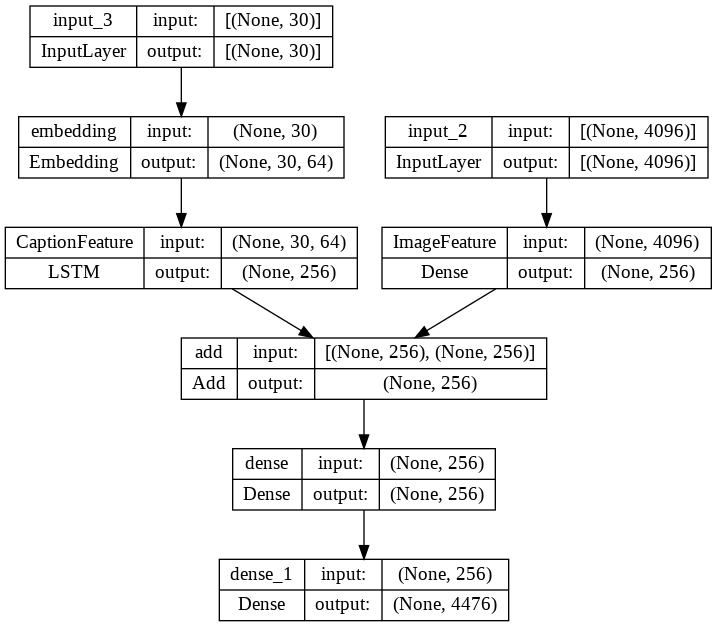

In [ ]:
#visualizing the model
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model3.png', show_shapes=True)

In [ ]:
#training the model on the training set with 5 epochs 
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, epochs=5, verbose=2, batch_size=64, validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)


Epoch 1/5
776/776 - 154s - loss: 5.3239 - val_loss: 4.7578 - 154s/epoch - 199ms/step
Epoch 2/5
776/776 - 110s - loss: 4.3276 - val_loss: 4.4834 - 110s/epoch - 141ms/step
Epoch 3/5
776/776 - 68s - loss: 3.8557 - val_loss: 4.4061 - 68s/epoch - 88ms/step
Epoch 4/5
776/776 - 67s - loss: 3.5181 - val_loss: 4.4428 - 67s/epoch - 87ms/step
Epoch 5/5
776/776 - 67s - loss: 3.2412 - val_loss: 4.5084 - 67s/epoch - 86ms/step
TIME TOOK 7.81MIN
(49631, 4096) (49631, 30) (49631, 4476)


In [ ]:
#trying to predict y_text for input x_image and x_text
print(Ximage_train[0])
print(Xtext_train[0])
print(ytext_train[0][75])

In [ ]:
model.save_weights('model_weights.h5')

CAPTION GENERATION

In [ ]:
#predicting captions from the test set
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'
    for iword in range(maxlen):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)

npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1
fig = plt.figure(figsize=(20,50))
for jpgfnm, image_feature in zip(fnm_test[npic+5:npic+15],di_test[npic+5:npic+15]):
    
    filename = dir_Flickr_jpg + '/' + jpgfnm # Images
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic+10,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    caption = predict_caption(image_feature.reshape(1,len(image_feature))) # Captions
    ax = fig.add_subplot(npic+10,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=15)
    count += 1

plt.show()


##**EVALUATION METRICS**


evaluating the performance of the model in terms of prediction using bleu metrics.

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startreg, and endreg
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startreg, and endreg
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

  12.36% is done..
  24.72% is done..
  37.08% is done..
  49.44% is done..
  61.80% is done..
  74.17% is done..
  86.53% is done..
  98.89% is done..


In [ ]:
#plotting images with a good bleu score (>0.7)
pred_good


[(0.7259795291154771,
  '1119418776_58e4b93eac.jpg',
  ['black', 'and', 'white', 'dog', 'is', 'running', 'through', 'the', 'field'],
  ['brown',
   'and',
   'white',
   'dog',
   'is',
   'running',
   'through',
   'the',
   'grass'])]

In [ ]:
pred_bad

[(6.085166479973199e-232,
  '1000268201_693b08cb0e.jpg',
  ['child',
   'in',
   'pink',
   'dress',
   'is',
   'climbing',
   'up',
   'set',
   'of',
   'stairs',
   'in',
   'an',
   'entry',
   'way'],
  ['man', 'in', 'white', 'cap', 'is', 'sitting', 'on', 'train']),
 (1.384292958842266e-231,
  '1001773457_577c3a7d70.jpg',
  ['black', 'dog', 'and', 'spotted', 'dog', 'are', 'fighting'],
  ['black', 'and', 'white', 'dog', 'is', 'running', 'on', 'the', 'yard']),
 (3.0963867043779474e-232,
  '1002674143_1b742ab4b8.jpg',
  ['little',
   'girl',
   'covered',
   'in',
   'paint',
   'sits',
   'in',
   'front',
   'of',
   'painted',
   'rainbow',
   'with',
   'her',
   'hands',
   'in',
   'bowl'],
  ['two', 'girls', 'are', 'walking', 'in', 'the', 'street']),
 (7.107197028258987e-232,
  '1003163366_44323f5815.jpg',
  ['man', 'lays', 'on', 'bench', 'while', 'his', 'dog', 'sits', 'by', 'him'],
  ['dog', 'is', 'jumping', 'on', 'the', 'yard']),
 (6.08970970641905e-155,
  '1007129816_e7944

Captions corresponding to Low-BLEU Score


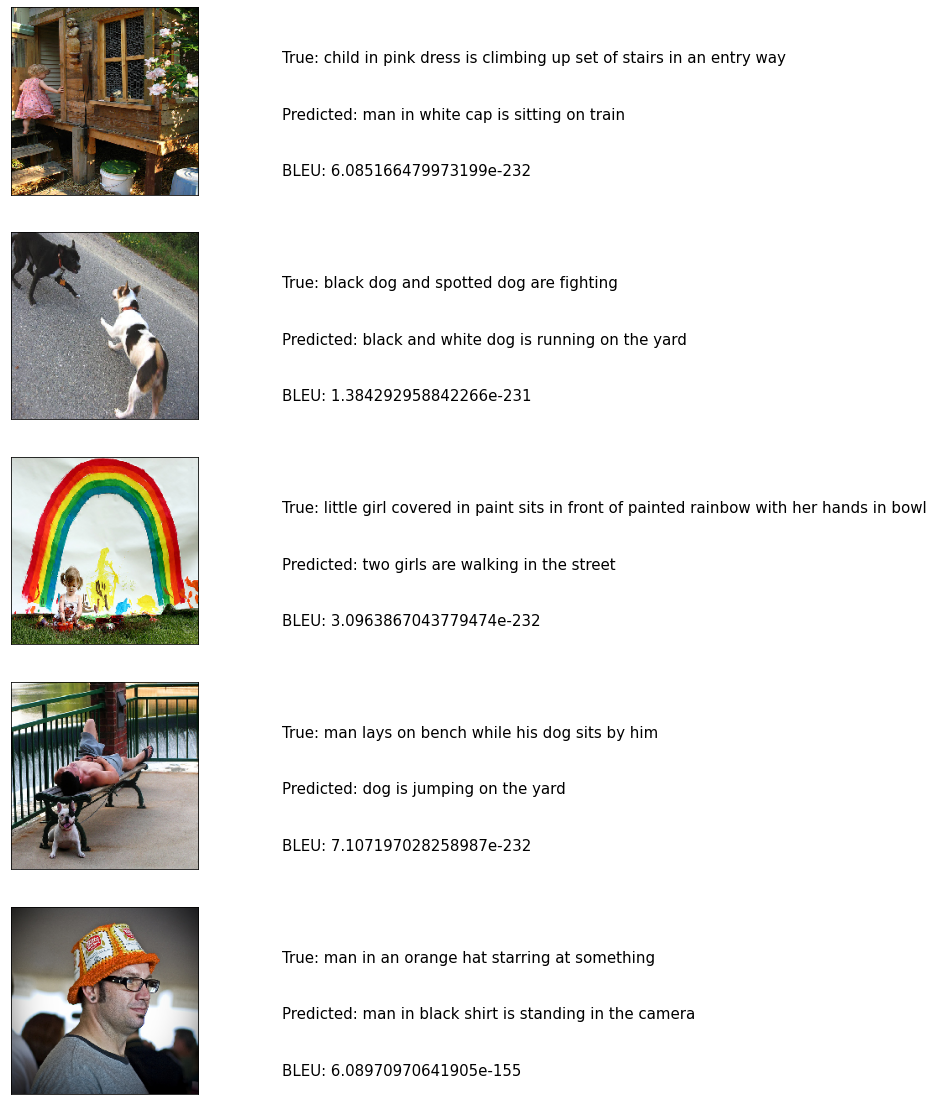

Captions corresponding to High-BLEU Score


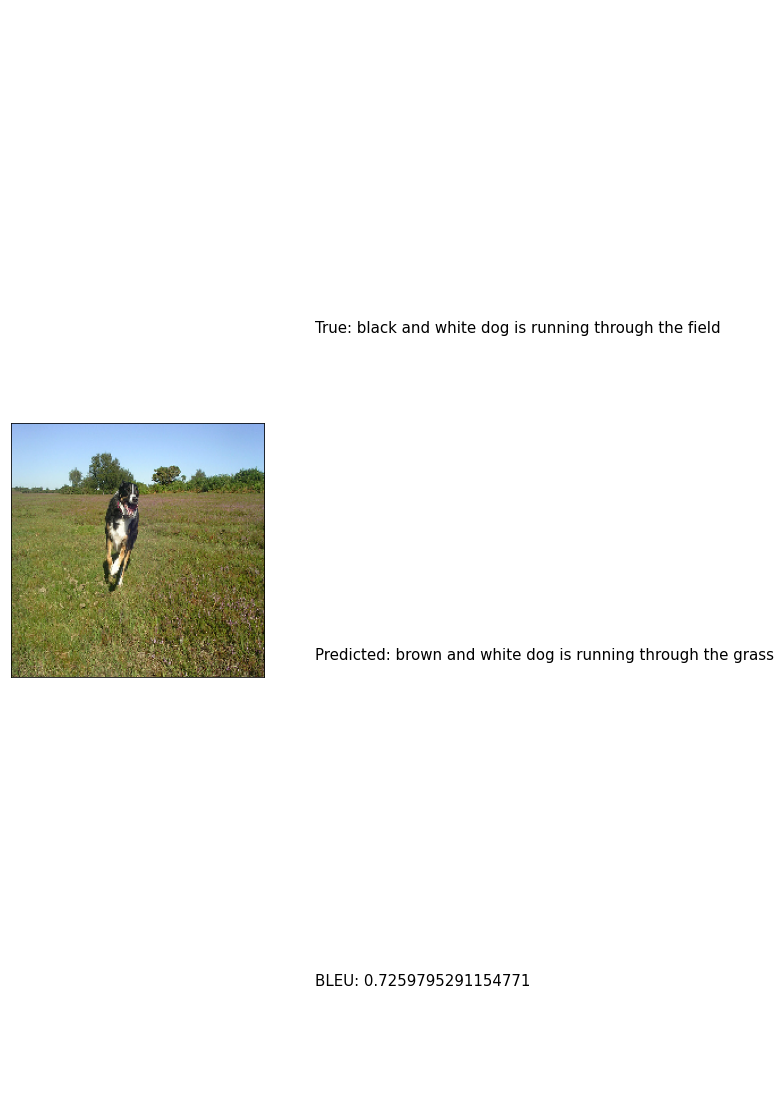

In [ ]:
#plotting images with high and low bleu scores
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        filename = dir_Flickr_jpg + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1
        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"True:" + caption_true,fontsize=15)
        ax.text(0,0.4,"Predicted:" + caption,fontsize=15)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=15)
        count += 1
    plt.show()

print("Captions corresponding to Low-BLEU Score")
plot_images(pred_bad)
print("Captions corresponding to High-BLEU Score")
plot_images(pred_good)